# Comparison between different models for the Kaggle challenge "SETI Breakthrough Listen" 

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn import metrics
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sn
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
from efficientnet_pytorch import model as enet
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import codecs
from PIL import Image

In [2]:
def set_seed(seed = 0):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random_state = np.random.RandomState(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    return random_state

random_state = set_seed(2021)

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


Part of "train/0" -> 1600 samples, ~1.3 GB

In [4]:
df_train=pd.read_csv('./train_labels_shorted.csv')
df_train.head()

,id,target
0,0000799a2b2c42d,0
1,00042890562ff68,0
2,0005364cdcb8e5b,0
3,0007a5a46901c56,0
4,0009283e145448e,0


In [5]:
df_train['img_path']=df_train['id'].apply(lambda x:f'./train/selectiontrain/{x}.npy')
df_train.head()

,id,target,img_path
0,0000799a2b2c42d,0,./train/selectiontrain/0000799a2b2c42d.npy
1,00042890562ff68,0,./train/selectiontrain/00042890562ff68.npy
2,0005364cdcb8e5b,0,./train/selectiontrain/0005364cdcb8e5b.npy
3,0007a5a46901c56,0,./train/selectiontrain/0007a5a46901c56.npy
4,0009283e145448e,0,./train/selectiontrain/0009283e145448e.npy


1600


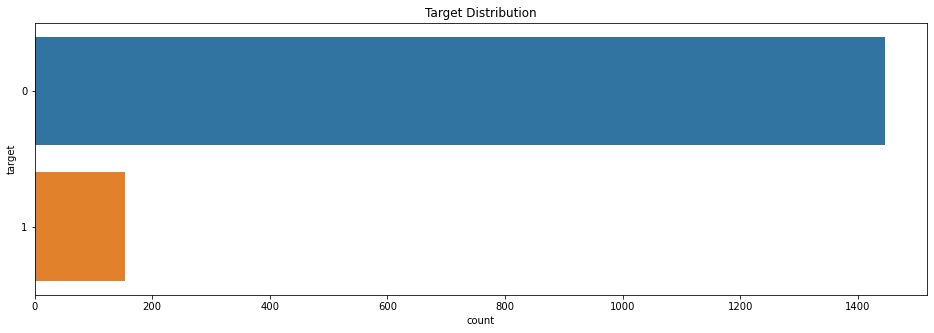

In [6]:
plt.figure(figsize=(16, 5))
sn.countplot(y="target", data=df_train)
plt.title("Target Distribution");
print(len(df_train))

In [7]:
class ClassificationDataset:
    
    def __init__(self, image_paths, targets, augment=False): 
        self.image_paths = image_paths
        self.targets = targets
        self.augment = augment

    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, item):      
        image = np.load(self.image_paths[item]).astype(float)
        
        targets = self.targets[item]
        
        if self.augment:
            image = np.vstack(image).transpose((1, 0))
            
            img_pl = Image.fromarray(image).resize((512, 512), resample=Image.BICUBIC)
            image = np.array(img_pl)
                
        return {
            "image": torch.tensor(image, dtype=torch.float) if not self.augment else torch.from_numpy(image).unsqueeze(dim=0),
            "targets": torch.tensor(targets, dtype=torch.long),
        }

In [8]:
class enetv2(nn.Module):
    def __init__(self, backbone, pretrained=False, out_dim=1):
        super(enetv2, self).__init__()
        self.enet = enet.EfficientNet.from_name(backbone)
        if pretrained:
            self.enet.load_state_dict(torch.load(pretrained_model[backbone]))
        self.myfc = nn.Linear(self.enet._fc.in_features, out_dim)
        self.enet._fc = nn.Identity()
        self.conv1 = nn.Conv2d(6, 3, kernel_size=3, stride=1, padding=3, bias=False)
        self.conv1Norm = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=3, bias=False)
        self.poolNorm = nn.MaxPool2d(2, 2)
        self.conv2Norm = nn.Conv2d(32, 3, kernel_size=3, bias=False)

    def extract(self, x):
        return self.enet(x)

    def forward(self, x):
        flag = x[0][0].shape == (512, 512)
        if flag:
            x = self.conv1Norm(x)
            x = self.poolNorm(x)
            x = self.conv2Norm(x)
        else:
            x = self.conv1(x)
        x = self.extract(x)
        x = self.myfc(x)
        return x

In [9]:
class simpleNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(6, 3, kernel_size=3, stride=1, padding=3, bias=False)
        self.conv1Norm = nn.Conv2d(1, 3, kernel_size=3, stride=1, padding=3, bias=False)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(3, 16, 5)
        self.fc1 = nn.Linear(67536, 120)
        self.fc1Norm = nn.Linear(258064, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 1)
        
    def forward(self, x):
        flag = x[0][0].shape == (512, 512)
        if flag:
            x = self.pool(F.relu(self.conv1Norm(x)))
        else:
            x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        if flag:
            x = F.relu(self.fc1Norm(x))
        else:
            x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [10]:
def train(data_loader, model, optimizer, device):
    
    model.train() # Sets to train mode
    
    loss_sum = 0
    
    for data in tqdm(data_loader, position=0, leave=True, desc='Training'):
        inputs = data["image"]
        targets = data['targets']
        
        # Cast
        inputs = inputs.to(device, dtype=torch.float)
        targets = targets.to(device, dtype=torch.float)
        
        optimizer.zero_grad() # Gradient Descent
        outputs = model(inputs) # Output Weights
        loss = nn.BCEWithLogitsLoss()(outputs, targets.view(-1, 1)) # Loss-Berechnung: BCE-Loss + Sigmoid
        loss_sum += loss
        loss.backward()
        optimizer.step()
        
    return loss_sum
        
def evaluate(data_loader, model, device):
    model.eval() # Sets to evaluation mode
    
    final_targets = []
    final_outputs = []
    
    with torch.no_grad():
        loss_sum = 0
        
        for data in tqdm(data_loader, position=0, leave=True, desc='Evaluating'):
            inputs = data["image"]
            targets = data["targets"]
            inputs = inputs.to(device, dtype=torch.float)
            targets = targets.to(device, dtype=torch.float)
            
            output = model(inputs)
            
            loss_sum += nn.BCEWithLogitsLoss()(output, targets.view(-1, 1))
            
            targets = targets.detach().cpu().numpy().tolist()
            output = output.detach().cpu().numpy().tolist()
            
            final_targets.extend(targets)
            final_outputs.extend(output)
            
    return final_outputs, final_targets, loss_sum

In [11]:
baseline_name = ['efficientnet-b1', 'efficientnet-b3'] # Die Architektur bzw. das Netz? Warum ausgerechnet das?
pretrained_model = {
    baseline_name[0]: './checkpoint/efficientnet-b1-dbc7070a.pth', # Checkpoint?
    baseline_name[1]: './checkpoint/efficientnet-b3-c8376fa2.pth'
}
models = []
device = "cuda"
Batch_Size = 16
X = df_train.img_path.values
Y = df_train.target.values
#skf = StratifiedKFold(n_splits=5) # Cross Validation 5-fold, mehrschichtig (stratified)
# -> https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html#sphx-glr-auto-examples-model-selection-plot-cv-indices-py)
#fold = 0

starter_models = [simpleNet(), simpleNet(),
                  enetv2(baseline_name[0], pretrained=False, out_dim=1), enetv2(baseline_name[0], pretrained=False, out_dim=1),
                  enetv2(baseline_name[0], pretrained=True, out_dim=1), enetv2(baseline_name[0], pretrained=True, out_dim=1),
                  enetv2(baseline_name[1], pretrained=False, out_dim=1), enetv2(baseline_name[1], pretrained=False, out_dim=1),
                  enetv2(baseline_name[1], pretrained=True, out_dim=1), enetv2(baseline_name[1], pretrained=True, out_dim=1)]

names = ['simpleNet', 'simpleNet-Augment', 'efficientnet-b1', 'efficientnet-b1-augment',
         'efficientnet-b1-pretrained', 'efficientnet-b1-pretrained-augment','efficientnet-b3', 'efficientnet-b3-augment',
         'efficientnet-b3-pretrained', 'efficientnet-b3-pretrained-augment']

epochs = [0 for i in names]
train_losses = [[] for i in names]
valid_losses = [[] for i in names]
aurocs = [[] for i in names]

it = 0

In [12]:
#create log file
codecs.open('log2.log', 'w+');

In [13]:
for model in starter_models:
    train_images, valid_images, train_targets, valid_targets = train_test_split(X, Y, random_state=2021)
    #model = enetv2(baseline_name, out_dim=1)
    model.to(device)
    
    train_dataset = ClassificationDataset(image_paths=train_images, targets=train_targets, augment=it%2!=0)
    valid_dataset = ClassificationDataset(image_paths=valid_images, targets=valid_targets, augment=it%2!=0)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=Batch_Size,shuffle=True, num_workers=4)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=Batch_Size,shuffle=False, num_workers=4)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    best_roc_auc = 0.0
    last_roc_auc = 0.0
    roc_auc = 1.0
    row = 0
    last_loss = 0
    train_loss = 10
    valid_loss = 10

    #for epoch in range(epochs):
    #while abs(last_roc_auc - roc_auc) > 0.001 or row < 2:
    #    if abs(last_roc_auc - roc_auc) < 0.001:
    while (abs(last_loss - train_loss) > 0.01 or row < 2) and epochs[it] < 500:
        if abs(last_loss - train_loss) < 0.01:    
            row += 1
        else:
            row = 0
        last_loss = train_loss
        epochs[it] += 1
        last_roc_auc = roc_auc
        train_loss = train(train_loader, model, optimizer, device=device)
        predictions, valid_targets, valid_loss = evaluate(valid_loader, model, device=device)
        roc_auc = metrics.roc_auc_score(valid_targets, predictions)
        
        train_losses[it].append(train_loss.detach().cpu().numpy()) 
        valid_losses[it].append(valid_loss.detach().cpu().numpy())
        aurocs[it].append(roc_auc)
        #f1_score = metrics.f1_score(valid_targets, predictions)
        print(f"Epoch={epochs[it]}, Train Loss={train_loss}, Train Loss Diff={abs(last_loss - train_loss)} Validation Loss={valid_loss}, Validation ROC AUC={roc_auc}, Distance Actual/Last={abs(roc_auc - last_roc_auc)}")

        with codecs.open('log2.log', 'a') as up:
            up.write(f"Model={names[it]}, Epoch={epochs[it]}, Train Loss={train_loss}, Valid Loss={valid_loss} Valid ROC AUC={roc_auc}/{best_roc_auc}\n")

        
    print(f'Model {names[it]} converged after {epochs[it]} epochs.')
    torch.save(model.state_dict(), names[it] + '-' + str(it) + '.pt')
    models.append(model)
    it += 1
    
print('finished')
it = 0

Evaluating: 100%|███████████████████████████████| 25/25 [00:00<00:00, 28.37it/s]


Epoch=1, Train Loss=28.176597595214844, Train Loss Diff=18.176597595214844 Validation Loss=8.148472785949707, Validation ROC AUC=0.45290745290745293, Distance Actual/Last=0.5470925470925471


Evaluating: 100%|███████████████████████████████| 25/25 [00:00<00:00, 30.85it/s]


Epoch=2, Train Loss=23.470951080322266, Train Loss Diff=4.705646514892578 Validation Loss=8.16374683380127, Validation ROC AUC=0.49006030824212643, Distance Actual/Last=0.037152855334673496


Evaluating: 100%|███████████████████████████████| 25/25 [00:00<00:00, 30.90it/s]


Epoch=3, Train Loss=21.183809280395508, Train Loss Diff=2.287141799926758 Validation Loss=8.247810363769531, Validation ROC AUC=0.5534956444047353, Distance Actual/Last=0.06343533616260888


Evaluating: 100%|███████████████████████████████| 25/25 [00:00<00:00, 29.92it/s]


Epoch=4, Train Loss=15.351211547851562, Train Loss Diff=5.832597732543945 Validation Loss=9.337091445922852, Validation ROC AUC=0.5598242870970143, Distance Actual/Last=0.006328642692278952


Evaluating: 100%|███████████████████████████████| 25/25 [00:00<00:00, 30.36it/s]


Epoch=5, Train Loss=10.835222244262695, Train Loss Diff=4.515989303588867 Validation Loss=9.898305892944336, Validation ROC AUC=0.5601221055766511, Distance Actual/Last=0.0002978184796368355


Evaluating: 100%|███████████████████████████████| 25/25 [00:00<00:00, 29.76it/s]


Epoch=6, Train Loss=6.944273471832275, Train Loss Diff=3.89094877243042 Validation Loss=12.009422302246094, Validation ROC AUC=0.5531978259250986, Distance Actual/Last=0.006924279651552512


Evaluating: 100%|███████████████████████████████| 25/25 [00:00<00:00, 29.94it/s]


Epoch=7, Train Loss=4.209289073944092, Train Loss Diff=2.7349843978881836 Validation Loss=17.49184226989746, Validation ROC AUC=0.5139602412329685, Distance Actual/Last=0.03923758469213012


Evaluating: 100%|███████████████████████████████| 25/25 [00:00<00:00, 29.79it/s]


Epoch=8, Train Loss=3.899390697479248, Train Loss Diff=0.30989837646484375 Validation Loss=20.20749855041504, Validation ROC AUC=0.5336162608889882, Distance Actual/Last=0.019656019656019708


Evaluating: 100%|███████████████████████████████| 25/25 [00:00<00:00, 31.94it/s]


Epoch=9, Train Loss=4.534425258636475, Train Loss Diff=0.6350345611572266 Validation Loss=13.16830825805664, Validation ROC AUC=0.49765467947286135, Distance Actual/Last=0.03596158141612682


Evaluating: 100%|███████████████████████████████| 25/25 [00:00<00:00, 31.27it/s]


Epoch=10, Train Loss=4.508227348327637, Train Loss Diff=0.02619791030883789 Validation Loss=18.9217472076416, Validation ROC AUC=0.4975802248529521, Distance Actual/Last=7.445461990923663e-05


Evaluating: 100%|███████████████████████████████| 25/25 [00:00<00:00, 32.35it/s]


Epoch=11, Train Loss=3.1645522117614746, Train Loss Diff=1.343675136566162 Validation Loss=20.119617462158203, Validation ROC AUC=0.5182786091877002, Distance Actual/Last=0.020698384334748077


Evaluating: 100%|███████████████████████████████| 25/25 [00:00<00:00, 32.27it/s]


Epoch=12, Train Loss=1.6107712984085083, Train Loss Diff=1.5537809133529663 Validation Loss=25.440195083618164, Validation ROC AUC=0.5113543295361477, Distance Actual/Last=0.006924279651552512


Evaluating: 100%|███████████████████████████████| 25/25 [00:00<00:00, 32.71it/s]


Epoch=13, Train Loss=0.5492806434631348, Train Loss Diff=1.0614906549453735 Validation Loss=30.095577239990234, Validation ROC AUC=0.5126945126945128, Distance Actual/Last=0.0013401831583651491


Evaluating: 100%|███████████████████████████████| 25/25 [00:00<00:00, 33.22it/s]


Epoch=14, Train Loss=0.41735973954200745, Train Loss Diff=0.13192090392112732 Validation Loss=28.679187774658203, Validation ROC AUC=0.504727868364232, Distance Actual/Last=0.007966644330280825


Evaluating: 100%|███████████████████████████████| 25/25 [00:00<00:00, 31.42it/s]


Epoch=15, Train Loss=0.24354751408100128, Train Loss Diff=0.17381222546100616 Validation Loss=30.77924156188965, Validation ROC AUC=0.5080783262601445, Distance Actual/Last=0.0033504578959124842


Evaluating: 100%|███████████████████████████████| 25/25 [00:00<00:00, 34.71it/s]


Epoch=16, Train Loss=0.1507958620786667, Train Loss Diff=0.0927516520023346 Validation Loss=28.475011825561523, Validation ROC AUC=0.49698458789367883, Distance Actual/Last=0.011093738366465655


Evaluating: 100%|███████████████████████████████| 25/25 [00:00<00:00, 32.39it/s]


Epoch=17, Train Loss=0.10669398307800293, Train Loss Diff=0.04410187900066376 Validation Loss=35.013389587402344, Validation ROC AUC=0.49698458789367883, Distance Actual/Last=0.0


Evaluating: 100%|███████████████████████████████| 25/25 [00:00<00:00, 29.66it/s]


Epoch=18, Train Loss=0.05028750002384186, Train Loss Diff=0.05640648305416107 Validation Loss=39.87626647949219, Validation ROC AUC=0.49832477105204376, Distance Actual/Last=0.001340183158364927


Evaluating: 100%|███████████████████████████████| 25/25 [00:00<00:00, 34.00it/s]


Epoch=19, Train Loss=0.02856307104229927, Train Loss Diff=0.021724428981542587 Validation Loss=35.40011978149414, Validation ROC AUC=0.498399225671953, Distance Actual/Last=7.445461990923663e-05


Evaluating: 100%|███████████████████████████████| 25/25 [00:00<00:00, 33.47it/s]


Epoch=20, Train Loss=0.00737781124189496, Train Loss Diff=0.021185260266065598 Validation Loss=39.789955139160156, Validation ROC AUC=0.5000372273099546, Distance Actual/Last=0.001638001638001596


Evaluating: 100%|███████████████████████████████| 25/25 [00:00<00:00, 33.43it/s]


Epoch=21, Train Loss=0.004889737349003553, Train Loss Diff=0.002488073892891407 Validation Loss=40.74744415283203, Validation ROC AUC=0.5004839550294096, Distance Actual/Last=0.0004467277194549757


Evaluating: 100%|███████████████████████████████| 25/25 [00:00<00:00, 31.32it/s]


Epoch=22, Train Loss=0.003926250617951155, Train Loss Diff=0.0009634867310523987 Validation Loss=41.47301483154297, Validation ROC AUC=0.5012285012285012, Distance Actual/Last=0.0007445461990915891


Evaluating: 100%|███████████████████████████████| 25/25 [00:00<00:00, 32.09it/s]


Epoch=23, Train Loss=0.003237704513594508, Train Loss Diff=0.0006885461043566465 Validation Loss=42.15339660644531, Validation ROC AUC=0.5016007743280471, Distance Actual/Last=0.0003722730995459056
Model simpleNet converged after 23 epochs.


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 13.08it/s]


Epoch=1, Train Loss=32.90007400512695, Train Loss Diff=22.900074005126953 Validation Loss=8.047676086425781, Validation ROC AUC=0.48864567046385227, Distance Actual/Last=0.5113543295361478


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.72it/s]


Epoch=2, Train Loss=22.645872116088867, Train Loss Diff=10.254201889038086 Validation Loss=9.338244438171387, Validation ROC AUC=0.4825403916313008, Distance Actual/Last=0.006105278832551464


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 12.91it/s]


Epoch=3, Train Loss=18.30895233154297, Train Loss Diff=4.336919784545898 Validation Loss=8.811466217041016, Validation ROC AUC=0.5129923311741493, Distance Actual/Last=0.030451939542848527


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.63it/s]


Epoch=4, Train Loss=12.722755432128906, Train Loss Diff=5.5861968994140625 Validation Loss=16.547977447509766, Validation ROC AUC=0.5115776933958752, Distance Actual/Last=0.0014146377782741082


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.99it/s]


Epoch=5, Train Loss=9.626693725585938, Train Loss Diff=3.0960617065429688 Validation Loss=12.456656455993652, Validation ROC AUC=0.578140123594669, Distance Actual/Last=0.06656243019879382


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 13.14it/s]


Epoch=6, Train Loss=4.46012544631958, Train Loss Diff=5.166568279266357 Validation Loss=15.046311378479004, Validation ROC AUC=0.6019656019656019, Distance Actual/Last=0.02382547837093285


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.06it/s]


Epoch=7, Train Loss=3.217158079147339, Train Loss Diff=1.2429673671722412 Validation Loss=16.846668243408203, Validation ROC AUC=0.5438165438165439, Distance Actual/Last=0.05814905814905802


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 12.63it/s]


Epoch=8, Train Loss=1.6247658729553223, Train Loss Diff=1.5923922061920166 Validation Loss=20.231595993041992, Validation ROC AUC=0.5458268185540913, Distance Actual/Last=0.002010274737547446


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 12.77it/s]


Epoch=9, Train Loss=1.8521994352340698, Train Loss Diff=0.22743356227874756 Validation Loss=15.102930068969727, Validation ROC AUC=0.5805971260516716, Distance Actual/Last=0.034770307497580255


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.65it/s]


Epoch=10, Train Loss=1.1429166793823242, Train Loss Diff=0.7092827558517456 Validation Loss=27.644615173339844, Validation ROC AUC=0.5450078177350904, Distance Actual/Last=0.035589308316581136


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 12.54it/s]


Epoch=11, Train Loss=1.3674017190933228, Train Loss Diff=0.22448503971099854 Validation Loss=22.54146385192871, Validation ROC AUC=0.5261707988980717, Distance Actual/Last=0.018837018837018715


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 12.55it/s]


Epoch=12, Train Loss=1.033096194267273, Train Loss Diff=0.3343055248260498 Validation Loss=25.97162628173828, Validation ROC AUC=0.4969101332737697, Distance Actual/Last=0.029260665624302018


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.16it/s]


Epoch=13, Train Loss=2.5303280353546143, Train Loss Diff=1.4972318410873413 Validation Loss=27.38341522216797, Validation ROC AUC=0.4699575608666518, Distance Actual/Last=0.026952572407117903


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 12.74it/s]


Epoch=14, Train Loss=1.0558662414550781, Train Loss Diff=1.4744617938995361 Validation Loss=31.152301788330078, Validation ROC AUC=0.5235648872012508, Distance Actual/Last=0.053607326334599026


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.94it/s]


Epoch=15, Train Loss=1.2134222984313965, Train Loss Diff=0.15755605697631836 Validation Loss=36.94865798950195, Validation ROC AUC=0.4995904995904996, Distance Actual/Last=0.023974387610751213


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 12.57it/s]


Epoch=16, Train Loss=1.0366860628128052, Train Loss Diff=0.1767362356185913 Validation Loss=29.232696533203125, Validation ROC AUC=0.4995904995904996, Distance Actual/Last=0.0


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.44it/s]


Epoch=17, Train Loss=0.06517349183559418, Train Loss Diff=0.9715125560760498 Validation Loss=37.61574935913086, Validation ROC AUC=0.5010795919886829, Distance Actual/Last=0.0014890923981832893


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 12.52it/s]


Epoch=18, Train Loss=0.02538086287677288, Train Loss Diff=0.03979262709617615 Validation Loss=36.197872161865234, Validation ROC AUC=0.504281140644777, Distance Actual/Last=0.003201548656094122


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 12.55it/s]


Epoch=19, Train Loss=0.012211545370519161, Train Loss Diff=0.01316931750625372 Validation Loss=37.546199798583984, Validation ROC AUC=0.505621323803142, Distance Actual/Last=0.001340183158364927


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 12.69it/s]


Epoch=20, Train Loss=0.008737696334719658, Train Loss Diff=0.0034738490357995033 Validation Loss=38.36875534057617, Validation ROC AUC=0.5053979599434145, Distance Actual/Last=0.00022336385972743233


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 12.76it/s]


Epoch=21, Train Loss=0.006839295383542776, Train Loss Diff=0.0018984009511768818 Validation Loss=39.122989654541016, Validation ROC AUC=0.5062169607624154, Distance Actual/Last=0.0008190008190008813


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 12.63it/s]


Epoch=22, Train Loss=0.005401992239058018, Train Loss Diff=0.0014373031444847584 Validation Loss=39.77622604370117, Validation ROC AUC=0.5070359615814162, Distance Actual/Last=0.0008190008190007703
Model simpleNet-Augment converged after 22 epochs.


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.94it/s]


Epoch=1, Train Loss=29.662111282348633, Train Loss Diff=19.662111282348633 Validation Loss=8.21765422821045, Validation ROC AUC=0.443265579629216, Distance Actual/Last=0.556734420370784


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.37it/s]


Epoch=2, Train Loss=25.930009841918945, Train Loss Diff=3.7321014404296875 Validation Loss=7.712177276611328, Validation ROC AUC=0.48544412180775814, Distance Actual/Last=0.04217854217854217


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 18.90it/s]


Epoch=3, Train Loss=25.031776428222656, Train Loss Diff=0.8982334136962891 Validation Loss=7.746156692504883, Validation ROC AUC=0.4985481349117713, Distance Actual/Last=0.013104013104013157


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.25it/s]


Epoch=4, Train Loss=25.466522216796875, Train Loss Diff=0.43474578857421875 Validation Loss=7.737783432006836, Validation ROC AUC=0.5336162608889882, Distance Actual/Last=0.03506812597721687


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 18.97it/s]


Epoch=5, Train Loss=24.904438018798828, Train Loss Diff=0.5620841979980469 Validation Loss=7.703090667724609, Validation ROC AUC=0.5916164097982279, Distance Actual/Last=0.05800014890923977


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 18.09it/s]


Epoch=6, Train Loss=24.768617630004883, Train Loss Diff=0.1358203887939453 Validation Loss=8.218658447265625, Validation ROC AUC=0.4499292681110863, Distance Actual/Last=0.14168714168714164


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 18.81it/s]


Epoch=7, Train Loss=24.34503746032715, Train Loss Diff=0.4235801696777344 Validation Loss=8.042924880981445, Validation ROC AUC=0.5931055021964113, Distance Actual/Last=0.14317623408532504


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.69it/s]


Epoch=8, Train Loss=25.19089698791504, Train Loss Diff=0.8458595275878906 Validation Loss=7.917901039123535, Validation ROC AUC=0.4116595934777753, Distance Actual/Last=0.18144590871863603


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.02it/s]


Epoch=9, Train Loss=24.62741470336914, Train Loss Diff=0.5634822845458984 Validation Loss=8.574634552001953, Validation ROC AUC=0.4765840220385675, Distance Actual/Last=0.06492442856079217


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.35it/s]


Epoch=10, Train Loss=24.37943458557129, Train Loss Diff=0.24798011779785156 Validation Loss=8.4045991897583, Validation ROC AUC=0.45744918472191204, Distance Actual/Last=0.01913483731665544


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.11it/s]


Epoch=11, Train Loss=24.400564193725586, Train Loss Diff=0.021129608154296875 Validation Loss=7.796768665313721, Validation ROC AUC=0.4649691013327377, Distance Actual/Last=0.007519916610825683


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 18.99it/s]


Epoch=12, Train Loss=24.349586486816406, Train Loss Diff=0.05097770690917969 Validation Loss=7.715912342071533, Validation ROC AUC=0.5473903655721838, Distance Actual/Last=0.08242126423944607


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 18.87it/s]


Epoch=13, Train Loss=24.246389389038086, Train Loss Diff=0.10319709777832031 Validation Loss=7.687183380126953, Validation ROC AUC=0.5007817735090462, Distance Actual/Last=0.04660859206313761


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 18.46it/s]


Epoch=14, Train Loss=24.24129295349121, Train Loss Diff=0.005096435546875 Validation Loss=7.816758155822754, Validation ROC AUC=0.45916164097982276, Distance Actual/Last=0.04162013252922342


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.37it/s]


Epoch=15, Train Loss=24.485689163208008, Train Loss Diff=0.24439620971679688 Validation Loss=7.996913909912109, Validation ROC AUC=0.5005584096493187, Distance Actual/Last=0.04139676866949599


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.86it/s]


Epoch=16, Train Loss=24.45207977294922, Train Loss Diff=0.03360939025878906 Validation Loss=7.672226905822754, Validation ROC AUC=0.5689822053458418, Distance Actual/Last=0.06842379569652302


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.08it/s]


Epoch=17, Train Loss=23.87055206298828, Train Loss Diff=0.5815277099609375 Validation Loss=7.741044521331787, Validation ROC AUC=0.5193954284863376, Distance Actual/Last=0.04958677685950419


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.44it/s]


Epoch=18, Train Loss=24.25481414794922, Train Loss Diff=0.3842620849609375 Validation Loss=7.921168804168701, Validation ROC AUC=0.4803067530340258, Distance Actual/Last=0.03908867545231176


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 18.93it/s]


Epoch=19, Train Loss=24.218151092529297, Train Loss Diff=0.036663055419921875 Validation Loss=7.878597736358643, Validation ROC AUC=0.4520884520884521, Distance Actual/Last=0.028218300945573704


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 18.54it/s]


Epoch=20, Train Loss=24.058685302734375, Train Loss Diff=0.15946578979492188 Validation Loss=7.915596961975098, Validation ROC AUC=0.49646340555431473, Distance Actual/Last=0.04437495346586262


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.78it/s]


Epoch=21, Train Loss=24.161903381347656, Train Loss Diff=0.10321807861328125 Validation Loss=7.789088249206543, Validation ROC AUC=0.5018241381877746, Distance Actual/Last=0.005360732633459875


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.77it/s]


Epoch=22, Train Loss=23.746858596801758, Train Loss Diff=0.41504478454589844 Validation Loss=7.804573059082031, Validation ROC AUC=0.5234904325813416, Distance Actual/Last=0.021666294393567043


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 20.02it/s]


Epoch=23, Train Loss=23.67030906677246, Train Loss Diff=0.07654953002929688 Validation Loss=8.124390602111816, Validation ROC AUC=0.4638522820341003, Distance Actual/Last=0.059638150547241364


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.47it/s]


Epoch=24, Train Loss=23.57465362548828, Train Loss Diff=0.09565544128417969 Validation Loss=7.809520244598389, Validation ROC AUC=0.4782964782964783, Distance Actual/Last=0.014444196262378028


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.44it/s]


Epoch=25, Train Loss=23.92149543762207, Train Loss Diff=0.34684181213378906 Validation Loss=7.8566155433654785, Validation ROC AUC=0.4522373613282704, Distance Actual/Last=0.026059116968207896


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.41it/s]


Epoch=26, Train Loss=24.061452865600586, Train Loss Diff=0.13995742797851562 Validation Loss=7.811097145080566, Validation ROC AUC=0.5261707988980717, Distance Actual/Last=0.07393343756980131


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.61it/s]


Epoch=27, Train Loss=24.084501266479492, Train Loss Diff=0.02304840087890625 Validation Loss=8.015581130981445, Validation ROC AUC=0.5090462363189636, Distance Actual/Last=0.017124562579108105


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.03it/s]


Epoch=28, Train Loss=24.185985565185547, Train Loss Diff=0.10148429870605469 Validation Loss=8.006054878234863, Validation ROC AUC=0.5198421562057925, Distance Actual/Last=0.01079591988682893


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 18.65it/s]


Epoch=29, Train Loss=23.659189224243164, Train Loss Diff=0.5267963409423828 Validation Loss=7.7346272468566895, Validation ROC AUC=0.5575906484997394, Distance Actual/Last=0.037748492293946834


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 18.74it/s]


Epoch=30, Train Loss=23.490156173706055, Train Loss Diff=0.16903305053710938 Validation Loss=7.97764253616333, Validation ROC AUC=0.52810661901571, Distance Actual/Last=0.029484029484029395


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.44it/s]


Epoch=31, Train Loss=24.01171112060547, Train Loss Diff=0.5215549468994141 Validation Loss=7.7506208419799805, Validation ROC AUC=0.5368178095450823, Distance Actual/Last=0.008711190529372304


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.43it/s]


Epoch=32, Train Loss=23.283374786376953, Train Loss Diff=0.7283363342285156 Validation Loss=7.768173694610596, Validation ROC AUC=0.5001116819298638, Distance Actual/Last=0.03670612761521852


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.54it/s]


Epoch=33, Train Loss=23.37656593322754, Train Loss Diff=0.09319114685058594 Validation Loss=7.726661205291748, Validation ROC AUC=0.5162683344501526, Distance Actual/Last=0.01615665252028886


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.58it/s]


Epoch=34, Train Loss=23.6657772064209, Train Loss Diff=0.2892112731933594 Validation Loss=9.246597290039062, Validation ROC AUC=0.560941106395652, Distance Actual/Last=0.044672771945499345


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.69it/s]


Epoch=35, Train Loss=23.31440544128418, Train Loss Diff=0.35137176513671875 Validation Loss=8.190605163574219, Validation ROC AUC=0.47636065817884005, Distance Actual/Last=0.08458044821681193


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.70it/s]


Epoch=36, Train Loss=23.31329917907715, Train Loss Diff=0.00110626220703125 Validation Loss=10.10814380645752, Validation ROC AUC=0.48179584543220916, Distance Actual/Last=0.0054351872533691115


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.51it/s]


Epoch=37, Train Loss=23.3753662109375, Train Loss Diff=0.06206703186035156 Validation Loss=17.474609375, Validation ROC AUC=0.4470255379346289, Distance Actual/Last=0.034770307497580255


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 18.88it/s]


Epoch=38, Train Loss=23.594083786010742, Train Loss Diff=0.2187175750732422 Validation Loss=8.230401992797852, Validation ROC AUC=0.49988831807013623, Distance Actual/Last=0.052862780135507326


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.88it/s]


Epoch=39, Train Loss=23.28106117248535, Train Loss Diff=0.3130226135253906 Validation Loss=8.03457260131836, Validation ROC AUC=0.46273546273546273, Distance Actual/Last=0.037152855334673496


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.96it/s]


Epoch=40, Train Loss=23.280841827392578, Train Loss Diff=0.0002193450927734375 Validation Loss=8.23139762878418, Validation ROC AUC=0.44598317325590053, Distance Actual/Last=0.0167522894795622


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 20.04it/s]


Epoch=41, Train Loss=22.97922706604004, Train Loss Diff=0.30161476135253906 Validation Loss=8.56579875946045, Validation ROC AUC=0.4678728315091951, Distance Actual/Last=0.021889658253294586


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.34it/s]


Epoch=42, Train Loss=22.874122619628906, Train Loss Diff=0.10510444641113281 Validation Loss=8.212788581848145, Validation ROC AUC=0.5715881170426625, Distance Actual/Last=0.10371528553346743


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.41it/s]


Epoch=43, Train Loss=22.919696807861328, Train Loss Diff=0.045574188232421875 Validation Loss=8.4862060546875, Validation ROC AUC=0.4817213908122999, Distance Actual/Last=0.08986672623036263


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.23it/s]


Epoch=44, Train Loss=22.901918411254883, Train Loss Diff=0.017778396606445312 Validation Loss=9.296561241149902, Validation ROC AUC=0.4438239892785348, Distance Actual/Last=0.03789740153376514


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 18.68it/s]


Epoch=45, Train Loss=22.905811309814453, Train Loss Diff=0.0038928985595703125 Validation Loss=9.060630798339844, Validation ROC AUC=0.4116595934777753, Distance Actual/Last=0.03216439580075947


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 18.70it/s]


Epoch=46, Train Loss=23.29058265686035, Train Loss Diff=0.38477134704589844 Validation Loss=8.536537170410156, Validation ROC AUC=0.4232745141836051, Distance Actual/Last=0.011614920705829812


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.08it/s]


Epoch=47, Train Loss=22.659950256347656, Train Loss Diff=0.6306324005126953 Validation Loss=8.757684707641602, Validation ROC AUC=0.49475094929640384, Distance Actual/Last=0.07147643511279872


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 18.78it/s]


Epoch=48, Train Loss=22.616722106933594, Train Loss Diff=0.0432281494140625 Validation Loss=7.756325721740723, Validation ROC AUC=0.5379346288437197, Distance Actual/Last=0.043183679547315834


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.12it/s]


Epoch=49, Train Loss=23.162235260009766, Train Loss Diff=0.5455131530761719 Validation Loss=8.926692008972168, Validation ROC AUC=0.5383813565631749, Distance Actual/Last=0.00044672771945519774


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 18.76it/s]


Epoch=50, Train Loss=22.914867401123047, Train Loss Diff=0.24736785888671875 Validation Loss=8.499391555786133, Validation ROC AUC=0.45045045045045046, Distance Actual/Last=0.08793090611272442


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 18.28it/s]


Epoch=51, Train Loss=23.19293785095215, Train Loss Diff=0.27807044982910156 Validation Loss=8.07226276397705, Validation ROC AUC=0.5386791750428114, Distance Actual/Last=0.08822872459236092


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 18.11it/s]


Epoch=52, Train Loss=23.881671905517578, Train Loss Diff=0.6887340545654297 Validation Loss=8.370014190673828, Validation ROC AUC=0.5018241381877746, Distance Actual/Last=0.03685503685503677


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.52it/s]


Epoch=53, Train Loss=22.925411224365234, Train Loss Diff=0.9562606811523438 Validation Loss=8.867237091064453, Validation ROC AUC=0.45052490507035964, Distance Actual/Last=0.051299233117414966


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 18.41it/s]


Epoch=54, Train Loss=22.918066024780273, Train Loss Diff=0.0073451995849609375 Validation Loss=8.651309967041016, Validation ROC AUC=0.575906484997394, Distance Actual/Last=0.12538157992703441


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.83it/s]


Epoch=55, Train Loss=22.387361526489258, Train Loss Diff=0.5307044982910156 Validation Loss=8.44488525390625, Validation ROC AUC=0.45618345618345624, Distance Actual/Last=0.11972302881393782


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.50it/s]


Epoch=56, Train Loss=22.15467643737793, Train Loss Diff=0.23268508911132812 Validation Loss=7.8281378746032715, Validation ROC AUC=0.6095599731963369, Distance Actual/Last=0.1533765170128807


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.66it/s]


Epoch=57, Train Loss=21.433246612548828, Train Loss Diff=0.7214298248291016 Validation Loss=8.207026481628418, Validation ROC AUC=0.49430422157694887, Distance Actual/Last=0.11525575161938806


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.37it/s]


Epoch=58, Train Loss=21.422500610351562, Train Loss Diff=0.010746002197265625 Validation Loss=8.717615127563477, Validation ROC AUC=0.5902017720199538, Distance Actual/Last=0.09589755044300496


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 18.93it/s]


Epoch=59, Train Loss=20.146465301513672, Train Loss Diff=1.2760353088378906 Validation Loss=9.472412109375, Validation ROC AUC=0.4842528478892115, Distance Actual/Last=0.1059489241307423


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.73it/s]


Epoch=60, Train Loss=17.909751892089844, Train Loss Diff=2.236713409423828 Validation Loss=13.659975051879883, Validation ROC AUC=0.5214801578437942, Distance Actual/Last=0.03722730995458268


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.23it/s]


Epoch=61, Train Loss=18.057849884033203, Train Loss Diff=0.14809799194335938 Validation Loss=9.659652709960938, Validation ROC AUC=0.5213312486039758, Distance Actual/Last=0.00014890923981836224


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 18.73it/s]


Epoch=62, Train Loss=17.396045684814453, Train Loss Diff=0.66180419921875 Validation Loss=15.275540351867676, Validation ROC AUC=0.5219268855632492, Distance Actual/Last=0.0005956369592733379


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.64it/s]


Epoch=63, Train Loss=15.626659393310547, Train Loss Diff=1.7693862915039062 Validation Loss=13.825525283813477, Validation ROC AUC=0.4796366614548433, Distance Actual/Last=0.04229022410840588


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.43it/s]


Epoch=64, Train Loss=15.013998031616211, Train Loss Diff=0.6126613616943359 Validation Loss=16.41139793395996, Validation ROC AUC=0.4776263867172958, Distance Actual/Last=0.0020102747375475016


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.56it/s]


Epoch=65, Train Loss=12.142471313476562, Train Loss Diff=2.8715267181396484 Validation Loss=14.378759384155273, Validation ROC AUC=0.4818703000521182, Distance Actual/Last=0.00424391333482238


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.50it/s]


Epoch=66, Train Loss=12.565766334533691, Train Loss Diff=0.4232950210571289 Validation Loss=15.263922691345215, Validation ROC AUC=0.536222172585809, Distance Actual/Last=0.05435187253369078


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.67it/s]


Epoch=67, Train Loss=7.906423568725586, Train Loss Diff=4.6593427658081055 Validation Loss=11.29827880859375, Validation ROC AUC=0.5429975429975429, Distance Actual/Last=0.0067753704117339275


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 18.73it/s]


Epoch=68, Train Loss=9.347983360290527, Train Loss Diff=1.4415597915649414 Validation Loss=14.640483856201172, Validation ROC AUC=0.4666071029707393, Distance Actual/Last=0.07639044002680356


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.27it/s]


Epoch=69, Train Loss=6.849379539489746, Train Loss Diff=2.4986038208007812 Validation Loss=17.04431915283203, Validation ROC AUC=0.36959273322909686, Distance Actual/Last=0.09701436974164246


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 18.95it/s]


Epoch=70, Train Loss=7.2046637535095215, Train Loss Diff=0.3552842140197754 Validation Loss=20.66708755493164, Validation ROC AUC=0.4858908495272132, Distance Actual/Last=0.11629811629811632


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 18.63it/s]


Epoch=71, Train Loss=5.340466022491455, Train Loss Diff=1.8641977310180664 Validation Loss=17.755434036254883, Validation ROC AUC=0.467351649169831, Distance Actual/Last=0.018539200357382157


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 18.97it/s]


Epoch=72, Train Loss=7.95067024230957, Train Loss Diff=2.6102042198181152 Validation Loss=16.74995994567871, Validation ROC AUC=0.45663018390291116, Distance Actual/Last=0.01072146526691986


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 18.05it/s]


Epoch=73, Train Loss=4.873672008514404, Train Loss Diff=3.076998233795166 Validation Loss=18.15492820739746, Validation ROC AUC=0.46251209887573536, Distance Actual/Last=0.005881914972824198


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 18.48it/s]


Epoch=74, Train Loss=2.907301664352417, Train Loss Diff=1.9663703441619873 Validation Loss=22.195768356323242, Validation ROC AUC=0.48775221502494226, Distance Actual/Last=0.025240116149206904


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.00it/s]


Epoch=75, Train Loss=2.6610631942749023, Train Loss Diff=0.24623847007751465 Validation Loss=21.46082878112793, Validation ROC AUC=0.41992405628769264, Distance Actual/Last=0.06782815873724962


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 18.48it/s]


Epoch=76, Train Loss=4.414190769195557, Train Loss Diff=1.7531275749206543 Validation Loss=19.18906021118164, Validation ROC AUC=0.5181296999478817, Distance Actual/Last=0.09820564366018908


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.75it/s]


Epoch=77, Train Loss=3.2769176959991455, Train Loss Diff=1.1372730731964111 Validation Loss=15.86194133758545, Validation ROC AUC=0.5648127466309285, Distance Actual/Last=0.04668304668304679


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.23it/s]


Epoch=78, Train Loss=2.0658185482025146, Train Loss Diff=1.2110991477966309 Validation Loss=19.00939178466797, Validation ROC AUC=0.45677909314272946, Distance Actual/Last=0.10803365348819904


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 18.63it/s]


Epoch=79, Train Loss=1.6163009405136108, Train Loss Diff=0.4495176076889038 Validation Loss=20.05979347229004, Validation ROC AUC=0.4908048544412181, Distance Actual/Last=0.03402576129848861


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.08it/s]


Epoch=80, Train Loss=3.7652199268341064, Train Loss Diff=2.148919105529785 Validation Loss=25.187519073486328, Validation ROC AUC=0.3890998436452982, Distance Actual/Last=0.10170501079591987


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.27it/s]


Epoch=81, Train Loss=4.762336730957031, Train Loss Diff=0.9971168041229248 Validation Loss=18.898359298706055, Validation ROC AUC=0.4826148462512099, Distance Actual/Last=0.09351500260591167


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 18.85it/s]


Epoch=82, Train Loss=2.3085951805114746, Train Loss Diff=2.4537415504455566 Validation Loss=19.312894821166992, Validation ROC AUC=0.45275854366763457, Distance Actual/Last=0.0298563025835753


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 18.48it/s]


Epoch=83, Train Loss=2.7793610095977783, Train Loss Diff=0.4707658290863037 Validation Loss=20.77952766418457, Validation ROC AUC=0.4911771275407639, Distance Actual/Last=0.03841858387312935


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.29it/s]


Epoch=84, Train Loss=5.107269287109375, Train Loss Diff=2.3279082775115967 Validation Loss=19.839595794677734, Validation ROC AUC=0.487156578065669, Distance Actual/Last=0.004020549475094948


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.60it/s]


Epoch=85, Train Loss=2.671205759048462, Train Loss Diff=2.436063528060913 Validation Loss=18.130847930908203, Validation ROC AUC=0.5113543295361478, Distance Actual/Last=0.024197751470478812


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.76it/s]


Epoch=86, Train Loss=4.810949802398682, Train Loss Diff=2.1397440433502197 Validation Loss=17.29873275756836, Validation ROC AUC=0.5168639714094259, Distance Actual/Last=0.0055096418732780705


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.35it/s]


Epoch=87, Train Loss=1.147618293762207, Train Loss Diff=3.6633315086364746 Validation Loss=19.649328231811523, Validation ROC AUC=0.4771052043779317, Distance Actual/Last=0.03975876703149417


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.84it/s]


Epoch=88, Train Loss=1.0736041069030762, Train Loss Diff=0.07401418685913086 Validation Loss=24.221582412719727, Validation ROC AUC=0.45953391407936867, Distance Actual/Last=0.017571290298563025


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 18.99it/s]


Epoch=89, Train Loss=0.6101359724998474, Train Loss Diff=0.46346813440322876 Validation Loss=22.090923309326172, Validation ROC AUC=0.4776263867172958, Distance Actual/Last=0.018092472637927126


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 18.97it/s]


Epoch=90, Train Loss=2.6346499919891357, Train Loss Diff=2.0245139598846436 Validation Loss=20.848793029785156, Validation ROC AUC=0.48968803514258064, Distance Actual/Last=0.012061648425284843


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 18.64it/s]


Epoch=91, Train Loss=2.1238133907318115, Train Loss Diff=0.5108366012573242 Validation Loss=18.41702651977539, Validation ROC AUC=0.5262452535179809, Distance Actual/Last=0.03655721837540027


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.88it/s]


Epoch=92, Train Loss=2.5066864490509033, Train Loss Diff=0.3828730583190918 Validation Loss=19.799654006958008, Validation ROC AUC=0.5085250539795995, Distance Actual/Last=0.017720199538381443


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.68it/s]


Epoch=93, Train Loss=1.4985302686691284, Train Loss Diff=1.008156180381775 Validation Loss=19.575607299804688, Validation ROC AUC=0.5085995085995086, Distance Actual/Last=7.445461990918112e-05


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.06it/s]


Epoch=94, Train Loss=2.3317112922668457, Train Loss Diff=0.8331810235977173 Validation Loss=19.9649658203125, Validation ROC AUC=0.4632566450748269, Distance Actual/Last=0.045342863524681754


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 17.78it/s]


Epoch=95, Train Loss=1.3864092826843262, Train Loss Diff=0.9453020095825195 Validation Loss=21.35762596130371, Validation ROC AUC=0.4836572109299382, Distance Actual/Last=0.020400565855111297


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 18.00it/s]


Epoch=96, Train Loss=0.3835732936859131, Train Loss Diff=1.002835988998413 Validation Loss=20.766626358032227, Validation ROC AUC=0.5017496835678654, Distance Actual/Last=0.018092472637927237


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 17.98it/s]


Epoch=97, Train Loss=0.3402732312679291, Train Loss Diff=0.04330006241798401 Validation Loss=21.127254486083984, Validation ROC AUC=0.4838061201697565, Distance Actual/Last=0.01794356339810893


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.86it/s]


Epoch=98, Train Loss=0.6372817158699036, Train Loss Diff=0.2970084846019745 Validation Loss=23.52454948425293, Validation ROC AUC=0.5349564440473532, Distance Actual/Last=0.051150323877596715


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.53it/s]


Epoch=99, Train Loss=0.6834189891815186, Train Loss Diff=0.04613727331161499 Validation Loss=25.596059799194336, Validation ROC AUC=0.5200655200655201, Distance Actual/Last=0.014890923981833115


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.13it/s]


Epoch=100, Train Loss=0.8384878635406494, Train Loss Diff=0.15506887435913086 Validation Loss=25.89525604248047, Validation ROC AUC=0.5287022559749832, Distance Actual/Last=0.008636735909463122


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.51it/s]


Epoch=101, Train Loss=0.9016240239143372, Train Loss Diff=0.06313616037368774 Validation Loss=26.816831588745117, Validation ROC AUC=0.5484327302509121, Distance Actual/Last=0.01973047427592889


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 18.05it/s]


Epoch=102, Train Loss=1.507859706878662, Train Loss Diff=0.606235682964325 Validation Loss=34.10040283203125, Validation ROC AUC=0.5494750949296404, Distance Actual/Last=0.0010423646787283136


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.74it/s]


Epoch=103, Train Loss=5.007887840270996, Train Loss Diff=3.500028133392334 Validation Loss=22.457683563232422, Validation ROC AUC=0.47219119946392674, Distance Actual/Last=0.07728389546571368


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.45it/s]


Epoch=104, Train Loss=3.4885106086730957, Train Loss Diff=1.5193772315979004 Validation Loss=19.26804542541504, Validation ROC AUC=0.4836572109299383, Distance Actual/Last=0.01146601146601156


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.68it/s]


Epoch=105, Train Loss=1.0714210271835327, Train Loss Diff=2.4170894622802734 Validation Loss=19.9674129486084, Validation ROC AUC=0.5034621398257761, Distance Actual/Last=0.019804928895837848


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.51it/s]


Epoch=106, Train Loss=1.2460347414016724, Train Loss Diff=0.17461371421813965 Validation Loss=19.820314407348633, Validation ROC AUC=0.5559526468617377, Distance Actual/Last=0.05249050703596159


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.42it/s]


Epoch=107, Train Loss=0.7331805229187012, Train Loss Diff=0.5128542184829712 Validation Loss=23.675636291503906, Validation ROC AUC=0.5552825552825552, Distance Actual/Last=0.000670091579182519


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.78it/s]


Epoch=108, Train Loss=1.7718899250030518, Train Loss Diff=1.0387094020843506 Validation Loss=21.84972381591797, Validation ROC AUC=0.5556548283821011, Distance Actual/Last=0.0003722730995459056


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.71it/s]


Epoch=109, Train Loss=0.9197129011154175, Train Loss Diff=0.8521770238876343 Validation Loss=23.135162353515625, Validation ROC AUC=0.5164916983098802, Distance Actual/Last=0.03916313007222094


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 18.83it/s]


Epoch=110, Train Loss=1.500146508216858, Train Loss Diff=0.5804336071014404 Validation Loss=22.2360782623291, Validation ROC AUC=0.5002605911696821, Distance Actual/Last=0.016231107140198042


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.37it/s]


Epoch=111, Train Loss=2.271327257156372, Train Loss Diff=0.7711807489395142 Validation Loss=23.340211868286133, Validation ROC AUC=0.5080038716402353, Distance Actual/Last=0.007743280470553171


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.32it/s]


Epoch=112, Train Loss=1.957077980041504, Train Loss Diff=0.31424927711486816 Validation Loss=25.230470657348633, Validation ROC AUC=0.511949966495421, Distance Actual/Last=0.003946094855185711


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.49it/s]


Epoch=113, Train Loss=1.350235104560852, Train Loss Diff=0.6068428754806519 Validation Loss=22.69569969177246, Validation ROC AUC=0.5158216067306975, Distance Actual/Last=0.00387164023527653


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.94it/s]


Epoch=114, Train Loss=0.8013695478439331, Train Loss Diff=0.548865556716919 Validation Loss=24.935529708862305, Validation ROC AUC=0.47323356414265505, Distance Actual/Last=0.042588042588042496


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.47it/s]


Epoch=115, Train Loss=1.1291372776031494, Train Loss Diff=0.3277677297592163 Validation Loss=21.959699630737305, Validation ROC AUC=0.5481349117712754, Distance Actual/Last=0.07490134762862033


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.88it/s]


Epoch=116, Train Loss=1.3291819095611572, Train Loss Diff=0.2000446319580078 Validation Loss=22.235065460205078, Validation ROC AUC=0.5418062690789964, Distance Actual/Last=0.006328642692278952


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.33it/s]


Epoch=117, Train Loss=0.5450100302696228, Train Loss Diff=0.7841718792915344 Validation Loss=21.230432510375977, Validation ROC AUC=0.533095078549624, Distance Actual/Last=0.008711190529372415


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 18.75it/s]


Epoch=118, Train Loss=0.33759236335754395, Train Loss Diff=0.20741766691207886 Validation Loss=22.87698745727539, Validation ROC AUC=0.5373389918844466, Distance Actual/Last=0.004243913334822547


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.34it/s]


Epoch=119, Train Loss=2.039795160293579, Train Loss Diff=1.7022027969360352 Validation Loss=21.537681579589844, Validation ROC AUC=0.5246072518799791, Distance Actual/Last=0.012731740004467418


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.57it/s]


Epoch=120, Train Loss=0.7506008148193359, Train Loss Diff=1.2891943454742432 Validation Loss=22.4000244140625, Validation ROC AUC=0.5107586925768743, Distance Actual/Last=0.013848559303104802


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.40it/s]


Epoch=121, Train Loss=1.0385644435882568, Train Loss Diff=0.2879636287689209 Validation Loss=26.602890014648438, Validation ROC AUC=0.45506663688481874, Distance Actual/Last=0.0556920556920556


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.64it/s]


Epoch=122, Train Loss=0.5329108834266663, Train Loss Diff=0.5056535601615906 Validation Loss=26.842777252197266, Validation ROC AUC=0.4744248380612017, Distance Actual/Last=0.019358201176382983


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.63it/s]


Epoch=123, Train Loss=1.3166991472244263, Train Loss Diff=0.78378826379776 Validation Loss=20.64854621887207, Validation ROC AUC=0.5302658029930757, Distance Actual/Last=0.05584096493187396


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.79it/s]


Epoch=124, Train Loss=1.1425588130950928, Train Loss Diff=0.1741403341293335 Validation Loss=26.496685028076172, Validation ROC AUC=0.4800089345543891, Distance Actual/Last=0.0502568684386866


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.00it/s]


Epoch=125, Train Loss=1.4325823783874512, Train Loss Diff=0.2900235652923584 Validation Loss=26.99840545654297, Validation ROC AUC=0.48187030005211823, Distance Actual/Last=0.0018613654977291394


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 18.99it/s]


Epoch=126, Train Loss=1.7986818552017212, Train Loss Diff=0.36609947681427 Validation Loss=26.120973587036133, Validation ROC AUC=0.4661603752512844, Distance Actual/Last=0.01570992480083383


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.56it/s]


Epoch=127, Train Loss=0.8508185744285583, Train Loss Diff=0.9478632807731628 Validation Loss=27.54182243347168, Validation ROC AUC=0.4992182264909538, Distance Actual/Last=0.03305785123966942


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.84it/s]


Epoch=128, Train Loss=0.6891235113143921, Train Loss Diff=0.16169506311416626 Validation Loss=27.408018112182617, Validation ROC AUC=0.4986225895316804, Distance Actual/Last=0.0005956369592733934


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.21it/s]


Epoch=129, Train Loss=1.7457373142242432, Train Loss Diff=1.056613802909851 Validation Loss=28.489622116088867, Validation ROC AUC=0.48030675303402576, Distance Actual/Last=0.01831583649765467


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.49it/s]


Epoch=130, Train Loss=2.305748224258423, Train Loss Diff=0.5600109100341797 Validation Loss=22.39421272277832, Validation ROC AUC=0.48142357233266325, Distance Actual/Last=0.0011168192986374947


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.92it/s]


Epoch=131, Train Loss=0.7586794495582581, Train Loss Diff=1.5470688343048096 Validation Loss=28.83759117126465, Validation ROC AUC=0.4892413074231256, Distance Actual/Last=0.007817735090462352


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.18it/s]


Epoch=132, Train Loss=0.2703072130680084, Train Loss Diff=0.48837223649024963 Validation Loss=29.16458511352539, Validation ROC AUC=0.46846846846846846, Distance Actual/Last=0.020772838954657147


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.14it/s]


Epoch=133, Train Loss=0.2652473449707031, Train Loss Diff=0.005059868097305298 Validation Loss=28.989713668823242, Validation ROC AUC=0.4849229394683941, Distance Actual/Last=0.01645447099992564


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.38it/s]


Epoch=134, Train Loss=1.1643574237823486, Train Loss Diff=0.8991100788116455 Validation Loss=30.175390243530273, Validation ROC AUC=0.4604273695182787, Distance Actual/Last=0.024495569950115426


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.51it/s]


Epoch=135, Train Loss=1.6646509170532227, Train Loss Diff=0.500293493270874 Validation Loss=23.500751495361328, Validation ROC AUC=0.5383069019432657, Distance Actual/Last=0.07787953242498702


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.49it/s]


Epoch=136, Train Loss=1.6820353269577026, Train Loss Diff=0.01738440990447998 Validation Loss=27.021808624267578, Validation ROC AUC=0.48484848484848486, Distance Actual/Last=0.05345841709478083


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.71it/s]


Epoch=137, Train Loss=0.4937022924423218, Train Loss Diff=1.1883330345153809 Validation Loss=29.00563621520996, Validation ROC AUC=0.4937085846176756, Distance Actual/Last=0.008860099769190721


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.53it/s]


Epoch=138, Train Loss=0.870820939540863, Train Loss Diff=0.37711864709854126 Validation Loss=31.657808303833008, Validation ROC AUC=0.48775221502494237, Distance Actual/Last=0.005956369592733213


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 20.13it/s]


Epoch=139, Train Loss=3.6222410202026367, Train Loss Diff=2.751420021057129 Validation Loss=20.44330406188965, Validation ROC AUC=0.5275854366763457, Distance Actual/Last=0.03983322165140335


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 17.90it/s]


Epoch=140, Train Loss=2.0577495098114014, Train Loss Diff=1.5644915103912354 Validation Loss=22.155986785888672, Validation ROC AUC=0.5376368103640832, Distance Actual/Last=0.010051373687737453


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 18.14it/s]


Epoch=141, Train Loss=1.0496755838394165, Train Loss Diff=1.0080739259719849 Validation Loss=24.587995529174805, Validation ROC AUC=0.4946020400565856, Distance Actual/Last=0.04303477030749758


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 18.40it/s]


Epoch=142, Train Loss=0.9240123629570007, Train Loss Diff=0.12566322088241577 Validation Loss=21.483976364135742, Validation ROC AUC=0.5106842379569653, Distance Actual/Last=0.01608219790037968


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.65it/s]


Epoch=143, Train Loss=0.7034388184547424, Train Loss Diff=0.2205735445022583 Validation Loss=24.81491470336914, Validation ROC AUC=0.4486635395726305, Distance Actual/Last=0.06202069838433477


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.51it/s]


Epoch=144, Train Loss=0.2024519443511963, Train Loss Diff=0.5009868741035461 Validation Loss=25.746549606323242, Validation ROC AUC=0.47293574566301844, Distance Actual/Last=0.024272206090387938


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 20.03it/s]


Epoch=145, Train Loss=0.49630415439605713, Train Loss Diff=0.29385221004486084 Validation Loss=28.362567901611328, Validation ROC AUC=0.4841783932693024, Distance Actual/Last=0.011242647606283962


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.66it/s]


Epoch=146, Train Loss=0.700537383556366, Train Loss Diff=0.20423322916030884 Validation Loss=27.306629180908203, Validation ROC AUC=0.5292978929342566, Distance Actual/Last=0.045119499664954155


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 20.26it/s]


Epoch=147, Train Loss=0.19215771555900574, Train Loss Diff=0.5083796977996826 Validation Loss=28.973281860351562, Validation ROC AUC=0.5386047204229022, Distance Actual/Last=0.009306827488645641


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.63it/s]


Epoch=148, Train Loss=0.10049716383218765, Train Loss Diff=0.09166055172681808 Validation Loss=28.708566665649414, Validation ROC AUC=0.5375623557441739, Distance Actual/Last=0.0010423646787283136


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.69it/s]


Epoch=149, Train Loss=0.037759192287921906, Train Loss Diff=0.06273797154426575 Validation Loss=28.994813919067383, Validation ROC AUC=0.5435931799568163, Distance Actual/Last=0.006030824212642449


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 18.84it/s]


Epoch=150, Train Loss=0.016005931422114372, Train Loss Diff=0.021753260865807533 Validation Loss=28.675573348999023, Validation ROC AUC=0.5467202739930013, Distance Actual/Last=0.003127094036184941


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.55it/s]


Epoch=151, Train Loss=0.5837425589561462, Train Loss Diff=0.5677366256713867 Validation Loss=25.15505599975586, Validation ROC AUC=0.5432953614771797, Distance Actual/Last=0.0034249125158215543


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.96it/s]


Epoch=152, Train Loss=0.7239480018615723, Train Loss Diff=0.14020544290542603 Validation Loss=32.056373596191406, Validation ROC AUC=0.5284044374953466, Distance Actual/Last=0.014890923981833115


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.20it/s]


Epoch=153, Train Loss=2.948045253753662, Train Loss Diff=2.22409725189209 Validation Loss=22.282808303833008, Validation ROC AUC=0.5087484178393269, Distance Actual/Last=0.019656019656019708


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.88it/s]


Epoch=154, Train Loss=1.0195893049240112, Train Loss Diff=1.9284559488296509 Validation Loss=23.94178581237793, Validation ROC AUC=0.4491102672920855, Distance Actual/Last=0.05963815054724142


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.43it/s]


Epoch=155, Train Loss=0.26428815722465515, Train Loss Diff=0.7553011178970337 Validation Loss=31.217849731445312, Validation ROC AUC=0.44754672027399306, Distance Actual/Last=0.001563547018092415


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.18it/s]


Epoch=156, Train Loss=0.5785300135612488, Train Loss Diff=0.31424185633659363 Validation Loss=32.05929946899414, Validation ROC AUC=0.5126200580746034, Distance Actual/Last=0.06507333780061036


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.62it/s]


Epoch=157, Train Loss=3.9820098876953125, Train Loss Diff=3.403479814529419 Validation Loss=16.048351287841797, Validation ROC AUC=0.5636214727123818, Distance Actual/Last=0.05100141463777841


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.33it/s]


Epoch=158, Train Loss=2.013819932937622, Train Loss Diff=1.9681899547576904 Validation Loss=26.585166931152344, Validation ROC AUC=0.5063658700022337, Distance Actual/Last=0.05725560271014818


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.68it/s]


Epoch=159, Train Loss=0.5037057399749756, Train Loss Diff=1.5101141929626465 Validation Loss=22.399730682373047, Validation ROC AUC=0.4959422232149505, Distance Actual/Last=0.010423646787283136


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.16it/s]


Epoch=160, Train Loss=0.3762534260749817, Train Loss Diff=0.1274523138999939 Validation Loss=24.196300506591797, Validation ROC AUC=0.49884595339140797, Distance Actual/Last=0.002903730176457453


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.47it/s]


Epoch=161, Train Loss=0.513975203037262, Train Loss Diff=0.13772177696228027 Validation Loss=25.507774353027344, Validation ROC AUC=0.49318740227831137, Distance Actual/Last=0.005658551113096599


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 20.14it/s]


Epoch=162, Train Loss=0.8987549543380737, Train Loss Diff=0.38477975130081177 Validation Loss=25.836620330810547, Validation ROC AUC=0.47911547911547914, Distance Actual/Last=0.014071923162832234


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 18.45it/s]


Epoch=163, Train Loss=0.3985603451728821, Train Loss Diff=0.5001946091651917 Validation Loss=25.09842300415039, Validation ROC AUC=0.4715955625046534, Distance Actual/Last=0.007519916610825739


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.09it/s]


Epoch=164, Train Loss=1.3918395042419434, Train Loss Diff=0.9932791590690613 Validation Loss=23.92596435546875, Validation ROC AUC=0.48447621174893907, Distance Actual/Last=0.012880649244285669


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.57it/s]


Epoch=165, Train Loss=0.5790687799453735, Train Loss Diff=0.8127707242965698 Validation Loss=26.711700439453125, Validation ROC AUC=0.46779837688928605, Distance Actual/Last=0.016677834859653018


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.96it/s]


Epoch=166, Train Loss=0.24824900925159454, Train Loss Diff=0.3308197855949402 Validation Loss=23.046159744262695, Validation ROC AUC=0.47881766063584247, Distance Actual/Last=0.011019283746556419


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.49it/s]


Epoch=167, Train Loss=0.4052363336086273, Train Loss Diff=0.15698732435703278 Validation Loss=28.807464599609375, Validation ROC AUC=0.46854292308837764, Distance Actual/Last=0.01027473754746483


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.46it/s]


Epoch=168, Train Loss=0.735145628452301, Train Loss Diff=0.3299092948436737 Validation Loss=34.412261962890625, Validation ROC AUC=0.4450897178169906, Distance Actual/Last=0.023453205271387056


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.16it/s]


Epoch=169, Train Loss=0.6749529838562012, Train Loss Diff=0.060192644596099854 Validation Loss=34.115718841552734, Validation ROC AUC=0.4217854217854218, Distance Actual/Last=0.023304296031568805


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.26it/s]


Epoch=170, Train Loss=0.14051511883735657, Train Loss Diff=0.534437894821167 Validation Loss=35.983089447021484, Validation ROC AUC=0.40920259102077283, Distance Actual/Last=0.012582830764648945


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.61it/s]


Epoch=171, Train Loss=0.832271933555603, Train Loss Diff=0.6917568445205688 Validation Loss=30.814624786376953, Validation ROC AUC=0.4316878862333408, Distance Actual/Last=0.02248529521256798


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.66it/s]


Epoch=172, Train Loss=4.957639217376709, Train Loss Diff=4.125367164611816 Validation Loss=17.230831146240234, Validation ROC AUC=0.5176829722284267, Distance Actual/Last=0.08599508599508593


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.77it/s]


Epoch=173, Train Loss=1.7160024642944336, Train Loss Diff=3.2416367530822754 Validation Loss=23.230239868164062, Validation ROC AUC=0.5219268855632493, Distance Actual/Last=0.004243913334822547


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.07it/s]


Epoch=174, Train Loss=0.6881478428840637, Train Loss Diff=1.0278546810150146 Validation Loss=23.76407814025879, Validation ROC AUC=0.47196783560419925, Distance Actual/Last=0.04995904995905004


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.86it/s]


Epoch=175, Train Loss=0.25251373648643494, Train Loss Diff=0.4356341063976288 Validation Loss=25.680126190185547, Validation ROC AUC=0.4602784602784603, Distance Actual/Last=0.011689375325738938


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 20.04it/s]


Epoch=176, Train Loss=0.8245741128921509, Train Loss Diff=0.5720603466033936 Validation Loss=26.451940536499023, Validation ROC AUC=0.4639267366540094, Distance Actual/Last=0.0036482763755490977


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.43it/s]


Epoch=177, Train Loss=0.3748815059661865, Train Loss Diff=0.44969260692596436 Validation Loss=31.202259063720703, Validation ROC AUC=0.4841039386493932, Distance Actual/Last=0.02017720199538381


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.51it/s]


Epoch=178, Train Loss=0.6773853302001953, Train Loss Diff=0.3025038242340088 Validation Loss=30.310707092285156, Validation ROC AUC=0.46340555431464525, Distance Actual/Last=0.020698384334747966


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.41it/s]


Epoch=179, Train Loss=0.16305281221866608, Train Loss Diff=0.5143325328826904 Validation Loss=29.741586685180664, Validation ROC AUC=0.47673293127838584, Distance Actual/Last=0.01332737696374059


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.39it/s]


Epoch=180, Train Loss=1.818109393119812, Train Loss Diff=1.6550565958023071 Validation Loss=29.2263240814209, Validation ROC AUC=0.5241605241605242, Distance Actual/Last=0.047427592882138325


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.81it/s]


Epoch=181, Train Loss=3.3708839416503906, Train Loss Diff=1.5527745485305786 Validation Loss=26.355609893798828, Validation ROC AUC=0.4830615739706649, Distance Actual/Last=0.04109895018985926


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 18.99it/s]


Epoch=182, Train Loss=1.5570461750030518, Train Loss Diff=1.8138377666473389 Validation Loss=25.45306396484375, Validation ROC AUC=0.5234159779614326, Distance Actual/Last=0.04035440399076767


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.78it/s]


Epoch=183, Train Loss=0.5314968824386597, Train Loss Diff=1.025549292564392 Validation Loss=23.625255584716797, Validation ROC AUC=0.4806045715136624, Distance Actual/Last=0.04281140644777015


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.33it/s]


Epoch=184, Train Loss=0.23284019529819489, Train Loss Diff=0.298656702041626 Validation Loss=26.27443504333496, Validation ROC AUC=0.49691013327376965, Distance Actual/Last=0.016305561760107223


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 17.51it/s]


Epoch=185, Train Loss=1.1064276695251465, Train Loss Diff=0.8735874891281128 Validation Loss=25.886632919311523, Validation ROC AUC=0.5250539795994342, Distance Actual/Last=0.02814384632566458


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 18.34it/s]


Epoch=186, Train Loss=0.1268099993467331, Train Loss Diff=0.9796176552772522 Validation Loss=27.555728912353516, Validation ROC AUC=0.5043555952646862, Distance Actual/Last=0.02069838433474802


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 18.83it/s]


Epoch=187, Train Loss=0.051814187318086624, Train Loss Diff=0.07499581575393677 Validation Loss=27.33867645263672, Validation ROC AUC=0.5097907825180552, Distance Actual/Last=0.0054351872533690004


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.31it/s]


Epoch=188, Train Loss=0.01885821484029293, Train Loss Diff=0.03295597434043884 Validation Loss=28.053308486938477, Validation ROC AUC=0.5091206909388728, Distance Actual/Last=0.000670091579182408


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.13it/s]


Epoch=189, Train Loss=2.0934622287750244, Train Loss Diff=2.074604034423828 Validation Loss=28.73206329345703, Validation ROC AUC=0.4669793760702851, Distance Actual/Last=0.04214131486858769


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.22it/s]


Epoch=190, Train Loss=0.29036638140678406, Train Loss Diff=1.803095817565918 Validation Loss=28.197729110717773, Validation ROC AUC=0.4818703000521183, Distance Actual/Last=0.01489092398183317


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.74it/s]


Epoch=191, Train Loss=0.5782434940338135, Train Loss Diff=0.2878771126270294 Validation Loss=27.999345779418945, Validation ROC AUC=0.4914004914004914, Distance Actual/Last=0.00953019134837313


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.37it/s]


Epoch=192, Train Loss=1.2163879871368408, Train Loss Diff=0.6381444931030273 Validation Loss=23.165664672851562, Validation ROC AUC=0.5019730474275929, Distance Actual/Last=0.010572556027101443


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.53it/s]


Epoch=193, Train Loss=0.960969865322113, Train Loss Diff=0.2554181218147278 Validation Loss=23.43177032470703, Validation ROC AUC=0.5067381431017794, Distance Actual/Last=0.004765095674186592


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.67it/s]


Epoch=194, Train Loss=0.7514399886131287, Train Loss Diff=0.20952987670898438 Validation Loss=27.0660400390625, Validation ROC AUC=0.4640756458938277, Distance Actual/Last=0.04266249720795173


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.35it/s]


Epoch=195, Train Loss=0.8829799294471741, Train Loss Diff=0.1315399408340454 Validation Loss=21.978031158447266, Validation ROC AUC=0.5214801578437942, Distance Actual/Last=0.057404511949966486


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.66it/s]


Epoch=196, Train Loss=0.07247937470674515, Train Loss Diff=0.8105005621910095 Validation Loss=24.422740936279297, Validation ROC AUC=0.52095897550443, Distance Actual/Last=0.0005211823393641568


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.90it/s]


Epoch=197, Train Loss=0.8588767647743225, Train Loss Diff=0.786397397518158 Validation Loss=20.75489044189453, Validation ROC AUC=0.5103864194773287, Distance Actual/Last=0.010572556027101387


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.07it/s]


Epoch=198, Train Loss=0.5053843259811401, Train Loss Diff=0.3534924387931824 Validation Loss=23.778247833251953, Validation ROC AUC=0.5387536296627207, Distance Actual/Last=0.02836721018539201


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.10it/s]


Epoch=199, Train Loss=1.5525153875350952, Train Loss Diff=1.047131061553955 Validation Loss=39.583560943603516, Validation ROC AUC=0.5063658700022338, Distance Actual/Last=0.0323877596604869


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.62it/s]


Epoch=200, Train Loss=1.885386347770691, Train Loss Diff=0.3328709602355957 Validation Loss=31.164173126220703, Validation ROC AUC=0.4719678356041993, Distance Actual/Last=0.03439803439803446


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.18it/s]


Epoch=201, Train Loss=0.918841540813446, Train Loss Diff=0.9665448069572449 Validation Loss=25.934770584106445, Validation ROC AUC=0.5140346958528776, Distance Actual/Last=0.04206686024867834


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 18.63it/s]


Epoch=202, Train Loss=1.3521302938461304, Train Loss Diff=0.4332887530326843 Validation Loss=22.896507263183594, Validation ROC AUC=0.4615441888169161, Distance Actual/Last=0.05249050703596153


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 18.99it/s]


Epoch=203, Train Loss=0.7057403922080994, Train Loss Diff=0.646389901638031 Validation Loss=24.724149703979492, Validation ROC AUC=0.5190231553867918, Distance Actual/Last=0.05747896656987567


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.42it/s]


Epoch=204, Train Loss=0.711154580116272, Train Loss Diff=0.005414187908172607 Validation Loss=28.233945846557617, Validation ROC AUC=0.5001116819298638, Distance Actual/Last=0.018911473456928007


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 18.60it/s]


Epoch=205, Train Loss=0.391294002532959, Train Loss Diff=0.319860577583313 Validation Loss=24.64602279663086, Validation ROC AUC=0.5193209738664284, Distance Actual/Last=0.01920929193656462


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.72it/s]


Epoch=206, Train Loss=0.3415009379386902, Train Loss Diff=0.0497930645942688 Validation Loss=30.547609329223633, Validation ROC AUC=0.5041322314049587, Distance Actual/Last=0.015188742461469729


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.39it/s]


Epoch=207, Train Loss=0.12464316189289093, Train Loss Diff=0.21685777604579926 Validation Loss=31.66935157775879, Validation ROC AUC=0.49393194847740307, Distance Actual/Last=0.010200282927555593


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 17.88it/s]


Epoch=208, Train Loss=1.5593100786209106, Train Loss Diff=1.4346668720245361 Validation Loss=24.27145004272461, Validation ROC AUC=0.4963144963144964, Distance Actual/Last=0.0023825478370933517


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 18.68it/s]


Epoch=209, Train Loss=1.1969670057296753, Train Loss Diff=0.36234307289123535 Validation Loss=22.029083251953125, Validation ROC AUC=0.530414712232894, Distance Actual/Last=0.034100215918397625


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 20.09it/s]


Epoch=210, Train Loss=0.49191027879714966, Train Loss Diff=0.7050567269325256 Validation Loss=23.370779037475586, Validation ROC AUC=0.5214801578437942, Distance Actual/Last=0.008934554389099847


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.86it/s]


Epoch=211, Train Loss=1.0781855583190918, Train Loss Diff=0.5862752795219421 Validation Loss=25.324604034423828, Validation ROC AUC=0.5051001414637778, Distance Actual/Last=0.016380016380016404


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.29it/s]


Epoch=212, Train Loss=0.2751757800579071, Train Loss Diff=0.8030097484588623 Validation Loss=26.126819610595703, Validation ROC AUC=0.5136624227533318, Distance Actual/Last=0.008562281289554052


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.88it/s]


Epoch=213, Train Loss=0.04148535802960396, Train Loss Diff=0.23369042575359344 Validation Loss=27.33506202697754, Validation ROC AUC=0.5358498994862632, Distance Actual/Last=0.02218747673293131


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.38it/s]


Epoch=214, Train Loss=0.37021753191947937, Train Loss Diff=0.3287321627140045 Validation Loss=31.35187339782715, Validation ROC AUC=0.5298935298935299, Distance Actual/Last=0.005956369592733268


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.62it/s]


Epoch=215, Train Loss=0.09502953290939331, Train Loss Diff=0.27518799901008606 Validation Loss=26.47431182861328, Validation ROC AUC=0.5216290670836126, Distance Actual/Last=0.008264462809917328


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.47it/s]


Epoch=216, Train Loss=0.028081249445676804, Train Loss Diff=0.06694827973842621 Validation Loss=27.823833465576172, Validation ROC AUC=0.530340257612985, Distance Actual/Last=0.008711190529372415


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.32it/s]


Epoch=217, Train Loss=0.27270761132240295, Train Loss Diff=0.24462635815143585 Validation Loss=31.097007751464844, Validation ROC AUC=0.5194698831062468, Distance Actual/Last=0.010870374506738223


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.61it/s]


Epoch=218, Train Loss=0.41386401653289795, Train Loss Diff=0.141156405210495 Validation Loss=25.365890502929688, Validation ROC AUC=0.5171617898890626, Distance Actual/Last=0.0023080932171841706


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 18.95it/s]


Epoch=219, Train Loss=0.20197170972824097, Train Loss Diff=0.21189230680465698 Validation Loss=28.707252502441406, Validation ROC AUC=0.5419551783188148, Distance Actual/Last=0.024793388429752206


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.74it/s]


Epoch=220, Train Loss=0.0467691496014595, Train Loss Diff=0.15520256757736206 Validation Loss=29.65165138244629, Validation ROC AUC=0.5099396917578736, Distance Actual/Last=0.03201548656094122


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.96it/s]


Epoch=221, Train Loss=1.222141981124878, Train Loss Diff=1.175372838973999 Validation Loss=35.18071365356445, Validation ROC AUC=0.4705531978259251, Distance Actual/Last=0.039386493931948485


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.63it/s]


Epoch=222, Train Loss=4.928938388824463, Train Loss Diff=3.706796407699585 Validation Loss=22.828720092773438, Validation ROC AUC=0.45685354776263865, Distance Actual/Last=0.01369965006328644


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.63it/s]


Epoch=223, Train Loss=1.5834834575653076, Train Loss Diff=3.3454549312591553 Validation Loss=20.05359649658203, Validation ROC AUC=0.47695629513811333, Distance Actual/Last=0.020102747375474683


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.25it/s]


Epoch=224, Train Loss=0.30953577160835266, Train Loss Diff=1.2739477157592773 Validation Loss=22.840164184570312, Validation ROC AUC=0.4956444047353138, Distance Actual/Last=0.018688109597200464


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 18.91it/s]


Epoch=225, Train Loss=0.2156577855348587, Train Loss Diff=0.09387798607349396 Validation Loss=26.20323944091797, Validation ROC AUC=0.5018985928076838, Distance Actual/Last=0.006254188072369993


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 18.92it/s]


Epoch=226, Train Loss=0.061299361288547516, Train Loss Diff=0.1543584167957306 Validation Loss=27.26341438293457, Validation ROC AUC=0.4981014071923162, Distance Actual/Last=0.003797185615367571


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.78it/s]


Epoch=227, Train Loss=0.19308854639530182, Train Loss Diff=0.1317891776561737 Validation Loss=25.26871109008789, Validation ROC AUC=0.4934107661380389, Distance Actual/Last=0.0046906410542773


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.12it/s]


Epoch=228, Train Loss=0.17335662245750427, Train Loss Diff=0.019731923937797546 Validation Loss=30.13867950439453, Validation ROC AUC=0.49951604497059043, Distance Actual/Last=0.0061052788325515195


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.17it/s]


Epoch=229, Train Loss=0.4350903034210205, Train Loss Diff=0.26173368096351624 Validation Loss=26.579864501953125, Validation ROC AUC=0.4618420072965528, Distance Actual/Last=0.03767403767403765


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 17.60it/s]


Epoch=230, Train Loss=1.3071659803390503, Train Loss Diff=0.8720756769180298 Validation Loss=26.502607345581055, Validation ROC AUC=0.44501526319708135, Distance Actual/Last=0.016826744099471436


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 18.64it/s]


Epoch=231, Train Loss=2.6896655559539795, Train Loss Diff=1.3824995756149292 Validation Loss=27.716670989990234, Validation ROC AUC=0.4730102002829275, Distance Actual/Last=0.02799493708584616


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.14it/s]


Epoch=232, Train Loss=2.274275541305542, Train Loss Diff=0.4153900146484375 Validation Loss=21.20933723449707, Validation ROC AUC=0.5205122477849751, Distance Actual/Last=0.04750204750204756


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.23it/s]


Epoch=233, Train Loss=0.40176475048065186, Train Loss Diff=1.8725107908248901 Validation Loss=22.416187286376953, Validation ROC AUC=0.4963144963144963, Distance Actual/Last=0.024197751470478757


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.46it/s]


Epoch=234, Train Loss=0.14471033215522766, Train Loss Diff=0.2570544183254242 Validation Loss=24.398757934570312, Validation ROC AUC=0.4829126647308466, Distance Actual/Last=0.013401831583649715


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.60it/s]


Epoch=235, Train Loss=0.4373528063297272, Train Loss Diff=0.2926424741744995 Validation Loss=22.53282356262207, Validation ROC AUC=0.5215546124637034, Distance Actual/Last=0.038641947732856785


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.22it/s]


Epoch=236, Train Loss=0.2546132206916809, Train Loss Diff=0.18273958563804626 Validation Loss=24.874286651611328, Validation ROC AUC=0.5129178765542401, Distance Actual/Last=0.008636735909463233


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.81it/s]


Epoch=237, Train Loss=0.1771678775548935, Train Loss Diff=0.07744534313678741 Validation Loss=26.007434844970703, Validation ROC AUC=0.4942297669570397, Distance Actual/Last=0.018688109597200464


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.44it/s]


Epoch=238, Train Loss=0.5139731764793396, Train Loss Diff=0.3368052840232849 Validation Loss=26.084192276000977, Validation ROC AUC=0.4969845878936788, Distance Actual/Last=0.0027548209366390908


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 18.98it/s]


Epoch=239, Train Loss=0.7034412622451782, Train Loss Diff=0.18946808576583862 Validation Loss=32.05133056640625, Validation ROC AUC=0.4526840890477254, Distance Actual/Last=0.044300498845953384


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 20.05it/s]


Epoch=240, Train Loss=0.3653416037559509, Train Loss Diff=0.3380996584892273 Validation Loss=29.76253890991211, Validation ROC AUC=0.4838805747896657, Distance Actual/Last=0.031196485741940283


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 20.08it/s]


Epoch=241, Train Loss=0.08313935995101929, Train Loss Diff=0.28220224380493164 Validation Loss=29.515518188476562, Validation ROC AUC=0.507482689300871, Distance Actual/Last=0.023602114511205363


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.42it/s]


Epoch=242, Train Loss=0.2218511700630188, Train Loss Diff=0.1387118101119995 Validation Loss=41.3560791015625, Validation ROC AUC=0.527027027027027, Distance Actual/Last=0.019544337726155936


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 18.78it/s]


Epoch=243, Train Loss=0.1355563998222351, Train Loss Diff=0.08629477024078369 Validation Loss=35.320919036865234, Validation ROC AUC=0.533988533988534, Distance Actual/Last=0.006961506961506991


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.10it/s]


Epoch=244, Train Loss=0.2106340229511261, Train Loss Diff=0.07507762312889099 Validation Loss=24.548280715942383, Validation ROC AUC=0.5804482168118532, Distance Actual/Last=0.04645968282331925


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 18.77it/s]


Epoch=245, Train Loss=0.010749049484729767, Train Loss Diff=0.19988498091697693 Validation Loss=28.321016311645508, Validation ROC AUC=0.5833519469883106, Distance Actual/Last=0.0029037301764573975


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.60it/s]


Epoch=246, Train Loss=0.0908113569021225, Train Loss Diff=0.08006230741739273 Validation Loss=31.04153823852539, Validation ROC AUC=0.5910207728389547, Distance Actual/Last=0.007668825850644101


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.03it/s]


Epoch=247, Train Loss=0.6702072024345398, Train Loss Diff=0.5793958306312561 Validation Loss=29.289241790771484, Validation ROC AUC=0.5723326632417542, Distance Actual/Last=0.018688109597200464


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 20.07it/s]


Epoch=248, Train Loss=3.330458641052246, Train Loss Diff=2.6602513790130615 Validation Loss=28.60772705078125, Validation ROC AUC=0.46817064998883184, Distance Actual/Last=0.1041620132529224


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.53it/s]


Epoch=249, Train Loss=1.8164561986923218, Train Loss Diff=1.5140024423599243 Validation Loss=21.60938262939453, Validation ROC AUC=0.5045789591244136, Distance Actual/Last=0.036408309135581796


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 18.77it/s]


Epoch=250, Train Loss=0.2570715844631195, Train Loss Diff=1.5593845844268799 Validation Loss=28.54973793029785, Validation ROC AUC=0.4960166778348597, Distance Actual/Last=0.008562281289553941


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.47it/s]


Epoch=251, Train Loss=0.07135933637619019, Train Loss Diff=0.18571224808692932 Validation Loss=27.940967559814453, Validation ROC AUC=0.5056957784230511, Distance Actual/Last=0.009679100588191436


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 18.20it/s]


Epoch=252, Train Loss=0.024799050763249397, Train Loss Diff=0.04656028747558594 Validation Loss=29.077747344970703, Validation ROC AUC=0.5118010572556028, Distance Actual/Last=0.0061052788325516305


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.08it/s]


Epoch=253, Train Loss=0.03479357808828354, Train Loss Diff=0.009994527325034142 Validation Loss=30.68260383605957, Validation ROC AUC=0.5170873352691534, Distance Actual/Last=0.005286278013550638


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 18.50it/s]


Epoch=254, Train Loss=0.023768587037920952, Train Loss Diff=0.011024991050362587 Validation Loss=30.85194969177246, Validation ROC AUC=0.512843421934331, Distance Actual/Last=0.004243913334822436


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 18.97it/s]


Epoch=255, Train Loss=0.31961846351623535, Train Loss Diff=0.29584988951683044 Validation Loss=27.149484634399414, Validation ROC AUC=0.48633757724666815, Distance Actual/Last=0.026505844687662816


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.91it/s]


Epoch=256, Train Loss=1.2468980550765991, Train Loss Diff=0.9272795915603638 Validation Loss=32.929298400878906, Validation ROC AUC=0.43503834412925324, Distance Actual/Last=0.05129923311741491


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.50it/s]


Epoch=257, Train Loss=1.4811103343963623, Train Loss Diff=0.23421227931976318 Validation Loss=28.29314613342285, Validation ROC AUC=0.47583947583947583, Distance Actual/Last=0.04080113171022259


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.65it/s]


Epoch=258, Train Loss=0.41767069697380066, Train Loss Diff=1.0634396076202393 Validation Loss=32.35919952392578, Validation ROC AUC=0.4643734643734644, Distance Actual/Last=0.01146601146601145


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.99it/s]


Epoch=259, Train Loss=0.6468331813812256, Train Loss Diff=0.22916248440742493 Validation Loss=40.53143310546875, Validation ROC AUC=0.4653413744322835, Distance Actual/Last=0.0009679100588191325


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.70it/s]


Epoch=260, Train Loss=0.3839551508426666, Train Loss Diff=0.26287803053855896 Validation Loss=29.497102737426758, Validation ROC AUC=0.4259548805003351, Distance Actual/Last=0.03938649393194843


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 18.97it/s]


Epoch=261, Train Loss=0.6878876686096191, Train Loss Diff=0.3039325177669525 Validation Loss=29.050325393676758, Validation ROC AUC=0.5254262526989799, Distance Actual/Last=0.09947137219864483


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.69it/s]


Epoch=262, Train Loss=1.0280038118362427, Train Loss Diff=0.34011614322662354 Validation Loss=35.528194427490234, Validation ROC AUC=0.5134390588936044, Distance Actual/Last=0.011987193805375496


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.88it/s]


Epoch=263, Train Loss=0.34609127044677734, Train Loss Diff=0.6819125413894653 Validation Loss=29.037626266479492, Validation ROC AUC=0.48909239818330724, Distance Actual/Last=0.024346660710297174


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.10it/s]


Epoch=264, Train Loss=0.31460070610046387, Train Loss Diff=0.03149056434631348 Validation Loss=29.94853401184082, Validation ROC AUC=0.4940064030973121, Distance Actual/Last=0.004914004914004844


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 20.39it/s]


Epoch=265, Train Loss=0.13181081414222717, Train Loss Diff=0.1827898919582367 Validation Loss=28.377147674560547, Validation ROC AUC=0.49363412999776646, Distance Actual/Last=0.00037227309954562804


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.44it/s]


Epoch=266, Train Loss=0.7644898295402527, Train Loss Diff=0.6326789855957031 Validation Loss=30.892854690551758, Validation ROC AUC=0.4421115330206239, Distance Actual/Last=0.051522596977142565


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.54it/s]


Epoch=267, Train Loss=0.10975255072116852, Train Loss Diff=0.6547372937202454 Validation Loss=32.20956802368164, Validation ROC AUC=0.4442707169979897, Distance Actual/Last=0.0021591839773658084


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.23it/s]


Epoch=268, Train Loss=0.4587845206260681, Train Loss Diff=0.3490319848060608 Validation Loss=28.593059539794922, Validation ROC AUC=0.43652743652743653, Distance Actual/Last=0.007743280470553171


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.65it/s]


Epoch=269, Train Loss=0.04314180463552475, Train Loss Diff=0.41564270853996277 Validation Loss=30.864200592041016, Validation ROC AUC=0.4401012582830765, Distance Actual/Last=0.003573821755639972


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.40it/s]


Epoch=270, Train Loss=0.09203838557004929, Train Loss Diff=0.048896580934524536 Validation Loss=33.650047302246094, Validation ROC AUC=0.43399597945052487, Distance Actual/Last=0.0061052788325516305


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 18.04it/s]


Epoch=271, Train Loss=0.011218633502721786, Train Loss Diff=0.0808197557926178 Validation Loss=33.55232620239258, Validation ROC AUC=0.4327302509120691, Distance Actual/Last=0.001265728538455746


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.28it/s]


Epoch=272, Train Loss=0.01958576589822769, Train Loss Diff=0.008367132395505905 Validation Loss=34.62116241455078, Validation ROC AUC=0.43317697863152416, Distance Actual/Last=0.0004467277194550312


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.65it/s]


Epoch=273, Train Loss=0.015571657568216324, Train Loss Diff=0.004014108330011368 Validation Loss=34.973731994628906, Validation ROC AUC=0.43503834412925324, Distance Actual/Last=0.0018613654977290839


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.83it/s]


Epoch=274, Train Loss=0.060161128640174866, Train Loss Diff=0.04458947107195854 Validation Loss=30.87375831604004, Validation ROC AUC=0.4391333482242573, Distance Actual/Last=0.004095004095004073


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.18it/s]


Epoch=275, Train Loss=0.010146183893084526, Train Loss Diff=0.05001494288444519 Validation Loss=32.907569885253906, Validation ROC AUC=0.4424093515002606, Distance Actual/Last=0.003276003276003303


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 18.53it/s]


Epoch=276, Train Loss=0.11205575615167618, Train Loss Diff=0.1019095703959465 Validation Loss=37.551883697509766, Validation ROC AUC=0.445313081676718, Distance Actual/Last=0.0029037301764573975


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 18.62it/s]


Epoch=277, Train Loss=0.3214303255081177, Train Loss Diff=0.2093745768070221 Validation Loss=39.86187744140625, Validation ROC AUC=0.39364157545975725, Distance Actual/Last=0.05167150621696076


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.66it/s]


Epoch=278, Train Loss=1.934348464012146, Train Loss Diff=1.6129181385040283 Validation Loss=25.218164443969727, Validation ROC AUC=0.3867917504281141, Distance Actual/Last=0.006849825031643164


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.90it/s]


Epoch=279, Train Loss=1.5280650854110718, Train Loss Diff=0.4062833786010742 Validation Loss=26.701446533203125, Validation ROC AUC=0.4231256049437867, Distance Actual/Last=0.036333854515672614


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.62it/s]


Epoch=280, Train Loss=0.5719090700149536, Train Loss Diff=0.9561560153961182 Validation Loss=26.76740074157715, Validation ROC AUC=0.43868662050480234, Distance Actual/Last=0.015561015561015634


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.45it/s]


Epoch=281, Train Loss=2.9617626667022705, Train Loss Diff=2.3898534774780273 Validation Loss=22.176353454589844, Validation ROC AUC=0.4571513662422753, Distance Actual/Last=0.018464745737472976


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.87it/s]


Epoch=282, Train Loss=1.1601108312606812, Train Loss Diff=1.8016518354415894 Validation Loss=22.50069808959961, Validation ROC AUC=0.48589084952721323, Distance Actual/Last=0.028739483284937917


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.24it/s]


Epoch=283, Train Loss=0.20138023793697357, Train Loss Diff=0.9587305784225464 Validation Loss=25.01576042175293, Validation ROC AUC=0.4626610081155536, Distance Actual/Last=0.023229841411659624


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.53it/s]


Epoch=284, Train Loss=0.18127954006195068, Train Loss Diff=0.020100697875022888 Validation Loss=26.798389434814453, Validation ROC AUC=0.45290745290745293, Distance Actual/Last=0.009753555208100673


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.50it/s]


Epoch=285, Train Loss=0.03962036967277527, Train Loss Diff=0.14165917038917542 Validation Loss=28.563451766967773, Validation ROC AUC=0.45350308986672627, Distance Actual/Last=0.0005956369592733379


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.16it/s]


Epoch=286, Train Loss=0.0517265722155571, Train Loss Diff=0.01210620254278183 Validation Loss=30.30994987487793, Validation ROC AUC=0.44642990097535556, Distance Actual/Last=0.0070731888913707075


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.68it/s]


Epoch=287, Train Loss=0.235441654920578, Train Loss Diff=0.1837150752544403 Validation Loss=30.218944549560547, Validation ROC AUC=0.4392822574640757, Distance Actual/Last=0.007147643511279889


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.41it/s]


Epoch=288, Train Loss=1.8231818675994873, Train Loss Diff=1.587740182876587 Validation Loss=30.049779891967773, Validation ROC AUC=0.49988831807013623, Distance Actual/Last=0.06060606060606055


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.17it/s]


Epoch=289, Train Loss=1.5930635929107666, Train Loss Diff=0.2301182746887207 Validation Loss=35.886348724365234, Validation ROC AUC=0.48105129923311746, Distance Actual/Last=0.01883701883701877


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.76it/s]


Epoch=290, Train Loss=0.640374481678009, Train Loss Diff=0.9526891112327576 Validation Loss=30.62284278869629, Validation ROC AUC=0.45342863524681715, Distance Actual/Last=0.02762266398630031


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.56it/s]


Epoch=291, Train Loss=0.08508958667516708, Train Loss Diff=0.5552849173545837 Validation Loss=30.756216049194336, Validation ROC AUC=0.4696597423870151, Distance Actual/Last=0.01623110714019793


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.08it/s]


Epoch=292, Train Loss=0.0536196269094944, Train Loss Diff=0.031469959765672684 Validation Loss=30.710540771484375, Validation ROC AUC=0.4661603752512843, Distance Actual/Last=0.003499367135730791


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.64it/s]


Epoch=293, Train Loss=0.014231516048312187, Train Loss Diff=0.03938811272382736 Validation Loss=30.689014434814453, Validation ROC AUC=0.4609485518576428, Distance Actual/Last=0.005211823393641513


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.49it/s]


Epoch=294, Train Loss=0.08470996469259262, Train Loss Diff=0.07047844678163528 Validation Loss=30.925752639770508, Validation ROC AUC=0.4828382101109374, Distance Actual/Last=0.02188965825329464


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.63it/s]


Epoch=295, Train Loss=0.6149609088897705, Train Loss Diff=0.5302509665489197 Validation Loss=31.336502075195312, Validation ROC AUC=0.45499218226490956, Distance Actual/Last=0.027846027846027854


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.74it/s]


Epoch=296, Train Loss=0.12479846924543381, Train Loss Diff=0.4901624321937561 Validation Loss=28.851842880249023, Validation ROC AUC=0.4242424242424243, Distance Actual/Last=0.030749758022485252


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.13it/s]


Epoch=297, Train Loss=0.03763352707028389, Train Loss Diff=0.08716493844985962 Validation Loss=30.185813903808594, Validation ROC AUC=0.440324622142804, Distance Actual/Last=0.01608219790037968


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 18.78it/s]


Epoch=298, Train Loss=0.012728617526590824, Train Loss Diff=0.02490491047501564 Validation Loss=31.144758224487305, Validation ROC AUC=0.4427071699798973, Distance Actual/Last=0.002382547837093296


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 18.25it/s]


Epoch=299, Train Loss=0.06244196742773056, Train Loss Diff=0.04971335083246231 Validation Loss=34.67278289794922, Validation ROC AUC=0.45655572928300203, Distance Actual/Last=0.013848559303104746


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.81it/s]


Epoch=300, Train Loss=0.7576228976249695, Train Loss Diff=0.6951809525489807 Validation Loss=27.69791603088379, Validation ROC AUC=0.4447174447174447, Distance Actual/Last=0.011838284565557355


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 20.10it/s]


Epoch=301, Train Loss=0.5970078706741333, Train Loss Diff=0.16061502695083618 Validation Loss=27.643726348876953, Validation ROC AUC=0.4841783932693024, Distance Actual/Last=0.03946094855185772


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.42it/s]


Epoch=302, Train Loss=0.3610532879829407, Train Loss Diff=0.23595458269119263 Validation Loss=29.839624404907227, Validation ROC AUC=0.4360807088079815, Distance Actual/Last=0.0480976844613209


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.25it/s]


Epoch=303, Train Loss=0.3482693135738373, Train Loss Diff=0.012783974409103394 Validation Loss=30.6339111328125, Validation ROC AUC=0.4330280693917058, Distance Actual/Last=0.0030526394162757042


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.72it/s]


Epoch=304, Train Loss=0.17326554656028748, Train Loss Diff=0.1750037670135498 Validation Loss=33.42259979248047, Validation ROC AUC=0.45521554612463705, Distance Actual/Last=0.022187476732931255


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.30it/s]


Epoch=305, Train Loss=0.2807125747203827, Train Loss Diff=0.10744702816009521 Validation Loss=34.933589935302734, Validation ROC AUC=0.43660189114734566, Distance Actual/Last=0.018613654977291394


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.75it/s]


Epoch=306, Train Loss=0.5832354426383972, Train Loss Diff=0.3025228679180145 Validation Loss=29.701770782470703, Validation ROC AUC=0.49452758543667635, Distance Actual/Last=0.0579256942893307


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.20it/s]


Epoch=307, Train Loss=1.5537567138671875, Train Loss Diff=0.9705212712287903 Validation Loss=31.875429153442383, Validation ROC AUC=0.4667560122105576, Distance Actual/Last=0.02777157322611873


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.44it/s]


Epoch=308, Train Loss=2.147768974304199, Train Loss Diff=0.5940122604370117 Validation Loss=23.661508560180664, Validation ROC AUC=0.48618866800684984, Distance Actual/Last=0.01943265579629222


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 17.01it/s]


Epoch=309, Train Loss=0.6699303388595581, Train Loss Diff=1.4778386354446411 Validation Loss=30.364652633666992, Validation ROC AUC=0.502047502047502, Distance Actual/Last=0.015858834040652192


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.87it/s]


Epoch=310, Train Loss=0.5211032629013062, Train Loss Diff=0.14882707595825195 Validation Loss=28.795066833496094, Validation ROC AUC=0.5123222395949668, Distance Actual/Last=0.010274737547464774


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.66it/s]


Epoch=311, Train Loss=0.11284536868333817, Train Loss Diff=0.4082579016685486 Validation Loss=29.088783264160156, Validation ROC AUC=0.4883478519842157, Distance Actual/Last=0.023974387610751102


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.93it/s]


Epoch=312, Train Loss=0.25439178943634033, Train Loss Diff=0.14154642820358276 Validation Loss=28.372739791870117, Validation ROC AUC=0.49236840145931055, Distance Actual/Last=0.004020549475094837


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.47it/s]


Epoch=313, Train Loss=0.4230527877807617, Train Loss Diff=0.1686609983444214 Validation Loss=32.83614730834961, Validation ROC AUC=0.43898443898443906, Distance Actual/Last=0.05338396247487148


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.57it/s]


Epoch=314, Train Loss=0.31776559352874756, Train Loss Diff=0.10528719425201416 Validation Loss=36.35069274902344, Validation ROC AUC=0.44248380612016974, Distance Actual/Last=0.00349936713573068


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 20.03it/s]


Epoch=315, Train Loss=0.07189410924911499, Train Loss Diff=0.24587148427963257 Validation Loss=40.001590728759766, Validation ROC AUC=0.4315389769935225, Distance Actual/Last=0.010944829126647238


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 18.67it/s]


Epoch=316, Train Loss=0.15710489451885223, Train Loss Diff=0.08521078526973724 Validation Loss=38.047183990478516, Validation ROC AUC=0.44777008413372044, Distance Actual/Last=0.01623110714019793


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.92it/s]


Epoch=317, Train Loss=0.6605982780456543, Train Loss Diff=0.5034933686256409 Validation Loss=43.31388473510742, Validation ROC AUC=0.45618345618345624, Distance Actual/Last=0.008413372049735801


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.62it/s]


Epoch=318, Train Loss=0.44274866580963135, Train Loss Diff=0.21784961223602295 Validation Loss=31.49251365661621, Validation ROC AUC=0.409723773360137, Distance Actual/Last=0.04645968282331925


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.82it/s]


Epoch=319, Train Loss=0.7070361375808716, Train Loss Diff=0.26428747177124023 Validation Loss=30.15253448486328, Validation ROC AUC=0.452013997468543, Distance Actual/Last=0.042290224108405994


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.25it/s]


Epoch=320, Train Loss=0.8534737229347229, Train Loss Diff=0.14643758535385132 Validation Loss=32.53428268432617, Validation ROC AUC=0.48656094110639564, Distance Actual/Last=0.034546943637852656


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.32it/s]


Epoch=321, Train Loss=0.09786215424537659, Train Loss Diff=0.7556115388870239 Validation Loss=33.36061096191406, Validation ROC AUC=0.4762862035589309, Distance Actual/Last=0.010274737547464718


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 18.97it/s]


Epoch=322, Train Loss=0.12557153403759003, Train Loss Diff=0.02770937979221344 Validation Loss=34.109554290771484, Validation ROC AUC=0.49065594520139977, Distance Actual/Last=0.014369741642468847


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.10it/s]


Epoch=323, Train Loss=0.036924753338098526, Train Loss Diff=0.0886467844247818 Validation Loss=35.3820686340332, Validation ROC AUC=0.49549549549549554, Distance Actual/Last=0.0048395502940957735


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.12it/s]


Epoch=324, Train Loss=0.045801710337400436, Train Loss Diff=0.00887695699930191 Validation Loss=35.648033142089844, Validation ROC AUC=0.5163427890700618, Distance Actual/Last=0.020847293574566272


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.38it/s]


Epoch=325, Train Loss=0.021170487627387047, Train Loss Diff=0.02463122271001339 Validation Loss=35.74890899658203, Validation ROC AUC=0.5135879681334228, Distance Actual/Last=0.0027548209366390353


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.13it/s]


Epoch=326, Train Loss=0.021830376237630844, Train Loss Diff=0.0006598886102437973 Validation Loss=36.232635498046875, Validation ROC AUC=0.5153748790112427, Distance Actual/Last=0.0017869108778199028


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.63it/s]


Epoch=327, Train Loss=0.01204638835042715, Train Loss Diff=0.009783987887203693 Validation Loss=35.912757873535156, Validation ROC AUC=0.5218524309433401, Distance Actual/Last=0.006477551932097425


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.30it/s]


Epoch=328, Train Loss=0.005480558145791292, Train Loss Diff=0.0065658302046358585 Validation Loss=35.97079086303711, Validation ROC AUC=0.5179063360881542, Distance Actual/Last=0.003946094855185933
Model efficientnet-b1 converged after 328 epochs.


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.03it/s]


Epoch=1, Train Loss=28.718156814575195, Train Loss Diff=18.718156814575195 Validation Loss=9.68864631652832, Validation ROC AUC=0.47468542923088375, Distance Actual/Last=0.5253145707691163


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.85it/s]


Epoch=2, Train Loss=25.69447898864746, Train Loss Diff=3.0236778259277344 Validation Loss=8.026849746704102, Validation ROC AUC=0.48957635321271686, Distance Actual/Last=0.014890923981833115


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.39it/s]


Epoch=3, Train Loss=24.860389709472656, Train Loss Diff=0.8340892791748047 Validation Loss=7.86842679977417, Validation ROC AUC=0.5025314570769117, Distance Actual/Last=0.01295510386419485


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.17it/s]


Epoch=4, Train Loss=24.475919723510742, Train Loss Diff=0.38446998596191406 Validation Loss=7.71842098236084, Validation ROC AUC=0.47185615367433553, Distance Actual/Last=0.03067530340257618


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.14it/s]


Epoch=5, Train Loss=25.24393653869629, Train Loss Diff=0.7680168151855469 Validation Loss=7.855736255645752, Validation ROC AUC=0.4856674856674857, Distance Actual/Last=0.013811331993150155


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.15it/s]


Epoch=6, Train Loss=24.533084869384766, Train Loss Diff=0.7108516693115234 Validation Loss=7.807384014129639, Validation ROC AUC=0.5136624227533318, Distance Actual/Last=0.02799493708584616


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.03it/s]


Epoch=7, Train Loss=24.797199249267578, Train Loss Diff=0.2641143798828125 Validation Loss=8.284406661987305, Validation ROC AUC=0.4863375772466681, Distance Actual/Last=0.027324845506663753


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.40it/s]


Epoch=8, Train Loss=24.580915451049805, Train Loss Diff=0.21628379821777344 Validation Loss=7.9257049560546875, Validation ROC AUC=0.5105353287171469, Distance Actual/Last=0.024197751470478812


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.10it/s]


Epoch=9, Train Loss=24.375844955444336, Train Loss Diff=0.20507049560546875 Validation Loss=7.765422344207764, Validation ROC AUC=0.4838061201697566, Distance Actual/Last=0.026729208547390304


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.27it/s]


Epoch=10, Train Loss=24.317859649658203, Train Loss Diff=0.05798530578613281 Validation Loss=8.1348876953125, Validation ROC AUC=0.5035365944456854, Distance Actual/Last=0.019730474275928833


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.12it/s]


Epoch=11, Train Loss=23.95420265197754, Train Loss Diff=0.36365699768066406 Validation Loss=8.557439804077148, Validation ROC AUC=0.3382473382473382, Distance Actual/Last=0.16528925619834722


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.39it/s]


Epoch=12, Train Loss=24.08884048461914, Train Loss Diff=0.13463783264160156 Validation Loss=7.985474109649658, Validation ROC AUC=0.4392822574640757, Distance Actual/Last=0.10103491921673746


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.30it/s]


Epoch=13, Train Loss=24.120826721191406, Train Loss Diff=0.031986236572265625 Validation Loss=7.975221157073975, Validation ROC AUC=0.45119499664954216, Distance Actual/Last=0.011912739185466481


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 10.50it/s]


Epoch=14, Train Loss=24.367767333984375, Train Loss Diff=0.24694061279296875 Validation Loss=7.920080661773682, Validation ROC AUC=0.500260591169682, Distance Actual/Last=0.049065594520139866


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 10.97it/s]


Epoch=15, Train Loss=24.57004165649414, Train Loss Diff=0.20227432250976562 Validation Loss=7.933019161224365, Validation ROC AUC=0.4771052043779317, Distance Actual/Last=0.023155386791750332


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.49it/s]


Epoch=16, Train Loss=23.941009521484375, Train Loss Diff=0.6290321350097656 Validation Loss=8.352027893066406, Validation ROC AUC=0.45394981758618125, Distance Actual/Last=0.023155386791750443


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.28it/s]


Epoch=17, Train Loss=24.014812469482422, Train Loss Diff=0.07380294799804688 Validation Loss=7.939198970794678, Validation ROC AUC=0.4427816245998064, Distance Actual/Last=0.011168192986374836


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.39it/s]


Epoch=18, Train Loss=24.050491333007812, Train Loss Diff=0.035678863525390625 Validation Loss=7.936934947967529, Validation ROC AUC=0.46623482987119347, Distance Actual/Last=0.023453205271387056


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 10.96it/s]


Epoch=19, Train Loss=23.52704620361328, Train Loss Diff=0.5234451293945312 Validation Loss=8.132169723510742, Validation ROC AUC=0.4615441888169161, Distance Actual/Last=0.004690641054277356


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.22it/s]


Epoch=20, Train Loss=23.705245971679688, Train Loss Diff=0.17819976806640625 Validation Loss=8.056010246276855, Validation ROC AUC=0.4851463033281215, Distance Actual/Last=0.023602114511205363


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.14it/s]


Epoch=21, Train Loss=22.9859676361084, Train Loss Diff=0.7192783355712891 Validation Loss=13.571751594543457, Validation ROC AUC=0.4816469361923908, Distance Actual/Last=0.00349936713573068


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.91it/s]


Epoch=22, Train Loss=23.86944580078125, Train Loss Diff=0.8834781646728516 Validation Loss=7.997084617614746, Validation ROC AUC=0.4722656540838359, Distance Actual/Last=0.009381282108554878


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.37it/s]


Epoch=23, Train Loss=23.48276710510254, Train Loss Diff=0.38667869567871094 Validation Loss=8.673853874206543, Validation ROC AUC=0.5105353287171469, Distance Actual/Last=0.03826967463331099


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.38it/s]


Epoch=24, Train Loss=22.597110748291016, Train Loss Diff=0.8856563568115234 Validation Loss=10.005447387695312, Validation ROC AUC=0.45715136624227537, Distance Actual/Last=0.05338396247487154


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.08it/s]


Epoch=25, Train Loss=22.972423553466797, Train Loss Diff=0.37531280517578125 Validation Loss=8.933265686035156, Validation ROC AUC=0.46779837688928594, Distance Actual/Last=0.010647010647010569


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.32it/s]


Epoch=26, Train Loss=23.00402069091797, Train Loss Diff=0.031597137451171875 Validation Loss=8.363824844360352, Validation ROC AUC=0.45119499664954216, Distance Actual/Last=0.01660338023974378


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.36it/s]


Epoch=27, Train Loss=22.762676239013672, Train Loss Diff=0.24134445190429688 Validation Loss=8.380925178527832, Validation ROC AUC=0.4793388429752066, Distance Actual/Last=0.028143846325664468


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.30it/s]


Epoch=28, Train Loss=22.300241470336914, Train Loss Diff=0.4624347686767578 Validation Loss=8.181262016296387, Validation ROC AUC=0.4373464373464373, Distance Actual/Last=0.041992405628769325


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.25it/s]


Epoch=29, Train Loss=23.270130157470703, Train Loss Diff=0.9698886871337891 Validation Loss=8.062427520751953, Validation ROC AUC=0.4984736802918621, Distance Actual/Last=0.06112724294542482


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.34it/s]


Epoch=30, Train Loss=22.53583526611328, Train Loss Diff=0.7342948913574219 Validation Loss=8.176618576049805, Validation ROC AUC=0.45268408904772545, Distance Actual/Last=0.045789591244136674


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.28it/s]


Epoch=31, Train Loss=21.82496452331543, Train Loss Diff=0.7108707427978516 Validation Loss=9.243037223815918, Validation ROC AUC=0.44374953465862554, Distance Actual/Last=0.008934554389099902


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.34it/s]


Epoch=32, Train Loss=22.164051055908203, Train Loss Diff=0.33908653259277344 Validation Loss=8.60102367401123, Validation ROC AUC=0.5122477849750577, Distance Actual/Last=0.0684982503164322


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.86it/s]


Epoch=33, Train Loss=22.22500991821289, Train Loss Diff=0.0609588623046875 Validation Loss=8.638846397399902, Validation ROC AUC=0.4570769116223662, Distance Actual/Last=0.05517087335269155


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.04it/s]


Epoch=34, Train Loss=22.103357315063477, Train Loss Diff=0.12165260314941406 Validation Loss=8.422810554504395, Validation ROC AUC=0.49132603678058223, Distance Actual/Last=0.03424912515821604


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 10.73it/s]


Epoch=35, Train Loss=21.652572631835938, Train Loss Diff=0.45078468322753906 Validation Loss=9.142354965209961, Validation ROC AUC=0.4990693172511355, Distance Actual/Last=0.007743280470553282


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 10.44it/s]


Epoch=36, Train Loss=20.060293197631836, Train Loss Diff=1.5922794342041016 Validation Loss=10.146388053894043, Validation ROC AUC=0.5243094334003425, Distance Actual/Last=0.025240116149207015


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.79it/s]


Epoch=37, Train Loss=21.419275283813477, Train Loss Diff=1.3589820861816406 Validation Loss=9.268330574035645, Validation ROC AUC=0.4773285682376591, Distance Actual/Last=0.046980865162683405


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.11it/s]


Epoch=38, Train Loss=20.48879051208496, Train Loss Diff=0.9304847717285156 Validation Loss=9.208688735961914, Validation ROC AUC=0.46854292308837764, Distance Actual/Last=0.008785645149281485


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.92it/s]


Epoch=39, Train Loss=20.730880737304688, Train Loss Diff=0.24209022521972656 Validation Loss=10.455296516418457, Validation ROC AUC=0.43139006775370414, Distance Actual/Last=0.037152855334673496


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.67it/s]


Epoch=40, Train Loss=18.590282440185547, Train Loss Diff=2.1405982971191406 Validation Loss=10.104148864746094, Validation ROC AUC=0.5117266026356935, Distance Actual/Last=0.08033653488198933


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.13it/s]


Epoch=41, Train Loss=17.569047927856445, Train Loss Diff=1.0212345123291016 Validation Loss=10.291181564331055, Validation ROC AUC=0.5252028888392525, Distance Actual/Last=0.013476286203559007


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.69it/s]


Epoch=42, Train Loss=15.915048599243164, Train Loss Diff=1.6539993286132812 Validation Loss=11.397590637207031, Validation ROC AUC=0.42751842751842756, Distance Actual/Last=0.09768446132082492


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.46it/s]


Epoch=43, Train Loss=17.987443923950195, Train Loss Diff=2.0723953247070312 Validation Loss=11.560585021972656, Validation ROC AUC=0.5253517980790708, Distance Actual/Last=0.09783337056064328


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.79it/s]


Epoch=44, Train Loss=13.18883228302002, Train Loss Diff=4.798611640930176 Validation Loss=10.789813995361328, Validation ROC AUC=0.5380090834636289, Distance Actual/Last=0.012657285384558015


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.49it/s]


Epoch=45, Train Loss=13.968482971191406, Train Loss Diff=0.7796506881713867 Validation Loss=11.061649322509766, Validation ROC AUC=0.5999553272280544, Distance Actual/Last=0.06194624376442559


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.29it/s]


Epoch=46, Train Loss=12.816099166870117, Train Loss Diff=1.152383804321289 Validation Loss=13.73408031463623, Validation ROC AUC=0.5854366763457672, Distance Actual/Last=0.01451865088228721


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.31it/s]


Epoch=47, Train Loss=12.616358757019043, Train Loss Diff=0.19974040985107422 Validation Loss=14.44832706451416, Validation ROC AUC=0.5253517980790708, Distance Actual/Last=0.060084878266696395


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.50it/s]


Epoch=48, Train Loss=10.713918685913086, Train Loss Diff=1.902440071105957 Validation Loss=19.65511703491211, Validation ROC AUC=0.5284044374953466, Distance Actual/Last=0.0030526394162757597


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.17it/s]


Epoch=49, Train Loss=9.38106918334961, Train Loss Diff=1.3328495025634766 Validation Loss=15.746331214904785, Validation ROC AUC=0.5521554612463704, Distance Actual/Last=0.02375102375102378


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.39it/s]


Epoch=50, Train Loss=7.809837818145752, Train Loss Diff=1.5712313652038574 Validation Loss=15.63621711730957, Validation ROC AUC=0.4872310326855782, Distance Actual/Last=0.06492442856079217


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.86it/s]


Epoch=51, Train Loss=8.025093078613281, Train Loss Diff=0.2152552604675293 Validation Loss=18.593690872192383, Validation ROC AUC=0.4774774774774775, Distance Actual/Last=0.009753555208100728


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.21it/s]


Epoch=52, Train Loss=6.709933280944824, Train Loss Diff=1.315159797668457 Validation Loss=16.617435455322266, Validation ROC AUC=0.47628620355893087, Distance Actual/Last=0.0011912739185466203


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.37it/s]


Epoch=53, Train Loss=6.062920093536377, Train Loss Diff=0.6470131874084473 Validation Loss=17.0823974609375, Validation ROC AUC=0.5459757277939096, Distance Actual/Last=0.0696895242349787


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.11it/s]


Epoch=54, Train Loss=6.219030857086182, Train Loss Diff=0.1561107635498047 Validation Loss=19.08453941345215, Validation ROC AUC=0.5340629886084431, Distance Actual/Last=0.011912739185466426


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.36it/s]


Epoch=55, Train Loss=5.67044734954834, Train Loss Diff=0.5485835075378418 Validation Loss=20.282987594604492, Validation ROC AUC=0.5158216067306977, Distance Actual/Last=0.01824138187774549


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.13it/s]


Epoch=56, Train Loss=4.479992389678955, Train Loss Diff=1.1904549598693848 Validation Loss=16.498435974121094, Validation ROC AUC=0.5256496165587075, Distance Actual/Last=0.009828009828009798


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.31it/s]


Epoch=57, Train Loss=5.016658782958984, Train Loss Diff=0.5366663932800293 Validation Loss=21.492351531982422, Validation ROC AUC=0.5147047874320602, Distance Actual/Last=0.010944829126647293


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.68it/s]


Epoch=58, Train Loss=5.792087078094482, Train Loss Diff=0.775428295135498 Validation Loss=16.452259063720703, Validation ROC AUC=0.518204154567791, Distance Actual/Last=0.0034993671357308465


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.10it/s]


Epoch=59, Train Loss=3.21224308013916, Train Loss Diff=2.5798439979553223 Validation Loss=21.934207916259766, Validation ROC AUC=0.5007817735090463, Distance Actual/Last=0.017422381058744718


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 12.52it/s]


Epoch=60, Train Loss=3.3191211223602295, Train Loss Diff=0.10687804222106934 Validation Loss=20.78765869140625, Validation ROC AUC=0.5261707988980716, Distance Actual/Last=0.02538902538902532


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.38it/s]


Epoch=61, Train Loss=4.82489013671875, Train Loss Diff=1.5057690143585205 Validation Loss=19.681074142456055, Validation ROC AUC=0.5636214727123818, Distance Actual/Last=0.03745067381431022


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.29it/s]


Epoch=62, Train Loss=2.9537463188171387, Train Loss Diff=1.8711438179016113 Validation Loss=18.48124885559082, Validation ROC AUC=0.5897550443004989, Distance Actual/Last=0.02613357158811702


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.27it/s]


Epoch=63, Train Loss=2.1695094108581543, Train Loss Diff=0.7842369079589844 Validation Loss=17.71464729309082, Validation ROC AUC=0.6165587074677984, Distance Actual/Last=0.02680366316729954


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.72it/s]


Epoch=64, Train Loss=3.828028440475464, Train Loss Diff=1.6585190296173096 Validation Loss=20.423227310180664, Validation ROC AUC=0.578512396694215, Distance Actual/Last=0.03804631077358345


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.08it/s]


Epoch=65, Train Loss=4.50898551940918, Train Loss Diff=0.6809570789337158 Validation Loss=20.017805099487305, Validation ROC AUC=0.5251284342193434, Distance Actual/Last=0.05338396247487154


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.24it/s]


Epoch=66, Train Loss=2.316852331161499, Train Loss Diff=2.1921331882476807 Validation Loss=22.956008911132812, Validation ROC AUC=0.5242349787804333, Distance Actual/Last=0.0008934554389100624


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.61it/s]


Epoch=67, Train Loss=1.5405991077423096, Train Loss Diff=0.7762532234191895 Validation Loss=22.187461853027344, Validation ROC AUC=0.5462735462735464, Distance Actual/Last=0.02203856749311306


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.38it/s]


Epoch=68, Train Loss=2.8144936561584473, Train Loss Diff=1.2738945484161377 Validation Loss=23.079227447509766, Validation ROC AUC=0.47390365572183757, Distance Actual/Last=0.07236989055170884


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.36it/s]


Epoch=69, Train Loss=2.7203400135040283, Train Loss Diff=0.09415364265441895 Validation Loss=24.35803985595703, Validation ROC AUC=0.5344352617079889, Distance Actual/Last=0.06053160598615137


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.33it/s]


Epoch=70, Train Loss=3.3020153045654297, Train Loss Diff=0.5816752910614014 Validation Loss=24.308551788330078, Validation ROC AUC=0.5198421562057925, Distance Actual/Last=0.01459310550219639


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.04it/s]


Epoch=71, Train Loss=2.315136432647705, Train Loss Diff=0.9868788719177246 Validation Loss=22.435651779174805, Validation ROC AUC=0.5384558111830839, Distance Actual/Last=0.018613654977291394


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.61it/s]


Epoch=72, Train Loss=1.0660241842269897, Train Loss Diff=1.2491122484207153 Validation Loss=23.57929039001465, Validation ROC AUC=0.5642171096716552, Distance Actual/Last=0.025761298488571227


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.84it/s]


Epoch=73, Train Loss=0.8994734883308411, Train Loss Diff=0.16655069589614868 Validation Loss=25.598777770996094, Validation ROC AUC=0.5489539125902763, Distance Actual/Last=0.01526319708137891


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.02it/s]


Epoch=74, Train Loss=2.83172345161438, Train Loss Diff=1.9322500228881836 Validation Loss=25.132898330688477, Validation ROC AUC=0.5660040205494752, Distance Actual/Last=0.017050107959198924


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.73it/s]


Epoch=75, Train Loss=4.7668304443359375, Train Loss Diff=1.9351069927215576 Validation Loss=24.912023544311523, Validation ROC AUC=0.5159705159705159, Distance Actual/Last=0.050033504578959276


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.25it/s]


Epoch=76, Train Loss=3.8148393630981445, Train Loss Diff=0.951991081237793 Validation Loss=20.36996078491211, Validation ROC AUC=0.5836497654679473, Distance Actual/Last=0.06767924949743143


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 10.71it/s]


Epoch=77, Train Loss=0.9404355883598328, Train Loss Diff=2.874403715133667 Validation Loss=21.547548294067383, Validation ROC AUC=0.5858834040652222, Distance Actual/Last=0.0022336385972748785


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.30it/s]


Epoch=78, Train Loss=1.3680164813995361, Train Loss Diff=0.42758089303970337 Validation Loss=24.030540466308594, Validation ROC AUC=0.5611644702553793, Distance Actual/Last=0.024718933809842913


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.16it/s]


Epoch=79, Train Loss=3.8891923427581787, Train Loss Diff=2.5211758613586426 Validation Loss=21.356836318969727, Validation ROC AUC=0.5960836869927779, Distance Actual/Last=0.03491921673739862


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.54it/s]


Epoch=80, Train Loss=3.374330759048462, Train Loss Diff=0.5148615837097168 Validation Loss=20.743335723876953, Validation ROC AUC=0.5675675675675675, Distance Actual/Last=0.028516119425210373


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.10it/s]


Epoch=81, Train Loss=2.0399935245513916, Train Loss Diff=1.3343372344970703 Validation Loss=21.283742904663086, Validation ROC AUC=0.5963070508525053, Distance Actual/Last=0.028739483284937806


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.34it/s]


Epoch=82, Train Loss=1.8748654127120972, Train Loss Diff=0.16512811183929443 Validation Loss=18.489192962646484, Validation ROC AUC=0.5826818554091281, Distance Actual/Last=0.013625195443377258


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.89it/s]


Epoch=83, Train Loss=1.76027250289917, Train Loss Diff=0.11459290981292725 Validation Loss=20.795320510864258, Validation ROC AUC=0.5255007073188892, Distance Actual/Last=0.05718114809023889


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.25it/s]


Epoch=84, Train Loss=2.3078300952911377, Train Loss Diff=0.5475575923919678 Validation Loss=24.86782455444336, Validation ROC AUC=0.523118159481796, Distance Actual/Last=0.0023825478370932407


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.39it/s]


Epoch=85, Train Loss=1.282407522201538, Train Loss Diff=1.0254225730895996 Validation Loss=25.418861389160156, Validation ROC AUC=0.5341374432283523, Distance Actual/Last=0.011019283746556363


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.32it/s]


Epoch=86, Train Loss=1.9384713172912598, Train Loss Diff=0.6560637950897217 Validation Loss=27.466886520385742, Validation ROC AUC=0.490283672101854, Distance Actual/Last=0.04385377112649835


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.28it/s]


Epoch=87, Train Loss=1.4925321340560913, Train Loss Diff=0.44593918323516846 Validation Loss=28.441877365112305, Validation ROC AUC=0.49556995011540467, Distance Actual/Last=0.005286278013550694


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.09it/s]


Epoch=88, Train Loss=1.7924418449401855, Train Loss Diff=0.29990971088409424 Validation Loss=30.626379013061523, Validation ROC AUC=0.5176085176085177, Distance Actual/Last=0.022038567493113004


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.29it/s]


Epoch=89, Train Loss=3.6485595703125, Train Loss Diff=1.8561177253723145 Validation Loss=30.163877487182617, Validation ROC AUC=0.5147792420519693, Distance Actual/Last=0.0028292755565483274


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.33it/s]


Epoch=90, Train Loss=4.23249626159668, Train Loss Diff=0.5839366912841797 Validation Loss=21.213899612426758, Validation ROC AUC=0.5044300498845953, Distance Actual/Last=0.010349192167374066


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.07it/s]


Epoch=91, Train Loss=2.07645320892334, Train Loss Diff=2.15604305267334 Validation Loss=19.81094741821289, Validation ROC AUC=0.5194698831062468, Distance Actual/Last=0.015039833221651477


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.21it/s]


Epoch=92, Train Loss=0.8860188126564026, Train Loss Diff=1.190434455871582 Validation Loss=21.50320053100586, Validation ROC AUC=0.5440399076762713, Distance Actual/Last=0.02457002457002455


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.13it/s]


Epoch=93, Train Loss=0.8105179667472839, Train Loss Diff=0.07550084590911865 Validation Loss=22.968017578125, Validation ROC AUC=0.5568461023006477, Distance Actual/Last=0.012806194624376377


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.09it/s]


Epoch=94, Train Loss=0.5322036743164062, Train Loss Diff=0.2783142924308777 Validation Loss=25.796113967895508, Validation ROC AUC=0.5411361774998139, Distance Actual/Last=0.015709924800833774


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.17it/s]


Epoch=95, Train Loss=0.7006645202636719, Train Loss Diff=0.16846084594726562 Validation Loss=28.01909065246582, Validation ROC AUC=0.5571439207802844, Distance Actual/Last=0.0160077432804705


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.26it/s]


Epoch=96, Train Loss=0.9372040033340454, Train Loss Diff=0.23653948307037354 Validation Loss=31.1497745513916, Validation ROC AUC=0.5516342789070061, Distance Actual/Last=0.005509641873278293


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 10.53it/s]


Epoch=97, Train Loss=1.2504268884658813, Train Loss Diff=0.31322288513183594 Validation Loss=25.744487762451172, Validation ROC AUC=0.549698458789368, Distance Actual/Last=0.001935820117638154


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 10.83it/s]


Epoch=98, Train Loss=1.2546321153640747, Train Loss Diff=0.004205226898193359 Validation Loss=30.337810516357422, Validation ROC AUC=0.5822351276896731, Distance Actual/Last=0.032536668900305155


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 10.41it/s]


Epoch=99, Train Loss=0.9710314869880676, Train Loss Diff=0.2836006283760071 Validation Loss=31.024866104125977, Validation ROC AUC=0.56645074826893, Distance Actual/Last=0.015784379420743067


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.25it/s]


Epoch=100, Train Loss=2.365111827850342, Train Loss Diff=1.394080400466919 Validation Loss=29.53136444091797, Validation ROC AUC=0.5650361104906559, Distance Actual/Last=0.0014146377782741082


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.14it/s]


Epoch=101, Train Loss=3.1693170070648193, Train Loss Diff=0.8042051792144775 Validation Loss=37.175559997558594, Validation ROC AUC=0.49192167373985557, Distance Actual/Last=0.07311443675080037


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.81it/s]


Epoch=102, Train Loss=2.3855881690979004, Train Loss Diff=0.783728837966919 Validation Loss=25.777441024780273, Validation ROC AUC=0.5161938798302435, Distance Actual/Last=0.024272206090387882


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.12it/s]


Epoch=103, Train Loss=0.5444639921188354, Train Loss Diff=1.841124176979065 Validation Loss=26.950408935546875, Validation ROC AUC=0.4784453875362967, Distance Actual/Last=0.03774849229394678


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.16it/s]


Epoch=104, Train Loss=0.6295607686042786, Train Loss Diff=0.08509677648544312 Validation Loss=25.7458438873291, Validation ROC AUC=0.5358498994862632, Distance Actual/Last=0.057404511949966486


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.42it/s]


Epoch=105, Train Loss=0.620283305644989, Train Loss Diff=0.00927746295928955 Validation Loss=29.00379180908203, Validation ROC AUC=0.5199910654456109, Distance Actual/Last=0.015858834040652248


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.26it/s]


Epoch=106, Train Loss=0.7353394031524658, Train Loss Diff=0.1150560975074768 Validation Loss=29.213573455810547, Validation ROC AUC=0.5711413893232076, Distance Actual/Last=0.05115032387759666


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.77it/s]


Epoch=107, Train Loss=1.4643690586090088, Train Loss Diff=0.729029655456543 Validation Loss=25.510021209716797, Validation ROC AUC=0.5446355446355446, Distance Actual/Last=0.026505844687662927


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.44it/s]


Epoch=108, Train Loss=2.381521224975586, Train Loss Diff=0.9171521663665771 Validation Loss=26.50510597229004, Validation ROC AUC=0.5529744620653712, Distance Actual/Last=0.008338917429826509


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.06it/s]


Epoch=109, Train Loss=0.6729613542556763, Train Loss Diff=1.7085598707199097 Validation Loss=29.38604736328125, Validation ROC AUC=0.5358498994862632, Distance Actual/Last=0.017124562579107994


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.07it/s]


Epoch=110, Train Loss=1.1222418546676636, Train Loss Diff=0.4492805004119873 Validation Loss=31.469594955444336, Validation ROC AUC=0.5567716476807386, Distance Actual/Last=0.020921748194475454


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.12it/s]


Epoch=111, Train Loss=2.430856943130493, Train Loss Diff=1.3086150884628296 Validation Loss=31.72327423095703, Validation ROC AUC=0.5161938798302435, Distance Actual/Last=0.04057776785049516


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.00it/s]


Epoch=112, Train Loss=1.3672072887420654, Train Loss Diff=1.0636496543884277 Validation Loss=31.045181274414062, Validation ROC AUC=0.49713349713349714, Distance Actual/Last=0.019060382696746314


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.12it/s]


Epoch=113, Train Loss=0.3024040162563324, Train Loss Diff=1.0648032426834106 Validation Loss=32.635498046875, Validation ROC AUC=0.49758022485295217, Distance Actual/Last=0.0004467277194550312


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.33it/s]


Epoch=114, Train Loss=0.1742444634437561, Train Loss Diff=0.1281595528125763 Validation Loss=32.28794860839844, Validation ROC AUC=0.4990693172511354, Distance Actual/Last=0.0014890923981832338


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.30it/s]


Epoch=115, Train Loss=0.051555998623371124, Train Loss Diff=0.12268846482038498 Validation Loss=33.21326446533203, Validation ROC AUC=0.5042066860248678, Distance Actual/Last=0.0051373687737324425


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.43it/s]


Epoch=116, Train Loss=0.26749753952026367, Train Loss Diff=0.21594154834747314 Validation Loss=31.88209342956543, Validation ROC AUC=0.5426252698979972, Distance Actual/Last=0.03841858387312935


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.27it/s]


Epoch=117, Train Loss=0.09869255870580673, Train Loss Diff=0.16880497336387634 Validation Loss=33.52562713623047, Validation ROC AUC=0.5466458193730921, Distance Actual/Last=0.004020549475094892


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 10.64it/s]


Epoch=118, Train Loss=0.1444484144449234, Train Loss Diff=0.04575585573911667 Validation Loss=36.76859664916992, Validation ROC AUC=0.5491772764500038, Distance Actual/Last=0.002531457076911714


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.48it/s]


Epoch=119, Train Loss=2.5040721893310547, Train Loss Diff=2.359623670578003 Validation Loss=37.5594482421875, Validation ROC AUC=0.5549847368029186, Distance Actual/Last=0.005807460352914795


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.44it/s]


Epoch=120, Train Loss=3.098130226135254, Train Loss Diff=0.5940580368041992 Validation Loss=25.66983985900879, Validation ROC AUC=0.565929565929566, Distance Actual/Last=0.010944829126647404


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.75it/s]


Epoch=121, Train Loss=3.241711378097534, Train Loss Diff=0.14358115196228027 Validation Loss=26.848114013671875, Validation ROC AUC=0.4738292011019284, Distance Actual/Last=0.09210036482763762


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.06it/s]


Epoch=122, Train Loss=1.4886891841888428, Train Loss Diff=1.7530221939086914 Validation Loss=25.391223907470703, Validation ROC AUC=0.545677909314273, Distance Actual/Last=0.07184870821234457


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.42it/s]


Epoch=123, Train Loss=1.1995649337768555, Train Loss Diff=0.2891242504119873 Validation Loss=28.431610107421875, Validation ROC AUC=0.5458268185540913, Distance Actual/Last=0.00014890923981836224


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.01it/s]


Epoch=124, Train Loss=0.2975994646549225, Train Loss Diff=0.9019654989242554 Validation Loss=28.88787269592285, Validation ROC AUC=0.5587819224182861, Distance Actual/Last=0.01295510386419474


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.23it/s]


Epoch=125, Train Loss=1.1397308111190796, Train Loss Diff=0.8421313762664795 Validation Loss=27.90443229675293, Validation ROC AUC=0.5546124637033727, Distance Actual/Last=0.0041694587149133655


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.21it/s]


Epoch=126, Train Loss=1.0414676666259766, Train Loss Diff=0.09826314449310303 Validation Loss=30.722578048706055, Validation ROC AUC=0.5605688332961061, Distance Actual/Last=0.005956369592733379


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.86it/s]


Epoch=127, Train Loss=0.8192781209945679, Train Loss Diff=0.2221895456314087 Validation Loss=36.72158432006836, Validation ROC AUC=0.507408234680962, Distance Actual/Last=0.053160598615144106


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.11it/s]


Epoch=128, Train Loss=0.5799061059951782, Train Loss Diff=0.23937201499938965 Validation Loss=34.12487030029297, Validation ROC AUC=0.5414339959794505, Distance Actual/Last=0.034025761298488555


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.82it/s]


Epoch=129, Train Loss=1.669872760772705, Train Loss Diff=1.0899666547775269 Validation Loss=27.99367332458496, Validation ROC AUC=0.5599731963368326, Distance Actual/Last=0.018539200357382102


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.69it/s]


Epoch=130, Train Loss=5.9996137619018555, Train Loss Diff=4.32974100112915 Validation Loss=15.693621635437012, Validation ROC AUC=0.5447099992554538, Distance Actual/Last=0.015263197081378799


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.32it/s]


Epoch=131, Train Loss=2.484127998352051, Train Loss Diff=3.5154857635498047 Validation Loss=21.997831344604492, Validation ROC AUC=0.5382324473233564, Distance Actual/Last=0.006477551932097425


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.30it/s]


Epoch=132, Train Loss=1.1308790445327759, Train Loss Diff=1.353248953819275 Validation Loss=22.36087989807129, Validation ROC AUC=0.6056883329610603, Distance Actual/Last=0.06745588563770388


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.94it/s]


Epoch=133, Train Loss=0.4194967746734619, Train Loss Diff=0.711382269859314 Validation Loss=24.978435516357422, Validation ROC AUC=0.5885637703819522, Distance Actual/Last=0.017124562579108105


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.28it/s]


Epoch=134, Train Loss=0.15758705139160156, Train Loss Diff=0.26190972328186035 Validation Loss=27.150802612304688, Validation ROC AUC=0.5708435708435708, Distance Actual/Last=0.01772019953838133


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.28it/s]


Epoch=135, Train Loss=0.17657282948493958, Train Loss Diff=0.018985778093338013 Validation Loss=31.002094268798828, Validation ROC AUC=0.5395726304817214, Distance Actual/Last=0.03127094036184941


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.34it/s]


Epoch=136, Train Loss=0.08938993513584137, Train Loss Diff=0.0871828943490982 Validation Loss=31.59000015258789, Validation ROC AUC=0.5437420891966347, Distance Actual/Last=0.0041694587149132545


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.48it/s]


Epoch=137, Train Loss=0.07908311486244202, Train Loss Diff=0.010306820273399353 Validation Loss=34.18700408935547, Validation ROC AUC=0.5629513811331994, Distance Actual/Last=0.019209291936564732


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.44it/s]


Epoch=138, Train Loss=0.6288561224937439, Train Loss Diff=0.5497729778289795 Validation Loss=27.327682495117188, Validation ROC AUC=0.5525277343459162, Distance Actual/Last=0.010423646787283247


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 10.34it/s]


Epoch=139, Train Loss=1.1660051345825195, Train Loss Diff=0.5371490120887756 Validation Loss=32.423858642578125, Validation ROC AUC=0.5394981758618123, Distance Actual/Last=0.01302955848410392


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.79it/s]


Epoch=140, Train Loss=0.2174454927444458, Train Loss Diff=0.9485596418380737 Validation Loss=33.872013092041016, Validation ROC AUC=0.5315315315315315, Distance Actual/Last=0.007966644330280714


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.93it/s]


Epoch=141, Train Loss=1.5322736501693726, Train Loss Diff=1.3148281574249268 Validation Loss=33.66536331176758, Validation ROC AUC=0.5389769935224481, Distance Actual/Last=0.007445461990916558


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.05it/s]


Epoch=142, Train Loss=4.4402852058410645, Train Loss Diff=2.9080114364624023 Validation Loss=28.700382232666016, Validation ROC AUC=0.5698756607847518, Distance Actual/Last=0.030898667262303725


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.16it/s]


Epoch=143, Train Loss=2.427421808242798, Train Loss Diff=2.0128633975982666 Validation Loss=30.84672737121582, Validation ROC AUC=0.5688332961060234, Distance Actual/Last=0.0010423646787284246


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.75it/s]


Epoch=144, Train Loss=2.382870674133301, Train Loss Diff=0.04455113410949707 Validation Loss=28.053592681884766, Validation ROC AUC=0.5359243541061723, Distance Actual/Last=0.03290894199985106


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.13it/s]


Epoch=145, Train Loss=0.7787122130393982, Train Loss Diff=1.6041584014892578 Validation Loss=31.77513885498047, Validation ROC AUC=0.5467202739930013, Distance Actual/Last=0.01079591988682893


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.13it/s]


Epoch=146, Train Loss=0.23744834959506989, Train Loss Diff=0.5412638783454895 Validation Loss=32.662879943847656, Validation ROC AUC=0.5327972600699873, Distance Actual/Last=0.013923013923013983


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.91it/s]


Epoch=147, Train Loss=1.3683003187179565, Train Loss Diff=1.1308519840240479 Validation Loss=32.944969177246094, Validation ROC AUC=0.5176085176085176, Distance Actual/Last=0.015188742461469729


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.74it/s]


Epoch=148, Train Loss=1.1385498046875, Train Loss Diff=0.22975051403045654 Validation Loss=28.766925811767578, Validation ROC AUC=0.565036110490656, Distance Actual/Last=0.04742759288213849


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.40it/s]


Epoch=149, Train Loss=0.4225703775882721, Train Loss Diff=0.7159794569015503 Validation Loss=32.36988830566406, Validation ROC AUC=0.5621323803141984, Distance Actual/Last=0.0029037301764576195


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.88it/s]


Epoch=150, Train Loss=0.5353924036026001, Train Loss Diff=0.112822026014328 Validation Loss=31.181821823120117, Validation ROC AUC=0.5747896656987567, Distance Actual/Last=0.012657285384558237


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.08it/s]


Epoch=151, Train Loss=0.31666380167007446, Train Loss Diff=0.21872860193252563 Validation Loss=30.315778732299805, Validation ROC AUC=0.5939989576353213, Distance Actual/Last=0.01920929193656462


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.92it/s]


Epoch=152, Train Loss=0.6440234184265137, Train Loss Diff=0.3273596167564392 Validation Loss=29.24705696105957, Validation ROC AUC=0.5951157769339588, Distance Actual/Last=0.0011168192986374947


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.32it/s]


Epoch=153, Train Loss=1.280551552772522, Train Loss Diff=0.6365281343460083 Validation Loss=30.330249786376953, Validation ROC AUC=0.5839475839475838, Distance Actual/Last=0.011168192986374947


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.96it/s]


Epoch=154, Train Loss=2.0576915740966797, Train Loss Diff=0.7771400213241577 Validation Loss=27.12061882019043, Validation ROC AUC=0.56913111458566, Distance Actual/Last=0.014816469361923823


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.68it/s]


Epoch=155, Train Loss=0.6514713168144226, Train Loss Diff=1.4062201976776123 Validation Loss=31.866331100463867, Validation ROC AUC=0.6053905144814237, Distance Actual/Last=0.036259399895763655


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 12.58it/s]


Epoch=156, Train Loss=0.9092480540275574, Train Loss Diff=0.25777673721313477 Validation Loss=36.42898941040039, Validation ROC AUC=0.5415084505993597, Distance Actual/Last=0.06388206388206397


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.70it/s]


Epoch=157, Train Loss=0.7904098629951477, Train Loss Diff=0.11883819103240967 Validation Loss=33.80836486816406, Validation ROC AUC=0.5433698160970888, Distance Actual/Last=0.0018613654977290839


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.48it/s]


Epoch=158, Train Loss=1.270053744316101, Train Loss Diff=0.47964388132095337 Validation Loss=36.52351379394531, Validation ROC AUC=0.5416573598391781, Distance Actual/Last=0.0017124562579107216


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 12.54it/s]


Epoch=159, Train Loss=0.8143230080604553, Train Loss Diff=0.45573073625564575 Validation Loss=35.1977653503418, Validation ROC AUC=0.5459757277939096, Distance Actual/Last=0.004318367954731506


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.37it/s]


Epoch=160, Train Loss=0.9377002716064453, Train Loss Diff=0.12337726354598999 Validation Loss=34.80083465576172, Validation ROC AUC=0.5265430719976174, Distance Actual/Last=0.019432655796292164


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.12it/s]


Epoch=161, Train Loss=0.48360535502433777, Train Loss Diff=0.45409491658210754 Validation Loss=32.589019775390625, Validation ROC AUC=0.5301168937532574, Distance Actual/Last=0.0035738217556400276


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.48it/s]


Epoch=162, Train Loss=0.3897245228290558, Train Loss Diff=0.09388083219528198 Validation Loss=32.60615539550781, Validation ROC AUC=0.536222172585809, Distance Actual/Last=0.0061052788325515195


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.95it/s]


Epoch=163, Train Loss=0.11276870220899582, Train Loss Diff=0.27695581316947937 Validation Loss=32.91216278076172, Validation ROC AUC=0.5667485667485668, Distance Actual/Last=0.03052639416275782


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.73it/s]


Epoch=164, Train Loss=0.06296771764755249, Train Loss Diff=0.04980098456144333 Validation Loss=35.049476623535156, Validation ROC AUC=0.56645074826893, Distance Actual/Last=0.0002978184796367245


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.34it/s]


Epoch=165, Train Loss=0.3712131381034851, Train Loss Diff=0.3082454204559326 Validation Loss=35.76433563232422, Validation ROC AUC=0.5533467351649171, Distance Actual/Last=0.01310401310401299


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.12it/s]


Epoch=166, Train Loss=1.2862944602966309, Train Loss Diff=0.9150813221931458 Validation Loss=39.470794677734375, Validation ROC AUC=0.516863971409426, Distance Actual/Last=0.03648276375549109


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.13it/s]


Epoch=167, Train Loss=2.0902657508850098, Train Loss Diff=0.8039712905883789 Validation Loss=28.79326820373535, Validation ROC AUC=0.5765021219566675, Distance Actual/Last=0.05963815054724153


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.36it/s]


Epoch=168, Train Loss=1.3506823778152466, Train Loss Diff=0.7395833730697632 Validation Loss=34.25331497192383, Validation ROC AUC=0.5080783262601445, Distance Actual/Last=0.06842379569652302


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.48it/s]


Epoch=169, Train Loss=1.3463395833969116, Train Loss Diff=0.004342794418334961 Validation Loss=33.153770446777344, Validation ROC AUC=0.5103119648574195, Distance Actual/Last=0.0022336385972749895


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.39it/s]


Epoch=170, Train Loss=0.9566760659217834, Train Loss Diff=0.3896635174751282 Validation Loss=31.922637939453125, Validation ROC AUC=0.5400938128210856, Distance Actual/Last=0.02978184796366612


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.84it/s]


Epoch=171, Train Loss=0.11603310704231262, Train Loss Diff=0.8406429290771484 Validation Loss=33.13317108154297, Validation ROC AUC=0.5301913483731666, Distance Actual/Last=0.00990246444791898


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.54it/s]


Epoch=172, Train Loss=0.1559971123933792, Train Loss Diff=0.03996400535106659 Validation Loss=34.23629379272461, Validation ROC AUC=0.5231926141017049, Distance Actual/Last=0.006998734271461693


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.72it/s]


Epoch=173, Train Loss=0.340439110994339, Train Loss Diff=0.18444199860095978 Validation Loss=36.695621490478516, Validation ROC AUC=0.49400640309731214, Distance Actual/Last=0.02918621100439278


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.35it/s]


Epoch=174, Train Loss=0.2815907299518585, Train Loss Diff=0.05884838104248047 Validation Loss=40.700992584228516, Validation ROC AUC=0.47799865981684164, Distance Actual/Last=0.0160077432804705


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.59it/s]


Epoch=175, Train Loss=0.7873015403747559, Train Loss Diff=0.5057108402252197 Validation Loss=44.8745002746582, Validation ROC AUC=0.508301690119872, Distance Actual/Last=0.030303030303030387


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.92it/s]


Epoch=176, Train Loss=2.071981906890869, Train Loss Diff=1.2846803665161133 Validation Loss=35.362648010253906, Validation ROC AUC=0.5726304817213909, Distance Actual/Last=0.06432879160151883


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.25it/s]


Epoch=177, Train Loss=0.9621855616569519, Train Loss Diff=1.1097962856292725 Validation Loss=33.27615737915039, Validation ROC AUC=0.5643660189114735, Distance Actual/Last=0.008264462809917328


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.02it/s]


Epoch=178, Train Loss=0.6990621089935303, Train Loss Diff=0.26312345266342163 Validation Loss=34.96489334106445, Validation ROC AUC=0.5424019060382697, Distance Actual/Last=0.021964112873203878


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.16it/s]


Epoch=179, Train Loss=0.22359974682331085, Train Loss Diff=0.4754623770713806 Validation Loss=37.05324172973633, Validation ROC AUC=0.5445610900156355, Distance Actual/Last=0.0021591839773658084


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.14it/s]


Epoch=180, Train Loss=0.16861599683761597, Train Loss Diff=0.054983749985694885 Validation Loss=39.02974319458008, Validation ROC AUC=0.551932097386643, Distance Actual/Last=0.0073710073710074875


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.37it/s]


Epoch=181, Train Loss=0.47759541869163513, Train Loss Diff=0.30897942185401917 Validation Loss=34.7470703125, Validation ROC AUC=0.5377112649839922, Distance Actual/Last=0.014220832402650707


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.11it/s]


Epoch=182, Train Loss=0.7835658192634583, Train Loss Diff=0.3059704005718231 Validation Loss=39.764739990234375, Validation ROC AUC=0.49921822649095376, Distance Actual/Last=0.03849303849303848


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.50it/s]


Epoch=183, Train Loss=1.5881661176681519, Train Loss Diff=0.8046002984046936 Validation Loss=31.133525848388672, Validation ROC AUC=0.5476137294319112, Distance Actual/Last=0.04839550294095746


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.02it/s]


Epoch=184, Train Loss=2.2324862480163574, Train Loss Diff=0.6443201303482056 Validation Loss=32.024532318115234, Validation ROC AUC=0.48172139081229987, Distance Actual/Last=0.06589233861961136


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.43it/s]


Epoch=185, Train Loss=1.5636882781982422, Train Loss Diff=0.6687979698181152 Validation Loss=34.68179702758789, Validation ROC AUC=0.5242349787804333, Distance Actual/Last=0.04251358796813348


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.23it/s]


Epoch=186, Train Loss=1.3905432224273682, Train Loss Diff=0.17314505577087402 Validation Loss=32.007240295410156, Validation ROC AUC=0.5202144293053385, Distance Actual/Last=0.004020549475094892


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.81it/s]


Epoch=187, Train Loss=0.7711266875267029, Train Loss Diff=0.6194165349006653 Validation Loss=32.23540115356445, Validation ROC AUC=0.5120244211153302, Distance Actual/Last=0.008190008190008258


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.24it/s]


Epoch=188, Train Loss=0.5283684730529785, Train Loss Diff=0.24275821447372437 Validation Loss=38.15289306640625, Validation ROC AUC=0.502494229766957, Distance Actual/Last=0.009530191348373185


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.70it/s]


Epoch=189, Train Loss=0.12901930510997772, Train Loss Diff=0.3993491530418396 Validation Loss=37.488956451416016, Validation ROC AUC=0.5100886009976919, Distance Actual/Last=0.00759437123073492


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.26it/s]


Epoch=190, Train Loss=0.11317011713981628, Train Loss Diff=0.015849187970161438 Validation Loss=38.517051696777344, Validation ROC AUC=0.5110565110565111, Distance Actual/Last=0.0009679100588191325


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.13it/s]


Epoch=191, Train Loss=0.27564072608947754, Train Loss Diff=0.16247060894966125 Validation Loss=35.73429870605469, Validation ROC AUC=0.5435931799568163, Distance Actual/Last=0.032536668900305266


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.15it/s]


Epoch=192, Train Loss=0.4573650658130646, Train Loss Diff=0.18172433972358704 Validation Loss=35.553646087646484, Validation ROC AUC=0.5518576427667337, Distance Actual/Last=0.008264462809917328


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.37it/s]


Epoch=193, Train Loss=1.1619343757629395, Train Loss Diff=0.7045693397521973 Validation Loss=40.38825607299805, Validation ROC AUC=0.5475392748120022, Distance Actual/Last=0.004318367954731506


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.13it/s]


Epoch=194, Train Loss=0.8083761930465698, Train Loss Diff=0.35355818271636963 Validation Loss=34.8177375793457, Validation ROC AUC=0.5692800238254785, Distance Actual/Last=0.021740749013476335


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.74it/s]


Epoch=195, Train Loss=0.14586637914180756, Train Loss Diff=0.6625097990036011 Validation Loss=33.63702392578125, Validation ROC AUC=0.57806566897476, Distance Actual/Last=0.008785645149281485


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.81it/s]


Epoch=196, Train Loss=0.06974632292985916, Train Loss Diff=0.0761200562119484 Validation Loss=36.54703140258789, Validation ROC AUC=0.540317176680813, Distance Actual/Last=0.037748492293946945


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.77it/s]


Epoch=197, Train Loss=0.1546463668346405, Train Loss Diff=0.08490004390478134 Validation Loss=40.29402160644531, Validation ROC AUC=0.5503685503685504, Distance Actual/Last=0.010051373687737342


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.18it/s]


Epoch=198, Train Loss=1.2897899150848389, Train Loss Diff=1.135143518447876 Validation Loss=36.35728454589844, Validation ROC AUC=0.5272876181967091, Distance Actual/Last=0.023080932171841262


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 12.55it/s]


Epoch=199, Train Loss=1.9494152069091797, Train Loss Diff=0.6596252918243408 Validation Loss=25.767396926879883, Validation ROC AUC=0.5536445536445537, Distance Actual/Last=0.026356935447844565


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.92it/s]


Epoch=200, Train Loss=2.365983486175537, Train Loss Diff=0.4165682792663574 Validation Loss=23.428369522094727, Validation ROC AUC=0.4949743131561314, Distance Actual/Last=0.05867024048842229


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.13it/s]


Epoch=201, Train Loss=1.2380279302597046, Train Loss Diff=1.1279555559158325 Validation Loss=24.80647087097168, Validation ROC AUC=0.5236393418211601, Distance Actual/Last=0.028665028665028736


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.28it/s]


Epoch=202, Train Loss=0.48093381524086, Train Loss Diff=0.757094144821167 Validation Loss=30.621604919433594, Validation ROC AUC=0.5488794579703671, Distance Actual/Last=0.02524011614920696


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.64it/s]


Epoch=203, Train Loss=0.3572515547275543, Train Loss Diff=0.12368226051330566 Validation Loss=30.32714080810547, Validation ROC AUC=0.5526021889658254, Distance Actual/Last=0.003722730995458279


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.38it/s]


Epoch=204, Train Loss=0.44696053862571716, Train Loss Diff=0.08970898389816284 Validation Loss=34.40645217895508, Validation ROC AUC=0.5260218896582534, Distance Actual/Last=0.026580299307571997


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.12it/s]


Epoch=205, Train Loss=0.04445789381861687, Train Loss Diff=0.4025026559829712 Validation Loss=33.42435836791992, Validation ROC AUC=0.5324994415903508, Distance Actual/Last=0.006477551932097425


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.81it/s]


Epoch=206, Train Loss=0.012940239161252975, Train Loss Diff=0.03151765465736389 Validation Loss=33.98283767700195, Validation ROC AUC=0.5342863524681707, Distance Actual/Last=0.0017869108778199028


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.15it/s]


Epoch=207, Train Loss=0.07912713289260864, Train Loss Diff=0.06618689000606537 Validation Loss=32.38203811645508, Validation ROC AUC=0.5502940957486413, Distance Actual/Last=0.01600774328047061


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.19it/s]


Epoch=208, Train Loss=1.2894747257232666, Train Loss Diff=1.2103476524353027 Validation Loss=26.469005584716797, Validation ROC AUC=0.6094855185764277, Distance Actual/Last=0.059191422827786444


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.12it/s]


Epoch=209, Train Loss=0.6331063508987427, Train Loss Diff=0.6563683748245239 Validation Loss=29.865114212036133, Validation ROC AUC=0.5845432209068573, Distance Actual/Last=0.024942297669570457


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.00it/s]


Epoch=210, Train Loss=1.4319621324539185, Train Loss Diff=0.7988557815551758 Validation Loss=37.65567398071289, Validation ROC AUC=0.5684610230064776, Distance Actual/Last=0.01608219790037968


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.49it/s]


Epoch=211, Train Loss=0.8584656119346619, Train Loss Diff=0.5734965205192566 Validation Loss=37.244056701660156, Validation ROC AUC=0.5313826222917133, Distance Actual/Last=0.037078400714764315


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.17it/s]


Epoch=212, Train Loss=1.2126624584197998, Train Loss Diff=0.35419684648513794 Validation Loss=37.38557815551758, Validation ROC AUC=0.5424019060382697, Distance Actual/Last=0.011019283746556363


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.30it/s]


Epoch=213, Train Loss=1.9793318510055542, Train Loss Diff=0.7666693925857544 Validation Loss=25.81214714050293, Validation ROC AUC=0.5347330801876257, Distance Actual/Last=0.00766882585064399


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.28it/s]


Epoch=214, Train Loss=1.6231739521026611, Train Loss Diff=0.35615789890289307 Validation Loss=30.229312896728516, Validation ROC AUC=0.5389025389025389, Distance Actual/Last=0.0041694587149132545


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.60it/s]


Epoch=215, Train Loss=0.48531898856163025, Train Loss Diff=1.1378549337387085 Validation Loss=31.41132164001465, Validation ROC AUC=0.5226714317623409, Distance Actual/Last=0.016231107140198042


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.99it/s]


Epoch=216, Train Loss=1.646796464920044, Train Loss Diff=1.1614774465560913 Validation Loss=28.915929794311523, Validation ROC AUC=0.5063658700022337, Distance Actual/Last=0.016305561760107223


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.01it/s]


Epoch=217, Train Loss=0.49617424607276917, Train Loss Diff=1.1506222486495972 Validation Loss=32.2454833984375, Validation ROC AUC=0.5339140793686248, Distance Actual/Last=0.02754820936639113


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.36it/s]


Epoch=218, Train Loss=0.3588477075099945, Train Loss Diff=0.13732653856277466 Validation Loss=31.99578094482422, Validation ROC AUC=0.5356265356265356, Distance Actual/Last=0.0017124562579108327


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.03it/s]


Epoch=219, Train Loss=0.21705377101898193, Train Loss Diff=0.14179393649101257 Validation Loss=35.600921630859375, Validation ROC AUC=0.5336907155088974, Distance Actual/Last=0.001935820117638265


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.57it/s]


Epoch=220, Train Loss=0.1410718858242035, Train Loss Diff=0.07598188519477844 Validation Loss=37.601078033447266, Validation ROC AUC=0.5039833221651404, Distance Actual/Last=0.029707393343756938


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.23it/s]


Epoch=221, Train Loss=0.0881112739443779, Train Loss Diff=0.05296061187982559 Validation Loss=37.22566604614258, Validation ROC AUC=0.5104608740972378, Distance Actual/Last=0.006477551932097425


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 10.86it/s]


Epoch=222, Train Loss=0.04230307415127754, Train Loss Diff=0.04580819979310036 Validation Loss=39.109710693359375, Validation ROC AUC=0.5103119648574195, Distance Actual/Last=0.00014890923981836224


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.27it/s]


Epoch=223, Train Loss=0.14335644245147705, Train Loss Diff=0.10105337202548981 Validation Loss=46.18373107910156, Validation ROC AUC=0.49944159035068125, Distance Actual/Last=0.010870374506738223


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.96it/s]


Epoch=224, Train Loss=0.30908453464508057, Train Loss Diff=0.16572809219360352 Validation Loss=42.40514373779297, Validation ROC AUC=0.4826148462512099, Distance Actual/Last=0.01682674409947138


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.31it/s]


Epoch=225, Train Loss=0.08586807548999786, Train Loss Diff=0.2232164591550827 Validation Loss=41.55185317993164, Validation ROC AUC=0.5162683344501526, Distance Actual/Last=0.03365348819894276


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.29it/s]


Epoch=226, Train Loss=1.1612269878387451, Train Loss Diff=1.0753588676452637 Validation Loss=36.593936920166016, Validation ROC AUC=0.5504430049884595, Distance Actual/Last=0.03417467053830692


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.35it/s]


Epoch=227, Train Loss=1.3293490409851074, Train Loss Diff=0.1681220531463623 Validation Loss=34.21085739135742, Validation ROC AUC=0.49996277269004546, Distance Actual/Last=0.050480232298414085


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.01it/s]


Epoch=228, Train Loss=1.5703327655792236, Train Loss Diff=0.2409837245941162 Validation Loss=23.637588500976562, Validation ROC AUC=0.5793313975132157, Distance Actual/Last=0.07936862482317025


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.36it/s]


Epoch=229, Train Loss=0.737098217010498, Train Loss Diff=0.8332345485687256 Validation Loss=31.67616081237793, Validation ROC AUC=0.5728538455811183, Distance Actual/Last=0.006477551932097425


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.68it/s]


Epoch=230, Train Loss=0.7789140343666077, Train Loss Diff=0.04181581735610962 Validation Loss=40.0709228515625, Validation ROC AUC=0.506068051522597, Distance Actual/Last=0.06678579405852125


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.36it/s]


Epoch=231, Train Loss=0.3994389474391937, Train Loss Diff=0.37947508692741394 Validation Loss=37.906219482421875, Validation ROC AUC=0.5327228054500782, Distance Actual/Last=0.02665475392748118


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.16it/s]


Epoch=232, Train Loss=0.22200359404087067, Train Loss Diff=0.17743535339832306 Validation Loss=41.07562255859375, Validation ROC AUC=0.5103864194773287, Distance Actual/Last=0.02233638597274956


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.29it/s]


Epoch=233, Train Loss=0.3074590563774109, Train Loss Diff=0.08545546233654022 Validation Loss=38.969173431396484, Validation ROC AUC=0.5343608070880799, Distance Actual/Last=0.023974387610751213


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.84it/s]


Epoch=234, Train Loss=0.24483156204223633, Train Loss Diff=0.06262749433517456 Validation Loss=42.90099334716797, Validation ROC AUC=0.4962400416945872, Distance Actual/Last=0.038120765393492684


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.10it/s]


Epoch=235, Train Loss=0.06460431963205338, Train Loss Diff=0.18022724986076355 Validation Loss=44.139102935791016, Validation ROC AUC=0.49579331397513215, Distance Actual/Last=0.0004467277194550312


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.31it/s]


Epoch=236, Train Loss=0.6139304041862488, Train Loss Diff=0.5493260622024536 Validation Loss=46.06692886352539, Validation ROC AUC=0.5155982428709702, Distance Actual/Last=0.01980492889583807


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.10it/s]


Epoch=237, Train Loss=2.0505177974700928, Train Loss Diff=1.4365873336791992 Validation Loss=36.6318244934082, Validation ROC AUC=0.5333928970292606, Distance Actual/Last=0.0177946541582904


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.13it/s]


Epoch=238, Train Loss=0.4544655978679657, Train Loss Diff=1.5960521697998047 Validation Loss=41.148921966552734, Validation ROC AUC=0.514183605092696, Distance Actual/Last=0.01920929193656462


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.92it/s]


Epoch=239, Train Loss=0.6600088477134705, Train Loss Diff=0.20554324984550476 Validation Loss=37.882266998291016, Validation ROC AUC=0.5537190082644627, Distance Actual/Last=0.039535403171766736


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.03it/s]


Epoch=240, Train Loss=1.1516380310058594, Train Loss Diff=0.4916291832923889 Validation Loss=26.50951385498047, Validation ROC AUC=0.5722582086218451, Distance Actual/Last=0.018539200357382324


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.33it/s]


Epoch=241, Train Loss=0.3589371144771576, Train Loss Diff=0.7927008867263794 Validation Loss=27.838804244995117, Validation ROC AUC=0.5700990246444793, Distance Actual/Last=0.0021591839773658084


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.28it/s]


Epoch=242, Train Loss=0.14888350665569305, Train Loss Diff=0.21005360782146454 Validation Loss=34.9655876159668, Validation ROC AUC=0.5683121137666592, Distance Actual/Last=0.0017869108778200138


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.39it/s]


Epoch=243, Train Loss=0.2854926288127899, Train Loss Diff=0.13660912215709686 Validation Loss=34.521217346191406, Validation ROC AUC=0.5724071178616634, Distance Actual/Last=0.004095004095004184


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 10.89it/s]


Epoch=244, Train Loss=0.5323874354362488, Train Loss Diff=0.24689480662345886 Validation Loss=32.29866027832031, Validation ROC AUC=0.5979450524905071, Distance Actual/Last=0.025537934628843684


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.10it/s]


Epoch=245, Train Loss=1.0842499732971191, Train Loss Diff=0.5518625378608704 Validation Loss=26.230581283569336, Validation ROC AUC=0.6079219715583353, Distance Actual/Last=0.00997691906782816


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.85it/s]


Epoch=246, Train Loss=1.5408382415771484, Train Loss Diff=0.4565882682800293 Validation Loss=30.487159729003906, Validation ROC AUC=0.5949668676941404, Distance Actual/Last=0.01295510386419485


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.37it/s]


Epoch=247, Train Loss=0.6783692240715027, Train Loss Diff=0.8624690175056458 Validation Loss=28.95200538635254, Validation ROC AUC=0.5899784081602264, Distance Actual/Last=0.004988459533914025


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.23it/s]


Epoch=248, Train Loss=0.7567177414894104, Train Loss Diff=0.07834851741790771 Validation Loss=33.46012878417969, Validation ROC AUC=0.5872980418434964, Distance Actual/Last=0.002680366316729965


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.78it/s]


Epoch=249, Train Loss=1.4722636938095093, Train Loss Diff=0.7155459523200989 Validation Loss=30.326723098754883, Validation ROC AUC=0.599731963368327, Distance Actual/Last=0.012433921524830582


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.00it/s]


Epoch=250, Train Loss=0.865139901638031, Train Loss Diff=0.6071237921714783 Validation Loss=34.112464904785156, Validation ROC AUC=0.5721837540019359, Distance Actual/Last=0.02754820936639113


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 12.70it/s]


Epoch=251, Train Loss=1.3162124156951904, Train Loss Diff=0.4510725140571594 Validation Loss=25.924118041992188, Validation ROC AUC=0.6171543444270716, Distance Actual/Last=0.04497059042513574


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.50it/s]


Epoch=252, Train Loss=0.398260235786438, Train Loss Diff=0.9179521799087524 Validation Loss=28.5856876373291, Validation ROC AUC=0.6121658848931576, Distance Actual/Last=0.004988459533914025


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.25it/s]


Epoch=253, Train Loss=0.32096269726753235, Train Loss Diff=0.07729753851890564 Validation Loss=30.150272369384766, Validation ROC AUC=0.5904995904995906, Distance Actual/Last=0.021666294393567043


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.28it/s]


Epoch=254, Train Loss=0.1788090616464615, Train Loss Diff=0.14215363562107086 Validation Loss=32.90478515625, Validation ROC AUC=0.6112724294542476, Distance Actual/Last=0.02077283895465709


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.05it/s]


Epoch=255, Train Loss=0.2808312773704529, Train Loss Diff=0.1020222157239914 Validation Loss=36.55733871459961, Validation ROC AUC=0.6142506142506142, Distance Actual/Last=0.0029781847963665786


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.04it/s]


Epoch=256, Train Loss=0.575526773929596, Train Loss Diff=0.29469549655914307 Validation Loss=34.009822845458984, Validation ROC AUC=0.6067306976397886, Distance Actual/Last=0.007519916610825628


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.22it/s]


Epoch=257, Train Loss=0.11835508048534393, Train Loss Diff=0.4571716785430908 Validation Loss=32.35557174682617, Validation ROC AUC=0.6027846027846028, Distance Actual/Last=0.003946094855185822


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.88it/s]


Epoch=258, Train Loss=0.04584803804755211, Train Loss Diff=0.07250703871250153 Validation Loss=33.17893981933594, Validation ROC AUC=0.6125381579927034, Distance Actual/Last=0.009753555208100617


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.19it/s]


Epoch=259, Train Loss=0.015620863996446133, Train Loss Diff=0.0302271731197834 Validation Loss=34.01616668701172, Validation ROC AUC=0.6121658848931577, Distance Actual/Last=0.00037227309954568355


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.21it/s]


Epoch=260, Train Loss=0.013050748035311699, Train Loss Diff=0.0025701159611344337 Validation Loss=34.545345306396484, Validation ROC AUC=0.6120914302732485, Distance Actual/Last=7.445461990918112e-05


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.43it/s]


Epoch=261, Train Loss=0.02118363231420517, Train Loss Diff=0.00813288427889347 Validation Loss=34.82130432128906, Validation ROC AUC=0.6067306976397886, Distance Actual/Last=0.00536073263345993


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.08it/s]


Epoch=262, Train Loss=0.01930130459368229, Train Loss Diff=0.0018823277205228806 Validation Loss=35.3876838684082, Validation ROC AUC=0.6071029707393344, Distance Actual/Last=0.00037227309954579457
Model efficientnet-b1-augment converged after 262 epochs.


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 17.77it/s]


Epoch=1, Train Loss=29.272850036621094, Train Loss Diff=19.272850036621094 Validation Loss=7.758388519287109, Validation ROC AUC=0.5729283002010275, Distance Actual/Last=0.4270716997989725


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.22it/s]


Epoch=2, Train Loss=23.62856674194336, Train Loss Diff=5.644283294677734 Validation Loss=11.202168464660645, Validation ROC AUC=0.538083538083538, Distance Actual/Last=0.034844762117489436


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 18.47it/s]


Epoch=3, Train Loss=21.686546325683594, Train Loss Diff=1.9420204162597656 Validation Loss=8.920315742492676, Validation ROC AUC=0.5242349787804333, Distance Actual/Last=0.01384855930310469


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.84it/s]


Epoch=4, Train Loss=19.8936824798584, Train Loss Diff=1.7928638458251953 Validation Loss=11.492774963378906, Validation ROC AUC=0.5217035217035217, Distance Actual/Last=0.002531457076911603


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 20.14it/s]


Epoch=5, Train Loss=18.53517723083496, Train Loss Diff=1.3585052490234375 Validation Loss=20.420812606811523, Validation ROC AUC=0.5412850867396322, Distance Actual/Last=0.019581565036110415


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.40it/s]


Epoch=6, Train Loss=15.494293212890625, Train Loss Diff=3.040884017944336 Validation Loss=20.10488510131836, Validation ROC AUC=0.41486114213386943, Distance Actual/Last=0.12642394460576273


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.13it/s]


Epoch=7, Train Loss=13.494218826293945, Train Loss Diff=2.0000743865966797 Validation Loss=19.450336456298828, Validation ROC AUC=0.5049512322239595, Distance Actual/Last=0.09009009009009011


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 18.86it/s]


Epoch=8, Train Loss=8.915913581848145, Train Loss Diff=4.578305244445801 Validation Loss=19.933530807495117, Validation ROC AUC=0.5134390588936044, Distance Actual/Last=0.008487826669644871


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.45it/s]


Epoch=9, Train Loss=7.454171180725098, Train Loss Diff=1.4617424011230469 Validation Loss=16.033052444458008, Validation ROC AUC=0.5080783262601445, Distance Actual/Last=0.00536073263345993


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.35it/s]


Epoch=10, Train Loss=6.9827494621276855, Train Loss Diff=0.4714217185974121 Validation Loss=14.886131286621094, Validation ROC AUC=0.5505919142282778, Distance Actual/Last=0.042513587968133315


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.38it/s]


Epoch=11, Train Loss=6.652796745300293, Train Loss Diff=0.3299527168273926 Validation Loss=17.06633186340332, Validation ROC AUC=0.5160449705904251, Distance Actual/Last=0.03454694363785271


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 18.89it/s]


Epoch=12, Train Loss=3.7374563217163086, Train Loss Diff=2.9153404235839844 Validation Loss=20.31345558166504, Validation ROC AUC=0.514630332812151, Distance Actual/Last=0.0014146377782741082


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.35it/s]


Epoch=13, Train Loss=2.5173137187957764, Train Loss Diff=1.2201426029205322 Validation Loss=22.471214294433594, Validation ROC AUC=0.45067381431017794, Distance Actual/Last=0.06395651850197304


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 20.03it/s]


Epoch=14, Train Loss=4.1269965171813965, Train Loss Diff=1.6096827983856201 Validation Loss=30.679994583129883, Validation ROC AUC=0.4992182264909537, Distance Actual/Last=0.048544412180775764


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.35it/s]


Epoch=15, Train Loss=5.7654008865356445, Train Loss Diff=1.638404369354248 Validation Loss=23.800283432006836, Validation ROC AUC=0.5097163278981461, Distance Actual/Last=0.010498101407192428


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.25it/s]


Epoch=16, Train Loss=1.982761263847351, Train Loss Diff=3.782639503479004 Validation Loss=21.926395416259766, Validation ROC AUC=0.5450822723549996, Distance Actual/Last=0.03536594445685348


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.27it/s]


Epoch=17, Train Loss=1.8913500308990479, Train Loss Diff=0.09141123294830322 Validation Loss=20.61933708190918, Validation ROC AUC=0.5770977589159408, Distance Actual/Last=0.03201548656094122


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.42it/s]


Epoch=18, Train Loss=1.5923134088516235, Train Loss Diff=0.2990366220474243 Validation Loss=26.925867080688477, Validation ROC AUC=0.4649691013327377, Distance Actual/Last=0.11212865758320312


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 20.02it/s]


Epoch=19, Train Loss=2.0648837089538574, Train Loss Diff=0.4725703001022339 Validation Loss=25.678218841552734, Validation ROC AUC=0.49035812672176304, Distance Actual/Last=0.02538902538902532


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.89it/s]


Epoch=20, Train Loss=1.240840196609497, Train Loss Diff=0.8240435123443604 Validation Loss=25.76030158996582, Validation ROC AUC=0.5055468691832329, Distance Actual/Last=0.01518874246146984


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.92it/s]


Epoch=21, Train Loss=0.6956301331520081, Train Loss Diff=0.545210063457489 Validation Loss=27.412858963012695, Validation ROC AUC=0.5184275184275184, Distance Actual/Last=0.012880649244285558


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.79it/s]


Epoch=22, Train Loss=1.8261033296585083, Train Loss Diff=1.1304731369018555 Validation Loss=23.446073532104492, Validation ROC AUC=0.5162683344501526, Distance Actual/Last=0.0021591839773658084


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.43it/s]


Epoch=23, Train Loss=2.7215449810028076, Train Loss Diff=0.8954416513442993 Validation Loss=22.24422836303711, Validation ROC AUC=0.4578214578214579, Distance Actual/Last=0.058446876628694744


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.44it/s]


Epoch=24, Train Loss=5.0927228927612305, Train Loss Diff=2.371177911758423 Validation Loss=20.687223434448242, Validation ROC AUC=0.4578214578214578, Distance Actual/Last=1.1102230246251565e-16


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 18.79it/s]


Epoch=25, Train Loss=2.5992987155914307, Train Loss Diff=2.4934241771698 Validation Loss=22.0069637298584, Validation ROC AUC=0.45536445536445536, Distance Actual/Last=0.002457002457002422


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 18.96it/s]


Epoch=26, Train Loss=3.573293924331665, Train Loss Diff=0.9739952087402344 Validation Loss=25.097545623779297, Validation ROC AUC=0.44404735313826227, Distance Actual/Last=0.011317102226193088


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.45it/s]


Epoch=27, Train Loss=3.0400989055633545, Train Loss Diff=0.5331950187683105 Validation Loss=27.864717483520508, Validation ROC AUC=0.46251209887573524, Distance Actual/Last=0.018464745737472976


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.71it/s]


Epoch=28, Train Loss=1.2126199007034302, Train Loss Diff=1.8274790048599243 Validation Loss=28.55828285217285, Validation ROC AUC=0.43503834412925324, Distance Actual/Last=0.027473754746482004


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.11it/s]


Epoch=29, Train Loss=1.1009396314620972, Train Loss Diff=0.11168026924133301 Validation Loss=32.116634368896484, Validation ROC AUC=0.42811406447770084, Distance Actual/Last=0.006924279651552401


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.66it/s]


Epoch=30, Train Loss=0.9571828246116638, Train Loss Diff=0.14375680685043335 Validation Loss=30.816917419433594, Validation ROC AUC=0.43533616260888985, Distance Actual/Last=0.007222098131189014


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 18.49it/s]


Epoch=31, Train Loss=0.40002918243408203, Train Loss Diff=0.5571536421775818 Validation Loss=27.260038375854492, Validation ROC AUC=0.4281885190976101, Distance Actual/Last=0.007147643511279778


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.25it/s]


Epoch=32, Train Loss=1.860137939453125, Train Loss Diff=1.460108757019043 Validation Loss=26.992490768432617, Validation ROC AUC=0.4213386940659668, Distance Actual/Last=0.006849825031643275


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.26it/s]


Epoch=33, Train Loss=1.9503451585769653, Train Loss Diff=0.09020721912384033 Validation Loss=40.805259704589844, Validation ROC AUC=0.42193433102524014, Distance Actual/Last=0.0005956369592733379


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.26it/s]


Epoch=34, Train Loss=4.069501876831055, Train Loss Diff=2.119156837463379 Validation Loss=30.52436065673828, Validation ROC AUC=0.4474722656540839, Distance Actual/Last=0.02553793462884374


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.03it/s]


Epoch=35, Train Loss=1.1829842329025269, Train Loss Diff=2.8865175247192383 Validation Loss=29.475744247436523, Validation ROC AUC=0.39788548879457974, Distance Actual/Last=0.049586776859504134


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.28it/s]


Epoch=36, Train Loss=0.26817938685417175, Train Loss Diff=0.9148048162460327 Validation Loss=31.672908782958984, Validation ROC AUC=0.40049140049140053, Distance Actual/Last=0.002605911696820784


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.13it/s]


Epoch=37, Train Loss=0.10016949474811554, Train Loss Diff=0.1680098921060562 Validation Loss=33.528350830078125, Validation ROC AUC=0.3940138485593031, Distance Actual/Last=0.006477551932097425


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.04it/s]


Epoch=38, Train Loss=0.630772590637207, Train Loss Diff=0.5306031107902527 Validation Loss=36.737911224365234, Validation ROC AUC=0.4357828903283449, Distance Actual/Last=0.04176904176904178


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.12it/s]


Epoch=39, Train Loss=0.5128968358039856, Train Loss Diff=0.11787575483322144 Validation Loss=39.93596267700195, Validation ROC AUC=0.4012359466904922, Distance Actual/Last=0.03454694363785271


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.09it/s]


Epoch=40, Train Loss=1.4913330078125, Train Loss Diff=0.9784361720085144 Validation Loss=31.918846130371094, Validation ROC AUC=0.4148611421338694, Distance Actual/Last=0.013625195443377203


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.36it/s]


Epoch=41, Train Loss=2.665081739425659, Train Loss Diff=1.1737487316131592 Validation Loss=23.132986068725586, Validation ROC AUC=0.42148760330578516, Distance Actual/Last=0.006626461171915787


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.47it/s]


Epoch=42, Train Loss=1.339653730392456, Train Loss Diff=1.3254280090332031 Validation Loss=40.13235092163086, Validation ROC AUC=0.44099471372198645, Distance Actual/Last=0.01950711041620129


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.04it/s]


Epoch=43, Train Loss=0.961445689201355, Train Loss Diff=0.3782080411911011 Validation Loss=35.10840606689453, Validation ROC AUC=0.44963144963144963, Distance Actual/Last=0.008636735909463178


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.27it/s]


Epoch=44, Train Loss=0.7723977565765381, Train Loss Diff=0.1890479326248169 Validation Loss=34.57822036743164, Validation ROC AUC=0.4634800089345544, Distance Actual/Last=0.013848559303104746


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.64it/s]


Epoch=45, Train Loss=0.22421036660671234, Train Loss Diff=0.5481873750686646 Validation Loss=37.20445251464844, Validation ROC AUC=0.4755416573598392, Distance Actual/Last=0.012061648425284843


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 18.69it/s]


Epoch=46, Train Loss=0.8163174390792847, Train Loss Diff=0.5921070575714111 Validation Loss=38.787288665771484, Validation ROC AUC=0.46541582905219275, Distance Actual/Last=0.010125828307646467


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 18.48it/s]


Epoch=47, Train Loss=1.3832037448883057, Train Loss Diff=0.566886305809021 Validation Loss=33.527809143066406, Validation ROC AUC=0.46273546273546273, Distance Actual/Last=0.0026803663167300207


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 18.61it/s]


Epoch=48, Train Loss=1.9498934745788574, Train Loss Diff=0.5666897296905518 Validation Loss=28.082015991210938, Validation ROC AUC=0.43049661231479414, Distance Actual/Last=0.0322388504206686


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 20.12it/s]


Epoch=49, Train Loss=1.7109578847885132, Train Loss Diff=0.23893558979034424 Validation Loss=38.78667068481445, Validation ROC AUC=0.4212642394460576, Distance Actual/Last=0.009232372868736516


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.30it/s]


Epoch=50, Train Loss=1.0816224813461304, Train Loss Diff=0.6293354034423828 Validation Loss=36.6142692565918, Validation ROC AUC=0.41702032611123524, Distance Actual/Last=0.00424391333482238


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.54it/s]


Epoch=51, Train Loss=1.1366804838180542, Train Loss Diff=0.05505800247192383 Validation Loss=36.158103942871094, Validation ROC AUC=0.4269972451790634, Distance Actual/Last=0.00997691906782816


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.41it/s]


Epoch=52, Train Loss=0.7344655394554138, Train Loss Diff=0.4022149443626404 Validation Loss=41.50059509277344, Validation ROC AUC=0.41054277417913776, Distance Actual/Last=0.01645447099992564


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.73it/s]


Epoch=53, Train Loss=0.6758283972740173, Train Loss Diff=0.058637142181396484 Validation Loss=30.04544448852539, Validation ROC AUC=0.45499218226490956, Distance Actual/Last=0.0444494080857718


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 18.98it/s]


Epoch=54, Train Loss=3.4292867183685303, Train Loss Diff=2.753458261489868 Validation Loss=38.23064422607422, Validation ROC AUC=0.4096493187402278, Distance Actual/Last=0.045342863524681754


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 18.95it/s]


Epoch=55, Train Loss=3.2676734924316406, Train Loss Diff=0.16161322593688965 Validation Loss=33.91102981567383, Validation ROC AUC=0.4725634725634726, Distance Actual/Last=0.06291415382324478


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.71it/s]


Epoch=56, Train Loss=1.5393034219741821, Train Loss Diff=1.7283700704574585 Validation Loss=28.21489143371582, Validation ROC AUC=0.4453875362966272, Distance Actual/Last=0.02717593626684539


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.46it/s]


Epoch=57, Train Loss=0.12422478199005127, Train Loss Diff=1.4150786399841309 Validation Loss=31.68905258178711, Validation ROC AUC=0.4558111830839104, Distance Actual/Last=0.010423646787283192


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.82it/s]


Epoch=58, Train Loss=0.5161523818969727, Train Loss Diff=0.3919275999069214 Validation Loss=30.553525924682617, Validation ROC AUC=0.46928746928746934, Distance Actual/Last=0.013476286203558951


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.23it/s]


Epoch=59, Train Loss=0.3426479995250702, Train Loss Diff=0.17350438237190247 Validation Loss=30.99147605895996, Validation ROC AUC=0.3987044896135805, Distance Actual/Last=0.07058297967388882


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.94it/s]


Epoch=60, Train Loss=0.3738183379173279, Train Loss Diff=0.03117033839225769 Validation Loss=37.19382858276367, Validation ROC AUC=0.3960241232968506, Distance Actual/Last=0.0026803663167299097


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.53it/s]


Epoch=61, Train Loss=0.13354311883449554, Train Loss Diff=0.24027521908283234 Validation Loss=35.886165618896484, Validation ROC AUC=0.41642468915196185, Distance Actual/Last=0.02040056585511124


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.19it/s]


Epoch=62, Train Loss=0.044855132699012756, Train Loss Diff=0.08868798613548279 Validation Loss=38.4197998046875, Validation ROC AUC=0.40875586330131786, Distance Actual/Last=0.00766882585064399


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 18.93it/s]


Epoch=63, Train Loss=0.02869601733982563, Train Loss Diff=0.016159115359187126 Validation Loss=39.345726013183594, Validation ROC AUC=0.41821160002978186, Distance Actual/Last=0.009455736728464004


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.53it/s]


Epoch=64, Train Loss=0.04852966591715813, Train Loss Diff=0.019833648577332497 Validation Loss=37.88704299926758, Validation ROC AUC=0.4096493187402278, Distance Actual/Last=0.008562281289554052


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.83it/s]


Epoch=65, Train Loss=0.014923741109669209, Train Loss Diff=0.03360592573881149 Validation Loss=40.360958099365234, Validation ROC AUC=0.4095748641203187, Distance Actual/Last=7.445461990912561e-05


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 20.07it/s]


Epoch=66, Train Loss=0.008237834088504314, Train Loss Diff=0.006685907021164894 Validation Loss=41.494224548339844, Validation ROC AUC=0.4144888690343236, Distance Actual/Last=0.004914004914004899


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.73it/s]


Epoch=67, Train Loss=0.05872673541307449, Train Loss Diff=0.050488900393247604 Validation Loss=43.44916534423828, Validation ROC AUC=0.4133720497356861, Distance Actual/Last=0.0011168192986374947


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 18.66it/s]


Epoch=68, Train Loss=0.004996716044843197, Train Loss Diff=0.05373001843690872 Validation Loss=44.96296310424805, Validation ROC AUC=0.409723773360137, Distance Actual/Last=0.0036482763755490977


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.17it/s]


Epoch=69, Train Loss=0.004445244558155537, Train Loss Diff=0.0005514714866876602 Validation Loss=44.049949645996094, Validation ROC AUC=0.4103194103194103, Distance Actual/Last=0.0005956369592733379


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 18.57it/s]


Epoch=70, Train Loss=0.004783433396369219, Train Loss Diff=0.0003381888382136822 Validation Loss=43.44147491455078, Validation ROC AUC=0.40935150026059114, Distance Actual/Last=0.000967910058819188


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 19.39it/s]


Epoch=71, Train Loss=0.009873723611235619, Train Loss Diff=0.0050902902148664 Validation Loss=42.78612518310547, Validation ROC AUC=0.40562876926513286, Distance Actual/Last=0.003722730995458279
Model efficientnet-b1-pretrained converged after 71 epochs.


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.65it/s]


Epoch=1, Train Loss=29.37858009338379, Train Loss Diff=19.37858009338379 Validation Loss=8.246918678283691, Validation ROC AUC=0.5440399076762713, Distance Actual/Last=0.4559600923237287


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.20it/s]


Epoch=2, Train Loss=23.912321090698242, Train Loss Diff=5.466259002685547 Validation Loss=9.42902946472168, Validation ROC AUC=0.57181148090239, Distance Actual/Last=0.027771573226118673


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.44it/s]


Epoch=3, Train Loss=20.731958389282227, Train Loss Diff=3.1803627014160156 Validation Loss=14.411840438842773, Validation ROC AUC=0.44345171617898893, Distance Actual/Last=0.12835976472340105


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.84it/s]


Epoch=4, Train Loss=18.630374908447266, Train Loss Diff=2.101583480834961 Validation Loss=8.241332054138184, Validation ROC AUC=0.5412850867396322, Distance Actual/Last=0.09783337056064323


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.12it/s]


Epoch=5, Train Loss=15.626255989074707, Train Loss Diff=3.0041189193725586 Validation Loss=11.2581205368042, Validation ROC AUC=0.6701660338023974, Distance Actual/Last=0.1288809470627652


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.17it/s]


Epoch=6, Train Loss=14.48052978515625, Train Loss Diff=1.145726203918457 Validation Loss=54.30497741699219, Validation ROC AUC=0.4101705010795921, Distance Actual/Last=0.2599955327228053


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.98it/s]


Epoch=7, Train Loss=9.113926887512207, Train Loss Diff=5.366602897644043 Validation Loss=31.4352970123291, Validation ROC AUC=0.5977216886307795, Distance Actual/Last=0.18755118755118738


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.72it/s]


Epoch=8, Train Loss=9.24134349822998, Train Loss Diff=0.12741661071777344 Validation Loss=17.55911636352539, Validation ROC AUC=0.649691013327377, Distance Actual/Last=0.05196932469659754


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.88it/s]


Epoch=9, Train Loss=5.021416187286377, Train Loss Diff=4.2199273109436035 Validation Loss=17.723419189453125, Validation ROC AUC=0.5864790410244954, Distance Actual/Last=0.06321197230288156


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.23it/s]


Epoch=10, Train Loss=7.535244941711426, Train Loss Diff=2.513828754425049 Validation Loss=16.817371368408203, Validation ROC AUC=0.6480530116893753, Distance Actual/Last=0.06157397066487991


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.41it/s]


Epoch=11, Train Loss=4.002555847167969, Train Loss Diff=3.532689094543457 Validation Loss=17.473405838012695, Validation ROC AUC=0.624525351798079, Distance Actual/Last=0.02352765989129635


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.67it/s]


Epoch=12, Train Loss=5.035824298858643, Train Loss Diff=1.0332684516906738 Validation Loss=12.51375675201416, Validation ROC AUC=0.6379271833817289, Distance Actual/Last=0.013401831583649937


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.29it/s]


Epoch=13, Train Loss=1.9715121984481812, Train Loss Diff=3.064311981201172 Validation Loss=24.52941131591797, Validation ROC AUC=0.6011466011466011, Distance Actual/Last=0.03678058223512781


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.44it/s]


Epoch=14, Train Loss=2.7247750759124756, Train Loss Diff=0.7532628774642944 Validation Loss=24.262662887573242, Validation ROC AUC=0.6479785570694662, Distance Actual/Last=0.04683195592286504


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.38it/s]


Epoch=15, Train Loss=3.8210642337799072, Train Loss Diff=1.0962891578674316 Validation Loss=17.095762252807617, Validation ROC AUC=0.6877373241009606, Distance Actual/Last=0.03975876703149439


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.11it/s]


Epoch=16, Train Loss=4.128522872924805, Train Loss Diff=0.30745863914489746 Validation Loss=21.566675186157227, Validation ROC AUC=0.57627875809694, Distance Actual/Last=0.1114585660040206


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.29it/s]


Epoch=17, Train Loss=2.71553897857666, Train Loss Diff=1.4129838943481445 Validation Loss=12.817919731140137, Validation ROC AUC=0.6577321122775669, Distance Actual/Last=0.08145335418062694


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.13it/s]


Epoch=18, Train Loss=1.1050046682357788, Train Loss Diff=1.6105343103408813 Validation Loss=16.490581512451172, Validation ROC AUC=0.6671133943861216, Distance Actual/Last=0.009381282108554712


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 10.16it/s]


Epoch=19, Train Loss=2.3845064640045166, Train Loss Diff=1.2795017957687378 Validation Loss=13.624884605407715, Validation ROC AUC=0.6757501302955847, Distance Actual/Last=0.008636735909463122


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.14it/s]


Epoch=20, Train Loss=1.194685459136963, Train Loss Diff=1.1898210048675537 Validation Loss=19.398630142211914, Validation ROC AUC=0.6161119797483434, Distance Actual/Last=0.05963815054724131


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.98it/s]


Epoch=21, Train Loss=0.6017628908157349, Train Loss Diff=0.592922568321228 Validation Loss=18.649940490722656, Validation ROC AUC=0.6142506142506143, Distance Actual/Last=0.0018613654977290839


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.17it/s]


Epoch=22, Train Loss=3.305926561355591, Train Loss Diff=2.7041635513305664 Validation Loss=18.07008171081543, Validation ROC AUC=0.6970441515896062, Distance Actual/Last=0.08279353733899186


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.49it/s]


Epoch=23, Train Loss=2.466935873031616, Train Loss Diff=0.8389906883239746 Validation Loss=16.64838218688965, Validation ROC AUC=0.6640607549698458, Distance Actual/Last=0.03298339661976035


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.16it/s]


Epoch=24, Train Loss=1.737691879272461, Train Loss Diff=0.7292439937591553 Validation Loss=18.1408634185791, Validation ROC AUC=0.6129848857121586, Distance Actual/Last=0.051075869257687256


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.34it/s]


Epoch=25, Train Loss=1.4891204833984375, Train Loss Diff=0.24857139587402344 Validation Loss=15.739564895629883, Validation ROC AUC=0.6004020549475094, Distance Actual/Last=0.012582830764649167


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.10it/s]


Epoch=26, Train Loss=0.4802572429180145, Train Loss Diff=1.0088632106781006 Validation Loss=19.39654541015625, Validation ROC AUC=0.5797036706127614, Distance Actual/Last=0.02069838433474802


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.24it/s]


Epoch=27, Train Loss=0.2838526964187622, Train Loss Diff=0.19640454649925232 Validation Loss=21.68840789794922, Validation ROC AUC=0.5964559600923237, Distance Actual/Last=0.01675228947956231


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.32it/s]


Epoch=28, Train Loss=0.06966792047023773, Train Loss Diff=0.21418477594852448 Validation Loss=22.81667709350586, Validation ROC AUC=0.5814161268706722, Distance Actual/Last=0.015039833221651477


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.81it/s]


Epoch=29, Train Loss=0.07374769449234009, Train Loss Diff=0.004079774022102356 Validation Loss=22.275421142578125, Validation ROC AUC=0.6025612389248753, Distance Actual/Last=0.021145112054203108


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.15it/s]


Epoch=30, Train Loss=0.0196561086922884, Train Loss Diff=0.05409158766269684 Validation Loss=21.979772567749023, Validation ROC AUC=0.6058372422008785, Distance Actual/Last=0.003276003276003192


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.47it/s]


Epoch=31, Train Loss=0.024384040385484695, Train Loss Diff=0.004727931693196297 Validation Loss=22.929988861083984, Validation ROC AUC=0.6034546943637853, Distance Actual/Last=0.0023825478370932407


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.71it/s]


Epoch=32, Train Loss=0.020502647385001183, Train Loss Diff=0.003881393000483513 Validation Loss=22.5551815032959, Validation ROC AUC=0.606507333780061, Distance Actual/Last=0.0030526394162757597


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.27it/s]


Epoch=33, Train Loss=1.3380986452102661, Train Loss Diff=1.3175959587097168 Validation Loss=27.98471450805664, Validation ROC AUC=0.6224406224406225, Distance Actual/Last=0.01593328866056143


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.32it/s]


Epoch=34, Train Loss=8.194404602050781, Train Loss Diff=6.856306076049805 Validation Loss=15.734395027160645, Validation ROC AUC=0.5560271014816469, Distance Actual/Last=0.06641352095897557


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.37it/s]


Epoch=35, Train Loss=4.7724175453186035, Train Loss Diff=3.4219870567321777 Validation Loss=14.586772918701172, Validation ROC AUC=0.6455960092323729, Distance Actual/Last=0.08956890775072601


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.93it/s]


Epoch=36, Train Loss=1.3609211444854736, Train Loss Diff=3.41149640083313 Validation Loss=21.46143341064453, Validation ROC AUC=0.6155907974089792, Distance Actual/Last=0.030005211823393774


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.41it/s]


Epoch=37, Train Loss=0.15335923433303833, Train Loss Diff=1.20756196975708 Validation Loss=22.0201358795166, Validation ROC AUC=0.6135060680515226, Distance Actual/Last=0.0020847293574565162


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.08it/s]


Epoch=38, Train Loss=0.2750140428543091, Train Loss Diff=0.12165480852127075 Validation Loss=21.33685874938965, Validation ROC AUC=0.6011466011466012, Distance Actual/Last=0.012359466904921401


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.45it/s]


Epoch=39, Train Loss=0.1228216215968132, Train Loss Diff=0.15219241380691528 Validation Loss=21.552099227905273, Validation ROC AUC=0.6180477998659817, Distance Actual/Last=0.01690119871938045


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.43it/s]


Epoch=40, Train Loss=1.9368932247161865, Train Loss Diff=1.8140716552734375 Validation Loss=17.870676040649414, Validation ROC AUC=0.6146973419700692, Distance Actual/Last=0.0033504578959124842


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 10.95it/s]


Epoch=41, Train Loss=3.355882167816162, Train Loss Diff=1.4189889430999756 Validation Loss=17.239910125732422, Validation ROC AUC=0.6865460501824139, Distance Actual/Last=0.07184870821234468


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.72it/s]


Epoch=42, Train Loss=3.3956594467163086, Train Loss Diff=0.039777278900146484 Validation Loss=25.24070930480957, Validation ROC AUC=0.6536371081825627, Distance Actual/Last=0.03290894199985117


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.75it/s]


Epoch=43, Train Loss=2.8996574878692627, Train Loss Diff=0.4960019588470459 Validation Loss=17.08436393737793, Validation ROC AUC=0.6762713126349489, Distance Actual/Last=0.022634204452386175


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.38it/s]


Epoch=44, Train Loss=0.8726948499679565, Train Loss Diff=2.0269627571105957 Validation Loss=22.044902801513672, Validation ROC AUC=0.6610825701734793, Distance Actual/Last=0.015188742461469618


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.80it/s]


Epoch=45, Train Loss=0.6033037304878235, Train Loss Diff=0.26939111948013306 Validation Loss=20.881349563598633, Validation ROC AUC=0.6799195890104981, Distance Actual/Last=0.018837018837018826


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.24it/s]


Epoch=46, Train Loss=0.637874960899353, Train Loss Diff=0.03457123041152954 Validation Loss=20.856948852539062, Validation ROC AUC=0.644702553793463, Distance Actual/Last=0.03521703521703512


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.98it/s]


Epoch=47, Train Loss=0.09211872518062592, Train Loss Diff=0.5457562208175659 Validation Loss=20.861440658569336, Validation ROC AUC=0.6548283821011095, Distance Actual/Last=0.010125828307646523


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.92it/s]


Epoch=48, Train Loss=0.706855833530426, Train Loss Diff=0.6147370934486389 Validation Loss=18.20133399963379, Validation ROC AUC=0.661380388653116, Distance Actual/Last=0.006552006552006495


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.09it/s]


Epoch=49, Train Loss=0.7031530141830444, Train Loss Diff=0.003702819347381592 Validation Loss=19.8687686920166, Validation ROC AUC=0.6656987566078475, Distance Actual/Last=0.004318367954731506


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.58it/s]


Epoch=50, Train Loss=0.5414928197860718, Train Loss Diff=0.16166019439697266 Validation Loss=24.776931762695312, Validation ROC AUC=0.6843124115851388, Distance Actual/Last=0.018613654977291283


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.03it/s]


Epoch=51, Train Loss=0.5280446410179138, Train Loss Diff=0.013448178768157959 Validation Loss=21.76524543762207, Validation ROC AUC=0.6689747598838507, Distance Actual/Last=0.01533765170128809


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.21it/s]


Epoch=52, Train Loss=1.0451233386993408, Train Loss Diff=0.517078697681427 Validation Loss=24.83901596069336, Validation ROC AUC=0.6208770754225299, Distance Actual/Last=0.04809768446132079


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.23it/s]


Epoch=53, Train Loss=3.7827699184417725, Train Loss Diff=2.7376465797424316 Validation Loss=20.953346252441406, Validation ROC AUC=0.6461171915717371, Distance Actual/Last=0.02524011614920718


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.11it/s]


Epoch=54, Train Loss=2.3618767261505127, Train Loss Diff=1.4208931922912598 Validation Loss=24.09557342529297, Validation ROC AUC=0.661827116372571, Distance Actual/Last=0.015709924800833885


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.78it/s]


Epoch=55, Train Loss=3.0768914222717285, Train Loss Diff=0.7150146961212158 Validation Loss=18.500699996948242, Validation ROC AUC=0.5781401235946689, Distance Actual/Last=0.08368699277790204


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.10it/s]


Epoch=56, Train Loss=0.2893866002559662, Train Loss Diff=2.7875049114227295 Validation Loss=23.630796432495117, Validation ROC AUC=0.6047204229022409, Distance Actual/Last=0.026580299307571997


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.27it/s]


Epoch=57, Train Loss=0.6455150246620178, Train Loss Diff=0.35612842440605164 Validation Loss=21.20557403564453, Validation ROC AUC=0.6630928449110267, Distance Actual/Last=0.058372422008785785


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.38it/s]


Epoch=58, Train Loss=1.9047417640686035, Train Loss Diff=1.2592267990112305 Validation Loss=16.87166404724121, Validation ROC AUC=0.6512545603454696, Distance Actual/Last=0.011838284565557133


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.25it/s]


Epoch=59, Train Loss=0.42885497212409973, Train Loss Diff=1.4758868217468262 Validation Loss=23.46666717529297, Validation ROC AUC=0.5913930459385004, Distance Actual/Last=0.059861514406969185


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.23it/s]


Epoch=60, Train Loss=0.7790362238883972, Train Loss Diff=0.3501812517642975 Validation Loss=17.56262969970703, Validation ROC AUC=0.6916834189561462, Distance Actual/Last=0.10029037301764576


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.16it/s]


Epoch=61, Train Loss=1.000279188156128, Train Loss Diff=0.2212429642677307 Validation Loss=18.856632232666016, Validation ROC AUC=0.6963740600104237, Distance Actual/Last=0.004690641054277522


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.40it/s]


Epoch=62, Train Loss=1.5183526277542114, Train Loss Diff=0.5180734395980835 Validation Loss=17.556177139282227, Validation ROC AUC=0.6747822202367657, Distance Actual/Last=0.021591839773657973


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.32it/s]


Epoch=63, Train Loss=1.8945136070251465, Train Loss Diff=0.37616097927093506 Validation Loss=28.68558120727539, Validation ROC AUC=0.5937011391556847, Distance Actual/Last=0.08108108108108103


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.78it/s]


Epoch=64, Train Loss=0.9576127529144287, Train Loss Diff=0.9369008541107178 Validation Loss=22.580352783203125, Validation ROC AUC=0.6476062839699204, Distance Actual/Last=0.053905144814235695


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.57it/s]


Epoch=65, Train Loss=0.6721128821372986, Train Loss Diff=0.2854998707771301 Validation Loss=25.06985092163086, Validation ROC AUC=0.6619760256123892, Distance Actual/Last=0.014369741642468847


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.96it/s]


Epoch=66, Train Loss=1.472883701324463, Train Loss Diff=0.8007708191871643 Validation Loss=19.950830459594727, Validation ROC AUC=0.6965974238701511, Distance Actual/Last=0.03462139825776189


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.04it/s]


Epoch=67, Train Loss=0.47500500082969666, Train Loss Diff=0.9978786706924438 Validation Loss=23.86481475830078, Validation ROC AUC=0.6476062839699203, Distance Actual/Last=0.04899113990023085


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.37it/s]


Epoch=68, Train Loss=0.13229887187480927, Train Loss Diff=0.3427061438560486 Validation Loss=26.521575927734375, Validation ROC AUC=0.6642841188295734, Distance Actual/Last=0.01667783485965313


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.90it/s]


Epoch=69, Train Loss=0.043688010424375534, Train Loss Diff=0.08861085772514343 Validation Loss=25.355161666870117, Validation ROC AUC=0.6578065668974761, Distance Actual/Last=0.006477551932097314


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.23it/s]


Epoch=70, Train Loss=0.02355080470442772, Train Loss Diff=0.020137205719947815 Validation Loss=25.553993225097656, Validation ROC AUC=0.6521480157843793, Distance Actual/Last=0.005658551113096766


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.83it/s]


Epoch=71, Train Loss=0.022236160933971405, Train Loss Diff=0.001314643770456314 Validation Loss=25.10053825378418, Validation ROC AUC=0.6557218375400193, Distance Actual/Last=0.0035738217556400276


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.70it/s]


Epoch=72, Train Loss=0.00984303280711174, Train Loss Diff=0.012393128126859665 Validation Loss=25.772560119628906, Validation ROC AUC=0.6552751098205644, Distance Actual/Last=0.0004467277194549757


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 12.56it/s]


Epoch=73, Train Loss=1.1551496982574463, Train Loss Diff=1.1453067064285278 Validation Loss=24.763324737548828, Validation ROC AUC=0.566823021368476, Distance Actual/Last=0.0884520884520884


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.05it/s]


Epoch=74, Train Loss=1.6809029579162598, Train Loss Diff=0.5257532596588135 Validation Loss=19.440134048461914, Validation ROC AUC=0.627652445834264, Distance Actual/Last=0.060829424465788096


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.98it/s]


Epoch=75, Train Loss=2.798204183578491, Train Loss Diff=1.1173012256622314 Validation Loss=22.39054298400879, Validation ROC AUC=0.6308539944903582, Distance Actual/Last=0.003201548656094122


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.66it/s]


Epoch=76, Train Loss=0.5536131858825684, Train Loss Diff=2.244590997695923 Validation Loss=30.975221633911133, Validation ROC AUC=0.6392673665400939, Distance Actual/Last=0.00841337204973569


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.54it/s]


Epoch=77, Train Loss=0.18805086612701416, Train Loss Diff=0.3655623197555542 Validation Loss=29.846315383911133, Validation ROC AUC=0.6589233861961135, Distance Actual/Last=0.019656019656019597


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.46it/s]


Epoch=78, Train Loss=0.7313379645347595, Train Loss Diff=0.5432870984077454 Validation Loss=24.63778305053711, Validation ROC AUC=0.6004765095674187, Distance Actual/Last=0.058446876628694744


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.33it/s]


Epoch=79, Train Loss=0.4893399775028229, Train Loss Diff=0.24199798703193665 Validation Loss=24.06525230407715, Validation ROC AUC=0.6722507631598541, Distance Actual/Last=0.07177425359243539


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.03it/s]


Epoch=80, Train Loss=0.12926660478115082, Train Loss Diff=0.36007338762283325 Validation Loss=28.350189208984375, Validation ROC AUC=0.6529670166033803, Distance Actual/Last=0.019283746556473802


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.23it/s]


Epoch=81, Train Loss=0.12423035502433777, Train Loss Diff=0.005036249756813049 Validation Loss=27.859506607055664, Validation ROC AUC=0.6796962251507705, Distance Actual/Last=0.02672920854739025


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 10.73it/s]


Epoch=82, Train Loss=0.04352541267871857, Train Loss Diff=0.0807049423456192 Validation Loss=29.423189163208008, Validation ROC AUC=0.6842379569652297, Distance Actual/Last=0.00454173181445916


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.13it/s]


Epoch=83, Train Loss=0.3061366081237793, Train Loss Diff=0.2626112103462219 Validation Loss=27.41704559326172, Validation ROC AUC=0.644702553793463, Distance Actual/Last=0.039535403171766736


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.34it/s]


Epoch=84, Train Loss=0.2987522482872009, Train Loss Diff=0.007384359836578369 Validation Loss=31.71183967590332, Validation ROC AUC=0.6574342937979302, Distance Actual/Last=0.012731740004467196


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.92it/s]


Epoch=85, Train Loss=3.7023093700408936, Train Loss Diff=3.403557062149048 Validation Loss=30.663246154785156, Validation ROC AUC=0.5650361104906559, Distance Actual/Last=0.09239818330727423


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.90it/s]


Epoch=86, Train Loss=4.516510963439941, Train Loss Diff=0.8142015933990479 Validation Loss=21.76284408569336, Validation ROC AUC=0.639788548879458, Distance Actual/Last=0.07475243838880208


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.92it/s]


Epoch=87, Train Loss=0.904902458190918, Train Loss Diff=3.6116085052490234 Validation Loss=21.757396697998047, Validation ROC AUC=0.7333780061052789, Distance Actual/Last=0.0935894572258209


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.03it/s]


Epoch=88, Train Loss=1.014247179031372, Train Loss Diff=0.1093447208404541 Validation Loss=25.44416618347168, Validation ROC AUC=0.6758990395354032, Distance Actual/Last=0.05747896656987572


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.85it/s]


Epoch=89, Train Loss=0.17869624495506287, Train Loss Diff=0.8355509042739868 Validation Loss=24.406566619873047, Validation ROC AUC=0.6783560419924056, Distance Actual/Last=0.002457002457002422


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.22it/s]


Epoch=90, Train Loss=0.09669569879770279, Train Loss Diff=0.08200054615736008 Validation Loss=25.2628116607666, Validation ROC AUC=0.7049363412999776, Distance Actual/Last=0.026580299307571997


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.32it/s]


Epoch=91, Train Loss=0.06652408838272095, Train Loss Diff=0.030171610414981842 Validation Loss=24.165084838867188, Validation ROC AUC=0.6665177574268484, Distance Actual/Last=0.03841858387312924


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.26it/s]


Epoch=92, Train Loss=0.2170647531747818, Train Loss Diff=0.15054066479206085 Validation Loss=23.03614044189453, Validation ROC AUC=0.6908644181371454, Distance Actual/Last=0.024346660710297008


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.93it/s]


Epoch=93, Train Loss=0.09842968732118607, Train Loss Diff=0.11863506585359573 Validation Loss=24.585155487060547, Validation ROC AUC=0.7215397215397217, Distance Actual/Last=0.030675303402576293


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.85it/s]


Epoch=94, Train Loss=0.10475341230630875, Train Loss Diff=0.006323724985122681 Validation Loss=25.28692054748535, Validation ROC AUC=0.6863226863226863, Distance Actual/Last=0.03521703521703534


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.78it/s]


Epoch=95, Train Loss=0.20498035848140717, Train Loss Diff=0.10022694617509842 Validation Loss=27.319231033325195, Validation ROC AUC=0.6941404214131487, Distance Actual/Last=0.007817735090462352


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.46it/s]


Epoch=96, Train Loss=2.5740609169006348, Train Loss Diff=2.3690805435180664 Validation Loss=19.89309310913086, Validation ROC AUC=0.6582532946169309, Distance Actual/Last=0.03588712679621775


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.30it/s]


Epoch=97, Train Loss=2.102128505706787, Train Loss Diff=0.47193241119384766 Validation Loss=15.484454154968262, Validation ROC AUC=0.6643585734494826, Distance Actual/Last=0.0061052788325516305


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.81it/s]


Epoch=98, Train Loss=1.5855733156204224, Train Loss Diff=0.5165551900863647 Validation Loss=20.905345916748047, Validation ROC AUC=0.6915345097163278, Distance Actual/Last=0.027175936266845224


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.25it/s]


Epoch=99, Train Loss=0.5732118487358093, Train Loss Diff=1.0123615264892578 Validation Loss=23.542064666748047, Validation ROC AUC=0.6935447844538754, Distance Actual/Last=0.002010274737547557


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.05it/s]


Epoch=100, Train Loss=0.11574262380599976, Train Loss Diff=0.45746922492980957 Validation Loss=23.745410919189453, Validation ROC AUC=0.6793239520512248, Distance Actual/Last=0.014220832402650596


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.59it/s]


Epoch=101, Train Loss=0.3465637266635895, Train Loss Diff=0.23082110285758972 Validation Loss=18.365764617919922, Validation ROC AUC=0.7206462661008117, Distance Actual/Last=0.04132231404958697


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.46it/s]


Epoch=102, Train Loss=0.08430195599794388, Train Loss Diff=0.2622617781162262 Validation Loss=21.298831939697266, Validation ROC AUC=0.7164023527659891, Distance Actual/Last=0.004243913334822658


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.05it/s]


Epoch=103, Train Loss=0.07034940272569656, Train Loss Diff=0.013952553272247314 Validation Loss=24.506053924560547, Validation ROC AUC=0.6858015039833223, Distance Actual/Last=0.03060084878266678


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.26it/s]


Epoch=104, Train Loss=0.011700675822794437, Train Loss Diff=0.0586487278342247 Validation Loss=24.781248092651367, Validation ROC AUC=0.683493410766138, Distance Actual/Last=0.0023080932171842816


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.36it/s]


Epoch=105, Train Loss=0.02084246836602688, Train Loss Diff=0.009141792543232441 Validation Loss=25.454444885253906, Validation ROC AUC=0.6827488645670464, Distance Actual/Last=0.0007445461990915891


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.22it/s]


Epoch=106, Train Loss=0.007532439194619656, Train Loss Diff=0.013310029171407223 Validation Loss=25.581262588500977, Validation ROC AUC=0.6810364083091356, Distance Actual/Last=0.0017124562579108327


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.86it/s]


Epoch=107, Train Loss=0.01687968708574772, Train Loss Diff=0.009347247891128063 Validation Loss=25.581350326538086, Validation ROC AUC=0.6778348596530416, Distance Actual/Last=0.003201548656094011


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.27it/s]


Epoch=108, Train Loss=0.00911509059369564, Train Loss Diff=0.007764596492052078 Validation Loss=26.146894454956055, Validation ROC AUC=0.6767924949743132, Distance Actual/Last=0.0010423646787284246


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.89it/s]


Epoch=109, Train Loss=0.008159630000591278, Train Loss Diff=0.0009554605931043625 Validation Loss=26.250934600830078, Validation ROC AUC=0.6723252177797632, Distance Actual/Last=0.004467277194549979
Model efficientnet-b1-pretrained-augment converged after 109 epochs.


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.37it/s]


Epoch=1, Train Loss=29.661062240600586, Train Loss Diff=19.661062240600586 Validation Loss=8.016716003417969, Validation ROC AUC=0.5, Distance Actual/Last=0.5


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.68it/s]


Epoch=2, Train Loss=25.598024368286133, Train Loss Diff=4.063037872314453 Validation Loss=7.912868499755859, Validation ROC AUC=0.47915270642543367, Distance Actual/Last=0.020847293574566328


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.66it/s]


Epoch=3, Train Loss=24.815914154052734, Train Loss Diff=0.7821102142333984 Validation Loss=7.722869396209717, Validation ROC AUC=0.5284788921152559, Distance Actual/Last=0.04932618568982222


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.33it/s]


Epoch=4, Train Loss=24.774593353271484, Train Loss Diff=0.04132080078125 Validation Loss=8.003494262695312, Validation ROC AUC=0.4537264537264537, Distance Actual/Last=0.07475243838880219


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.45it/s]


Epoch=5, Train Loss=25.26162338256836, Train Loss Diff=0.487030029296875 Validation Loss=8.472515106201172, Validation ROC AUC=0.45275854366763457, Distance Actual/Last=0.0009679100588191325


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.12it/s]


Epoch=6, Train Loss=24.916465759277344, Train Loss Diff=0.3451576232910156 Validation Loss=7.879288196563721, Validation ROC AUC=0.45350308986672627, Distance Actual/Last=0.0007445461990917002


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.31it/s]


Epoch=7, Train Loss=24.830942153930664, Train Loss Diff=0.08552360534667969 Validation Loss=361.8346862792969, Validation ROC AUC=0.4379420743057107, Distance Actual/Last=0.015561015561015579


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.50it/s]


Epoch=8, Train Loss=25.37358856201172, Train Loss Diff=0.5426464080810547 Validation Loss=330.77349853515625, Validation ROC AUC=0.47144665326483504, Distance Actual/Last=0.03350457895912434


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.02it/s]


Epoch=9, Train Loss=25.319293975830078, Train Loss Diff=0.054294586181640625 Validation Loss=12.131733894348145, Validation ROC AUC=0.4224555133646043, Distance Actual/Last=0.04899113990023074


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.54it/s]


Epoch=10, Train Loss=25.263891220092773, Train Loss Diff=0.05540275573730469 Validation Loss=230.75180053710938, Validation ROC AUC=0.48499739408830317, Distance Actual/Last=0.06254188072369887


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.18it/s]


Epoch=11, Train Loss=25.193172454833984, Train Loss Diff=0.07071876525878906 Validation Loss=8.777398109436035, Validation ROC AUC=0.5124711488347853, Distance Actual/Last=0.027473754746482115


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.37it/s]


Epoch=12, Train Loss=24.688323974609375, Train Loss Diff=0.5048484802246094 Validation Loss=8.388666152954102, Validation ROC AUC=0.5742684833593924, Distance Actual/Last=0.06179733452460712


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.38it/s]


Epoch=13, Train Loss=24.570602416992188, Train Loss Diff=0.1177215576171875 Validation Loss=7.809267997741699, Validation ROC AUC=0.4988459533914079, Distance Actual/Last=0.07542252996798449


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 15.58it/s]


Epoch=14, Train Loss=24.476137161254883, Train Loss Diff=0.09446525573730469 Validation Loss=7.69442081451416, Validation ROC AUC=0.5129178765542401, Distance Actual/Last=0.014071923162832234


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.21it/s]


Epoch=15, Train Loss=24.571605682373047, Train Loss Diff=0.09546852111816406 Validation Loss=7.776730537414551, Validation ROC AUC=0.5278832551559824, Distance Actual/Last=0.014965378601742296


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.52it/s]


Epoch=16, Train Loss=24.816781997680664, Train Loss Diff=0.2451763153076172 Validation Loss=9.395227432250977, Validation ROC AUC=0.5545380090834636, Distance Actual/Last=0.02665475392748118


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.17it/s]


Epoch=17, Train Loss=24.499046325683594, Train Loss Diff=0.3177356719970703 Validation Loss=7.751211643218994, Validation ROC AUC=0.4319857047129775, Distance Actual/Last=0.12255230437048614


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.45it/s]


Epoch=18, Train Loss=24.231578826904297, Train Loss Diff=0.2674674987792969 Validation Loss=7.840659141540527, Validation ROC AUC=0.5057702330429603, Distance Actual/Last=0.07378452832998283


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.62it/s]


Epoch=19, Train Loss=24.084774017333984, Train Loss Diff=0.1468048095703125 Validation Loss=8.225183486938477, Validation ROC AUC=0.579927034472489, Distance Actual/Last=0.07415680142952863


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.63it/s]


Epoch=20, Train Loss=24.434276580810547, Train Loss Diff=0.3495025634765625 Validation Loss=7.539952278137207, Validation ROC AUC=0.6141761596307052, Distance Actual/Last=0.03424912515821621


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.70it/s]


Epoch=21, Train Loss=23.98804473876953, Train Loss Diff=0.4462318420410156 Validation Loss=7.650727272033691, Validation ROC AUC=0.5567716476807386, Distance Actual/Last=0.05740451194996654


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.17it/s]


Epoch=22, Train Loss=24.050020217895508, Train Loss Diff=0.06197547912597656 Validation Loss=7.809270858764648, Validation ROC AUC=0.46318219045491776, Distance Actual/Last=0.09358945722582085


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.43it/s]


Epoch=23, Train Loss=24.400936126708984, Train Loss Diff=0.35091590881347656 Validation Loss=7.730421543121338, Validation ROC AUC=0.4421115330206239, Distance Actual/Last=0.02107065743429387


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.31it/s]


Epoch=24, Train Loss=24.185855865478516, Train Loss Diff=0.21508026123046875 Validation Loss=7.767318248748779, Validation ROC AUC=0.4967612240339513, Distance Actual/Last=0.054649691013327395


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.43it/s]


Epoch=25, Train Loss=24.295997619628906, Train Loss Diff=0.11014175415039062 Validation Loss=7.734602928161621, Validation ROC AUC=0.5028665028665029, Distance Actual/Last=0.0061052788325516305


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.40it/s]


Epoch=26, Train Loss=24.216569900512695, Train Loss Diff=0.07942771911621094 Validation Loss=7.838141441345215, Validation ROC AUC=0.48946467128285315, Distance Actual/Last=0.01340183158364977


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.38it/s]


Epoch=27, Train Loss=24.293659210205078, Train Loss Diff=0.07708930969238281 Validation Loss=7.717957973480225, Validation ROC AUC=0.5263197081378901, Distance Actual/Last=0.03685503685503694


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.58it/s]


Epoch=28, Train Loss=24.099319458007812, Train Loss Diff=0.19433975219726562 Validation Loss=7.690858840942383, Validation ROC AUC=0.5681632045268409, Distance Actual/Last=0.041843496388950796


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.74it/s]


Epoch=29, Train Loss=24.2431697845459, Train Loss Diff=0.14385032653808594 Validation Loss=7.704158306121826, Validation ROC AUC=0.4998883180701363, Distance Actual/Last=0.0682748864567046


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.15it/s]


Epoch=30, Train Loss=24.121667861938477, Train Loss Diff=0.12150192260742188 Validation Loss=7.709521293640137, Validation ROC AUC=0.5208100662646118, Distance Actual/Last=0.02092174819447551


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 14.52it/s]


Epoch=31, Train Loss=24.11465835571289, Train Loss Diff=0.0070095062255859375 Validation Loss=7.691564559936523, Validation ROC AUC=0.5059191422827787, Distance Actual/Last=0.014890923981833115


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 15.90it/s]


Epoch=32, Train Loss=24.168394088745117, Train Loss Diff=0.05373573303222656 Validation Loss=7.77983283996582, Validation ROC AUC=0.5046534137443228, Distance Actual/Last=0.001265728538455857


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.47it/s]


Epoch=33, Train Loss=24.005407333374023, Train Loss Diff=0.16298675537109375 Validation Loss=8.024593353271484, Validation ROC AUC=0.5418062690789964, Distance Actual/Last=0.03715285533467361


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.50it/s]


Epoch=34, Train Loss=24.068889617919922, Train Loss Diff=0.06348228454589844 Validation Loss=7.721091270446777, Validation ROC AUC=0.611868066413521, Distance Actual/Last=0.07006179733452456


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.57it/s]


Epoch=35, Train Loss=24.26978302001953, Train Loss Diff=0.20089340209960938 Validation Loss=7.750506401062012, Validation ROC AUC=0.5834636289181745, Distance Actual/Last=0.02840443749534649


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.50it/s]


Epoch=36, Train Loss=24.21912384033203, Train Loss Diff=0.0506591796875 Validation Loss=7.69342041015625, Validation ROC AUC=0.5193582011763831, Distance Actual/Last=0.0641054277417914


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.18it/s]


Epoch=37, Train Loss=24.166261672973633, Train Loss Diff=0.05286216735839844 Validation Loss=7.711885452270508, Validation ROC AUC=0.5342863524681707, Distance Actual/Last=0.014928151291787595


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.63it/s]


Epoch=38, Train Loss=24.154653549194336, Train Loss Diff=0.011608123779296875 Validation Loss=7.72409200668335, Validation ROC AUC=0.5883404065222246, Distance Actual/Last=0.054054054054053946


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.35it/s]


Epoch=39, Train Loss=24.20229721069336, Train Loss Diff=0.04764366149902344 Validation Loss=7.718369960784912, Validation ROC AUC=0.46437346437346444, Distance Actual/Last=0.1239669421487602


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.50it/s]


Epoch=40, Train Loss=23.99660301208496, Train Loss Diff=0.20569419860839844 Validation Loss=7.705320358276367, Validation ROC AUC=0.5378229469138561, Distance Actual/Last=0.07344948254039169


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.54it/s]


Epoch=41, Train Loss=24.041669845581055, Train Loss Diff=0.04506683349609375 Validation Loss=7.703567028045654, Validation ROC AUC=0.5315315315315315, Distance Actual/Last=0.006291415382324583


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.15it/s]


Epoch=42, Train Loss=24.086822509765625, Train Loss Diff=0.04515266418457031 Validation Loss=7.734743595123291, Validation ROC AUC=0.5261707988980716, Distance Actual/Last=0.00536073263345993


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.41it/s]


Epoch=43, Train Loss=24.174819946289062, Train Loss Diff=0.0879974365234375 Validation Loss=7.724395275115967, Validation ROC AUC=0.521405703223885, Distance Actual/Last=0.004765095674186592


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.56it/s]


Epoch=44, Train Loss=24.106067657470703, Train Loss Diff=0.06875228881835938 Validation Loss=7.760828495025635, Validation ROC AUC=0.5591541955178319, Distance Actual/Last=0.037748492293946834


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.57it/s]


Epoch=45, Train Loss=23.920976638793945, Train Loss Diff=0.1850910186767578 Validation Loss=7.735407829284668, Validation ROC AUC=0.5540168267440995, Distance Actual/Last=0.005137368773732387


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 15.88it/s]


Epoch=46, Train Loss=24.124828338623047, Train Loss Diff=0.20385169982910156 Validation Loss=7.7387542724609375, Validation ROC AUC=0.5489539125902761, Distance Actual/Last=0.005062914153823317


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.35it/s]


Epoch=47, Train Loss=24.116455078125, Train Loss Diff=0.008373260498046875 Validation Loss=7.778752326965332, Validation ROC AUC=0.4785198421562058, Distance Actual/Last=0.07043407043407035


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.06it/s]


Epoch=48, Train Loss=24.120304107666016, Train Loss Diff=0.003849029541015625 Validation Loss=7.722139358520508, Validation ROC AUC=0.4830615739706649, Distance Actual/Last=0.0045417318144591046


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.25it/s]


Epoch=49, Train Loss=24.201379776000977, Train Loss Diff=0.08107566833496094 Validation Loss=7.708137512207031, Validation ROC AUC=0.44955699501154045, Distance Actual/Last=0.033504578959124454


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 15.59it/s]


Epoch=50, Train Loss=24.202327728271484, Train Loss Diff=0.0009479522705078125 Validation Loss=7.720941543579102, Validation ROC AUC=0.5410617228799047, Distance Actual/Last=0.09150472786836428


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.03it/s]


Epoch=51, Train Loss=24.123748779296875, Train Loss Diff=0.07857894897460938 Validation Loss=7.695535659790039, Validation ROC AUC=0.5387536296627206, Distance Actual/Last=0.0023080932171841706


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.08it/s]


Epoch=52, Train Loss=24.256010055541992, Train Loss Diff=0.1322612762451172 Validation Loss=7.802224159240723, Validation ROC AUC=0.5011540466085921, Distance Actual/Last=0.03759958305412847


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.32it/s]


Epoch=53, Train Loss=24.06467628479004, Train Loss Diff=0.19133377075195312 Validation Loss=7.865386962890625, Validation ROC AUC=0.4598317325590053, Distance Actual/Last=0.041322314049586806


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.15it/s]


Epoch=54, Train Loss=24.093168258666992, Train Loss Diff=0.028491973876953125 Validation Loss=7.857493877410889, Validation ROC AUC=0.5243094334003426, Distance Actual/Last=0.06447770084133736


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.33it/s]


Epoch=55, Train Loss=24.343692779541016, Train Loss Diff=0.25052452087402344 Validation Loss=7.6930251121521, Validation ROC AUC=0.5366689003052639, Distance Actual/Last=0.01235946690492129


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.38it/s]


Epoch=56, Train Loss=24.226720809936523, Train Loss Diff=0.11697196960449219 Validation Loss=7.744203090667725, Validation ROC AUC=0.48514630332812153, Distance Actual/Last=0.0515225969771424


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.47it/s]


Epoch=57, Train Loss=24.25705337524414, Train Loss Diff=0.030332565307617188 Validation Loss=7.796284198760986, Validation ROC AUC=0.5438165438165439, Distance Actual/Last=0.05867024048842234


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.76it/s]


Epoch=58, Train Loss=24.207950592041016, Train Loss Diff=0.049102783203125 Validation Loss=7.769226551055908, Validation ROC AUC=0.46076241530786993, Distance Actual/Last=0.08305412850867394


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.25it/s]


Epoch=59, Train Loss=24.328929901123047, Train Loss Diff=0.12097930908203125 Validation Loss=7.6928277015686035, Validation ROC AUC=0.5386047204229023, Distance Actual/Last=0.07784230511503237


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.50it/s]


Epoch=60, Train Loss=24.236101150512695, Train Loss Diff=0.09282875061035156 Validation Loss=8.589142799377441, Validation ROC AUC=0.5459012731740005, Distance Actual/Last=0.007296552751098195


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.18it/s]


Epoch=61, Train Loss=24.359838485717773, Train Loss Diff=0.12373733520507812 Validation Loss=8.026840209960938, Validation ROC AUC=0.5117266026356935, Distance Actual/Last=0.03417467053830703


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.31it/s]


Epoch=62, Train Loss=24.084150314331055, Train Loss Diff=0.27568817138671875 Validation Loss=7.7126994132995605, Validation ROC AUC=0.5094185094185095, Distance Actual/Last=0.0023080932171839486


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.72it/s]


Epoch=63, Train Loss=24.00176429748535, Train Loss Diff=0.08238601684570312 Validation Loss=7.828099250793457, Validation ROC AUC=0.4730846549028367, Distance Actual/Last=0.036333854515672837


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.51it/s]


Epoch=64, Train Loss=24.059709548950195, Train Loss Diff=0.05794525146484375 Validation Loss=7.833806037902832, Validation ROC AUC=0.44777008413372055, Distance Actual/Last=0.02531457076911614


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.59it/s]


Epoch=65, Train Loss=24.28936195373535, Train Loss Diff=0.22965240478515625 Validation Loss=7.70911169052124, Validation ROC AUC=0.5061425061425062, Distance Actual/Last=0.058372422008785674


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.58it/s]


Epoch=66, Train Loss=24.139503479003906, Train Loss Diff=0.1498584747314453 Validation Loss=7.707819938659668, Validation ROC AUC=0.48492293946839404, Distance Actual/Last=0.021219566674112178


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.60it/s]


Epoch=67, Train Loss=24.03010368347168, Train Loss Diff=0.10939979553222656 Validation Loss=7.734508514404297, Validation ROC AUC=0.5283299828754374, Distance Actual/Last=0.04340704340704338


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 15.57it/s]


Epoch=68, Train Loss=23.896575927734375, Train Loss Diff=0.1335277557373047 Validation Loss=8.04295539855957, Validation ROC AUC=0.4529074529074529, Distance Actual/Last=0.07542252996798454


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.07it/s]


Epoch=69, Train Loss=24.139184951782227, Train Loss Diff=0.24260902404785156 Validation Loss=8.090168952941895, Validation ROC AUC=0.45558781922418284, Distance Actual/Last=0.002680366316729965


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.54it/s]


Epoch=70, Train Loss=24.4891414642334, Train Loss Diff=0.3499565124511719 Validation Loss=7.912593841552734, Validation ROC AUC=0.5073337800610528, Distance Actual/Last=0.05174596083686994


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.00it/s]


Epoch=71, Train Loss=24.17574691772461, Train Loss Diff=0.31339454650878906 Validation Loss=7.794303894042969, Validation ROC AUC=0.4738292011019284, Distance Actual/Last=0.0335045789591244


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.09it/s]


Epoch=72, Train Loss=24.366409301757812, Train Loss Diff=0.19066238403320312 Validation Loss=7.692727088928223, Validation ROC AUC=0.5417690417690417, Distance Actual/Last=0.06793984066711334


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.57it/s]


Epoch=73, Train Loss=24.294509887695312, Train Loss Diff=0.0718994140625 Validation Loss=8.854415893554688, Validation ROC AUC=0.48105129923311746, Distance Actual/Last=0.06071774253592427


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.05it/s]


Epoch=74, Train Loss=23.97579574584961, Train Loss Diff=0.3187141418457031 Validation Loss=7.781163692474365, Validation ROC AUC=0.45674186583277493, Distance Actual/Last=0.02430943340034253


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.39it/s]


Epoch=75, Train Loss=24.09930992126465, Train Loss Diff=0.12351417541503906 Validation Loss=7.77324104309082, Validation ROC AUC=0.5127689673144219, Distance Actual/Last=0.05602710148164697


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.38it/s]


Epoch=76, Train Loss=24.16954231262207, Train Loss Diff=0.07023239135742188 Validation Loss=7.69753360748291, Validation ROC AUC=0.5489911399002309, Distance Actual/Last=0.036222172585808954


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.01it/s]


Epoch=77, Train Loss=24.14124870300293, Train Loss Diff=0.028293609619140625 Validation Loss=7.7411651611328125, Validation ROC AUC=0.5066636884818703, Distance Actual/Last=0.042327451418360584


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.52it/s]


Epoch=78, Train Loss=24.072139739990234, Train Loss Diff=0.06910896301269531 Validation Loss=7.698134899139404, Validation ROC AUC=0.5775444866353957, Distance Actual/Last=0.07088079815352544


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.57it/s]


Epoch=79, Train Loss=24.25653076171875, Train Loss Diff=0.18439102172851562 Validation Loss=7.679038047790527, Validation ROC AUC=0.5972749609113245, Distance Actual/Last=0.019730474275928778


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.06it/s]


Epoch=80, Train Loss=24.193323135375977, Train Loss Diff=0.06320762634277344 Validation Loss=7.74798059463501, Validation ROC AUC=0.48484848484848486, Distance Actual/Last=0.11242647606283962


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.52it/s]


Epoch=81, Train Loss=24.20005989074707, Train Loss Diff=0.00673675537109375 Validation Loss=7.7131524085998535, Validation ROC AUC=0.5658923386196114, Distance Actual/Last=0.08104385377112655


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.41it/s]


Epoch=82, Train Loss=24.1551456451416, Train Loss Diff=0.04491424560546875 Validation Loss=7.708441257476807, Validation ROC AUC=0.46470851016305564, Distance Actual/Last=0.10118382845655577


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.50it/s]


Epoch=83, Train Loss=24.023265838623047, Train Loss Diff=0.1318798065185547 Validation Loss=8.289167404174805, Validation ROC AUC=0.41575459757277944, Distance Actual/Last=0.048953912590276205


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.65it/s]


Epoch=84, Train Loss=24.046661376953125, Train Loss Diff=0.023395538330078125 Validation Loss=7.795308589935303, Validation ROC AUC=0.46191646191646196, Distance Actual/Last=0.046161864343682524


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.12it/s]


Epoch=85, Train Loss=23.984416961669922, Train Loss Diff=0.062244415283203125 Validation Loss=7.686487197875977, Validation ROC AUC=0.541210632119723, Distance Actual/Last=0.07929417020326102


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 15.89it/s]


Epoch=86, Train Loss=24.258441925048828, Train Loss Diff=0.27402496337890625 Validation Loss=7.7074079513549805, Validation ROC AUC=0.580373762191944, Distance Actual/Last=0.03916313007222105


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 15.95it/s]


Epoch=87, Train Loss=24.140090942382812, Train Loss Diff=0.11835098266601562 Validation Loss=7.725320339202881, Validation ROC AUC=0.506514779242052, Distance Actual/Last=0.07385898294989202


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.12it/s]


Epoch=88, Train Loss=24.34197425842285, Train Loss Diff=0.20188331604003906 Validation Loss=7.669101715087891, Validation ROC AUC=0.5361477179658998, Distance Actual/Last=0.029632938723847757


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.12it/s]


Epoch=89, Train Loss=24.052165985107422, Train Loss Diff=0.2898082733154297 Validation Loss=7.680817127227783, Validation ROC AUC=0.542550815278088, Distance Actual/Last=0.006403097312188244


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.64it/s]


Epoch=90, Train Loss=24.12596893310547, Train Loss Diff=0.07380294799804688 Validation Loss=7.711564064025879, Validation ROC AUC=0.5054724145633237, Distance Actual/Last=0.037078400714764315


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.34it/s]


Epoch=91, Train Loss=24.055797576904297, Train Loss Diff=0.07017135620117188 Validation Loss=7.7700371742248535, Validation ROC AUC=0.47420147420147424, Distance Actual/Last=0.031270940361849464


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.69it/s]


Epoch=92, Train Loss=24.076011657714844, Train Loss Diff=0.020214080810546875 Validation Loss=10.267692565917969, Validation ROC AUC=0.5291489836944383, Distance Actual/Last=0.054947509492964064


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.64it/s]


Epoch=93, Train Loss=24.153959274291992, Train Loss Diff=0.07794761657714844 Validation Loss=7.914364337921143, Validation ROC AUC=0.5395354031717668, Distance Actual/Last=0.010386419477328546


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.52it/s]


Epoch=94, Train Loss=24.448986053466797, Train Loss Diff=0.2950267791748047 Validation Loss=7.657693862915039, Validation ROC AUC=0.5621696076241531, Distance Actual/Last=0.022634204452386286


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.25it/s]


Epoch=95, Train Loss=24.069656372070312, Train Loss Diff=0.3793296813964844 Validation Loss=7.740166187286377, Validation ROC AUC=0.5055096418732783, Distance Actual/Last=0.05665996575087484


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.36it/s]


Epoch=96, Train Loss=24.083301544189453, Train Loss Diff=0.013645172119140625 Validation Loss=7.759836673736572, Validation ROC AUC=0.5946690492145038, Distance Actual/Last=0.08915940734122552


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.40it/s]


Epoch=97, Train Loss=24.200002670288086, Train Loss Diff=0.11670112609863281 Validation Loss=7.77500581741333, Validation ROC AUC=0.5264313900677537, Distance Actual/Last=0.06823765914675006


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.24it/s]


Epoch=98, Train Loss=24.416656494140625, Train Loss Diff=0.21665382385253906 Validation Loss=7.767360687255859, Validation ROC AUC=0.5176457449184722, Distance Actual/Last=0.008785645149281596


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.34it/s]


Epoch=99, Train Loss=24.34140396118164, Train Loss Diff=0.07525253295898438 Validation Loss=7.759504795074463, Validation ROC AUC=0.5556920556920557, Distance Actual/Last=0.03804631077358356


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.45it/s]


Epoch=100, Train Loss=24.198108673095703, Train Loss Diff=0.1432952880859375 Validation Loss=8.546072006225586, Validation ROC AUC=0.4950115404660859, Distance Actual/Last=0.06068051522596979


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.86it/s]


Epoch=101, Train Loss=24.210790634155273, Train Loss Diff=0.012681961059570312 Validation Loss=7.708377361297607, Validation ROC AUC=0.5724815724815725, Distance Actual/Last=0.07747003201548658


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.57it/s]


Epoch=102, Train Loss=23.94521713256836, Train Loss Diff=0.26557350158691406 Validation Loss=7.673425674438477, Validation ROC AUC=0.5684982503164321, Distance Actual/Last=0.003983322165140413


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.14it/s]


Epoch=103, Train Loss=24.075206756591797, Train Loss Diff=0.1299896240234375 Validation Loss=7.755687713623047, Validation ROC AUC=0.4303849303849304, Distance Actual/Last=0.13811331993150167


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.47it/s]


Epoch=104, Train Loss=23.950267791748047, Train Loss Diff=0.12493896484375 Validation Loss=7.707327842712402, Validation ROC AUC=0.582607400789219, Distance Actual/Last=0.1522224704042886


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 15.63it/s]


Epoch=105, Train Loss=24.32665252685547, Train Loss Diff=0.3763847351074219 Validation Loss=8.615448951721191, Validation ROC AUC=0.4164246891519619, Distance Actual/Last=0.16618271163725712


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.06it/s]


Epoch=106, Train Loss=24.1274356842041, Train Loss Diff=0.1992168426513672 Validation Loss=7.706421852111816, Validation ROC AUC=0.5048767776040504, Distance Actual/Last=0.08845208845208846


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.19it/s]


Epoch=107, Train Loss=24.061420440673828, Train Loss Diff=0.06601524353027344 Validation Loss=7.673563003540039, Validation ROC AUC=0.580373762191944, Distance Actual/Last=0.07549698458789367


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.65it/s]


Epoch=108, Train Loss=24.100435256958008, Train Loss Diff=0.03901481628417969 Validation Loss=7.802392482757568, Validation ROC AUC=0.4893902166629439, Distance Actual/Last=0.09098354552900012


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.41it/s]


Epoch=109, Train Loss=24.399620056152344, Train Loss Diff=0.29918479919433594 Validation Loss=7.7189788818359375, Validation ROC AUC=0.501154046608592, Distance Actual/Last=0.011763829945648063


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.22it/s]


Epoch=110, Train Loss=24.196823120117188, Train Loss Diff=0.20279693603515625 Validation Loss=7.700467586517334, Validation ROC AUC=0.5049512322239595, Distance Actual/Last=0.003797185615367571


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.52it/s]


Epoch=111, Train Loss=24.143352508544922, Train Loss Diff=0.053470611572265625 Validation Loss=7.767457008361816, Validation ROC AUC=0.553160598615144, Distance Actual/Last=0.04820936639118445


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 15.99it/s]


Epoch=112, Train Loss=24.339319229125977, Train Loss Diff=0.1959667205810547 Validation Loss=7.6337127685546875, Validation ROC AUC=0.5463480008934554, Distance Actual/Last=0.006812597721688629


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.04it/s]


Epoch=113, Train Loss=24.204429626464844, Train Loss Diff=0.1348896026611328 Validation Loss=7.738056182861328, Validation ROC AUC=0.3987044896135805, Distance Actual/Last=0.14764351127987485


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.09it/s]


Epoch=114, Train Loss=24.007734298706055, Train Loss Diff=0.19669532775878906 Validation Loss=7.710475921630859, Validation ROC AUC=0.48283821011093747, Distance Actual/Last=0.08413372049735696


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.27it/s]


Epoch=115, Train Loss=24.12510871887207, Train Loss Diff=0.11737442016601562 Validation Loss=7.726828575134277, Validation ROC AUC=0.5243838880202517, Distance Actual/Last=0.04154567790931424


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 15.92it/s]


Epoch=116, Train Loss=24.145540237426758, Train Loss Diff=0.0204315185546875 Validation Loss=7.713810920715332, Validation ROC AUC=0.5684610230064776, Distance Actual/Last=0.0440771349862259


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.26it/s]


Epoch=117, Train Loss=24.177385330200195, Train Loss Diff=0.0318450927734375 Validation Loss=7.817997455596924, Validation ROC AUC=0.4997766361402725, Distance Actual/Last=0.0686843868662051


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.37it/s]


Epoch=118, Train Loss=24.27852439880371, Train Loss Diff=0.10113906860351562 Validation Loss=7.802630424499512, Validation ROC AUC=0.3713796441069168, Distance Actual/Last=0.1283969920333557


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.04it/s]


Epoch=119, Train Loss=24.22831153869629, Train Loss Diff=0.050212860107421875 Validation Loss=7.664278030395508, Validation ROC AUC=0.5368922641649915, Distance Actual/Last=0.16551262005807466


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.48it/s]


Epoch=120, Train Loss=24.25600242614746, Train Loss Diff=0.027690887451171875 Validation Loss=7.633281230926514, Validation ROC AUC=0.545231181594818, Distance Actual/Last=0.008338917429826509


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.65it/s]


Epoch=121, Train Loss=24.26227378845215, Train Loss Diff=0.0062713623046875 Validation Loss=8.047930717468262, Validation ROC AUC=0.3961730325366689, Distance Actual/Last=0.14905814905814907


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.04it/s]


Epoch=122, Train Loss=24.10317039489746, Train Loss Diff=0.1591033935546875 Validation Loss=7.8148932456970215, Validation ROC AUC=0.46381505472414564, Distance Actual/Last=0.06764202218747672


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 15.82it/s]


Epoch=123, Train Loss=24.026704788208008, Train Loss Diff=0.07646560668945312 Validation Loss=7.658909797668457, Validation ROC AUC=0.5358498994862632, Distance Actual/Last=0.07203484476211752


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 15.99it/s]


Epoch=124, Train Loss=24.069622039794922, Train Loss Diff=0.04291725158691406 Validation Loss=7.700524806976318, Validation ROC AUC=0.5268408904772541, Distance Actual/Last=0.009009009009009028


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.56it/s]


Epoch=125, Train Loss=24.18672752380371, Train Loss Diff=0.11710548400878906 Validation Loss=7.758592128753662, Validation ROC AUC=0.4535775444866354, Distance Actual/Last=0.07326334599061873


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.49it/s]


Epoch=126, Train Loss=24.213232040405273, Train Loss Diff=0.0265045166015625 Validation Loss=7.7416276931762695, Validation ROC AUC=0.5022708659072296, Distance Actual/Last=0.04869332142059418


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.30it/s]


Epoch=127, Train Loss=24.2459659576416, Train Loss Diff=0.032733917236328125 Validation Loss=7.746028900146484, Validation ROC AUC=0.5066636884818703, Distance Actual/Last=0.004392822574640687


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.32it/s]


Epoch=128, Train Loss=24.158842086791992, Train Loss Diff=0.08712387084960938 Validation Loss=7.731860160827637, Validation ROC AUC=0.49095376368103644, Distance Actual/Last=0.01570992480083383


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.60it/s]


Epoch=129, Train Loss=24.05855369567871, Train Loss Diff=0.10028839111328125 Validation Loss=8.046157836914062, Validation ROC AUC=0.5327972600699873, Distance Actual/Last=0.04184349638895085


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.09it/s]


Epoch=130, Train Loss=24.383663177490234, Train Loss Diff=0.32510948181152344 Validation Loss=7.734891891479492, Validation ROC AUC=0.5204377931650659, Distance Actual/Last=0.012359466904921401


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.89it/s]


Epoch=131, Train Loss=24.114730834960938, Train Loss Diff=0.2689323425292969 Validation Loss=7.741995334625244, Validation ROC AUC=0.44192539647085105, Distance Actual/Last=0.07851239669421484


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.14it/s]


Epoch=132, Train Loss=24.231834411621094, Train Loss Diff=0.11710357666015625 Validation Loss=7.719932556152344, Validation ROC AUC=0.5368178095450823, Distance Actual/Last=0.09489241307423124


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.44it/s]


Epoch=133, Train Loss=24.084373474121094, Train Loss Diff=0.1474609375 Validation Loss=7.752796173095703, Validation ROC AUC=0.4526468617377708, Distance Actual/Last=0.08417094780731149


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.16it/s]


Epoch=134, Train Loss=24.03070068359375, Train Loss Diff=0.05367279052734375 Validation Loss=8.010878562927246, Validation ROC AUC=0.4296776114957933, Distance Actual/Last=0.02296925024197749


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.25it/s]


Epoch=135, Train Loss=24.326875686645508, Train Loss Diff=0.2961750030517578 Validation Loss=7.707499027252197, Validation ROC AUC=0.4958305412850868, Distance Actual/Last=0.06615292978929349


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.55it/s]


Epoch=136, Train Loss=24.072738647460938, Train Loss Diff=0.2541370391845703 Validation Loss=7.7883710861206055, Validation ROC AUC=0.5045789591244138, Distance Actual/Last=0.00874841783932695


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.24it/s]


Epoch=137, Train Loss=24.340618133544922, Train Loss Diff=0.2678794860839844 Validation Loss=7.765702247619629, Validation ROC AUC=0.5376368103640831, Distance Actual/Last=0.03305785123966931


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.15it/s]


Epoch=138, Train Loss=24.15423011779785, Train Loss Diff=0.1863880157470703 Validation Loss=7.776126861572266, Validation ROC AUC=0.48566748566748563, Distance Actual/Last=0.05196932469659743


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.61it/s]


Epoch=139, Train Loss=24.13944435119629, Train Loss Diff=0.0147857666015625 Validation Loss=7.73777437210083, Validation ROC AUC=0.5192837465564738, Distance Actual/Last=0.03361626088898817


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.53it/s]


Epoch=140, Train Loss=24.286163330078125, Train Loss Diff=0.14671897888183594 Validation Loss=7.72312593460083, Validation ROC AUC=0.5118010572556027, Distance Actual/Last=0.007482689300871148


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.57it/s]


Epoch=141, Train Loss=24.140348434448242, Train Loss Diff=0.1458148956298828 Validation Loss=7.771383762359619, Validation ROC AUC=0.45376368103640835, Distance Actual/Last=0.0580373762191943


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 15.81it/s]


Epoch=142, Train Loss=24.168609619140625, Train Loss Diff=0.028261184692382812 Validation Loss=7.680528163909912, Validation ROC AUC=0.5541285086739632, Distance Actual/Last=0.10036482763755489


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 13.97it/s]


Epoch=143, Train Loss=24.186765670776367, Train Loss Diff=0.018156051635742188 Validation Loss=7.980015277862549, Validation ROC AUC=0.5453428635246818, Distance Actual/Last=0.008785645149281485


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.43it/s]


Epoch=144, Train Loss=24.1171875, Train Loss Diff=0.06957817077636719 Validation Loss=7.889930725097656, Validation ROC AUC=0.4653413744322835, Distance Actual/Last=0.08000148909239824


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.14it/s]


Epoch=145, Train Loss=24.099660873413086, Train Loss Diff=0.017526626586914062 Validation Loss=7.750591278076172, Validation ROC AUC=0.500260591169682, Distance Actual/Last=0.034919216737398506


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.09it/s]


Epoch=146, Train Loss=24.156557083129883, Train Loss Diff=0.056896209716796875 Validation Loss=7.691442012786865, Validation ROC AUC=0.556473829201102, Distance Actual/Last=0.056213238031419976


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.61it/s]


Epoch=147, Train Loss=24.173067092895508, Train Loss Diff=0.016510009765625 Validation Loss=7.7181267738342285, Validation ROC AUC=0.5103864194773287, Distance Actual/Last=0.04608740972377334


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.43it/s]


Epoch=148, Train Loss=24.063899993896484, Train Loss Diff=0.10916709899902344 Validation Loss=7.718352794647217, Validation ROC AUC=0.518650882287246, Distance Actual/Last=0.008264462809917328


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.49it/s]


Epoch=149, Train Loss=23.870851516723633, Train Loss Diff=0.19304847717285156 Validation Loss=7.7019500732421875, Validation ROC AUC=0.4812002084729358, Distance Actual/Last=0.037450673814310165


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.62it/s]


Epoch=150, Train Loss=24.405887603759766, Train Loss Diff=0.5350360870361328 Validation Loss=7.678439617156982, Validation ROC AUC=0.5654828382101109, Distance Actual/Last=0.0842826297371751


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.59it/s]


Epoch=151, Train Loss=23.973712921142578, Train Loss Diff=0.4321746826171875 Validation Loss=7.716914653778076, Validation ROC AUC=0.5056957784230511, Distance Actual/Last=0.05978705978705978


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.62it/s]


Epoch=152, Train Loss=24.014781951904297, Train Loss Diff=0.04106903076171875 Validation Loss=7.720868110656738, Validation ROC AUC=0.5045789591244136, Distance Actual/Last=0.0011168192986374947


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.48it/s]


Epoch=153, Train Loss=24.049169540405273, Train Loss Diff=0.03438758850097656 Validation Loss=7.762359142303467, Validation ROC AUC=0.47137219864492585, Distance Actual/Last=0.033206760479487785


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.43it/s]


Epoch=154, Train Loss=24.192935943603516, Train Loss Diff=0.1437664031982422 Validation Loss=7.730823993682861, Validation ROC AUC=0.36966718784900604, Distance Actual/Last=0.10170501079591981


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.14it/s]


Epoch=155, Train Loss=24.018474578857422, Train Loss Diff=0.17446136474609375 Validation Loss=7.797463893890381, Validation ROC AUC=0.43712307348670987, Distance Actual/Last=0.06745588563770383


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.20it/s]


Epoch=156, Train Loss=24.017152786254883, Train Loss Diff=0.0013217926025390625 Validation Loss=7.701138973236084, Validation ROC AUC=0.5640682004318368, Distance Actual/Last=0.12694512694512694


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.33it/s]


Epoch=157, Train Loss=24.2412166595459, Train Loss Diff=0.22406387329101562 Validation Loss=7.768044471740723, Validation ROC AUC=0.3922269376814832, Distance Actual/Last=0.1718412627503536


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.21it/s]


Epoch=158, Train Loss=24.11621856689453, Train Loss Diff=0.12499809265136719 Validation Loss=7.7624711990356445, Validation ROC AUC=0.4418137145409873, Distance Actual/Last=0.04958677685950408


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.31it/s]


Epoch=159, Train Loss=24.194684982299805, Train Loss Diff=0.07846641540527344 Validation Loss=7.7272796630859375, Validation ROC AUC=0.47107438016528924, Distance Actual/Last=0.029260665624301962


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 15.34it/s]


Epoch=160, Train Loss=24.0058536529541, Train Loss Diff=0.18883132934570312 Validation Loss=7.766148567199707, Validation ROC AUC=0.4492591765319038, Distance Actual/Last=0.02181520363338546


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 15.77it/s]


Epoch=161, Train Loss=24.189138412475586, Train Loss Diff=0.18328475952148438 Validation Loss=7.7149271965026855, Validation ROC AUC=0.47717965899784087, Distance Actual/Last=0.02792048246593709


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.38it/s]


Epoch=162, Train Loss=24.087249755859375, Train Loss Diff=0.10188865661621094 Validation Loss=7.846452236175537, Validation ROC AUC=0.42461469734197016, Distance Actual/Last=0.05256496165587071


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.22it/s]


Epoch=163, Train Loss=24.196840286254883, Train Loss Diff=0.10959053039550781 Validation Loss=7.836701393127441, Validation ROC AUC=0.48432730250912065, Distance Actual/Last=0.05971260516715049


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.36it/s]


Epoch=164, Train Loss=24.17123794555664, Train Loss Diff=0.025602340698242188 Validation Loss=7.879018306732178, Validation ROC AUC=0.40547986002531455, Distance Actual/Last=0.0788474424838061


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.09it/s]


Epoch=165, Train Loss=24.006132125854492, Train Loss Diff=0.16510581970214844 Validation Loss=7.943514823913574, Validation ROC AUC=0.5502196411287319, Distance Actual/Last=0.14473978110341734


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.39it/s]


Epoch=166, Train Loss=24.300540924072266, Train Loss Diff=0.29440879821777344 Validation Loss=7.752469062805176, Validation ROC AUC=0.48179584543220905, Distance Actual/Last=0.06842379569652285


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.32it/s]


Epoch=167, Train Loss=24.005189895629883, Train Loss Diff=0.2953510284423828 Validation Loss=7.735913276672363, Validation ROC AUC=0.40153376517012884, Distance Actual/Last=0.0802620802620802


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.65it/s]


Epoch=168, Train Loss=24.130752563476562, Train Loss Diff=0.1255626678466797 Validation Loss=7.709999084472656, Validation ROC AUC=0.49449035812672176, Distance Actual/Last=0.09295659295659292


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.20it/s]


Epoch=169, Train Loss=24.066715240478516, Train Loss Diff=0.06403732299804688 Validation Loss=7.75328254699707, Validation ROC AUC=0.4683940138485593, Distance Actual/Last=0.026096344278162487


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.16it/s]


Epoch=170, Train Loss=24.003150939941406, Train Loss Diff=0.06356430053710938 Validation Loss=7.740499019622803, Validation ROC AUC=0.47941329759511575, Distance Actual/Last=0.011019283746556474


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.18it/s]


Epoch=171, Train Loss=24.126888275146484, Train Loss Diff=0.12373733520507812 Validation Loss=7.741147518157959, Validation ROC AUC=0.4960911324547689, Distance Actual/Last=0.01667783485965313


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.59it/s]


Epoch=172, Train Loss=24.187923431396484, Train Loss Diff=0.06103515625 Validation Loss=7.7022504806518555, Validation ROC AUC=0.5098652371379644, Distance Actual/Last=0.01377410468319551


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.37it/s]


Epoch=173, Train Loss=24.11172103881836, Train Loss Diff=0.076202392578125 Validation Loss=7.739689826965332, Validation ROC AUC=0.52542625269898, Distance Actual/Last=0.015561015561015634


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.04it/s]


Epoch=174, Train Loss=24.1645450592041, Train Loss Diff=0.05282402038574219 Validation Loss=7.706517219543457, Validation ROC AUC=0.5076315985406895, Distance Actual/Last=0.017794654158290513


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 15.43it/s]


Epoch=175, Train Loss=24.150524139404297, Train Loss Diff=0.014020919799804688 Validation Loss=7.799199104309082, Validation ROC AUC=0.48239148239148244, Distance Actual/Last=0.02524011614920707


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.33it/s]


Epoch=176, Train Loss=24.1615047454834, Train Loss Diff=0.010980606079101562 Validation Loss=7.789690971374512, Validation ROC AUC=0.5242349787804333, Distance Actual/Last=0.04184349638895091


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.66it/s]


Epoch=177, Train Loss=24.08856773376465, Train Loss Diff=0.07293701171875 Validation Loss=7.737006664276123, Validation ROC AUC=0.5207356116447026, Distance Actual/Last=0.0034993671357307354


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.33it/s]


Epoch=178, Train Loss=24.083677291870117, Train Loss Diff=0.00489044189453125 Validation Loss=7.857275485992432, Validation ROC AUC=0.5034621398257761, Distance Actual/Last=0.017273471818926467


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 15.83it/s]


Epoch=179, Train Loss=24.153844833374023, Train Loss Diff=0.07016754150390625 Validation Loss=7.7040910720825195, Validation ROC AUC=0.5565482838210111, Distance Actual/Last=0.053086143995234925


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 15.67it/s]


Epoch=180, Train Loss=24.08076286315918, Train Loss Diff=0.07308197021484375 Validation Loss=7.7328362464904785, Validation ROC AUC=0.4291564291564292, Distance Actual/Last=0.12739185466458186


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.59it/s]


Epoch=181, Train Loss=24.159021377563477, Train Loss Diff=0.07825851440429688 Validation Loss=7.728603363037109, Validation ROC AUC=0.5243838880202517, Distance Actual/Last=0.0952274588638225


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.04it/s]


Epoch=182, Train Loss=24.107423782348633, Train Loss Diff=0.05159759521484375 Validation Loss=7.7089457511901855, Validation ROC AUC=0.48369443823989283, Distance Actual/Last=0.04068944978035888


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.00it/s]


Epoch=183, Train Loss=24.027006149291992, Train Loss Diff=0.08041763305664062 Validation Loss=7.700265884399414, Validation ROC AUC=0.45670463852282034, Distance Actual/Last=0.026989799717072493


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.34it/s]


Epoch=184, Train Loss=24.240337371826172, Train Loss Diff=0.2133312225341797 Validation Loss=7.740470886230469, Validation ROC AUC=0.5899784081602263, Distance Actual/Last=0.13327376963740595


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.55it/s]


Epoch=185, Train Loss=24.167858123779297, Train Loss Diff=0.072479248046875 Validation Loss=7.743836402893066, Validation ROC AUC=0.4694363785272876, Distance Actual/Last=0.1205420296329387


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.42it/s]


Epoch=186, Train Loss=24.042964935302734, Train Loss Diff=0.1248931884765625 Validation Loss=7.785995006561279, Validation ROC AUC=0.49892040801131704, Distance Actual/Last=0.02948402948402945


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.46it/s]


Epoch=187, Train Loss=24.44851303100586, Train Loss Diff=0.405548095703125 Validation Loss=7.718968391418457, Validation ROC AUC=0.5148164693619239, Distance Actual/Last=0.015896061350606894


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.09it/s]


Epoch=188, Train Loss=24.006996154785156, Train Loss Diff=0.4415168762207031 Validation Loss=7.705356121063232, Validation ROC AUC=0.5821979003797186, Distance Actual/Last=0.0673814310177947


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.36it/s]


Epoch=189, Train Loss=24.122413635253906, Train Loss Diff=0.11541748046875 Validation Loss=7.7609639167785645, Validation ROC AUC=0.48503462139825776, Distance Actual/Last=0.09716327898146088


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.55it/s]


Epoch=190, Train Loss=24.153717041015625, Train Loss Diff=0.03130340576171875 Validation Loss=7.726197719573975, Validation ROC AUC=0.4695108331471968, Distance Actual/Last=0.015523788251060933


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.02it/s]


Epoch=191, Train Loss=24.17660140991211, Train Loss Diff=0.022884368896484375 Validation Loss=7.783930778503418, Validation ROC AUC=0.5209962028143846, Distance Actual/Last=0.05148536966718781


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.26it/s]


Epoch=192, Train Loss=23.81889533996582, Train Loss Diff=0.35770606994628906 Validation Loss=7.661101341247559, Validation ROC AUC=0.5442632715359987, Distance Actual/Last=0.023267068721614104


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.42it/s]


Epoch=193, Train Loss=24.30657958984375, Train Loss Diff=0.4876842498779297 Validation Loss=7.6779937744140625, Validation ROC AUC=0.5352170352170352, Distance Actual/Last=0.009046236318963508


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.32it/s]


Epoch=194, Train Loss=24.082195281982422, Train Loss Diff=0.22438430786132812 Validation Loss=7.707913398742676, Validation ROC AUC=0.5099396917578736, Distance Actual/Last=0.02527734345916166


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.21it/s]


Epoch=195, Train Loss=24.038925170898438, Train Loss Diff=0.043270111083984375 Validation Loss=7.705099582672119, Validation ROC AUC=0.5317176680813045, Distance Actual/Last=0.021777976323430925


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.39it/s]


Epoch=196, Train Loss=24.121810913085938, Train Loss Diff=0.0828857421875 Validation Loss=7.737526893615723, Validation ROC AUC=0.5019358201176384, Distance Actual/Last=0.02978184796366612


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 15.68it/s]


Epoch=197, Train Loss=24.09632682800293, Train Loss Diff=0.025484085083007812 Validation Loss=7.710198879241943, Validation ROC AUC=0.5005584096493187, Distance Actual/Last=0.0013774104683196287


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 15.89it/s]


Epoch=198, Train Loss=24.16012191772461, Train Loss Diff=0.06379508972167969 Validation Loss=7.776773929595947, Validation ROC AUC=0.4105055468691832, Distance Actual/Last=0.09005286278013552


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.66it/s]


Epoch=199, Train Loss=24.21551513671875, Train Loss Diff=0.055393218994140625 Validation Loss=7.733704090118408, Validation ROC AUC=0.4970962698235426, Distance Actual/Last=0.08659072295435938


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.41it/s]


Epoch=200, Train Loss=24.22760772705078, Train Loss Diff=0.01209259033203125 Validation Loss=7.731056213378906, Validation ROC AUC=0.5080783262601445, Distance Actual/Last=0.010982056436601884


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.13it/s]


Epoch=201, Train Loss=24.13369369506836, Train Loss Diff=0.09391403198242188 Validation Loss=7.732398986816406, Validation ROC AUC=0.4604273695182786, Distance Actual/Last=0.04765095674186587


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.09it/s]


Epoch=202, Train Loss=24.068038940429688, Train Loss Diff=0.06565475463867188 Validation Loss=7.693108081817627, Validation ROC AUC=0.5687216141761596, Distance Actual/Last=0.10829424465788101


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.19it/s]


Epoch=203, Train Loss=24.231876373291016, Train Loss Diff=0.16383743286132812 Validation Loss=7.713385105133057, Validation ROC AUC=0.4371230734867099, Distance Actual/Last=0.1315985406894497


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.63it/s]


Epoch=204, Train Loss=24.104358673095703, Train Loss Diff=0.1275177001953125 Validation Loss=8.160428047180176, Validation ROC AUC=0.41493559675377856, Distance Actual/Last=0.022187476732931366


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.51it/s]


Epoch=205, Train Loss=24.00177764892578, Train Loss Diff=0.10258102416992188 Validation Loss=7.723971843719482, Validation ROC AUC=0.5052490507035962, Distance Actual/Last=0.0903134539498176


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.28it/s]


Epoch=206, Train Loss=24.016036987304688, Train Loss Diff=0.01425933837890625 Validation Loss=7.801436901092529, Validation ROC AUC=0.5174223810587447, Distance Actual/Last=0.01217333035514856


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.30it/s]


Epoch=207, Train Loss=24.300230026245117, Train Loss Diff=0.2841930389404297 Validation Loss=7.7582688331604, Validation ROC AUC=0.4430422157694885, Distance Actual/Last=0.07438016528925623


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.30it/s]


Epoch=208, Train Loss=24.099586486816406, Train Loss Diff=0.20064353942871094 Validation Loss=7.706799507141113, Validation ROC AUC=0.5064030973121881, Distance Actual/Last=0.06336088154269964


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.60it/s]


Epoch=209, Train Loss=23.97545623779297, Train Loss Diff=0.1241302490234375 Validation Loss=7.707132816314697, Validation ROC AUC=0.4846995756086666, Distance Actual/Last=0.021703521703521522


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.34it/s]


Epoch=210, Train Loss=24.109699249267578, Train Loss Diff=0.13424301147460938 Validation Loss=7.708096027374268, Validation ROC AUC=0.47230288139379045, Distance Actual/Last=0.012396694214876158


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.42it/s]


Epoch=211, Train Loss=24.161991119384766, Train Loss Diff=0.0522918701171875 Validation Loss=7.730630397796631, Validation ROC AUC=0.4222693768148314, Distance Actual/Last=0.050033504578959054


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.24it/s]


Epoch=212, Train Loss=24.15953826904297, Train Loss Diff=0.002452850341796875 Validation Loss=7.707274913787842, Validation ROC AUC=0.5653711562802473, Distance Actual/Last=0.14310177946541586


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.40it/s]


Epoch=213, Train Loss=24.19036102294922, Train Loss Diff=0.03082275390625 Validation Loss=7.71270751953125, Validation ROC AUC=0.43168788623334076, Distance Actual/Last=0.1336832700469065


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.48it/s]


Epoch=214, Train Loss=24.17340660095215, Train Loss Diff=0.016954421997070312 Validation Loss=7.77020263671875, Validation ROC AUC=0.45730027548209373, Distance Actual/Last=0.025612389248752976


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 15.71it/s]


Epoch=215, Train Loss=24.042034149169922, Train Loss Diff=0.13137245178222656 Validation Loss=7.716093063354492, Validation ROC AUC=0.3848931576204303, Distance Actual/Last=0.07240711786166343


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 15.72it/s]


Epoch=216, Train Loss=24.046112060546875, Train Loss Diff=0.004077911376953125 Validation Loss=7.720450401306152, Validation ROC AUC=0.3987417169235351, Distance Actual/Last=0.013848559303104802


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.35it/s]


Epoch=217, Train Loss=24.26148796081543, Train Loss Diff=0.2153759002685547 Validation Loss=7.722803115844727, Validation ROC AUC=0.5216290670836126, Distance Actual/Last=0.12288735016007746


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.33it/s]


Epoch=218, Train Loss=23.986709594726562, Train Loss Diff=0.2747783660888672 Validation Loss=7.767210960388184, Validation ROC AUC=0.41061722879904705, Distance Actual/Last=0.11101183828456551


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.31it/s]


Epoch=219, Train Loss=24.153310775756836, Train Loss Diff=0.16660118103027344 Validation Loss=7.69147253036499, Validation ROC AUC=0.41757873576055393, Distance Actual/Last=0.00696150696150688


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.49it/s]


Epoch=220, Train Loss=24.09523582458496, Train Loss Diff=0.058074951171875 Validation Loss=7.751635551452637, Validation ROC AUC=0.5971632789814608, Distance Actual/Last=0.1795845432209069


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.34it/s]


Epoch=221, Train Loss=24.238283157348633, Train Loss Diff=0.14304733276367188 Validation Loss=7.728901386260986, Validation ROC AUC=0.523825478370933, Distance Actual/Last=0.07333780061052786


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.40it/s]


Epoch=222, Train Loss=24.077373504638672, Train Loss Diff=0.16090965270996094 Validation Loss=7.707276344299316, Validation ROC AUC=0.5321643958007595, Distance Actual/Last=0.008338917429826509


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 15.99it/s]


Epoch=223, Train Loss=23.990163803100586, Train Loss Diff=0.08720970153808594 Validation Loss=7.709650039672852, Validation ROC AUC=0.540763904400268, Distance Actual/Last=0.008599508599508532


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.23it/s]


Epoch=224, Train Loss=24.16033363342285, Train Loss Diff=0.17016983032226562 Validation Loss=7.74764347076416, Validation ROC AUC=0.48674707765616865, Distance Actual/Last=0.054016826744099355


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.61it/s]


Epoch=225, Train Loss=24.0378360748291, Train Loss Diff=0.12249755859375 Validation Loss=7.714750289916992, Validation ROC AUC=0.44691385600476513, Distance Actual/Last=0.039833221651403516


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.33it/s]


Epoch=226, Train Loss=24.19801139831543, Train Loss Diff=0.16017532348632812 Validation Loss=7.773052215576172, Validation ROC AUC=0.5031270940361849, Distance Actual/Last=0.05621323803141981


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.41it/s]


Epoch=227, Train Loss=24.201383590698242, Train Loss Diff=0.0033721923828125 Validation Loss=7.738096714019775, Validation ROC AUC=0.3892859801950711, Distance Actual/Last=0.11384111384111384


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.69it/s]


Epoch=228, Train Loss=24.000120162963867, Train Loss Diff=0.201263427734375 Validation Loss=7.682522296905518, Validation ROC AUC=0.5132156950338769, Distance Actual/Last=0.12392971483880577


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.36it/s]


Epoch=229, Train Loss=24.16806983947754, Train Loss Diff=0.16794967651367188 Validation Loss=7.717283248901367, Validation ROC AUC=0.5081527808800537, Distance Actual/Last=0.005062914153823206


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.40it/s]


Epoch=230, Train Loss=24.09305191040039, Train Loss Diff=0.07501792907714844 Validation Loss=7.7887797355651855, Validation ROC AUC=0.42148760330578516, Distance Actual/Last=0.0866651775742685


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.43it/s]


Epoch=231, Train Loss=24.094379425048828, Train Loss Diff=0.0013275146484375 Validation Loss=7.78033971786499, Validation ROC AUC=0.4307199761745216, Distance Actual/Last=0.00923237286873646


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.36it/s]


Epoch=232, Train Loss=24.093887329101562, Train Loss Diff=0.000492095947265625 Validation Loss=7.736458778381348, Validation ROC AUC=0.4309433400342491, Distance Actual/Last=0.00022336385972748785


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.20it/s]


Epoch=233, Train Loss=24.001991271972656, Train Loss Diff=0.09189605712890625 Validation Loss=7.791444301605225, Validation ROC AUC=0.4642990097535552, Distance Actual/Last=0.03335566971930609


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 15.55it/s]


Epoch=234, Train Loss=24.192514419555664, Train Loss Diff=0.1905231475830078 Validation Loss=7.746656894683838, Validation ROC AUC=0.4784453875362966, Distance Actual/Last=0.014146377782741415


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 15.81it/s]


Epoch=235, Train Loss=24.264564514160156, Train Loss Diff=0.07205009460449219 Validation Loss=7.740181922912598, Validation ROC AUC=0.4817213908122999, Distance Actual/Last=0.003276003276003303


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.42it/s]


Epoch=236, Train Loss=24.20686149597168, Train Loss Diff=0.05770301818847656 Validation Loss=7.776891708374023, Validation ROC AUC=0.48857121584394314, Distance Actual/Last=0.00684982503164322


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.15it/s]


Epoch=237, Train Loss=24.035432815551758, Train Loss Diff=0.17142868041992188 Validation Loss=7.731540203094482, Validation ROC AUC=0.5027175936266846, Distance Actual/Last=0.014146377782741415


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.37it/s]


Epoch=238, Train Loss=24.19045066833496, Train Loss Diff=0.15501785278320312 Validation Loss=7.720476150512695, Validation ROC AUC=0.48164693619239074, Distance Actual/Last=0.021070657434293816


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.42it/s]


Epoch=239, Train Loss=24.168333053588867, Train Loss Diff=0.02211761474609375 Validation Loss=7.720178127288818, Validation ROC AUC=0.4546943637852729, Distance Actual/Last=0.026952572407117847


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.29it/s]


Epoch=240, Train Loss=24.125619888305664, Train Loss Diff=0.042713165283203125 Validation Loss=7.7677507400512695, Validation ROC AUC=0.4487379941925396, Distance Actual/Last=0.005956369592733268


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.61it/s]


Epoch=241, Train Loss=24.11583709716797, Train Loss Diff=0.009782791137695312 Validation Loss=7.704640865325928, Validation ROC AUC=0.5082272354999628, Distance Actual/Last=0.059489241307423224


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.88it/s]


Epoch=242, Train Loss=23.98777961730957, Train Loss Diff=0.12805747985839844 Validation Loss=7.704857349395752, Validation ROC AUC=0.4598317325590053, Distance Actual/Last=0.04839550294095757


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.60it/s]


Epoch=243, Train Loss=24.005481719970703, Train Loss Diff=0.017702102661132812 Validation Loss=7.825098514556885, Validation ROC AUC=0.5153004243913335, Distance Actual/Last=0.05546869183232822


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.47it/s]


Epoch=244, Train Loss=24.216527938842773, Train Loss Diff=0.2110462188720703 Validation Loss=7.813477993011475, Validation ROC AUC=0.5002233638597275, Distance Actual/Last=0.015077060531605957


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.37it/s]


Epoch=245, Train Loss=24.031965255737305, Train Loss Diff=0.18456268310546875 Validation Loss=7.725389003753662, Validation ROC AUC=0.5056957784230511, Distance Actual/Last=0.005472414563323591


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.33it/s]


Epoch=246, Train Loss=24.107521057128906, Train Loss Diff=0.07555580139160156 Validation Loss=7.754302978515625, Validation ROC AUC=0.5617601072146526, Distance Actual/Last=0.0560643287916015


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.06it/s]


Epoch=247, Train Loss=24.281322479248047, Train Loss Diff=0.17380142211914062 Validation Loss=7.783430099487305, Validation ROC AUC=0.43380984290075203, Distance Actual/Last=0.1279502643139006


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.73it/s]


Epoch=248, Train Loss=24.10162353515625, Train Loss Diff=0.17969894409179688 Validation Loss=7.741762161254883, Validation ROC AUC=0.5365199910654456, Distance Actual/Last=0.10271014816469354


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.24it/s]


Epoch=249, Train Loss=24.025619506835938, Train Loss Diff=0.0760040283203125 Validation Loss=7.7196736335754395, Validation ROC AUC=0.47799865981684164, Distance Actual/Last=0.058521331248603925


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.57it/s]


Epoch=250, Train Loss=24.049869537353516, Train Loss Diff=0.024250030517578125 Validation Loss=7.71298885345459, Validation ROC AUC=0.49288958379867476, Distance Actual/Last=0.014890923981833115


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.70it/s]


Epoch=251, Train Loss=24.175750732421875, Train Loss Diff=0.12588119506835938 Validation Loss=7.708134651184082, Validation ROC AUC=0.40722954359318, Distance Actual/Last=0.08566004020549478


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 15.88it/s]


Epoch=252, Train Loss=24.11084747314453, Train Loss Diff=0.06490325927734375 Validation Loss=7.693676471710205, Validation ROC AUC=0.5449333631151814, Distance Actual/Last=0.1377038195220014


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 15.86it/s]


Epoch=253, Train Loss=24.060827255249023, Train Loss Diff=0.05002021789550781 Validation Loss=7.702930450439453, Validation ROC AUC=0.5043555952646863, Distance Actual/Last=0.04057776785049505


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.27it/s]


Epoch=254, Train Loss=24.130884170532227, Train Loss Diff=0.07005691528320312 Validation Loss=7.770861625671387, Validation ROC AUC=0.43004988459533916, Distance Actual/Last=0.07430571066934716


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.23it/s]


Epoch=255, Train Loss=24.08404541015625, Train Loss Diff=0.04683876037597656 Validation Loss=7.851232528686523, Validation ROC AUC=0.40373017645744924, Distance Actual/Last=0.02631970813788992


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.11it/s]


Epoch=256, Train Loss=23.996906280517578, Train Loss Diff=0.08713912963867188 Validation Loss=8.003321647644043, Validation ROC AUC=0.46850569577842305, Distance Actual/Last=0.0647755193209738


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.49it/s]


Epoch=257, Train Loss=24.271879196166992, Train Loss Diff=0.27497291564941406 Validation Loss=7.594693660736084, Validation ROC AUC=0.6181222544858909, Distance Actual/Last=0.14961655870746782


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.59it/s]


Epoch=258, Train Loss=24.269668579101562, Train Loss Diff=0.0022106170654296875 Validation Loss=7.7065510749816895, Validation ROC AUC=0.5144814235723327, Distance Actual/Last=0.10364083091355814


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.54it/s]


Epoch=259, Train Loss=24.056371688842773, Train Loss Diff=0.21329689025878906 Validation Loss=7.730398654937744, Validation ROC AUC=0.46199091653637114, Distance Actual/Last=0.05249050703596159


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.87it/s]


Epoch=260, Train Loss=24.24262809753418, Train Loss Diff=0.18625640869140625 Validation Loss=7.703263282775879, Validation ROC AUC=0.4835083016901198, Distance Actual/Last=0.02151738515374868


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.04it/s]


Epoch=261, Train Loss=24.17714500427246, Train Loss Diff=0.06548309326171875 Validation Loss=7.765132904052734, Validation ROC AUC=0.574045119499665, Distance Actual/Last=0.09053681780954514


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.34it/s]


Epoch=262, Train Loss=24.141870498657227, Train Loss Diff=0.035274505615234375 Validation Loss=7.674836158752441, Validation ROC AUC=0.5582607400789219, Distance Actual/Last=0.015784379420743067


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.25it/s]


Epoch=263, Train Loss=24.094749450683594, Train Loss Diff=0.04712104797363281 Validation Loss=7.720269680023193, Validation ROC AUC=0.5292978929342566, Distance Actual/Last=0.02896284714466535


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 15.94it/s]


Epoch=264, Train Loss=24.15070152282715, Train Loss Diff=0.05595207214355469 Validation Loss=7.70500373840332, Validation ROC AUC=0.5658551113096568, Distance Actual/Last=0.03655721837540027


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.73it/s]


Epoch=265, Train Loss=24.257648468017578, Train Loss Diff=0.10694694519042969 Validation Loss=7.725327491760254, Validation ROC AUC=0.4504504504504505, Distance Actual/Last=0.11540466085920631


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.23it/s]


Epoch=266, Train Loss=24.157243728637695, Train Loss Diff=0.10040473937988281 Validation Loss=7.7113471031188965, Validation ROC AUC=0.48302434666071026, Distance Actual/Last=0.032573896210259745


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.23it/s]


Epoch=267, Train Loss=24.018041610717773, Train Loss Diff=0.13920211791992188 Validation Loss=7.733179092407227, Validation ROC AUC=0.4880872608145335, Distance Actual/Last=0.005062914153823261


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.37it/s]


Epoch=268, Train Loss=24.163532257080078, Train Loss Diff=0.1454906463623047 Validation Loss=7.733861446380615, Validation ROC AUC=0.45737473010200286, Distance Actual/Last=0.03071253071253066


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.10it/s]


Epoch=269, Train Loss=24.14206886291504, Train Loss Diff=0.021463394165039062 Validation Loss=7.6933417320251465, Validation ROC AUC=0.5562504653413745, Distance Actual/Last=0.0988757352393716


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 15.69it/s]


Epoch=270, Train Loss=24.12920570373535, Train Loss Diff=0.0128631591796875 Validation Loss=7.7319440841674805, Validation ROC AUC=0.47338247338247336, Distance Actual/Last=0.0828679919589011


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 15.77it/s]


Epoch=271, Train Loss=24.266916275024414, Train Loss Diff=0.1377105712890625 Validation Loss=7.776426792144775, Validation ROC AUC=0.5103119648574195, Distance Actual/Last=0.03692949147494612


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 15.69it/s]


Epoch=272, Train Loss=23.965341567993164, Train Loss Diff=0.30157470703125 Validation Loss=7.79570198059082, Validation ROC AUC=0.48462512098875743, Distance Actual/Last=0.025686843868662046


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.38it/s]


Epoch=273, Train Loss=24.157806396484375, Train Loss Diff=0.19246482849121094 Validation Loss=7.69814920425415, Validation ROC AUC=0.5735983917802099, Distance Actual/Last=0.08897327079145245


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.28it/s]


Epoch=274, Train Loss=23.92261505126953, Train Loss Diff=0.23519134521484375 Validation Loss=7.721700191497803, Validation ROC AUC=0.5165661529297894, Distance Actual/Last=0.057032238850420525


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.63it/s]


Epoch=275, Train Loss=24.283119201660156, Train Loss Diff=0.360504150390625 Validation Loss=7.711030960083008, Validation ROC AUC=0.5401682674409947, Distance Actual/Last=0.023602114511205308


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.42it/s]


Epoch=276, Train Loss=23.931163787841797, Train Loss Diff=0.3519554138183594 Validation Loss=7.752532482147217, Validation ROC AUC=0.4919216737398555, Distance Actual/Last=0.04824659370113915


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.73it/s]


Epoch=277, Train Loss=24.10582160949707, Train Loss Diff=0.17465782165527344 Validation Loss=7.72127628326416, Validation ROC AUC=0.516417243689971, Distance Actual/Last=0.02449556995011548


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.19it/s]


Epoch=278, Train Loss=23.996706008911133, Train Loss Diff=0.1091156005859375 Validation Loss=7.699131488800049, Validation ROC AUC=0.5438165438165439, Distance Actual/Last=0.02739930012657288


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.36it/s]


Epoch=279, Train Loss=24.17881965637207, Train Loss Diff=0.1821136474609375 Validation Loss=7.769371032714844, Validation ROC AUC=0.5140346958528776, Distance Actual/Last=0.02978184796366623


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.07it/s]


Epoch=280, Train Loss=23.90968132019043, Train Loss Diff=0.2691383361816406 Validation Loss=7.814306259155273, Validation ROC AUC=0.47755193209738667, Distance Actual/Last=0.03648276375549098


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.00it/s]


Epoch=281, Train Loss=24.045856475830078, Train Loss Diff=0.13617515563964844 Validation Loss=7.711254119873047, Validation ROC AUC=0.4749460204005658, Distance Actual/Last=0.0026059116968208396


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.53it/s]


Epoch=282, Train Loss=24.0188045501709, Train Loss Diff=0.027051925659179688 Validation Loss=7.734491348266602, Validation ROC AUC=0.4793388429752067, Distance Actual/Last=0.004392822574640853


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.16it/s]


Epoch=283, Train Loss=24.017820358276367, Train Loss Diff=0.00098419189453125 Validation Loss=7.850991725921631, Validation ROC AUC=0.46549028367210193, Distance Actual/Last=0.013848559303104746


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.49it/s]


Epoch=284, Train Loss=23.985034942626953, Train Loss Diff=0.03278541564941406 Validation Loss=7.726616382598877, Validation ROC AUC=0.5042066860248678, Distance Actual/Last=0.03871640235276591


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.47it/s]


Epoch=285, Train Loss=23.97320556640625, Train Loss Diff=0.011829376220703125 Validation Loss=7.765520095825195, Validation ROC AUC=0.5273620728166183, Distance Actual/Last=0.023155386791750443


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.44it/s]


Epoch=286, Train Loss=23.72905921936035, Train Loss Diff=0.24414634704589844 Validation Loss=7.759661674499512, Validation ROC AUC=0.5461246370337279, Distance Actual/Last=0.018762564217109645


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.09it/s]


Epoch=287, Train Loss=24.06355857849121, Train Loss Diff=0.3344993591308594 Validation Loss=7.808462142944336, Validation ROC AUC=0.46161864343682524, Distance Actual/Last=0.0845059935969027


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.48it/s]


Epoch=288, Train Loss=23.90513038635254, Train Loss Diff=0.15842819213867188 Validation Loss=7.667748928070068, Validation ROC AUC=0.5521554612463704, Distance Actual/Last=0.09053681780954514


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 15.90it/s]


Epoch=289, Train Loss=24.081605911254883, Train Loss Diff=0.17647552490234375 Validation Loss=7.775068759918213, Validation ROC AUC=0.499739408830318, Distance Actual/Last=0.052416052416052406


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 15.79it/s]


Epoch=290, Train Loss=23.669870376586914, Train Loss Diff=0.41173553466796875 Validation Loss=7.715756893157959, Validation ROC AUC=0.5393492666219939, Distance Actual/Last=0.03960985779167592


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.58it/s]


Epoch=291, Train Loss=23.869421005249023, Train Loss Diff=0.19955062866210938 Validation Loss=7.742826461791992, Validation ROC AUC=0.48745439654530565, Distance Actual/Last=0.05189487007668825


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.51it/s]


Epoch=292, Train Loss=23.504796981811523, Train Loss Diff=0.3646240234375 Validation Loss=8.332667350769043, Validation ROC AUC=0.4588638225001862, Distance Actual/Last=0.028590574045119443


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.47it/s]


Epoch=293, Train Loss=23.766550064086914, Train Loss Diff=0.2617530822753906 Validation Loss=7.848935127258301, Validation ROC AUC=0.5032015486560941, Distance Actual/Last=0.04433772615590792


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.36it/s]


Epoch=294, Train Loss=23.835268020629883, Train Loss Diff=0.06871795654296875 Validation Loss=7.787965297698975, Validation ROC AUC=0.47435038344129254, Distance Actual/Last=0.028851165214801577


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.48it/s]


Epoch=295, Train Loss=23.693801879882812, Train Loss Diff=0.1414661407470703 Validation Loss=7.800575256347656, Validation ROC AUC=0.4708510163055618, Distance Actual/Last=0.0034993671357307354


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.82it/s]


Epoch=296, Train Loss=23.630800247192383, Train Loss Diff=0.06300163269042969 Validation Loss=8.226693153381348, Validation ROC AUC=0.43131561313379496, Distance Actual/Last=0.03953540317176685


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.58it/s]


Epoch=297, Train Loss=23.36087989807129, Train Loss Diff=0.26992034912109375 Validation Loss=7.910628795623779, Validation ROC AUC=0.4719678356041992, Distance Actual/Last=0.04065222247040423


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.34it/s]


Epoch=298, Train Loss=23.591230392456055, Train Loss Diff=0.23035049438476562 Validation Loss=7.749942779541016, Validation ROC AUC=0.5150026059116968, Distance Actual/Last=0.04303477030749758


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.23it/s]


Epoch=299, Train Loss=23.578369140625, Train Loss Diff=0.012861251831054688 Validation Loss=7.748186111450195, Validation ROC AUC=0.5410617228799047, Distance Actual/Last=0.02605911696820795


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.33it/s]


Epoch=300, Train Loss=23.44108009338379, Train Loss Diff=0.13728904724121094 Validation Loss=8.96889591217041, Validation ROC AUC=0.45134390588936046, Distance Actual/Last=0.08971781699054426


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.37it/s]


Epoch=301, Train Loss=23.392032623291016, Train Loss Diff=0.04904747009277344 Validation Loss=7.6479902267456055, Validation ROC AUC=0.5438165438165439, Distance Actual/Last=0.09247263792718341


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.42it/s]


Epoch=302, Train Loss=23.2799015045166, Train Loss Diff=0.11213111877441406 Validation Loss=7.9393134117126465, Validation ROC AUC=0.45342863524681704, Distance Actual/Last=0.09038790856972684


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.33it/s]


Epoch=303, Train Loss=23.230552673339844, Train Loss Diff=0.04934883117675781 Validation Loss=8.166126251220703, Validation ROC AUC=0.47435038344129254, Distance Actual/Last=0.02092174819447551


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.43it/s]


Epoch=304, Train Loss=22.864765167236328, Train Loss Diff=0.3657875061035156 Validation Loss=8.033002853393555, Validation ROC AUC=0.4487379941925397, Distance Actual/Last=0.025612389248752865


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.49it/s]


Epoch=305, Train Loss=22.610591888427734, Train Loss Diff=0.25417327880859375 Validation Loss=8.141196250915527, Validation ROC AUC=0.5245327972600701, Distance Actual/Last=0.07579480306753039


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.57it/s]


Epoch=306, Train Loss=23.086984634399414, Train Loss Diff=0.4763927459716797 Validation Loss=7.8387861251831055, Validation ROC AUC=0.5511130965676421, Distance Actual/Last=0.026580299307571997


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 15.85it/s]


Epoch=307, Train Loss=22.92487907409668, Train Loss Diff=0.16210556030273438 Validation Loss=7.919508934020996, Validation ROC AUC=0.5354031717668081, Distance Actual/Last=0.015709924800833996


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 15.81it/s]


Epoch=308, Train Loss=22.62508201599121, Train Loss Diff=0.29979705810546875 Validation Loss=7.998863220214844, Validation ROC AUC=0.4649691013327377, Distance Actual/Last=0.07043407043407035


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.35it/s]


Epoch=309, Train Loss=22.552764892578125, Train Loss Diff=0.07231712341308594 Validation Loss=8.041400909423828, Validation ROC AUC=0.5392003573821756, Distance Actual/Last=0.07423125604943792


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.52it/s]


Epoch=310, Train Loss=22.695817947387695, Train Loss Diff=0.1430530548095703 Validation Loss=8.161795616149902, Validation ROC AUC=0.5693544784453876, Distance Actual/Last=0.030154121063211914


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.47it/s]


Epoch=311, Train Loss=22.75554847717285, Train Loss Diff=0.05973052978515625 Validation Loss=7.823408126831055, Validation ROC AUC=0.5577395577395577, Distance Actual/Last=0.011614920705829812


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.55it/s]


Epoch=312, Train Loss=21.942651748657227, Train Loss Diff=0.812896728515625 Validation Loss=8.254756927490234, Validation ROC AUC=0.5179063360881542, Distance Actual/Last=0.03983322165140357


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.41it/s]


Epoch=313, Train Loss=22.60715675354004, Train Loss Diff=0.6645050048828125 Validation Loss=8.077982902526855, Validation ROC AUC=0.49489985853622215, Distance Actual/Last=0.023006477551932025


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.34it/s]


Epoch=314, Train Loss=21.983659744262695, Train Loss Diff=0.6234970092773438 Validation Loss=8.366297721862793, Validation ROC AUC=0.4995904995904996, Distance Actual/Last=0.004690641054277467


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 15.73it/s]


Epoch=315, Train Loss=21.864709854125977, Train Loss Diff=0.11894989013671875 Validation Loss=8.366048812866211, Validation ROC AUC=0.44806790261335716, Distance Actual/Last=0.051522596977142454


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 15.95it/s]


Epoch=316, Train Loss=21.5822696685791, Train Loss Diff=0.282440185546875 Validation Loss=8.214208602905273, Validation ROC AUC=0.5290000744546199, Distance Actual/Last=0.08093217184126278


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.69it/s]


Epoch=317, Train Loss=21.48375129699707, Train Loss Diff=0.09851837158203125 Validation Loss=8.162705421447754, Validation ROC AUC=0.5112054202963294, Distance Actual/Last=0.017794654158290513


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.48it/s]


Epoch=318, Train Loss=21.854860305786133, Train Loss Diff=0.3711090087890625 Validation Loss=8.560003280639648, Validation ROC AUC=0.44613208249571884, Distance Actual/Last=0.06507333780061059


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.41it/s]


Epoch=319, Train Loss=21.137758255004883, Train Loss Diff=0.71710205078125 Validation Loss=8.522760391235352, Validation ROC AUC=0.5450078177350903, Distance Actual/Last=0.09887573523937149


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.23it/s]


Epoch=320, Train Loss=20.699460983276367, Train Loss Diff=0.4382972717285156 Validation Loss=8.39124870300293, Validation ROC AUC=0.48953912590276233, Distance Actual/Last=0.055468691832328


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.41it/s]


Epoch=321, Train Loss=20.13780975341797, Train Loss Diff=0.5616512298583984 Validation Loss=8.546147346496582, Validation ROC AUC=0.5345841709478073, Distance Actual/Last=0.045045045045044974


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 15.78it/s]


Epoch=322, Train Loss=20.39912986755371, Train Loss Diff=0.2613201141357422 Validation Loss=9.234247207641602, Validation ROC AUC=0.5176829722284267, Distance Actual/Last=0.01690119871938056


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.14it/s]


Epoch=323, Train Loss=20.1077823638916, Train Loss Diff=0.2913475036621094 Validation Loss=8.672257423400879, Validation ROC AUC=0.5027175936266846, Distance Actual/Last=0.014965378601742185


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 15.87it/s]


Epoch=324, Train Loss=20.132503509521484, Train Loss Diff=0.024721145629882812 Validation Loss=8.567675590515137, Validation ROC AUC=0.5400193582011763, Distance Actual/Last=0.03730176457449175


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.20it/s]


Epoch=325, Train Loss=20.270235061645508, Train Loss Diff=0.13773155212402344 Validation Loss=8.40592098236084, Validation ROC AUC=0.4821681185317549, Distance Actual/Last=0.057851239669421406


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.32it/s]


Epoch=326, Train Loss=19.038265228271484, Train Loss Diff=1.2319698333740234 Validation Loss=9.369818687438965, Validation ROC AUC=0.5099396917578736, Distance Actual/Last=0.027771573226118673


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 15.70it/s]


Epoch=327, Train Loss=18.92424774169922, Train Loss Diff=0.11401748657226562 Validation Loss=9.585381507873535, Validation ROC AUC=0.4233489688035143, Distance Actual/Last=0.08659072295435927


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.35it/s]


Epoch=328, Train Loss=18.27739715576172, Train Loss Diff=0.6468505859375 Validation Loss=10.644455909729004, Validation ROC AUC=0.4409202591020773, Distance Actual/Last=0.017571290298563025


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.27it/s]


Epoch=329, Train Loss=20.137065887451172, Train Loss Diff=1.8596687316894531 Validation Loss=8.719419479370117, Validation ROC AUC=0.5083761447397811, Distance Actual/Last=0.06745588563770377


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.42it/s]


Epoch=330, Train Loss=19.056842803955078, Train Loss Diff=1.0802230834960938 Validation Loss=8.86343765258789, Validation ROC AUC=0.49921822649095376, Distance Actual/Last=0.009157918248827335


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.69it/s]


Epoch=331, Train Loss=17.610631942749023, Train Loss Diff=1.4462108612060547 Validation Loss=10.033994674682617, Validation ROC AUC=0.48365721092993824, Distance Actual/Last=0.015561015561015523


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.27it/s]


Epoch=332, Train Loss=18.060821533203125, Train Loss Diff=0.45018959045410156 Validation Loss=9.788078308105469, Validation ROC AUC=0.5172362445089718, Distance Actual/Last=0.033579033579033524


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.67it/s]


Epoch=333, Train Loss=17.362934112548828, Train Loss Diff=0.6978874206542969 Validation Loss=10.317378044128418, Validation ROC AUC=0.5321271684908049, Distance Actual/Last=0.014890923981833115


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.58it/s]


Epoch=334, Train Loss=16.64284896850586, Train Loss Diff=0.7200851440429688 Validation Loss=10.560674667358398, Validation ROC AUC=0.48187030005211823, Distance Actual/Last=0.05025686843868665


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.25it/s]


Epoch=335, Train Loss=16.325416564941406, Train Loss Diff=0.3174324035644531 Validation Loss=9.829695701599121, Validation ROC AUC=0.470032015486561, Distance Actual/Last=0.011838284565557244


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.27it/s]


Epoch=336, Train Loss=17.872604370117188, Train Loss Diff=1.5471878051757812 Validation Loss=9.266273498535156, Validation ROC AUC=0.5178318814682451, Distance Actual/Last=0.04779986598168412


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.12it/s]


Epoch=337, Train Loss=16.295635223388672, Train Loss Diff=1.5769691467285156 Validation Loss=9.241732597351074, Validation ROC AUC=0.49236840145931055, Distance Actual/Last=0.025463480008934558


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 15.92it/s]


Epoch=338, Train Loss=15.217198371887207, Train Loss Diff=1.0784368515014648 Validation Loss=10.21025562286377, Validation ROC AUC=0.5136624227533318, Distance Actual/Last=0.021294021294021304


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.51it/s]


Epoch=339, Train Loss=16.421194076538086, Train Loss Diff=1.203995704650879 Validation Loss=9.801778793334961, Validation ROC AUC=0.5485071848708213, Distance Actual/Last=0.034844762117489436


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.61it/s]


Epoch=340, Train Loss=14.536998748779297, Train Loss Diff=1.884195327758789 Validation Loss=11.171453475952148, Validation ROC AUC=0.4852952125679399, Distance Actual/Last=0.06321197230288139


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.41it/s]


Epoch=341, Train Loss=16.361547470092773, Train Loss Diff=1.8245487213134766 Validation Loss=10.705816268920898, Validation ROC AUC=0.507408234680962, Distance Actual/Last=0.022113022113022074


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.28it/s]


Epoch=342, Train Loss=14.455948829650879, Train Loss Diff=1.9055986404418945 Validation Loss=10.163548469543457, Validation ROC AUC=0.506514779242052, Distance Actual/Last=0.0008934554389099514


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.02it/s]


Epoch=343, Train Loss=15.035516738891602, Train Loss Diff=0.5795679092407227 Validation Loss=10.958433151245117, Validation ROC AUC=0.4991437718710446, Distance Actual/Last=0.007371007371007432


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.02it/s]


Epoch=344, Train Loss=14.1096773147583, Train Loss Diff=0.9258394241333008 Validation Loss=12.591968536376953, Validation ROC AUC=0.5183530638076094, Distance Actual/Last=0.019209291936564787


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 15.72it/s]


Epoch=345, Train Loss=13.103690147399902, Train Loss Diff=1.0059871673583984 Validation Loss=11.666826248168945, Validation ROC AUC=0.5324994415903507, Distance Actual/Last=0.014146377782741304


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.58it/s]


Epoch=346, Train Loss=14.018646240234375, Train Loss Diff=0.9149560928344727 Validation Loss=11.795305252075195, Validation ROC AUC=0.48976248976248976, Distance Actual/Last=0.042736951827860914


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.50it/s]


Epoch=347, Train Loss=13.369494438171387, Train Loss Diff=0.6491518020629883 Validation Loss=10.884334564208984, Validation ROC AUC=0.5016752289479562, Distance Actual/Last=0.011912739185466481


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 15.95it/s]


Epoch=348, Train Loss=13.36795425415039, Train Loss Diff=0.0015401840209960938 Validation Loss=12.551844596862793, Validation ROC AUC=0.45246072518799796, Distance Actual/Last=0.049214503759958284


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.25it/s]


Epoch=349, Train Loss=14.683579444885254, Train Loss Diff=1.3156251907348633 Validation Loss=10.36592960357666, Validation ROC AUC=0.5155237882510609, Distance Actual/Last=0.06306306306306297


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.09it/s]


Epoch=350, Train Loss=11.909052848815918, Train Loss Diff=2.774526596069336 Validation Loss=11.714292526245117, Validation ROC AUC=0.5145558781922419, Distance Actual/Last=0.0009679100588190215


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.40it/s]


Epoch=351, Train Loss=12.16848087310791, Train Loss Diff=0.2594280242919922 Validation Loss=12.098755836486816, Validation ROC AUC=0.5224480679026133, Distance Actual/Last=0.007892189710371422


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.16it/s]


Epoch=352, Train Loss=12.989154815673828, Train Loss Diff=0.820673942565918 Validation Loss=12.656707763671875, Validation ROC AUC=0.49966495421040874, Distance Actual/Last=0.022783113692204593


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.63it/s]


Epoch=353, Train Loss=10.564699172973633, Train Loss Diff=2.4244556427001953 Validation Loss=11.864950180053711, Validation ROC AUC=0.5242349787804332, Distance Actual/Last=0.024570024570024496


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.49it/s]


Epoch=354, Train Loss=10.162789344787598, Train Loss Diff=0.40190982818603516 Validation Loss=13.267963409423828, Validation ROC AUC=0.5187253369071552, Distance Actual/Last=0.0055096418732780705


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.13it/s]


Epoch=355, Train Loss=10.650958061218262, Train Loss Diff=0.48816871643066406 Validation Loss=14.050910949707031, Validation ROC AUC=0.5232670687216142, Distance Actual/Last=0.004541731814459049


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.53it/s]


Epoch=356, Train Loss=10.378016471862793, Train Loss Diff=0.27294158935546875 Validation Loss=13.909156799316406, Validation ROC AUC=0.43980343980343983, Distance Actual/Last=0.08346362891817438


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.41it/s]


Epoch=357, Train Loss=10.352839469909668, Train Loss Diff=0.025177001953125 Validation Loss=14.326679229736328, Validation ROC AUC=0.5256496165587075, Distance Actual/Last=0.08584617675526762


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.21it/s]


Epoch=358, Train Loss=9.97204303741455, Train Loss Diff=0.3807964324951172 Validation Loss=12.43184757232666, Validation ROC AUC=0.4852207579480307, Distance Actual/Last=0.04042885861067674


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.21it/s]


Epoch=359, Train Loss=10.44789981842041, Train Loss Diff=0.4758567810058594 Validation Loss=15.074198722839355, Validation ROC AUC=0.44709999255453803, Distance Actual/Last=0.038120765393492684


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.44it/s]


Epoch=360, Train Loss=11.296895027160645, Train Loss Diff=0.8489952087402344 Validation Loss=14.13634204864502, Validation ROC AUC=0.5115776933958751, Distance Actual/Last=0.06447770084133708


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.12it/s]


Epoch=361, Train Loss=10.606269836425781, Train Loss Diff=0.6906251907348633 Validation Loss=16.559642791748047, Validation ROC AUC=0.46794728612910436, Distance Actual/Last=0.043630407266770754


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 14.89it/s]


Epoch=362, Train Loss=9.682305335998535, Train Loss Diff=0.9239645004272461 Validation Loss=14.623178482055664, Validation ROC AUC=0.47531829350011173, Distance Actual/Last=0.0073710073710073765


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.22it/s]


Epoch=363, Train Loss=10.296998977661133, Train Loss Diff=0.6146936416625977 Validation Loss=15.988693237304688, Validation ROC AUC=0.45327972600699873, Distance Actual/Last=0.022038567493113004


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.55it/s]


Epoch=364, Train Loss=9.85208797454834, Train Loss Diff=0.44491100311279297 Validation Loss=13.476346969604492, Validation ROC AUC=0.5113543295361478, Distance Actual/Last=0.05807460352914906


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.19it/s]


Epoch=365, Train Loss=9.881322860717773, Train Loss Diff=0.029234886169433594 Validation Loss=15.153031349182129, Validation ROC AUC=0.4774774774774775, Distance Actual/Last=0.033876852058670304


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.26it/s]


Epoch=366, Train Loss=8.351283073425293, Train Loss Diff=1.5300397872924805 Validation Loss=15.443500518798828, Validation ROC AUC=0.42729506365870007, Distance Actual/Last=0.050182413818777416


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.40it/s]


Epoch=367, Train Loss=7.741748332977295, Train Loss Diff=0.609534740447998 Validation Loss=14.896111488342285, Validation ROC AUC=0.4500037227309955, Distance Actual/Last=0.022708659072295412


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.71it/s]


Epoch=368, Train Loss=9.926213264465332, Train Loss Diff=2.184464931488037 Validation Loss=16.663494110107422, Validation ROC AUC=0.43034770307497583, Distance Actual/Last=0.019656019656019652


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.27it/s]


Epoch=369, Train Loss=8.835536003112793, Train Loss Diff=1.090677261352539 Validation Loss=17.216890335083008, Validation ROC AUC=0.49281512917876563, Distance Actual/Last=0.0624674261037898


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.60it/s]


Epoch=370, Train Loss=9.536006927490234, Train Loss Diff=0.7004709243774414 Validation Loss=14.941788673400879, Validation ROC AUC=0.5161938798302435, Distance Actual/Last=0.02337875065147782


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.28it/s]


Epoch=371, Train Loss=8.369255065917969, Train Loss Diff=1.1667518615722656 Validation Loss=15.965327262878418, Validation ROC AUC=0.47509492964038413, Distance Actual/Last=0.04109895018985932


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.58it/s]


Epoch=372, Train Loss=8.315471649169922, Train Loss Diff=0.053783416748046875 Validation Loss=15.073098182678223, Validation ROC AUC=0.49140049140049147, Distance Actual/Last=0.016305561760107334


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.20it/s]


Epoch=373, Train Loss=6.1841278076171875, Train Loss Diff=2.1313438415527344 Validation Loss=16.579944610595703, Validation ROC AUC=0.48127466309284495, Distance Actual/Last=0.010125828307646523


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.07it/s]


Epoch=374, Train Loss=7.999596118927002, Train Loss Diff=1.8154683113098145 Validation Loss=16.138425827026367, Validation ROC AUC=0.5205867024048842, Distance Actual/Last=0.039312039312039304


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.30it/s]


Epoch=375, Train Loss=7.516480445861816, Train Loss Diff=0.48311567306518555 Validation Loss=19.034330368041992, Validation ROC AUC=0.45938500483955036, Distance Actual/Last=0.06120169756533389


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.64it/s]


Epoch=376, Train Loss=6.635448932647705, Train Loss Diff=0.8810315132141113 Validation Loss=18.213905334472656, Validation ROC AUC=0.48313602859057403, Distance Actual/Last=0.02375102375102367


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.42it/s]


Epoch=377, Train Loss=8.485835075378418, Train Loss Diff=1.850386142730713 Validation Loss=18.84669303894043, Validation ROC AUC=0.4638522820341002, Distance Actual/Last=0.019283746556473802


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.27it/s]


Epoch=378, Train Loss=5.88578462600708, Train Loss Diff=2.600050449371338 Validation Loss=17.115962982177734, Validation ROC AUC=0.5265430719976174, Distance Actual/Last=0.06269078996351718


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.26it/s]


Epoch=379, Train Loss=6.606333255767822, Train Loss Diff=0.7205486297607422 Validation Loss=18.83155059814453, Validation ROC AUC=0.4697341970069243, Distance Actual/Last=0.05680887499069309


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.50it/s]


Epoch=380, Train Loss=6.596813678741455, Train Loss Diff=0.009519577026367188 Validation Loss=17.652400970458984, Validation ROC AUC=0.5301168937532574, Distance Actual/Last=0.06038269674633312


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.00it/s]


Epoch=381, Train Loss=5.505124568939209, Train Loss Diff=1.091689109802246 Validation Loss=20.297075271606445, Validation ROC AUC=0.47129774402501684, Distance Actual/Last=0.058819149728240594


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 15.90it/s]


Epoch=382, Train Loss=5.243913173675537, Train Loss Diff=0.2612113952636719 Validation Loss=20.59317398071289, Validation ROC AUC=0.47874320601593334, Distance Actual/Last=0.007445461990916502


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.24it/s]


Epoch=383, Train Loss=7.259758472442627, Train Loss Diff=2.01584529876709 Validation Loss=19.14783477783203, Validation ROC AUC=0.507408234680962, Distance Actual/Last=0.028665028665028625


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.25it/s]


Epoch=384, Train Loss=6.683788299560547, Train Loss Diff=0.5759701728820801 Validation Loss=19.27988624572754, Validation ROC AUC=0.5100886009976919, Distance Actual/Last=0.002680366316729965


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.35it/s]


Epoch=385, Train Loss=4.619195461273193, Train Loss Diff=2.0645928382873535 Validation Loss=19.789260864257812, Validation ROC AUC=0.5026431390067754, Distance Actual/Last=0.007445461990916558


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.09it/s]


Epoch=386, Train Loss=6.642916679382324, Train Loss Diff=2.023721218109131 Validation Loss=18.771215438842773, Validation ROC AUC=0.5101630556176011, Distance Actual/Last=0.007519916610825739


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.43it/s]


Epoch=387, Train Loss=6.159353256225586, Train Loss Diff=0.4835634231567383 Validation Loss=19.66624641418457, Validation ROC AUC=0.4712232894051076, Distance Actual/Last=0.03893976621249351


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.51it/s]


Epoch=388, Train Loss=3.756258964538574, Train Loss Diff=2.4030942916870117 Validation Loss=20.090776443481445, Validation ROC AUC=0.5062169607624154, Distance Actual/Last=0.0349936713573078


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.19it/s]


Epoch=389, Train Loss=6.354103088378906, Train Loss Diff=2.597844123840332 Validation Loss=20.55335235595703, Validation ROC AUC=0.49981386345022705, Distance Actual/Last=0.006403097312188355


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.48it/s]


Epoch=390, Train Loss=3.583796501159668, Train Loss Diff=2.7703065872192383 Validation Loss=19.474708557128906, Validation ROC AUC=0.46846846846846846, Distance Actual/Last=0.03134539498175859


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.08it/s]


Epoch=391, Train Loss=5.825963497161865, Train Loss Diff=2.2421669960021973 Validation Loss=21.750762939453125, Validation ROC AUC=0.5003350457895912, Distance Actual/Last=0.03186657732112275


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.06it/s]


Epoch=392, Train Loss=6.444164276123047, Train Loss Diff=0.6182007789611816 Validation Loss=18.79250717163086, Validation ROC AUC=0.4494825403916313, Distance Actual/Last=0.05085250539795988


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.39it/s]


Epoch=393, Train Loss=4.8500895500183105, Train Loss Diff=1.5940747261047363 Validation Loss=23.777509689331055, Validation ROC AUC=0.4535030898667262, Distance Actual/Last=0.004020549475094892


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.29it/s]


Epoch=394, Train Loss=3.7045562267303467, Train Loss Diff=1.1455333232879639 Validation Loss=24.49561882019043, Validation ROC AUC=0.493038493038493, Distance Actual/Last=0.03953540317176679


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.34it/s]


Epoch=395, Train Loss=3.1368415355682373, Train Loss Diff=0.5677146911621094 Validation Loss=25.72215461730957, Validation ROC AUC=0.47963666145484324, Distance Actual/Last=0.01340183158364977


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.54it/s]


Epoch=396, Train Loss=4.720107078552246, Train Loss Diff=1.5832655429840088 Validation Loss=25.21056365966797, Validation ROC AUC=0.518204154567791, Distance Actual/Last=0.03856749311294777


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.53it/s]


Epoch=397, Train Loss=4.43684196472168, Train Loss Diff=0.2832651138305664 Validation Loss=24.29841423034668, Validation ROC AUC=0.5219268855632492, Distance Actual/Last=0.0037227309954581678


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.36it/s]


Epoch=398, Train Loss=3.534046173095703, Train Loss Diff=0.9027957916259766 Validation Loss=23.021148681640625, Validation ROC AUC=0.51470478743206, Distance Actual/Last=0.007222098131189125


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.09it/s]


Epoch=399, Train Loss=4.678098201751709, Train Loss Diff=1.1440520286560059 Validation Loss=19.33159637451172, Validation ROC AUC=0.5274365274365275, Distance Actual/Last=0.012731740004467418


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 15.84it/s]


Epoch=400, Train Loss=5.163381576538086, Train Loss Diff=0.48528337478637695 Validation Loss=20.221609115600586, Validation ROC AUC=0.5154493336311519, Distance Actual/Last=0.011987193805375607


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.52it/s]


Epoch=401, Train Loss=3.217522144317627, Train Loss Diff=1.945859432220459 Validation Loss=20.25763511657715, Validation ROC AUC=0.495718859355223, Distance Actual/Last=0.01973047427592889


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 15.97it/s]


Epoch=402, Train Loss=3.8266093730926514, Train Loss Diff=0.6090872287750244 Validation Loss=27.34743881225586, Validation ROC AUC=0.48596530414712236, Distance Actual/Last=0.009753555208100617


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.88it/s]


Epoch=403, Train Loss=4.212274551391602, Train Loss Diff=0.3856651782989502 Validation Loss=18.02661895751953, Validation ROC AUC=0.5576651031196486, Distance Actual/Last=0.07169979897252621


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.18it/s]


Epoch=404, Train Loss=5.891974449157715, Train Loss Diff=1.6796998977661133 Validation Loss=21.74701499938965, Validation ROC AUC=0.5414339959794505, Distance Actual/Last=0.016231107140198042


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.38it/s]


Epoch=405, Train Loss=5.347522735595703, Train Loss Diff=0.5444517135620117 Validation Loss=21.155595779418945, Validation ROC AUC=0.5085250539795995, Distance Actual/Last=0.03290894199985106


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.53it/s]


Epoch=406, Train Loss=2.6757373809814453, Train Loss Diff=2.671785354614258 Validation Loss=23.427640914916992, Validation ROC AUC=0.5101630556176011, Distance Actual/Last=0.0016380016380016515


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.73it/s]


Epoch=407, Train Loss=2.5205254554748535, Train Loss Diff=0.1552119255065918 Validation Loss=30.160564422607422, Validation ROC AUC=0.47926438835529744, Distance Actual/Last=0.03089866726230367


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.48it/s]


Epoch=408, Train Loss=3.9172394275665283, Train Loss Diff=1.3967139720916748 Validation Loss=23.140233993530273, Validation ROC AUC=0.48805003350457893, Distance Actual/Last=0.008785645149281485


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.01it/s]


Epoch=409, Train Loss=3.4419031143188477, Train Loss Diff=0.47533631324768066 Validation Loss=22.93928337097168, Validation ROC AUC=0.5153748790112427, Distance Actual/Last=0.027324845506663753


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.41it/s]


Epoch=410, Train Loss=3.526477813720703, Train Loss Diff=0.08457469940185547 Validation Loss=27.656843185424805, Validation ROC AUC=0.49221949221949224, Distance Actual/Last=0.023155386791750443


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.23it/s]


Epoch=411, Train Loss=3.9171078205108643, Train Loss Diff=0.39063000679016113 Validation Loss=23.714792251586914, Validation ROC AUC=0.5015263197081379, Distance Actual/Last=0.009306827488645641


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.64it/s]


Epoch=412, Train Loss=3.1043877601623535, Train Loss Diff=0.8127200603485107 Validation Loss=23.97429847717285, Validation ROC AUC=0.515523788251061, Distance Actual/Last=0.013997468542923164


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.25it/s]


Epoch=413, Train Loss=2.0235040187835693, Train Loss Diff=1.0808837413787842 Validation Loss=27.103504180908203, Validation ROC AUC=0.5333928970292607, Distance Actual/Last=0.017869108778199694


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 15.72it/s]


Epoch=414, Train Loss=1.4982709884643555, Train Loss Diff=0.5252330303192139 Validation Loss=27.493507385253906, Validation ROC AUC=0.5365944456853547, Distance Actual/Last=0.003201548656094011


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.38it/s]


Epoch=415, Train Loss=1.0784376859664917, Train Loss Diff=0.41983330249786377 Validation Loss=29.508970260620117, Validation ROC AUC=0.4945275854366764, Distance Actual/Last=0.04206686024867834


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.40it/s]


Epoch=416, Train Loss=3.235011339187622, Train Loss Diff=2.15657377243042 Validation Loss=25.325366973876953, Validation ROC AUC=0.4989204080113171, Distance Actual/Last=0.004392822574640687


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.53it/s]


Epoch=417, Train Loss=3.137413740158081, Train Loss Diff=0.09759759902954102 Validation Loss=31.158716201782227, Validation ROC AUC=0.49944159035068125, Distance Actual/Last=0.0005211823393641568


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 15.52it/s]


Epoch=418, Train Loss=2.954326629638672, Train Loss Diff=0.18308711051940918 Validation Loss=30.0246524810791, Validation ROC AUC=0.4820936639118457, Distance Actual/Last=0.017347926438835537


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 15.56it/s]


Epoch=419, Train Loss=2.3328845500946045, Train Loss Diff=0.6214420795440674 Validation Loss=26.188034057617188, Validation ROC AUC=0.5062914153823245, Distance Actual/Last=0.024197751470478757


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.69it/s]


Epoch=420, Train Loss=2.645848274230957, Train Loss Diff=0.31296372413635254 Validation Loss=26.025344848632812, Validation ROC AUC=0.5202144293053385, Distance Actual/Last=0.013923013923013983


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.53it/s]


Epoch=421, Train Loss=4.743218421936035, Train Loss Diff=2.097370147705078 Validation Loss=32.511009216308594, Validation ROC AUC=0.4826148462512099, Distance Actual/Last=0.03759958305412858


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.83it/s]


Epoch=422, Train Loss=3.6623921394348145, Train Loss Diff=1.0808262825012207 Validation Loss=27.240983963012695, Validation ROC AUC=0.5285533467351649, Distance Actual/Last=0.04593850048395498


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.13it/s]


Epoch=423, Train Loss=4.555282115936279, Train Loss Diff=0.8928899765014648 Validation Loss=30.9816951751709, Validation ROC AUC=0.4636289181743727, Distance Actual/Last=0.06492442856079217


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 15.96it/s]


Epoch=424, Train Loss=2.0306434631347656, Train Loss Diff=2.5246386528015137 Validation Loss=28.443567276000977, Validation ROC AUC=0.48596530414712236, Distance Actual/Last=0.022336385972749673


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.58it/s]


Epoch=425, Train Loss=2.1507766246795654, Train Loss Diff=0.1201331615447998 Validation Loss=27.12018585205078, Validation ROC AUC=0.4612463703372795, Distance Actual/Last=0.024718933809842858


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.50it/s]


Epoch=426, Train Loss=4.902301788330078, Train Loss Diff=2.7515251636505127 Validation Loss=24.112648010253906, Validation ROC AUC=0.4395056213238031, Distance Actual/Last=0.02174074901347639


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.35it/s]


Epoch=427, Train Loss=3.648499011993408, Train Loss Diff=1.25380277633667 Validation Loss=25.97808074951172, Validation ROC AUC=0.4473978110341747, Distance Actual/Last=0.007892189710371589


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.68it/s]


Epoch=428, Train Loss=1.4125921726226807, Train Loss Diff=2.2359068393707275 Validation Loss=29.29658317565918, Validation ROC AUC=0.43831434740525654, Distance Actual/Last=0.009083463628918154


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.41it/s]


Epoch=429, Train Loss=1.2794644832611084, Train Loss Diff=0.13312768936157227 Validation Loss=27.332006454467773, Validation ROC AUC=0.4449408085771722, Distance Actual/Last=0.006626461171915676


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.53it/s]


Epoch=430, Train Loss=1.9194968938827515, Train Loss Diff=0.6400324106216431 Validation Loss=31.19563102722168, Validation ROC AUC=0.4577470032015487, Distance Actual/Last=0.012806194624376488


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.29it/s]


Epoch=431, Train Loss=1.2731633186340332, Train Loss Diff=0.6463335752487183 Validation Loss=30.06711769104004, Validation ROC AUC=0.4438984438984439, Distance Actual/Last=0.013848559303104802


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.29it/s]


Epoch=432, Train Loss=1.0837582349777222, Train Loss Diff=0.18940508365631104 Validation Loss=33.11265182495117, Validation ROC AUC=0.4929640384185839, Distance Actual/Last=0.04906559452013998


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.61it/s]


Epoch=433, Train Loss=3.7654802799224854, Train Loss Diff=2.6817221641540527 Validation Loss=29.935163497924805, Validation ROC AUC=0.4312411585138858, Distance Actual/Last=0.0617228799046981


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.48it/s]


Epoch=434, Train Loss=2.6641061305999756, Train Loss Diff=1.1013741493225098 Validation Loss=30.114656448364258, Validation ROC AUC=0.47554165735983916, Distance Actual/Last=0.044300498845953384


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.26it/s]


Epoch=435, Train Loss=1.8222506046295166, Train Loss Diff=0.841855525970459 Validation Loss=30.434770584106445, Validation ROC AUC=0.40741568014295293, Distance Actual/Last=0.06812597721688624


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 15.65it/s]


Epoch=436, Train Loss=1.5315439701080322, Train Loss Diff=0.2907066345214844 Validation Loss=30.688615798950195, Validation ROC AUC=0.47636065817884, Distance Actual/Last=0.06894497803588706


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.30it/s]


Epoch=437, Train Loss=1.991197943687439, Train Loss Diff=0.45965397357940674 Validation Loss=31.16845703125, Validation ROC AUC=0.509716327898146, Distance Actual/Last=0.033355669719306036


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.52it/s]


Epoch=438, Train Loss=4.947432041168213, Train Loss Diff=2.9562339782714844 Validation Loss=28.967403411865234, Validation ROC AUC=0.47256347256347253, Distance Actual/Last=0.037152855334673496


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.15it/s]


Epoch=439, Train Loss=2.16984486579895, Train Loss Diff=2.7775871753692627 Validation Loss=30.465774536132812, Validation ROC AUC=0.4567046385228204, Distance Actual/Last=0.015858834040652137


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.19it/s]


Epoch=440, Train Loss=1.6136122941970825, Train Loss Diff=0.5562325716018677 Validation Loss=28.665706634521484, Validation ROC AUC=0.46243764425582606, Distance Actual/Last=0.005733005733005669


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.48it/s]


Epoch=441, Train Loss=1.4263015985488892, Train Loss Diff=0.18731069564819336 Validation Loss=31.008066177368164, Validation ROC AUC=0.438537711264984, Distance Actual/Last=0.023899932990842088


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 15.96it/s]


Epoch=442, Train Loss=2.1164422035217285, Train Loss Diff=0.6901406049728394 Validation Loss=33.057498931884766, Validation ROC AUC=0.4617675526766436, Distance Actual/Last=0.023229841411659624


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.46it/s]


Epoch=443, Train Loss=2.4047482013702393, Train Loss Diff=0.28830599784851074 Validation Loss=31.787080764770508, Validation ROC AUC=0.5105353287171468, Distance Actual/Last=0.0487677760405032


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.11it/s]


Epoch=444, Train Loss=1.8646034002304077, Train Loss Diff=0.5401448011398315 Validation Loss=29.97357177734375, Validation ROC AUC=0.5223736132827043, Distance Actual/Last=0.011838284565557466


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.13it/s]


Epoch=445, Train Loss=2.3372480869293213, Train Loss Diff=0.4726446866989136 Validation Loss=27.963308334350586, Validation ROC AUC=0.569577842305115, Distance Actual/Last=0.047204229022410726


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.28it/s]


Epoch=446, Train Loss=3.7651214599609375, Train Loss Diff=1.4278733730316162 Validation Loss=25.696382522583008, Validation ROC AUC=0.5208845208845209, Distance Actual/Last=0.04869332142059413


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.37it/s]


Epoch=447, Train Loss=2.685363531112671, Train Loss Diff=1.0797579288482666 Validation Loss=27.41705322265625, Validation ROC AUC=0.5390514481423572, Distance Actual/Last=0.018166927257836307


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.59it/s]


Epoch=448, Train Loss=2.625251293182373, Train Loss Diff=0.06011223793029785 Validation Loss=28.996383666992188, Validation ROC AUC=0.4618420072965528, Distance Actual/Last=0.07720944084580439


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.15it/s]


Epoch=449, Train Loss=2.423374652862549, Train Loss Diff=0.20187664031982422 Validation Loss=26.225767135620117, Validation ROC AUC=0.5161938798302435, Distance Actual/Last=0.05435187253369067


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.22it/s]


Epoch=450, Train Loss=1.9782193899154663, Train Loss Diff=0.4451552629470825 Validation Loss=28.459854125976562, Validation ROC AUC=0.4628843719752811, Distance Actual/Last=0.05330950785496236


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.36it/s]


Epoch=451, Train Loss=2.619372844696045, Train Loss Diff=0.6411534547805786 Validation Loss=30.32461929321289, Validation ROC AUC=0.4782964782964783, Distance Actual/Last=0.015412106321197216


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.30it/s]


Epoch=452, Train Loss=1.5206550359725952, Train Loss Diff=1.0987178087234497 Validation Loss=31.654090881347656, Validation ROC AUC=0.4704042885861068, Distance Actual/Last=0.007892189710371533


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 15.43it/s]


Epoch=453, Train Loss=1.3169198036193848, Train Loss Diff=0.20373523235321045 Validation Loss=28.756860733032227, Validation ROC AUC=0.5351798079070806, Distance Actual/Last=0.06477551932097386


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 15.78it/s]


Epoch=454, Train Loss=1.6870858669281006, Train Loss Diff=0.3701660633087158 Validation Loss=28.776098251342773, Validation ROC AUC=0.5234904325813418, Distance Actual/Last=0.011689375325738882


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 15.37it/s]


Epoch=455, Train Loss=2.4955577850341797, Train Loss Diff=0.8084719181060791 Validation Loss=33.68991470336914, Validation ROC AUC=0.5073337800610528, Distance Actual/Last=0.016156652520288972


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.09it/s]


Epoch=456, Train Loss=2.09977126121521, Train Loss Diff=0.3957865238189697 Validation Loss=33.39232635498047, Validation ROC AUC=0.5088973270791453, Distance Actual/Last=0.0015635470180924704


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.65it/s]


Epoch=457, Train Loss=2.42482328414917, Train Loss Diff=0.32505202293395996 Validation Loss=32.71015548706055, Validation ROC AUC=0.46541582905219275, Distance Actual/Last=0.0434814980269525


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.68it/s]


Epoch=458, Train Loss=1.2406537532806396, Train Loss Diff=1.1841695308685303 Validation Loss=33.381431579589844, Validation ROC AUC=0.4355595264686174, Distance Actual/Last=0.029856302583575356


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.23it/s]


Epoch=459, Train Loss=0.9928990006446838, Train Loss Diff=0.2477547526359558 Validation Loss=35.29338455200195, Validation ROC AUC=0.47062765244583427, Distance Actual/Last=0.03506812597721687


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.32it/s]


Epoch=460, Train Loss=1.1851680278778076, Train Loss Diff=0.19226902723312378 Validation Loss=31.97081756591797, Validation ROC AUC=0.5107586925768743, Distance Actual/Last=0.040131040131040074


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.60it/s]


Epoch=461, Train Loss=1.1693127155303955, Train Loss Diff=0.01585531234741211 Validation Loss=37.15581130981445, Validation ROC AUC=0.49467649467649466, Distance Actual/Last=0.01608219790037968


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.24it/s]


Epoch=462, Train Loss=2.351775884628296, Train Loss Diff=1.1824631690979004 Validation Loss=36.000335693359375, Validation ROC AUC=0.441664805301169, Distance Actual/Last=0.05301168937532569


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.51it/s]


Epoch=463, Train Loss=1.4177727699279785, Train Loss Diff=0.9340031147003174 Validation Loss=33.62668228149414, Validation ROC AUC=0.4986225895316805, Distance Actual/Last=0.05695778423051151


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.23it/s]


Epoch=464, Train Loss=1.634743332862854, Train Loss Diff=0.2169705629348755 Validation Loss=29.713802337646484, Validation ROC AUC=0.4972079517534063, Distance Actual/Last=0.0014146377782741637


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.66it/s]


Epoch=465, Train Loss=2.5102601051330566, Train Loss Diff=0.8755167722702026 Validation Loss=33.40333557128906, Validation ROC AUC=0.4938574938574939, Distance Actual/Last=0.0033504578959124287


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.21it/s]


Epoch=466, Train Loss=2.543948173522949, Train Loss Diff=0.03368806838989258 Validation Loss=36.361167907714844, Validation ROC AUC=0.4214876033057851, Distance Actual/Last=0.07236989055170878


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.36it/s]


Epoch=467, Train Loss=1.3406270742416382, Train Loss Diff=1.203321099281311 Validation Loss=33.54555130004883, Validation ROC AUC=0.457449184721912, Distance Actual/Last=0.035961581416126875


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 15.78it/s]


Epoch=468, Train Loss=1.0459012985229492, Train Loss Diff=0.29472577571868896 Validation Loss=35.201114654541016, Validation ROC AUC=0.4914004914004914, Distance Actual/Last=0.03395130667857943


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.08it/s]


Epoch=469, Train Loss=1.1001919507980347, Train Loss Diff=0.05429065227508545 Validation Loss=33.708641052246094, Validation ROC AUC=0.4921450375995831, Distance Actual/Last=0.0007445461990917002


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.32it/s]


Epoch=470, Train Loss=1.5347901582717896, Train Loss Diff=0.4345982074737549 Validation Loss=32.79221725463867, Validation ROC AUC=0.4836572109299382, Distance Actual/Last=0.008487826669644927


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.59it/s]


Epoch=471, Train Loss=2.341895818710327, Train Loss Diff=0.8071056604385376 Validation Loss=36.0396842956543, Validation ROC AUC=0.5067381431017794, Distance Actual/Last=0.023080932171841262


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.39it/s]


Epoch=472, Train Loss=1.2936625480651855, Train Loss Diff=1.0482332706451416 Validation Loss=32.79563522338867, Validation ROC AUC=0.5287767105948925, Distance Actual/Last=0.02203856749311306


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 15.85it/s]


Epoch=473, Train Loss=1.609251856803894, Train Loss Diff=0.3155893087387085 Validation Loss=34.630455017089844, Validation ROC AUC=0.4909537636810364, Distance Actual/Last=0.037822946913856126


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 15.98it/s]


Epoch=474, Train Loss=4.0419135093688965, Train Loss Diff=2.432661533355713 Validation Loss=26.975828170776367, Validation ROC AUC=0.5387536296627206, Distance Actual/Last=0.047799865981684175


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.07it/s]


Epoch=475, Train Loss=2.7366535663604736, Train Loss Diff=1.3052599430084229 Validation Loss=31.980653762817383, Validation ROC AUC=0.5078549624004169, Distance Actual/Last=0.030898667262303614


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.37it/s]


Epoch=476, Train Loss=1.7860097885131836, Train Loss Diff=0.95064377784729 Validation Loss=32.89638900756836, Validation ROC AUC=0.4616186434368253, Distance Actual/Last=0.04623631896359165


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.55it/s]


Epoch=477, Train Loss=0.9603861570358276, Train Loss Diff=0.825623631477356 Validation Loss=35.85695266723633, Validation ROC AUC=0.46273546273546273, Distance Actual/Last=0.0011168192986374392


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.42it/s]


Epoch=478, Train Loss=0.8600891828536987, Train Loss Diff=0.1002969741821289 Validation Loss=37.12095260620117, Validation ROC AUC=0.459682823319187, Distance Actual/Last=0.0030526394162757597


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.13it/s]


Epoch=479, Train Loss=1.4298328161239624, Train Loss Diff=0.5697436332702637 Validation Loss=36.51190185546875, Validation ROC AUC=0.4580448216811853, Distance Actual/Last=0.0016380016380016515


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.68it/s]


Epoch=480, Train Loss=1.8194979429244995, Train Loss Diff=0.3896651268005371 Validation Loss=39.455360412597656, Validation ROC AUC=0.44739781103417475, Distance Actual/Last=0.010647010647010569


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 15.97it/s]


Epoch=481, Train Loss=1.2951442003250122, Train Loss Diff=0.5243537425994873 Validation Loss=34.75472640991211, Validation ROC AUC=0.46504355595264685, Distance Actual/Last=0.017645744918472095


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.24it/s]


Epoch=482, Train Loss=4.014149188995361, Train Loss Diff=2.7190051078796387 Validation Loss=35.25093460083008, Validation ROC AUC=0.4511949966495421, Distance Actual/Last=0.013848559303104746


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.25it/s]


Epoch=483, Train Loss=2.792567253112793, Train Loss Diff=1.2215819358825684 Validation Loss=33.117286682128906, Validation ROC AUC=0.5088973270791453, Distance Actual/Last=0.057702330429603155


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.56it/s]


Epoch=484, Train Loss=1.3464959859848022, Train Loss Diff=1.4460712671279907 Validation Loss=32.34355545043945, Validation ROC AUC=0.4600550964187328, Distance Actual/Last=0.04884223066041243


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.32it/s]


Epoch=485, Train Loss=0.6491797566413879, Train Loss Diff=0.6973162293434143 Validation Loss=32.979251861572266, Validation ROC AUC=0.49475094929640384, Distance Actual/Last=0.03469585287767102


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.50it/s]


Epoch=486, Train Loss=0.7364445328712463, Train Loss Diff=0.0872647762298584 Validation Loss=30.11351776123047, Validation ROC AUC=0.49758022485295217, Distance Actual/Last=0.0028292755565483274


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.46it/s]


Epoch=487, Train Loss=0.7890626788139343, Train Loss Diff=0.05261814594268799 Validation Loss=36.20344543457031, Validation ROC AUC=0.4705531978259251, Distance Actual/Last=0.027027027027027084


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.31it/s]


Epoch=488, Train Loss=1.0025074481964111, Train Loss Diff=0.2134447693824768 Validation Loss=30.37889862060547, Validation ROC AUC=0.4841783932693024, Distance Actual/Last=0.013625195443377314


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 15.98it/s]


Epoch=489, Train Loss=1.1545499563217163, Train Loss Diff=0.15204250812530518 Validation Loss=37.478572845458984, Validation ROC AUC=0.4629588265951902, Distance Actual/Last=0.021219566674112178


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.60it/s]


Epoch=490, Train Loss=2.947770833969116, Train Loss Diff=1.7932208776474 Validation Loss=33.085750579833984, Validation ROC AUC=0.4383888020251657, Distance Actual/Last=0.024570024570024496


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.29it/s]


Epoch=491, Train Loss=3.7442078590393066, Train Loss Diff=0.7964370250701904 Validation Loss=27.034507751464844, Validation ROC AUC=0.46593701139155685, Distance Actual/Last=0.02754820936639113


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 15.84it/s]


Epoch=492, Train Loss=1.1459132432937622, Train Loss Diff=2.598294734954834 Validation Loss=29.328821182250977, Validation ROC AUC=0.48120020847293576, Distance Actual/Last=0.01526319708137891


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.06it/s]


Epoch=493, Train Loss=1.5311187505722046, Train Loss Diff=0.3852055072784424 Validation Loss=30.383607864379883, Validation ROC AUC=0.49147494602040054, Distance Actual/Last=0.010274737547464774


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 15.88it/s]


Epoch=494, Train Loss=2.325618028640747, Train Loss Diff=0.7944992780685425 Validation Loss=30.12004852294922, Validation ROC AUC=0.4643734643734644, Distance Actual/Last=0.027101481646936154


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.56it/s]


Epoch=495, Train Loss=4.187724590301514, Train Loss Diff=1.8621065616607666 Validation Loss=27.098230361938477, Validation ROC AUC=0.4426327153599881, Distance Actual/Last=0.02174074901347628


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 15.80it/s]


Epoch=496, Train Loss=3.3173587322235107, Train Loss Diff=0.8703658580780029 Validation Loss=24.93398666381836, Validation ROC AUC=0.45610900156354706, Distance Actual/Last=0.013476286203558951


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.33it/s]


Epoch=497, Train Loss=1.4533785581588745, Train Loss Diff=1.8639801740646362 Validation Loss=29.21287727355957, Validation ROC AUC=0.49877149877149884, Distance Actual/Last=0.04266249720795179


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.39it/s]


Epoch=498, Train Loss=1.0992077589035034, Train Loss Diff=0.3541707992553711 Validation Loss=32.210350036621094, Validation ROC AUC=0.4729357456630184, Distance Actual/Last=0.025835753108480464


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.55it/s]


Epoch=499, Train Loss=0.9832987189292908, Train Loss Diff=0.11590903997421265 Validation Loss=30.344541549682617, Validation ROC AUC=0.45596009232372875, Distance Actual/Last=0.01697565333928963


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.47it/s]


Epoch=500, Train Loss=0.441418319940567, Train Loss Diff=0.5418803691864014 Validation Loss=32.26259994506836, Validation ROC AUC=0.4557367284640012, Distance Actual/Last=0.00022336385972754336
Model efficientnet-b3 converged after 500 epochs.


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.75it/s]


Epoch=1, Train Loss=29.45989227294922, Train Loss Diff=19.45989227294922 Validation Loss=7.816171169281006, Validation ROC AUC=0.509716327898146, Distance Actual/Last=0.490283672101854


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.03it/s]


Epoch=2, Train Loss=25.827272415161133, Train Loss Diff=3.632619857788086 Validation Loss=7.762837886810303, Validation ROC AUC=0.4782592509865238, Distance Actual/Last=0.03145707691162225


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.95it/s]


Epoch=3, Train Loss=24.570722579956055, Train Loss Diff=1.2565498352050781 Validation Loss=8.04941177368164, Validation ROC AUC=0.5096418732782368, Distance Actual/Last=0.03138262229171307


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.40it/s]


Epoch=4, Train Loss=24.91514015197754, Train Loss Diff=0.3444175720214844 Validation Loss=7.708210468292236, Validation ROC AUC=0.5106842379569653, Distance Actual/Last=0.0010423646787284246


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.22it/s]


Epoch=5, Train Loss=25.26974105834961, Train Loss Diff=0.3546009063720703 Validation Loss=7.942697048187256, Validation ROC AUC=0.43771871044598315, Distance Actual/Last=0.07296552751098212


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.01it/s]


Epoch=6, Train Loss=24.6619815826416, Train Loss Diff=0.6077594757080078 Validation Loss=14.97588062286377, Validation ROC AUC=0.508748417839327, Distance Actual/Last=0.07102970739334385


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.81it/s]


Epoch=7, Train Loss=24.382841110229492, Train Loss Diff=0.2791404724121094 Validation Loss=7.9066033363342285, Validation ROC AUC=0.5502940957486413, Distance Actual/Last=0.041545677909314294


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.12it/s]


Epoch=8, Train Loss=24.516155242919922, Train Loss Diff=0.1333141326904297 Validation Loss=17.54636573791504, Validation ROC AUC=0.469138560047651, Distance Actual/Last=0.08115553570099032


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 10.52it/s]


Epoch=9, Train Loss=24.569623947143555, Train Loss Diff=0.05346870422363281 Validation Loss=8.035429954528809, Validation ROC AUC=0.5345841709478073, Distance Actual/Last=0.06544561090015633


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 10.77it/s]


Epoch=10, Train Loss=25.194982528686523, Train Loss Diff=0.6253585815429688 Validation Loss=7.79750394821167, Validation ROC AUC=0.44788176606358426, Distance Actual/Last=0.08670240488422304


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.85it/s]


Epoch=11, Train Loss=24.368221282958984, Train Loss Diff=0.8267612457275391 Validation Loss=8.209593772888184, Validation ROC AUC=0.5771722135358499, Distance Actual/Last=0.12929044747226565


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.02it/s]


Epoch=12, Train Loss=23.89564323425293, Train Loss Diff=0.4725780487060547 Validation Loss=14.17090129852295, Validation ROC AUC=0.552900007445462, Distance Actual/Last=0.024272206090387938


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.79it/s]


Epoch=13, Train Loss=24.632946014404297, Train Loss Diff=0.7373027801513672 Validation Loss=51.05508041381836, Validation ROC AUC=0.475913930459385, Distance Actual/Last=0.07698607698607696


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.58it/s]


Epoch=14, Train Loss=24.72689437866211, Train Loss Diff=0.0939483642578125 Validation Loss=10.426673889160156, Validation ROC AUC=0.5811927630109449, Distance Actual/Last=0.1052788325515599


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.30it/s]


Epoch=15, Train Loss=24.529207229614258, Train Loss Diff=0.19768714904785156 Validation Loss=7.711123466491699, Validation ROC AUC=0.4937085846176755, Distance Actual/Last=0.08748417839326939


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.83it/s]


Epoch=16, Train Loss=24.386390686035156, Train Loss Diff=0.14281654357910156 Validation Loss=7.658390045166016, Validation ROC AUC=0.5211078847442484, Distance Actual/Last=0.02739930012657288


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.27it/s]


Epoch=17, Train Loss=24.510576248168945, Train Loss Diff=0.12418556213378906 Validation Loss=42.983463287353516, Validation ROC AUC=0.5091206909388728, Distance Actual/Last=0.011987193805375607


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.88it/s]


Epoch=18, Train Loss=24.53046989440918, Train Loss Diff=0.019893646240234375 Validation Loss=19.705307006835938, Validation ROC AUC=0.47881766063584247, Distance Actual/Last=0.03030303030303033


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.00it/s]


Epoch=19, Train Loss=24.204620361328125, Train Loss Diff=0.3258495330810547 Validation Loss=12.056440353393555, Validation ROC AUC=0.5022708659072296, Distance Actual/Last=0.023453205271387112


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.44it/s]


Epoch=20, Train Loss=24.4428653717041, Train Loss Diff=0.23824501037597656 Validation Loss=201.70614624023438, Validation ROC AUC=0.5319782592509865, Distance Actual/Last=0.029707393343756938


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.15it/s]


Epoch=21, Train Loss=24.293174743652344, Train Loss Diff=0.1496906280517578 Validation Loss=9.75471019744873, Validation ROC AUC=0.49981386345022716, Distance Actual/Last=0.03216439580075936


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.02it/s]


Epoch=22, Train Loss=23.919837951660156, Train Loss Diff=0.3733367919921875 Validation Loss=8.053046226501465, Validation ROC AUC=0.5426252698979972, Distance Actual/Last=0.04281140644777004


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.29it/s]


Epoch=23, Train Loss=24.2579288482666, Train Loss Diff=0.3380908966064453 Validation Loss=9.752408027648926, Validation ROC AUC=0.5095674186583277, Distance Actual/Last=0.03305785123966953


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.82it/s]


Epoch=24, Train Loss=24.396013259887695, Train Loss Diff=0.13808441162109375 Validation Loss=7.915305137634277, Validation ROC AUC=0.5049140049140048, Distance Actual/Last=0.004653413744322821


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.09it/s]


Epoch=25, Train Loss=24.477014541625977, Train Loss Diff=0.08100128173828125 Validation Loss=7.863258361816406, Validation ROC AUC=0.5262080262080262, Distance Actual/Last=0.02129402129402136


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.00it/s]


Epoch=26, Train Loss=24.280412673950195, Train Loss Diff=0.19660186767578125 Validation Loss=8.542630195617676, Validation ROC AUC=0.548432730250912, Distance Actual/Last=0.02222470404288579


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 10.45it/s]


Epoch=27, Train Loss=24.51995849609375, Train Loss Diff=0.2395458221435547 Validation Loss=7.69865083694458, Validation ROC AUC=0.5716625716625716, Distance Actual/Last=0.023229841411659624


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 10.81it/s]


Epoch=28, Train Loss=24.425798416137695, Train Loss Diff=0.09416007995605469 Validation Loss=7.847056865692139, Validation ROC AUC=0.5249050703596158, Distance Actual/Last=0.04675750130295586


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.08it/s]


Epoch=29, Train Loss=24.363924026489258, Train Loss Diff=0.0618743896484375 Validation Loss=7.84374475479126, Validation ROC AUC=0.5614250614250614, Distance Actual/Last=0.03651999106544568


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.12it/s]


Epoch=30, Train Loss=24.254079818725586, Train Loss Diff=0.10984420776367188 Validation Loss=7.737481117248535, Validation ROC AUC=0.48447621174893907, Distance Actual/Last=0.07694884967612237


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.78it/s]


Epoch=31, Train Loss=24.195716857910156, Train Loss Diff=0.05836296081542969 Validation Loss=7.7393364906311035, Validation ROC AUC=0.45316804407713496, Distance Actual/Last=0.03130816767180411


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.45it/s]


Epoch=32, Train Loss=24.19660758972168, Train Loss Diff=0.0008907318115234375 Validation Loss=7.748600006103516, Validation ROC AUC=0.4946392673665402, Distance Actual/Last=0.041471223289405224


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.60it/s]


Epoch=33, Train Loss=23.982816696166992, Train Loss Diff=0.2137908935546875 Validation Loss=7.780871391296387, Validation ROC AUC=0.4505993596902688, Distance Actual/Last=0.04403990767627136


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.59it/s]


Epoch=34, Train Loss=24.25619888305664, Train Loss Diff=0.27338218688964844 Validation Loss=7.70781946182251, Validation ROC AUC=0.42122701213610303, Distance Actual/Last=0.02937234755416579


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.85it/s]


Epoch=35, Train Loss=24.237070083618164, Train Loss Diff=0.019128799438476562 Validation Loss=7.751521587371826, Validation ROC AUC=0.44065966793239525, Distance Actual/Last=0.01943265579629222


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.41it/s]


Epoch=36, Train Loss=24.170135498046875, Train Loss Diff=0.06693458557128906 Validation Loss=8.014852523803711, Validation ROC AUC=0.5470553197825925, Distance Actual/Last=0.10639565185019723


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.14it/s]


Epoch=37, Train Loss=24.105083465576172, Train Loss Diff=0.06505203247070312 Validation Loss=7.723687648773193, Validation ROC AUC=0.501973047427593, Distance Actual/Last=0.04508227235499951


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 10.70it/s]


Epoch=38, Train Loss=24.07699203491211, Train Loss Diff=0.0280914306640625 Validation Loss=7.735585689544678, Validation ROC AUC=0.4783709329163875, Distance Actual/Last=0.023602114511205474


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.05it/s]


Epoch=39, Train Loss=24.02315330505371, Train Loss Diff=0.05383872985839844 Validation Loss=7.7037672996521, Validation ROC AUC=0.4937830392375847, Distance Actual/Last=0.015412106321197216


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.59it/s]


Epoch=40, Train Loss=24.22588348388672, Train Loss Diff=0.2027301788330078 Validation Loss=7.873722076416016, Validation ROC AUC=0.5151142878415605, Distance Actual/Last=0.02133124860397584


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.03it/s]


Epoch=41, Train Loss=24.40053939819336, Train Loss Diff=0.17465591430664062 Validation Loss=9.671276092529297, Validation ROC AUC=0.5187997915270643, Distance Actual/Last=0.0036855036855037993


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.58it/s]


Epoch=42, Train Loss=24.272384643554688, Train Loss Diff=0.12815475463867188 Validation Loss=7.718010425567627, Validation ROC AUC=0.45655572928300203, Distance Actual/Last=0.062244062244062315


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.46it/s]


Epoch=43, Train Loss=24.25472068786621, Train Loss Diff=0.017663955688476562 Validation Loss=8.668700218200684, Validation ROC AUC=0.5335045789591245, Distance Actual/Last=0.07694884967612248


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.89it/s]


Epoch=44, Train Loss=24.371408462524414, Train Loss Diff=0.11668777465820312 Validation Loss=7.7484893798828125, Validation ROC AUC=0.48563025835753115, Distance Actual/Last=0.047874320601593356


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.13it/s]


Epoch=45, Train Loss=24.17118263244629, Train Loss Diff=0.200225830078125 Validation Loss=7.741816520690918, Validation ROC AUC=0.5312337130518948, Distance Actual/Last=0.045603454694363665


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 10.22it/s]


Epoch=46, Train Loss=24.176694869995117, Train Loss Diff=0.005512237548828125 Validation Loss=7.684735298156738, Validation ROC AUC=0.5806715806715808, Distance Actual/Last=0.04943786761968594


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.67it/s]


Epoch=47, Train Loss=23.940593719482422, Train Loss Diff=0.2361011505126953 Validation Loss=7.723718643188477, Validation ROC AUC=0.5138857866130594, Distance Actual/Last=0.06678579405852136


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.28it/s]


Epoch=48, Train Loss=24.17000389099121, Train Loss Diff=0.22941017150878906 Validation Loss=7.8153839111328125, Validation ROC AUC=0.37394832849378307, Distance Actual/Last=0.13993745811927633


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.19it/s]


Epoch=49, Train Loss=24.154203414916992, Train Loss Diff=0.01580047607421875 Validation Loss=7.707868576049805, Validation ROC AUC=0.4546943637852729, Distance Actual/Last=0.08074603529148983


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.99it/s]


Epoch=50, Train Loss=23.99565315246582, Train Loss Diff=0.15855026245117188 Validation Loss=7.8479437828063965, Validation ROC AUC=0.5365572183754002, Distance Actual/Last=0.08186285459012727


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.10it/s]


Epoch=51, Train Loss=24.013885498046875, Train Loss Diff=0.018232345581054688 Validation Loss=7.8254523277282715, Validation ROC AUC=0.45864045864045866, Distance Actual/Last=0.0779167597349415


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.06it/s]


Epoch=52, Train Loss=24.17154312133789, Train Loss Diff=0.15765762329101562 Validation Loss=7.717209815979004, Validation ROC AUC=0.5044300498845954, Distance Actual/Last=0.04578959124413673


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.01it/s]


Epoch=53, Train Loss=23.9869327545166, Train Loss Diff=0.18461036682128906 Validation Loss=7.673994541168213, Validation ROC AUC=0.5989874171692354, Distance Actual/Last=0.09455736728464004


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.26it/s]


Epoch=54, Train Loss=24.23847770690918, Train Loss Diff=0.2515449523925781 Validation Loss=7.780198574066162, Validation ROC AUC=0.502494229766957, Distance Actual/Last=0.09649318740227841


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.98it/s]


Epoch=55, Train Loss=24.117639541625977, Train Loss Diff=0.12083816528320312 Validation Loss=7.706981658935547, Validation ROC AUC=0.5229692502419776, Distance Actual/Last=0.02047502047502059


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.14it/s]


Epoch=56, Train Loss=24.20594596862793, Train Loss Diff=0.08830642700195312 Validation Loss=7.813412189483643, Validation ROC AUC=0.5018985928076838, Distance Actual/Last=0.021070657434293816


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.94it/s]


Epoch=57, Train Loss=24.143800735473633, Train Loss Diff=0.062145233154296875 Validation Loss=7.783211708068848, Validation ROC AUC=0.39304593850048397, Distance Actual/Last=0.10885265430719981


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.88it/s]


Epoch=58, Train Loss=24.196125030517578, Train Loss Diff=0.05232429504394531 Validation Loss=7.7263288497924805, Validation ROC AUC=0.4440845804482168, Distance Actual/Last=0.05103864194773283


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.19it/s]


Epoch=59, Train Loss=24.11424446105957, Train Loss Diff=0.08188056945800781 Validation Loss=7.758856296539307, Validation ROC AUC=0.43146452237361327, Distance Actual/Last=0.012620058074603535


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.21it/s]


Epoch=60, Train Loss=23.771041870117188, Train Loss Diff=0.3432025909423828 Validation Loss=7.776742935180664, Validation ROC AUC=0.48611421338694066, Distance Actual/Last=0.054649691013327395


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.29it/s]


Epoch=61, Train Loss=24.123685836791992, Train Loss Diff=0.3526439666748047 Validation Loss=7.713134765625, Validation ROC AUC=0.4760628396992033, Distance Actual/Last=0.010051373687737342


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.41it/s]


Epoch=62, Train Loss=24.051986694335938, Train Loss Diff=0.07169914245605469 Validation Loss=7.772571563720703, Validation ROC AUC=0.3893232075050257, Distance Actual/Last=0.08673963219417763


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 10.52it/s]


Epoch=63, Train Loss=23.778671264648438, Train Loss Diff=0.2733154296875 Validation Loss=7.702361106872559, Validation ROC AUC=0.5155982428709702, Distance Actual/Last=0.12627503536594453


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 10.89it/s]


Epoch=64, Train Loss=24.313955307006836, Train Loss Diff=0.5352840423583984 Validation Loss=7.724151611328125, Validation ROC AUC=0.498845953391408, Distance Actual/Last=0.0167522894795622


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.77it/s]


Epoch=65, Train Loss=24.259183883666992, Train Loss Diff=0.05477142333984375 Validation Loss=7.973178863525391, Validation ROC AUC=0.49683567865386047, Distance Actual/Last=0.002010274737547557


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.72it/s]


Epoch=66, Train Loss=24.011486053466797, Train Loss Diff=0.2476978302001953 Validation Loss=7.8503828048706055, Validation ROC AUC=0.47375474648201926, Distance Actual/Last=0.023080932171841206


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.87it/s]


Epoch=67, Train Loss=23.996469497680664, Train Loss Diff=0.015016555786132812 Validation Loss=7.647671222686768, Validation ROC AUC=0.584841039386494, Distance Actual/Last=0.11108629290447475


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.33it/s]


Epoch=68, Train Loss=24.126066207885742, Train Loss Diff=0.12959671020507812 Validation Loss=7.723020076751709, Validation ROC AUC=0.42677388131933586, Distance Actual/Last=0.15806715806715815


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.90it/s]


Epoch=69, Train Loss=24.147781372070312, Train Loss Diff=0.021715164184570312 Validation Loss=7.709680557250977, Validation ROC AUC=0.4986225895316804, Distance Actual/Last=0.07184870821234457


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.08it/s]


Epoch=70, Train Loss=24.327592849731445, Train Loss Diff=0.1798114776611328 Validation Loss=7.734135150909424, Validation ROC AUC=0.48708212344575985, Distance Actual/Last=0.011540466085920575


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.91it/s]


Epoch=71, Train Loss=24.208908081054688, Train Loss Diff=0.11868476867675781 Validation Loss=7.747437000274658, Validation ROC AUC=0.4905070359615814, Distance Actual/Last=0.0034249125158215543


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.59it/s]


Epoch=72, Train Loss=24.08534049987793, Train Loss Diff=0.12356758117675781 Validation Loss=7.761388301849365, Validation ROC AUC=0.44635544635544633, Distance Actual/Last=0.04415158960613508


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.72it/s]


Epoch=73, Train Loss=24.05451011657715, Train Loss Diff=0.03083038330078125 Validation Loss=7.828414440155029, Validation ROC AUC=0.45387536296627207, Distance Actual/Last=0.007519916610825739


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.30it/s]


Epoch=74, Train Loss=24.388301849365234, Train Loss Diff=0.33379173278808594 Validation Loss=7.821069717407227, Validation ROC AUC=0.41359541359541363, Distance Actual/Last=0.04027994937085844


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.27it/s]


Epoch=75, Train Loss=24.211856842041016, Train Loss Diff=0.17644500732421875 Validation Loss=7.64682149887085, Validation ROC AUC=0.628545901273174, Distance Actual/Last=0.21495048767776037


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.88it/s]


Epoch=76, Train Loss=24.1854305267334, Train Loss Diff=0.026426315307617188 Validation Loss=7.767401218414307, Validation ROC AUC=0.5022708659072296, Distance Actual/Last=0.12627503536594442


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.96it/s]


Epoch=77, Train Loss=24.019548416137695, Train Loss Diff=0.16588211059570312 Validation Loss=7.789825439453125, Validation ROC AUC=0.4491102672920855, Distance Actual/Last=0.053160598615144106


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.27it/s]


Epoch=78, Train Loss=24.22749137878418, Train Loss Diff=0.20794296264648438 Validation Loss=7.754096984863281, Validation ROC AUC=0.4507482689300871, Distance Actual/Last=0.0016380016380016515


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 12.51it/s]


Epoch=79, Train Loss=24.094356536865234, Train Loss Diff=0.1331348419189453 Validation Loss=7.704837322235107, Validation ROC AUC=0.5592286501377411, Distance Actual/Last=0.10848038120765402


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.31it/s]


Epoch=80, Train Loss=24.20416259765625, Train Loss Diff=0.10980606079101562 Validation Loss=7.661173343658447, Validation ROC AUC=0.6161119797483434, Distance Actual/Last=0.05688332961060227


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 10.90it/s]


Epoch=81, Train Loss=24.12712287902832, Train Loss Diff=0.07703971862792969 Validation Loss=7.759468078613281, Validation ROC AUC=0.5062914153823245, Distance Actual/Last=0.10982056436601895


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.12it/s]


Epoch=82, Train Loss=24.093944549560547, Train Loss Diff=0.03317832946777344 Validation Loss=7.7268595695495605, Validation ROC AUC=0.488050033504579, Distance Actual/Last=0.01824138187774549


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.95it/s]


Epoch=83, Train Loss=24.178192138671875, Train Loss Diff=0.08424758911132812 Validation Loss=7.7006120681762695, Validation ROC AUC=0.5742684833593924, Distance Actual/Last=0.08621844985481342


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.79it/s]


Epoch=84, Train Loss=24.25295066833496, Train Loss Diff=0.07475852966308594 Validation Loss=7.727120876312256, Validation ROC AUC=0.4547688184051821, Distance Actual/Last=0.11949966495421033


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.16it/s]


Epoch=85, Train Loss=24.161867141723633, Train Loss Diff=0.09108352661132812 Validation Loss=8.032754898071289, Validation ROC AUC=0.42468915196187923, Distance Actual/Last=0.030079666443302844


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.92it/s]


Epoch=86, Train Loss=24.132381439208984, Train Loss Diff=0.029485702514648438 Validation Loss=7.779310703277588, Validation ROC AUC=0.4089792271610454, Distance Actual/Last=0.01570992480083383


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.19it/s]


Epoch=87, Train Loss=24.27216148376465, Train Loss Diff=0.13978004455566406 Validation Loss=7.75164270401001, Validation ROC AUC=0.5345097163278981, Distance Actual/Last=0.12553048916685272


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.82it/s]


Epoch=88, Train Loss=24.058683395385742, Train Loss Diff=0.21347808837890625 Validation Loss=7.758866310119629, Validation ROC AUC=0.4758394758394759, Distance Actual/Last=0.05867024048842223


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.98it/s]


Epoch=89, Train Loss=24.26738929748535, Train Loss Diff=0.20870590209960938 Validation Loss=7.748230934143066, Validation ROC AUC=0.4715955625046534, Distance Actual/Last=0.004243913334822491


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.85it/s]


Epoch=90, Train Loss=24.232593536376953, Train Loss Diff=0.03479576110839844 Validation Loss=7.825837135314941, Validation ROC AUC=0.4785942967761149, Distance Actual/Last=0.006998734271461526


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.70it/s]


Epoch=91, Train Loss=23.920385360717773, Train Loss Diff=0.3122081756591797 Validation Loss=7.974863052368164, Validation ROC AUC=0.49013476286203567, Distance Actual/Last=0.011540466085920742


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.29it/s]


Epoch=92, Train Loss=24.140216827392578, Train Loss Diff=0.2198314666748047 Validation Loss=7.748103618621826, Validation ROC AUC=0.5007817735090463, Distance Actual/Last=0.010647010647010624


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.97it/s]


Epoch=93, Train Loss=24.284320831298828, Train Loss Diff=0.14410400390625 Validation Loss=7.816903591156006, Validation ROC AUC=0.42044523862705685, Distance Actual/Last=0.08033653488198944


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.01it/s]


Epoch=94, Train Loss=24.281370162963867, Train Loss Diff=0.0029506683349609375 Validation Loss=7.7996954917907715, Validation ROC AUC=0.4418881691608965, Distance Actual/Last=0.021442930533839666


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.12it/s]


Epoch=95, Train Loss=23.98369026184082, Train Loss Diff=0.2976799011230469 Validation Loss=7.775224208831787, Validation ROC AUC=0.5290745290745291, Distance Actual/Last=0.0871863599136326


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.30it/s]


Epoch=96, Train Loss=24.06458854675293, Train Loss Diff=0.08089828491210938 Validation Loss=7.6995086669921875, Validation ROC AUC=0.5282555282555282, Distance Actual/Last=0.0008190008190008813


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 12.53it/s]


Epoch=97, Train Loss=24.206655502319336, Train Loss Diff=0.14206695556640625 Validation Loss=7.80210018157959, Validation ROC AUC=0.47695629513811333, Distance Actual/Last=0.05129923311741491


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.24it/s]


Epoch=98, Train Loss=24.13376235961914, Train Loss Diff=0.07289314270019531 Validation Loss=7.722044467926025, Validation ROC AUC=0.4640756458938277, Distance Actual/Last=0.012880649244285614


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 10.73it/s]


Epoch=99, Train Loss=24.15493392944336, Train Loss Diff=0.02117156982421875 Validation Loss=7.881679534912109, Validation ROC AUC=0.4902092174819448, Distance Actual/Last=0.026133571588117077


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.54it/s]


Epoch=100, Train Loss=24.18719482421875, Train Loss Diff=0.032260894775390625 Validation Loss=7.7251787185668945, Validation ROC AUC=0.5016380016380018, Distance Actual/Last=0.01142878415605697


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.87it/s]


Epoch=101, Train Loss=24.188858032226562, Train Loss Diff=0.0016632080078125 Validation Loss=7.732748508453369, Validation ROC AUC=0.4938574938574939, Distance Actual/Last=0.007780507780507873


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.39it/s]


Epoch=102, Train Loss=24.12794303894043, Train Loss Diff=0.06091499328613281 Validation Loss=7.678262233734131, Validation ROC AUC=0.5919886828977738, Distance Actual/Last=0.09813118904027995


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.60it/s]


Epoch=103, Train Loss=24.23723030090332, Train Loss Diff=0.10928726196289062 Validation Loss=7.710517406463623, Validation ROC AUC=0.518650882287246, Distance Actual/Last=0.07333780061052786


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.70it/s]


Epoch=104, Train Loss=23.842140197753906, Train Loss Diff=0.39509010314941406 Validation Loss=7.8377766609191895, Validation ROC AUC=0.5100141463777828, Distance Actual/Last=0.008636735909463233


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.10it/s]


Epoch=105, Train Loss=24.173782348632812, Train Loss Diff=0.33164215087890625 Validation Loss=7.692134857177734, Validation ROC AUC=0.5607177425359244, Distance Actual/Last=0.050703596158141684


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.18it/s]


Epoch=106, Train Loss=24.16673469543457, Train Loss Diff=0.0070476531982421875 Validation Loss=7.71849250793457, Validation ROC AUC=0.5179807907080635, Distance Actual/Last=0.04273695182786097


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.70it/s]


Epoch=107, Train Loss=24.040388107299805, Train Loss Diff=0.12634658813476562 Validation Loss=8.017088890075684, Validation ROC AUC=0.4888690343235798, Distance Actual/Last=0.029111756384483656


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.06it/s]


Epoch=108, Train Loss=24.405426025390625, Train Loss Diff=0.3650379180908203 Validation Loss=7.7410888671875, Validation ROC AUC=0.49914377187104464, Distance Actual/Last=0.01027473754746483


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.99it/s]


Epoch=109, Train Loss=23.94221305847168, Train Loss Diff=0.4632129669189453 Validation Loss=8.967236518859863, Validation ROC AUC=0.5068125977216886, Distance Actual/Last=0.00766882585064399


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.54it/s]


Epoch=110, Train Loss=24.118234634399414, Train Loss Diff=0.17602157592773438 Validation Loss=7.747289657592773, Validation ROC AUC=0.540950040950041, Distance Actual/Last=0.03413744322835233


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.26it/s]


Epoch=111, Train Loss=24.25501251220703, Train Loss Diff=0.1367778778076172 Validation Loss=7.716041564941406, Validation ROC AUC=0.527920482465937, Distance Actual/Last=0.01302955848410392


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.03it/s]


Epoch=112, Train Loss=24.049293518066406, Train Loss Diff=0.205718994140625 Validation Loss=7.729550838470459, Validation ROC AUC=0.4103194103194103, Distance Actual/Last=0.11760107214652671


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.00it/s]


Epoch=113, Train Loss=24.214576721191406, Train Loss Diff=0.165283203125 Validation Loss=7.71405029296875, Validation ROC AUC=0.49959049959049956, Distance Actual/Last=0.08927108927108923


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.95it/s]


Epoch=114, Train Loss=24.161705017089844, Train Loss Diff=0.0528717041015625 Validation Loss=7.688852310180664, Validation ROC AUC=0.5971260516715062, Distance Actual/Last=0.09753555208100667


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.20it/s]


Epoch=115, Train Loss=24.2678165435791, Train Loss Diff=0.10611152648925781 Validation Loss=7.713171005249023, Validation ROC AUC=0.5255007073188892, Distance Actual/Last=0.07162534435261703


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.53it/s]


Epoch=116, Train Loss=24.089284896850586, Train Loss Diff=0.17853164672851562 Validation Loss=7.693378925323486, Validation ROC AUC=0.5387164023527661, Distance Actual/Last=0.013215695033876873


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 10.86it/s]


Epoch=117, Train Loss=24.170246124267578, Train Loss Diff=0.08096122741699219 Validation Loss=7.70636510848999, Validation ROC AUC=0.5415084505993597, Distance Actual/Last=0.002792048246593626


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.00it/s]


Epoch=118, Train Loss=23.93732452392578, Train Loss Diff=0.23292160034179688 Validation Loss=7.623680591583252, Validation ROC AUC=0.6386717295808205, Distance Actual/Last=0.09716327898146082


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.50it/s]


Epoch=119, Train Loss=24.00412940979004, Train Loss Diff=0.06680488586425781 Validation Loss=7.661574363708496, Validation ROC AUC=0.5548358275631002, Distance Actual/Last=0.08383590201772029


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.13it/s]


Epoch=120, Train Loss=24.188528060913086, Train Loss Diff=0.18439865112304688 Validation Loss=7.633024215698242, Validation ROC AUC=0.5849154940064031, Distance Actual/Last=0.030079666443302844


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.12it/s]


Epoch=121, Train Loss=24.12500762939453, Train Loss Diff=0.06352043151855469 Validation Loss=7.728776454925537, Validation ROC AUC=0.5016007743280471, Distance Actual/Last=0.08331471967835602


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.15it/s]


Epoch=122, Train Loss=24.118967056274414, Train Loss Diff=0.0060405731201171875 Validation Loss=7.731852054595947, Validation ROC AUC=0.47181892636438094, Distance Actual/Last=0.02978184796366612


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.06it/s]


Epoch=123, Train Loss=23.96575355529785, Train Loss Diff=0.1532135009765625 Validation Loss=7.722580909729004, Validation ROC AUC=0.5031643213461395, Distance Actual/Last=0.03134539498175859


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.76it/s]


Epoch=124, Train Loss=24.109148025512695, Train Loss Diff=0.14339447021484375 Validation Loss=7.655160903930664, Validation ROC AUC=0.5428486337577247, Distance Actual/Last=0.03968431241158521


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.23it/s]


Epoch=125, Train Loss=24.364015579223633, Train Loss Diff=0.2548675537109375 Validation Loss=7.748450756072998, Validation ROC AUC=0.5316059861514407, Distance Actual/Last=0.011242647606284017


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.91it/s]


Epoch=126, Train Loss=24.256040573120117, Train Loss Diff=0.10797500610351562 Validation Loss=7.7806196212768555, Validation ROC AUC=0.5100886009976919, Distance Actual/Last=0.02151738515374879


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 12.64it/s]


Epoch=127, Train Loss=24.156097412109375, Train Loss Diff=0.09994316101074219 Validation Loss=7.748422145843506, Validation ROC AUC=0.5005584096493187, Distance Actual/Last=0.009530191348373185


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.72it/s]


Epoch=128, Train Loss=24.122758865356445, Train Loss Diff=0.03333854675292969 Validation Loss=7.645742893218994, Validation ROC AUC=0.579480306753034, Distance Actual/Last=0.07892189710371522


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.20it/s]


Epoch=129, Train Loss=24.040239334106445, Train Loss Diff=0.08251953125 Validation Loss=7.791100978851318, Validation ROC AUC=0.47323356414265505, Distance Actual/Last=0.10624674261037892


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.92it/s]


Epoch=130, Train Loss=24.217985153198242, Train Loss Diff=0.17774581909179688 Validation Loss=7.706431865692139, Validation ROC AUC=0.5287767105948924, Distance Actual/Last=0.055543146452237346


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.92it/s]


Epoch=131, Train Loss=24.217689514160156, Train Loss Diff=0.0002956390380859375 Validation Loss=7.721157550811768, Validation ROC AUC=0.4526096344278163, Distance Actual/Last=0.07616707616707608


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.53it/s]


Epoch=132, Train Loss=24.144390106201172, Train Loss Diff=0.07329940795898438 Validation Loss=7.7612104415893555, Validation ROC AUC=0.6018166927257836, Distance Actual/Last=0.14920705829796732


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.93it/s]


Epoch=133, Train Loss=24.08336639404297, Train Loss Diff=0.061023712158203125 Validation Loss=7.7080583572387695, Validation ROC AUC=0.57002457002457, Distance Actual/Last=0.031792122701213676


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.11it/s]


Epoch=134, Train Loss=24.179126739501953, Train Loss Diff=0.09576034545898438 Validation Loss=7.7934112548828125, Validation ROC AUC=0.47256347256347253, Distance Actual/Last=0.09746109746109743


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.28it/s]


Epoch=135, Train Loss=24.302885055541992, Train Loss Diff=0.12375831604003906 Validation Loss=7.844089984893799, Validation ROC AUC=0.3987789442334897, Distance Actual/Last=0.07378452832998283


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.23it/s]


Epoch=136, Train Loss=23.935274124145508, Train Loss Diff=0.3676109313964844 Validation Loss=7.9017014503479, Validation ROC AUC=0.4459087186359914, Distance Actual/Last=0.04712977440250171


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.03it/s]


Epoch=137, Train Loss=24.257797241210938, Train Loss Diff=0.3225231170654297 Validation Loss=7.772663116455078, Validation ROC AUC=0.44516417243689976, Distance Actual/Last=0.0007445461990916447


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.21it/s]


Epoch=138, Train Loss=23.94538688659668, Train Loss Diff=0.3124103546142578 Validation Loss=7.791194438934326, Validation ROC AUC=0.49624004169458713, Distance Actual/Last=0.05107586925768737


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.39it/s]


Epoch=139, Train Loss=24.330894470214844, Train Loss Diff=0.38550758361816406 Validation Loss=7.780256271362305, Validation ROC AUC=0.5221502494229767, Distance Actual/Last=0.02591020772838959


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.21it/s]


Epoch=140, Train Loss=24.004133224487305, Train Loss Diff=0.32676124572753906 Validation Loss=7.991391181945801, Validation ROC AUC=0.4635544635544636, Distance Actual/Last=0.058595785868513106


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.53it/s]


Epoch=141, Train Loss=24.288982391357422, Train Loss Diff=0.2848491668701172 Validation Loss=7.822518825531006, Validation ROC AUC=0.4240190603826967, Distance Actual/Last=0.0395354031717669


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.38it/s]


Epoch=142, Train Loss=24.22736358642578, Train Loss Diff=0.061618804931640625 Validation Loss=7.724635124206543, Validation ROC AUC=0.5024570024570025, Distance Actual/Last=0.07843794207430582


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.85it/s]


Epoch=143, Train Loss=24.238571166992188, Train Loss Diff=0.01120758056640625 Validation Loss=7.929216384887695, Validation ROC AUC=0.40860695406149955, Distance Actual/Last=0.09385004839550298


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.95it/s]


Epoch=144, Train Loss=24.400135040283203, Train Loss Diff=0.16156387329101562 Validation Loss=7.726989269256592, Validation ROC AUC=0.5070359615814162, Distance Actual/Last=0.09842900751991662


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.98it/s]


Epoch=145, Train Loss=24.32944679260254, Train Loss Diff=0.07068824768066406 Validation Loss=7.726137161254883, Validation ROC AUC=0.4564068200431837, Distance Actual/Last=0.05062914153823245


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.05it/s]


Epoch=146, Train Loss=24.09160041809082, Train Loss Diff=0.23784637451171875 Validation Loss=7.691323757171631, Validation ROC AUC=0.5157471521107885, Distance Actual/Last=0.05934033206760475


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.02it/s]


Epoch=147, Train Loss=24.210540771484375, Train Loss Diff=0.11894035339355469 Validation Loss=7.753263473510742, Validation ROC AUC=0.44683940138485595, Distance Actual/Last=0.06890775072593253


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.92it/s]


Epoch=148, Train Loss=24.165599822998047, Train Loss Diff=0.044940948486328125 Validation Loss=7.718508720397949, Validation ROC AUC=0.437644255826074, Distance Actual/Last=0.009195145558781925


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.87it/s]


Epoch=149, Train Loss=24.20105743408203, Train Loss Diff=0.035457611083984375 Validation Loss=7.703705787658691, Validation ROC AUC=0.48440175712902983, Distance Actual/Last=0.046757501302955806


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.91it/s]


Epoch=150, Train Loss=24.23735237121582, Train Loss Diff=0.03629493713378906 Validation Loss=7.7140278816223145, Validation ROC AUC=0.4969101332737697, Distance Actual/Last=0.012508376144739874


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.52it/s]


Epoch=151, Train Loss=24.046875, Train Loss Diff=0.1904773712158203 Validation Loss=7.762130260467529, Validation ROC AUC=0.5189487007668827, Distance Actual/Last=0.022038567493113004


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.16it/s]


Epoch=152, Train Loss=24.146793365478516, Train Loss Diff=0.09991836547851562 Validation Loss=7.719125747680664, Validation ROC AUC=0.4498548134911771, Distance Actual/Last=0.06909388727570559


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 10.95it/s]


Epoch=153, Train Loss=23.962419509887695, Train Loss Diff=0.1843738555908203 Validation Loss=8.057902336120605, Validation ROC AUC=0.45387536296627207, Distance Actual/Last=0.004020549475094948


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.98it/s]


Epoch=154, Train Loss=24.164064407348633, Train Loss Diff=0.2016448974609375 Validation Loss=7.770289421081543, Validation ROC AUC=0.4728612910431093, Distance Actual/Last=0.018985928076837244


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.67it/s]


Epoch=155, Train Loss=24.013126373291016, Train Loss Diff=0.1509380340576172 Validation Loss=7.713886260986328, Validation ROC AUC=0.5059935969026879, Distance Actual/Last=0.03313230585957855


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 10.82it/s]


Epoch=156, Train Loss=23.94877815246582, Train Loss Diff=0.06434822082519531 Validation Loss=7.87564754486084, Validation ROC AUC=0.4824659370113916, Distance Actual/Last=0.023527659891296238


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.12it/s]


Epoch=157, Train Loss=23.92035675048828, Train Loss Diff=0.028421401977539062 Validation Loss=7.703316688537598, Validation ROC AUC=0.5420668602486785, Distance Actual/Last=0.05960092323728683


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.02it/s]


Epoch=158, Train Loss=24.170272827148438, Train Loss Diff=0.24991607666015625 Validation Loss=7.755931377410889, Validation ROC AUC=0.5574789665698756, Distance Actual/Last=0.015412106321197161


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.92it/s]


Epoch=159, Train Loss=24.01800537109375, Train Loss Diff=0.1522674560546875 Validation Loss=8.222912788391113, Validation ROC AUC=0.4573002754820936, Distance Actual/Last=0.10017869108778199


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.37it/s]


Epoch=160, Train Loss=23.993974685668945, Train Loss Diff=0.024030685424804688 Validation Loss=7.9191694259643555, Validation ROC AUC=0.39602412329685055, Distance Actual/Last=0.06127615218524307


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.86it/s]


Epoch=161, Train Loss=23.930496215820312, Train Loss Diff=0.06347846984863281 Validation Loss=8.470307350158691, Validation ROC AUC=0.4591616409798228, Distance Actual/Last=0.06313751768297227


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.71it/s]


Epoch=162, Train Loss=23.994491577148438, Train Loss Diff=0.063995361328125 Validation Loss=7.799286842346191, Validation ROC AUC=0.5309358945722582, Distance Actual/Last=0.07177425359243539


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.42it/s]


Epoch=163, Train Loss=24.19654655456543, Train Loss Diff=0.2020549774169922 Validation Loss=7.84239387512207, Validation ROC AUC=0.46898965080783267, Distance Actual/Last=0.061946243764425535


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.44it/s]


Epoch=164, Train Loss=24.116687774658203, Train Loss Diff=0.07985877990722656 Validation Loss=7.766426086425781, Validation ROC AUC=0.46750055840964927, Distance Actual/Last=0.0014890923981834003


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.52it/s]


Epoch=165, Train Loss=23.94356918334961, Train Loss Diff=0.17311859130859375 Validation Loss=7.719937801361084, Validation ROC AUC=0.4927779018688109, Distance Actual/Last=0.025277343459161605


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.88it/s]


Epoch=166, Train Loss=23.975069046020508, Train Loss Diff=0.03149986267089844 Validation Loss=7.798893451690674, Validation ROC AUC=0.45685354776263876, Distance Actual/Last=0.03592435410617212


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.81it/s]


Epoch=167, Train Loss=23.812578201293945, Train Loss Diff=0.1624908447265625 Validation Loss=7.87522029876709, Validation ROC AUC=0.46455960092323734, Distance Actual/Last=0.0077060531605985805


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.95it/s]


Epoch=168, Train Loss=23.872573852539062, Train Loss Diff=0.05999565124511719 Validation Loss=7.814857482910156, Validation ROC AUC=0.4881244881244881, Distance Actual/Last=0.023564887201250773


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.01it/s]


Epoch=169, Train Loss=23.95060920715332, Train Loss Diff=0.07803535461425781 Validation Loss=7.706949710845947, Validation ROC AUC=0.5271387089568909, Distance Actual/Last=0.039014220832402746


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 10.32it/s]


Epoch=170, Train Loss=24.233348846435547, Train Loss Diff=0.28273963928222656 Validation Loss=7.7369256019592285, Validation ROC AUC=0.4618420072965527, Distance Actual/Last=0.06529670166033813


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 10.29it/s]


Epoch=171, Train Loss=24.058061599731445, Train Loss Diff=0.17528724670410156 Validation Loss=7.81968879699707, Validation ROC AUC=0.44471744471744473, Distance Actual/Last=0.017124562579107994


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.77it/s]


Epoch=172, Train Loss=23.826257705688477, Train Loss Diff=0.23180389404296875 Validation Loss=7.869677543640137, Validation ROC AUC=0.4378676196858015, Distance Actual/Last=0.00684982503164322


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.14it/s]


Epoch=173, Train Loss=23.862995147705078, Train Loss Diff=0.03673744201660156 Validation Loss=7.722233772277832, Validation ROC AUC=0.5137368773732409, Distance Actual/Last=0.0758692576874394


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.11it/s]


Epoch=174, Train Loss=24.223834991455078, Train Loss Diff=0.36083984375 Validation Loss=7.783785343170166, Validation ROC AUC=0.4774030228575683, Distance Actual/Last=0.036333854515672614


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.67it/s]


Epoch=175, Train Loss=24.207426071166992, Train Loss Diff=0.016408920288085938 Validation Loss=7.782968997955322, Validation ROC AUC=0.4207430571066935, Distance Actual/Last=0.056659965750874786


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 10.04it/s]


Epoch=176, Train Loss=24.145341873168945, Train Loss Diff=0.062084197998046875 Validation Loss=7.7168989181518555, Validation ROC AUC=0.47993447993447996, Distance Actual/Last=0.059191422827786444


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.70it/s]


Epoch=177, Train Loss=23.995731353759766, Train Loss Diff=0.1496105194091797 Validation Loss=7.812074184417725, Validation ROC AUC=0.41262750353659444, Distance Actual/Last=0.06730697639788552


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.94it/s]


Epoch=178, Train Loss=24.001476287841797, Train Loss Diff=0.00574493408203125 Validation Loss=7.767523765563965, Validation ROC AUC=0.4560345469436379, Distance Actual/Last=0.04340704340704343


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.59it/s]


Epoch=179, Train Loss=24.047395706176758, Train Loss Diff=0.04591941833496094 Validation Loss=7.758480548858643, Validation ROC AUC=0.4725634725634726, Distance Actual/Last=0.01652892561983471


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.71it/s]


Epoch=180, Train Loss=23.962553024291992, Train Loss Diff=0.08484268188476562 Validation Loss=7.752173900604248, Validation ROC AUC=0.5386047204229023, Distance Actual/Last=0.06604124785942972


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.06it/s]


Epoch=181, Train Loss=23.88582420349121, Train Loss Diff=0.07672882080078125 Validation Loss=7.780629634857178, Validation ROC AUC=0.49121435485071846, Distance Actual/Last=0.047390365572183846


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.36it/s]


Epoch=182, Train Loss=23.861238479614258, Train Loss Diff=0.024585723876953125 Validation Loss=7.853254795074463, Validation ROC AUC=0.5032387759660487, Distance Actual/Last=0.012024421115330253


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.74it/s]


Epoch=183, Train Loss=24.15685272216797, Train Loss Diff=0.29561424255371094 Validation Loss=7.9668145179748535, Validation ROC AUC=0.44866353957263055, Distance Actual/Last=0.05457523639341816


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.11it/s]


Epoch=184, Train Loss=23.88640594482422, Train Loss Diff=0.27044677734375 Validation Loss=7.8304972648620605, Validation ROC AUC=0.48656094110639564, Distance Actual/Last=0.037897401533765085


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.36it/s]


Epoch=185, Train Loss=23.999364852905273, Train Loss Diff=0.11295890808105469 Validation Loss=7.863875865936279, Validation ROC AUC=0.42714615441888176, Distance Actual/Last=0.059414786687513876


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.75it/s]


Epoch=186, Train Loss=24.007511138916016, Train Loss Diff=0.008146286010742188 Validation Loss=7.882697105407715, Validation ROC AUC=0.41977514704787433, Distance Actual/Last=0.007371007371007432


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.70it/s]


Epoch=187, Train Loss=23.980945587158203, Train Loss Diff=0.0265655517578125 Validation Loss=7.78969669342041, Validation ROC AUC=0.4432283523192614, Distance Actual/Last=0.023453205271387056


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 10.26it/s]


Epoch=188, Train Loss=23.636920928955078, Train Loss Diff=0.344024658203125 Validation Loss=7.922538757324219, Validation ROC AUC=0.4651924651924652, Distance Actual/Last=0.021964112873203823


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.00it/s]


Epoch=189, Train Loss=23.79039764404297, Train Loss Diff=0.15347671508789062 Validation Loss=7.873486042022705, Validation ROC AUC=0.4814980269525725, Distance Actual/Last=0.01630556176010728


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.05it/s]


Epoch=190, Train Loss=23.838773727416992, Train Loss Diff=0.04837608337402344 Validation Loss=8.115303039550781, Validation ROC AUC=0.465564738292011, Distance Actual/Last=0.015933288660561484


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.91it/s]


Epoch=191, Train Loss=23.899538040161133, Train Loss Diff=0.060764312744140625 Validation Loss=7.8373517990112305, Validation ROC AUC=0.5017496835678654, Distance Actual/Last=0.03618494527585442


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.02it/s]


Epoch=192, Train Loss=23.73909568786621, Train Loss Diff=0.16044235229492188 Validation Loss=7.82025146484375, Validation ROC AUC=0.5136624227533318, Distance Actual/Last=0.011912739185466426


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.45it/s]


Epoch=193, Train Loss=23.882232666015625, Train Loss Diff=0.14313697814941406 Validation Loss=7.843227863311768, Validation ROC AUC=0.4540987268259996, Distance Actual/Last=0.05956369592733224


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.87it/s]


Epoch=194, Train Loss=23.955455780029297, Train Loss Diff=0.07322311401367188 Validation Loss=7.707089424133301, Validation ROC AUC=0.5056957784230511, Distance Actual/Last=0.051597051597051524


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.96it/s]


Epoch=195, Train Loss=23.974266052246094, Train Loss Diff=0.018810272216796875 Validation Loss=7.795590877532959, Validation ROC AUC=0.4710743801652893, Distance Actual/Last=0.03462139825776184


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.68it/s]


Epoch=196, Train Loss=23.792043685913086, Train Loss Diff=0.1822223663330078 Validation Loss=7.842822074890137, Validation ROC AUC=0.49065594520139977, Distance Actual/Last=0.01958156503611047


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.99it/s]


Epoch=197, Train Loss=23.806501388549805, Train Loss Diff=0.01445770263671875 Validation Loss=7.766575813293457, Validation ROC AUC=0.5030898667262305, Distance Actual/Last=0.012433921524830693


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.36it/s]


Epoch=198, Train Loss=23.57609748840332, Train Loss Diff=0.23040390014648438 Validation Loss=8.202402114868164, Validation ROC AUC=0.46958528776710595, Distance Actual/Last=0.03350457895912451


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.88it/s]


Epoch=199, Train Loss=23.7636661529541, Train Loss Diff=0.18756866455078125 Validation Loss=7.706323623657227, Validation ROC AUC=0.5136624227533318, Distance Actual/Last=0.0440771349862259


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.89it/s]


Epoch=200, Train Loss=23.887380599975586, Train Loss Diff=0.12371444702148438 Validation Loss=7.819175720214844, Validation ROC AUC=0.5627280172734719, Distance Actual/Last=0.04906559452014003


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.92it/s]


Epoch=201, Train Loss=23.993885040283203, Train Loss Diff=0.10650444030761719 Validation Loss=7.918456554412842, Validation ROC AUC=0.5046534137443228, Distance Actual/Last=0.05807460352914906


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.95it/s]


Epoch=202, Train Loss=23.80694580078125, Train Loss Diff=0.18693923950195312 Validation Loss=7.814284324645996, Validation ROC AUC=0.45953391407936867, Distance Actual/Last=0.045119499664954155


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.01it/s]


Epoch=203, Train Loss=23.65329933166504, Train Loss Diff=0.15364646911621094 Validation Loss=7.914143085479736, Validation ROC AUC=0.4749460204005659, Distance Actual/Last=0.015412106321197216


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.08it/s]


Epoch=204, Train Loss=23.83172035217285, Train Loss Diff=0.1784210205078125 Validation Loss=7.876897811889648, Validation ROC AUC=0.4815724815724816, Distance Actual/Last=0.006626461171915732


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 10.92it/s]


Epoch=205, Train Loss=23.686813354492188, Train Loss Diff=0.14490699768066406 Validation Loss=7.838537216186523, Validation ROC AUC=0.5077060531605986, Distance Actual/Last=0.026133571588116966


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.27it/s]


Epoch=206, Train Loss=23.811420440673828, Train Loss Diff=0.12460708618164062 Validation Loss=7.7757248878479, Validation ROC AUC=0.5016752289479562, Distance Actual/Last=0.006030824212642338


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.03it/s]


Epoch=207, Train Loss=23.67425537109375, Train Loss Diff=0.13716506958007812 Validation Loss=7.875764846801758, Validation ROC AUC=0.4749460204005659, Distance Actual/Last=0.02672920854739036


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.80it/s]


Epoch=208, Train Loss=23.90811538696289, Train Loss Diff=0.23386001586914062 Validation Loss=7.874746322631836, Validation ROC AUC=0.47941329759511575, Distance Actual/Last=0.004467277194549868


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.68it/s]


Epoch=209, Train Loss=23.439594268798828, Train Loss Diff=0.4685211181640625 Validation Loss=8.152458190917969, Validation ROC AUC=0.4450897178169905, Distance Actual/Last=0.034323579778125224


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.90it/s]


Epoch=210, Train Loss=23.561691284179688, Train Loss Diff=0.12209701538085938 Validation Loss=7.845518589019775, Validation ROC AUC=0.4776263867172958, Distance Actual/Last=0.032536668900305266


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.01it/s]


Epoch=211, Train Loss=23.341093063354492, Train Loss Diff=0.2205982208251953 Validation Loss=7.969236373901367, Validation ROC AUC=0.5144069689524235, Distance Actual/Last=0.03678058223512776


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.10it/s]


Epoch=212, Train Loss=23.520362854003906, Train Loss Diff=0.17926979064941406 Validation Loss=8.357870101928711, Validation ROC AUC=0.4526096344278162, Distance Actual/Last=0.06179733452460734


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.95it/s]


Epoch=213, Train Loss=23.39849853515625, Train Loss Diff=0.12186431884765625 Validation Loss=8.414070129394531, Validation ROC AUC=0.4709999255453801, Distance Actual/Last=0.018390291117563906


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.88it/s]


Epoch=214, Train Loss=23.56026268005371, Train Loss Diff=0.16176414489746094 Validation Loss=7.744656085968018, Validation ROC AUC=0.5281438463256645, Distance Actual/Last=0.05714392078028435


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.43it/s]


Epoch=215, Train Loss=23.59700584411621, Train Loss Diff=0.0367431640625 Validation Loss=7.823031425476074, Validation ROC AUC=0.4838805747896657, Distance Actual/Last=0.044263271535998794


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.26it/s]


Epoch=216, Train Loss=23.78003692626953, Train Loss Diff=0.1830310821533203 Validation Loss=7.994694232940674, Validation ROC AUC=0.48983694438239894, Distance Actual/Last=0.005956369592733268


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.06it/s]


Epoch=217, Train Loss=23.602140426635742, Train Loss Diff=0.17789649963378906 Validation Loss=8.180391311645508, Validation ROC AUC=0.4757650212195667, Distance Actual/Last=0.014071923162832234


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.86it/s]


Epoch=218, Train Loss=23.46891975402832, Train Loss Diff=0.13322067260742188 Validation Loss=8.026698112487793, Validation ROC AUC=0.467798376889286, Distance Actual/Last=0.007966644330280714


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.74it/s]


Epoch=219, Train Loss=23.205392837524414, Train Loss Diff=0.26352691650390625 Validation Loss=8.197775840759277, Validation ROC AUC=0.4675750130295585, Distance Actual/Last=0.00022336385972748785


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.38it/s]


Epoch=220, Train Loss=23.650569915771484, Train Loss Diff=0.4451770782470703 Validation Loss=7.891573905944824, Validation ROC AUC=0.4526096344278162, Distance Actual/Last=0.014965378601742296


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.13it/s]


Epoch=221, Train Loss=23.287878036499023, Train Loss Diff=0.36269187927246094 Validation Loss=8.424301147460938, Validation ROC AUC=0.4533541806269079, Distance Actual/Last=0.0007445461990917002


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.08it/s]


Epoch=222, Train Loss=23.40735626220703, Train Loss Diff=0.11947822570800781 Validation Loss=8.30177116394043, Validation ROC AUC=0.42908197453651997, Distance Actual/Last=0.024272206090387938


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 10.91it/s]


Epoch=223, Train Loss=23.44096565246582, Train Loss Diff=0.03360939025878906 Validation Loss=7.991491794586182, Validation ROC AUC=0.46496910133273767, Distance Actual/Last=0.035887126796217694


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.10it/s]


Epoch=224, Train Loss=23.16126823425293, Train Loss Diff=0.2796974182128906 Validation Loss=8.218023300170898, Validation ROC AUC=0.49214503759958306, Distance Actual/Last=0.02717593626684539


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.59it/s]


Epoch=225, Train Loss=23.555444717407227, Train Loss Diff=0.3941764831542969 Validation Loss=7.921410083770752, Validation ROC AUC=0.4507482689300871, Distance Actual/Last=0.04139676866949593


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.93it/s]


Epoch=226, Train Loss=23.202512741088867, Train Loss Diff=0.3529319763183594 Validation Loss=8.066243171691895, Validation ROC AUC=0.4516417243689971, Distance Actual/Last=0.0008934554389099514


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.17it/s]


Epoch=227, Train Loss=23.290721893310547, Train Loss Diff=0.08820915222167969 Validation Loss=8.267324447631836, Validation ROC AUC=0.465564738292011, Distance Actual/Last=0.013923013923013927


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.94it/s]


Epoch=228, Train Loss=23.51594352722168, Train Loss Diff=0.2252216339111328 Validation Loss=8.428389549255371, Validation ROC AUC=0.46965974238701513, Distance Actual/Last=0.004095004095004129


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.28it/s]


Epoch=229, Train Loss=23.08111000061035, Train Loss Diff=0.4348335266113281 Validation Loss=8.319192886352539, Validation ROC AUC=0.4762862035589308, Distance Actual/Last=0.006626461171915676


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.28it/s]


Epoch=230, Train Loss=23.408592224121094, Train Loss Diff=0.3274822235107422 Validation Loss=7.996161460876465, Validation ROC AUC=0.4629588265951903, Distance Actual/Last=0.013327376963740534


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.05it/s]


Epoch=231, Train Loss=23.37369728088379, Train Loss Diff=0.03489494323730469 Validation Loss=8.166391372680664, Validation ROC AUC=0.4461320824957189, Distance Actual/Last=0.01682674409947138


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.88it/s]


Epoch=232, Train Loss=23.211193084716797, Train Loss Diff=0.1625041961669922 Validation Loss=8.130829811096191, Validation ROC AUC=0.46854292308837764, Distance Actual/Last=0.022410840592658743


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.25it/s]


Epoch=233, Train Loss=23.20455551147461, Train Loss Diff=0.0066375732421875 Validation Loss=8.196879386901855, Validation ROC AUC=0.4653413744322835, Distance Actual/Last=0.003201548656094122


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.60it/s]


Epoch=234, Train Loss=23.237361907958984, Train Loss Diff=0.032806396484375 Validation Loss=8.066593170166016, Validation ROC AUC=0.42089196634651177, Distance Actual/Last=0.04444940808577175


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.08it/s]


Epoch=235, Train Loss=23.62181282043457, Train Loss Diff=0.38445091247558594 Validation Loss=8.356036186218262, Validation ROC AUC=0.4292681110862929, Distance Actual/Last=0.008376144739781155


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.45it/s]


Epoch=236, Train Loss=23.78676986694336, Train Loss Diff=0.16495704650878906 Validation Loss=7.8593292236328125, Validation ROC AUC=0.4793388429752067, Distance Actual/Last=0.050070731888913755


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.80it/s]


Epoch=237, Train Loss=23.433025360107422, Train Loss Diff=0.3537445068359375 Validation Loss=8.127673149108887, Validation ROC AUC=0.4606507333780061, Distance Actual/Last=0.018688109597200575


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.02it/s]


Epoch=238, Train Loss=23.79401206970215, Train Loss Diff=0.36098670959472656 Validation Loss=7.857121467590332, Validation ROC AUC=0.4681706499888318, Distance Actual/Last=0.007519916610825683


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.29it/s]


Epoch=239, Train Loss=23.43059539794922, Train Loss Diff=0.3634166717529297 Validation Loss=7.9492597579956055, Validation ROC AUC=0.45402427220609043, Distance Actual/Last=0.01414637778274136


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.17it/s]


Epoch=240, Train Loss=23.031606674194336, Train Loss Diff=0.3989887237548828 Validation Loss=8.35232162475586, Validation ROC AUC=0.4342193433102524, Distance Actual/Last=0.019804928895838014


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.00it/s]


Epoch=241, Train Loss=22.871936798095703, Train Loss Diff=0.1596698760986328 Validation Loss=8.23656177520752, Validation ROC AUC=0.4973568609932247, Distance Actual/Last=0.06313751768297227


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 10.71it/s]


Epoch=242, Train Loss=23.265066146850586, Train Loss Diff=0.3931293487548828 Validation Loss=8.19247055053711, Validation ROC AUC=0.44687662869481054, Distance Actual/Last=0.05048023229841414


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.96it/s]


Epoch=243, Train Loss=23.2510929107666, Train Loss Diff=0.013973236083984375 Validation Loss=7.968718528747559, Validation ROC AUC=0.44527585436676353, Distance Actual/Last=0.0016007743280470055


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.87it/s]


Epoch=244, Train Loss=22.8248291015625, Train Loss Diff=0.42626380920410156 Validation Loss=8.226128578186035, Validation ROC AUC=0.460129551038642, Distance Actual/Last=0.014853696671878469


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.06it/s]


Epoch=245, Train Loss=22.369787216186523, Train Loss Diff=0.45504188537597656 Validation Loss=7.9648566246032715, Validation ROC AUC=0.4356339810885266, Distance Actual/Last=0.024495569950115426


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.01it/s]


Epoch=246, Train Loss=22.986345291137695, Train Loss Diff=0.6165580749511719 Validation Loss=8.851723670959473, Validation ROC AUC=0.45018985928076843, Distance Actual/Last=0.014555878192241856


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.54it/s]


Epoch=247, Train Loss=22.87230682373047, Train Loss Diff=0.11403846740722656 Validation Loss=8.157004356384277, Validation ROC AUC=0.42156205792569423, Distance Actual/Last=0.0286278013550742


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.25it/s]


Epoch=248, Train Loss=23.29466438293457, Train Loss Diff=0.42235755920410156 Validation Loss=8.19247817993164, Validation ROC AUC=0.43477775295957116, Distance Actual/Last=0.013215695033876929


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.83it/s]


Epoch=249, Train Loss=22.662033081054688, Train Loss Diff=0.6326313018798828 Validation Loss=8.367429733276367, Validation ROC AUC=0.45134390588936046, Distance Actual/Last=0.016566152929789302


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.99it/s]


Epoch=250, Train Loss=22.570323944091797, Train Loss Diff=0.09170913696289062 Validation Loss=8.577518463134766, Validation ROC AUC=0.40399076762713126, Distance Actual/Last=0.0473531382622292


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.66it/s]


Epoch=251, Train Loss=22.207069396972656, Train Loss Diff=0.3632545471191406 Validation Loss=8.244512557983398, Validation ROC AUC=0.4214876033057851, Distance Actual/Last=0.017496835678653844


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.98it/s]


Epoch=252, Train Loss=22.537330627441406, Train Loss Diff=0.33026123046875 Validation Loss=8.729445457458496, Validation ROC AUC=0.3910356637629365, Distance Actual/Last=0.030451939542848583


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.25it/s]


Epoch=253, Train Loss=22.87474822998047, Train Loss Diff=0.3374176025390625 Validation Loss=8.243228912353516, Validation ROC AUC=0.4433772615590798, Distance Actual/Last=0.05234159779614328


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.40it/s]


Epoch=254, Train Loss=22.434650421142578, Train Loss Diff=0.4400978088378906 Validation Loss=8.012009620666504, Validation ROC AUC=0.47122328940510766, Distance Actual/Last=0.027846027846027854


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.95it/s]


Epoch=255, Train Loss=22.849512100219727, Train Loss Diff=0.41486167907714844 Validation Loss=8.615245819091797, Validation ROC AUC=0.43265579629216, Distance Actual/Last=0.03856749311294766


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.17it/s]


Epoch=256, Train Loss=23.444082260131836, Train Loss Diff=0.5945701599121094 Validation Loss=8.249428749084473, Validation ROC AUC=0.4508971781699055, Distance Actual/Last=0.01824138187774549


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.46it/s]


Epoch=257, Train Loss=22.599824905395508, Train Loss Diff=0.8442573547363281 Validation Loss=8.367366790771484, Validation ROC AUC=0.45797036706127614, Distance Actual/Last=0.007073188891370652


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.03it/s]


Epoch=258, Train Loss=21.890466690063477, Train Loss Diff=0.7093582153320312 Validation Loss=8.039453506469727, Validation ROC AUC=0.49832477105204376, Distance Actual/Last=0.04035440399076762


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.30it/s]


Epoch=259, Train Loss=22.514741897583008, Train Loss Diff=0.6242752075195312 Validation Loss=8.195291519165039, Validation ROC AUC=0.44657881021517387, Distance Actual/Last=0.051745960836869886


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.24it/s]


Epoch=260, Train Loss=21.885108947753906, Train Loss Diff=0.6296329498291016 Validation Loss=8.140425682067871, Validation ROC AUC=0.459682823319187, Distance Actual/Last=0.013104013104013101


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.03it/s]


Epoch=261, Train Loss=21.652246475219727, Train Loss Diff=0.2328624725341797 Validation Loss=8.507357597351074, Validation ROC AUC=0.4752438388802025, Distance Actual/Last=0.015561015561015523


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.62it/s]


Epoch=262, Train Loss=22.02747917175293, Train Loss Diff=0.3752326965332031 Validation Loss=8.536535263061523, Validation ROC AUC=0.4451641724368997, Distance Actual/Last=0.03007966644330279


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.78it/s]


Epoch=263, Train Loss=21.849475860595703, Train Loss Diff=0.17800331115722656 Validation Loss=7.914566516876221, Validation ROC AUC=0.5112798749162386, Distance Actual/Last=0.0661157024793389


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.56it/s]


Epoch=264, Train Loss=20.92198944091797, Train Loss Diff=0.9274864196777344 Validation Loss=7.990726470947266, Validation ROC AUC=0.5703968431241159, Distance Actual/Last=0.05911696820787726


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.98it/s]


Epoch=265, Train Loss=22.138179779052734, Train Loss Diff=1.2161903381347656 Validation Loss=8.263636589050293, Validation ROC AUC=0.46377782741419105, Distance Actual/Last=0.10661901570992482


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.22it/s]


Epoch=266, Train Loss=22.038755416870117, Train Loss Diff=0.09942436218261719 Validation Loss=8.220803260803223, Validation ROC AUC=0.47070210706574345, Distance Actual/Last=0.006924279651552401


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.95it/s]


Epoch=267, Train Loss=22.60293960571289, Train Loss Diff=0.5641841888427734 Validation Loss=8.211359977722168, Validation ROC AUC=0.5355520810066265, Distance Actual/Last=0.0648499739408831


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.49it/s]


Epoch=268, Train Loss=21.500347137451172, Train Loss Diff=1.1025924682617188 Validation Loss=7.820041656494141, Validation ROC AUC=0.5470925470925471, Distance Actual/Last=0.01154046608592052


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.97it/s]


Epoch=269, Train Loss=21.479877471923828, Train Loss Diff=0.02046966552734375 Validation Loss=7.787098407745361, Validation ROC AUC=0.5651850197304742, Distance Actual/Last=0.018092472637927126


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.17it/s]


Epoch=270, Train Loss=21.128795623779297, Train Loss Diff=0.35108184814453125 Validation Loss=7.810205936431885, Validation ROC AUC=0.569577842305115, Distance Actual/Last=0.004392822574640798


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.07it/s]


Epoch=271, Train Loss=21.270158767700195, Train Loss Diff=0.14136314392089844 Validation Loss=8.099589347839355, Validation ROC AUC=0.5215546124637034, Distance Actual/Last=0.04802322984141161


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.14it/s]


Epoch=272, Train Loss=21.384309768676758, Train Loss Diff=0.1141510009765625 Validation Loss=9.426972389221191, Validation ROC AUC=0.4619909165363711, Distance Actual/Last=0.059563695927332294


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.46it/s]


Epoch=273, Train Loss=20.94582748413086, Train Loss Diff=0.43848228454589844 Validation Loss=9.099157333374023, Validation ROC AUC=0.4809023899932991, Distance Actual/Last=0.018911473456928007


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.90it/s]


Epoch=274, Train Loss=20.541900634765625, Train Loss Diff=0.4039268493652344 Validation Loss=8.387285232543945, Validation ROC AUC=0.5056957784230511, Distance Actual/Last=0.02479338842975204


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.57it/s]


Epoch=275, Train Loss=19.807371139526367, Train Loss Diff=0.7345294952392578 Validation Loss=8.176900863647461, Validation ROC AUC=0.5164916983098802, Distance Actual/Last=0.010795919886829042


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.02it/s]


Epoch=276, Train Loss=20.229196548461914, Train Loss Diff=0.4218254089355469 Validation Loss=9.453727722167969, Validation ROC AUC=0.48723103268557816, Distance Actual/Last=0.029260665624302018


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.09it/s]


Epoch=277, Train Loss=19.976688385009766, Train Loss Diff=0.25250816345214844 Validation Loss=10.308281898498535, Validation ROC AUC=0.45834264016082193, Distance Actual/Last=0.028888392524756223


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.05it/s]


Epoch=278, Train Loss=18.56475257873535, Train Loss Diff=1.411935806274414 Validation Loss=8.153658866882324, Validation ROC AUC=0.5220013401831584, Distance Actual/Last=0.06365870002233642


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.64it/s]


Epoch=279, Train Loss=19.478437423706055, Train Loss Diff=0.9136848449707031 Validation Loss=9.424819946289062, Validation ROC AUC=0.4713721986449259, Distance Actual/Last=0.05062914153823245


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.77it/s]


Epoch=280, Train Loss=18.77590560913086, Train Loss Diff=0.7025318145751953 Validation Loss=8.201143264770508, Validation ROC AUC=0.51917206462661, Distance Actual/Last=0.04779986598168412


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.01it/s]


Epoch=281, Train Loss=19.352018356323242, Train Loss Diff=0.5761127471923828 Validation Loss=8.651342391967773, Validation ROC AUC=0.5242349787804333, Distance Actual/Last=0.005062914153823317


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.06it/s]


Epoch=282, Train Loss=17.43332290649414, Train Loss Diff=1.9186954498291016 Validation Loss=9.510493278503418, Validation ROC AUC=0.48827339736430647, Distance Actual/Last=0.035961581416126875


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.93it/s]


Epoch=283, Train Loss=18.508560180664062, Train Loss Diff=1.0752372741699219 Validation Loss=9.500579833984375, Validation ROC AUC=0.4440473531382622, Distance Actual/Last=0.04422604422604426


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.84it/s]


Epoch=284, Train Loss=17.765438079833984, Train Loss Diff=0.7431221008300781 Validation Loss=11.343915939331055, Validation ROC AUC=0.46898965080783267, Distance Actual/Last=0.024942297669570457


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.83it/s]


Epoch=285, Train Loss=16.019662857055664, Train Loss Diff=1.7457752227783203 Validation Loss=11.683419227600098, Validation ROC AUC=0.4895391259027623, Distance Actual/Last=0.020549475094929603


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.24it/s]


Epoch=286, Train Loss=17.621671676635742, Train Loss Diff=1.6020088195800781 Validation Loss=9.707422256469727, Validation ROC AUC=0.5110565110565111, Distance Actual/Last=0.02151738515374879


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.62it/s]


Epoch=287, Train Loss=16.088212966918945, Train Loss Diff=1.5334587097167969 Validation Loss=9.699398040771484, Validation ROC AUC=0.48760330578512406, Distance Actual/Last=0.023453205271387


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.10it/s]


Epoch=288, Train Loss=15.987649917602539, Train Loss Diff=0.10056304931640625 Validation Loss=9.789973258972168, Validation ROC AUC=0.4941553123371305, Distance Actual/Last=0.00655200655200644


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.16it/s]


Epoch=289, Train Loss=16.717002868652344, Train Loss Diff=0.7293529510498047 Validation Loss=9.934420585632324, Validation ROC AUC=0.4665326483508302, Distance Actual/Last=0.02762266398630031


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.10it/s]


Epoch=290, Train Loss=16.493162155151367, Train Loss Diff=0.22384071350097656 Validation Loss=10.16716480255127, Validation ROC AUC=0.43533616260888985, Distance Actual/Last=0.03119648574194034


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.07it/s]


Epoch=291, Train Loss=15.788201332092285, Train Loss Diff=0.704960823059082 Validation Loss=11.524128913879395, Validation ROC AUC=0.4618420072965528, Distance Actual/Last=0.026505844687662927


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.18it/s]


Epoch=292, Train Loss=15.310547828674316, Train Loss Diff=0.47765350341796875 Validation Loss=11.798194885253906, Validation ROC AUC=0.4500781773509046, Distance Actual/Last=0.011763829945648174


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.16it/s]


Epoch=293, Train Loss=14.284502983093262, Train Loss Diff=1.0260448455810547 Validation Loss=11.602245330810547, Validation ROC AUC=0.4780731144367508, Distance Actual/Last=0.027994937085846217


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.52it/s]


Epoch=294, Train Loss=11.639540672302246, Train Loss Diff=2.6449623107910156 Validation Loss=11.613729476928711, Validation ROC AUC=0.47174447174447176, Distance Actual/Last=0.006328642692279063


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.25it/s]


Epoch=295, Train Loss=12.753255844116211, Train Loss Diff=1.1137151718139648 Validation Loss=14.536375999450684, Validation ROC AUC=0.4522373613282704, Distance Actual/Last=0.019507110416201345


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.83it/s]


Epoch=296, Train Loss=14.435202598571777, Train Loss Diff=1.6819467544555664 Validation Loss=10.686361312866211, Validation ROC AUC=0.467798376889286, Distance Actual/Last=0.015561015561015579


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.20it/s]


Epoch=297, Train Loss=10.961233139038086, Train Loss Diff=3.4739694595336914 Validation Loss=14.230486869812012, Validation ROC AUC=0.4543965453056362, Distance Actual/Last=0.01340183158364977


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.08it/s]


Epoch=298, Train Loss=11.843852996826172, Train Loss Diff=0.8826198577880859 Validation Loss=12.493337631225586, Validation ROC AUC=0.490283672101854, Distance Actual/Last=0.03588712679621775


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.25it/s]


Epoch=299, Train Loss=12.693231582641602, Train Loss Diff=0.8493785858154297 Validation Loss=14.472378730773926, Validation ROC AUC=0.47583947583947583, Distance Actual/Last=0.01444419626237814


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.61it/s]


Epoch=300, Train Loss=11.524334907531738, Train Loss Diff=1.1688966751098633 Validation Loss=16.498395919799805, Validation ROC AUC=0.46154418881691606, Distance Actual/Last=0.014295287022559777


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.07it/s]


Epoch=301, Train Loss=12.331404685974121, Train Loss Diff=0.8070697784423828 Validation Loss=12.358154296875, Validation ROC AUC=0.48752885116521477, Distance Actual/Last=0.025984662348298715


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.23it/s]


Epoch=302, Train Loss=11.953544616699219, Train Loss Diff=0.37786006927490234 Validation Loss=13.744768142700195, Validation ROC AUC=0.44896135805226717, Distance Actual/Last=0.038567493112947604


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.81it/s]


Epoch=303, Train Loss=11.544611930847168, Train Loss Diff=0.4089326858520508 Validation Loss=13.03811264038086, Validation ROC AUC=0.47956220683493417, Distance Actual/Last=0.030600848782667


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.10it/s]


Epoch=304, Train Loss=9.130751609802246, Train Loss Diff=2.413860321044922 Validation Loss=15.961894989013672, Validation ROC AUC=0.4531308167671804, Distance Actual/Last=0.026431390067753746


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.56it/s]


Epoch=305, Train Loss=8.2559814453125, Train Loss Diff=0.8747701644897461 Validation Loss=15.014453887939453, Validation ROC AUC=0.4672027399300127, Distance Actual/Last=0.01407192316283229


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.10it/s]


Epoch=306, Train Loss=6.1037397384643555, Train Loss Diff=2.1522417068481445 Validation Loss=15.71994400024414, Validation ROC AUC=0.4826148462512099, Distance Actual/Last=0.015412106321197161


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.27it/s]


Epoch=307, Train Loss=10.4967622756958, Train Loss Diff=4.393022537231445 Validation Loss=14.953801155090332, Validation ROC AUC=0.4875288511652148, Distance Actual/Last=0.004914004914004955


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.91it/s]


Epoch=308, Train Loss=8.818137168884277, Train Loss Diff=1.6786251068115234 Validation Loss=14.80951976776123, Validation ROC AUC=0.47248901794356346, Distance Actual/Last=0.015039833221651366


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.83it/s]


Epoch=309, Train Loss=9.085586547851562, Train Loss Diff=0.26744937896728516 Validation Loss=14.505596160888672, Validation ROC AUC=0.415158960613506, Distance Actual/Last=0.05733005733005747


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.00it/s]


Epoch=310, Train Loss=6.748044490814209, Train Loss Diff=2.3375420570373535 Validation Loss=16.098583221435547, Validation ROC AUC=0.4916238552602189, Distance Actual/Last=0.07646489464671291


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.92it/s]


Epoch=311, Train Loss=8.063055992126465, Train Loss Diff=1.3150115013122559 Validation Loss=15.867066383361816, Validation ROC AUC=0.47546720273993004, Distance Actual/Last=0.01615665252028886


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.24it/s]


Epoch=312, Train Loss=7.755202293395996, Train Loss Diff=0.30785369873046875 Validation Loss=16.259674072265625, Validation ROC AUC=0.4520139974685429, Distance Actual/Last=0.023453205271387112


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 10.52it/s]


Epoch=313, Train Loss=7.526188850402832, Train Loss Diff=0.22901344299316406 Validation Loss=16.66354751586914, Validation ROC AUC=0.440324622142804, Distance Actual/Last=0.011689375325738938


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.99it/s]


Epoch=314, Train Loss=5.693915843963623, Train Loss Diff=1.832273006439209 Validation Loss=18.42656707763672, Validation ROC AUC=0.46764946764946763, Distance Actual/Last=0.027324845506663642


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.29it/s]


Epoch=315, Train Loss=6.7347187995910645, Train Loss Diff=1.0408029556274414 Validation Loss=20.04956817626953, Validation ROC AUC=0.4479189933735388, Distance Actual/Last=0.019730474275928833


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.48it/s]


Epoch=316, Train Loss=7.369380950927734, Train Loss Diff=0.6346621513366699 Validation Loss=16.685941696166992, Validation ROC AUC=0.4464299009753555, Distance Actual/Last=0.0014890923981832893


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.85it/s]


Epoch=317, Train Loss=6.407853126525879, Train Loss Diff=0.9615278244018555 Validation Loss=16.29787254333496, Validation ROC AUC=0.47435038344129254, Distance Actual/Last=0.027920482465937035


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.62it/s]


Epoch=318, Train Loss=6.303431034088135, Train Loss Diff=0.10442209243774414 Validation Loss=18.937850952148438, Validation ROC AUC=0.4693619239073785, Distance Actual/Last=0.004988459533914025


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.82it/s]


Epoch=319, Train Loss=5.1458659172058105, Train Loss Diff=1.1575651168823242 Validation Loss=17.261823654174805, Validation ROC AUC=0.5046534137443228, Distance Actual/Last=0.0352914898369443


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.76it/s]


Epoch=320, Train Loss=5.259730815887451, Train Loss Diff=0.11386489868164062 Validation Loss=21.546499252319336, Validation ROC AUC=0.43280470553197825, Distance Actual/Last=0.07184870821234457


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.90it/s]


Epoch=321, Train Loss=5.867824554443359, Train Loss Diff=0.6080937385559082 Validation Loss=19.302549362182617, Validation ROC AUC=0.5017496835678654, Distance Actual/Last=0.06894497803588717


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.05it/s]


Epoch=322, Train Loss=8.776399612426758, Train Loss Diff=2.9085750579833984 Validation Loss=17.912385940551758, Validation ROC AUC=0.4476956295138113, Distance Actual/Last=0.05405405405405411


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.01it/s]


Epoch=323, Train Loss=5.425516128540039, Train Loss Diff=3.3508834838867188 Validation Loss=16.7056941986084, Validation ROC AUC=0.4900603082421264, Distance Actual/Last=0.042364678728315064


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.65it/s]


Epoch=324, Train Loss=5.321582317352295, Train Loss Diff=0.10393381118774414 Validation Loss=17.32316780090332, Validation ROC AUC=0.4631821904549177, Distance Actual/Last=0.026878117787208666


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 10.72it/s]


Epoch=325, Train Loss=5.426101207733154, Train Loss Diff=0.10451889038085938 Validation Loss=19.02932357788086, Validation ROC AUC=0.4715211078847442, Distance Actual/Last=0.008338917429826509


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 10.79it/s]


Epoch=326, Train Loss=4.163844108581543, Train Loss Diff=1.2622570991516113 Validation Loss=19.488924026489258, Validation ROC AUC=0.43861216588489316, Distance Actual/Last=0.03290894199985106


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.29it/s]


Epoch=327, Train Loss=4.502272129058838, Train Loss Diff=0.3384280204772949 Validation Loss=19.986438751220703, Validation ROC AUC=0.4287097014369742, Distance Actual/Last=0.00990246444791898


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.96it/s]


Epoch=328, Train Loss=3.6453840732574463, Train Loss Diff=0.8568880558013916 Validation Loss=21.659191131591797, Validation ROC AUC=0.4585660040205495, Distance Actual/Last=0.0298563025835753


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.10it/s]


Epoch=329, Train Loss=6.468494415283203, Train Loss Diff=2.823110342025757 Validation Loss=19.08778953552246, Validation ROC AUC=0.47948775221502493, Distance Actual/Last=0.020921748194475454


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 10.67it/s]


Epoch=330, Train Loss=5.1411542892456055, Train Loss Diff=1.3273401260375977 Validation Loss=18.574323654174805, Validation ROC AUC=0.5182786091877001, Distance Actual/Last=0.03879085697267515


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 10.82it/s]


Epoch=331, Train Loss=5.720983028411865, Train Loss Diff=0.5798287391662598 Validation Loss=18.785364151000977, Validation ROC AUC=0.4778497505770233, Distance Actual/Last=0.0404288586106768


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.70it/s]


Epoch=332, Train Loss=2.8738646507263184, Train Loss Diff=2.847118377685547 Validation Loss=21.59148597717285, Validation ROC AUC=0.44933363115181296, Distance Actual/Last=0.028516119425210318


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.93it/s]


Epoch=333, Train Loss=3.7653563022613525, Train Loss Diff=0.8914916515350342 Validation Loss=20.712440490722656, Validation ROC AUC=0.47330801876256423, Distance Actual/Last=0.02397438761075127


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.92it/s]


Epoch=334, Train Loss=3.120983839035034, Train Loss Diff=0.6443724632263184 Validation Loss=25.522369384765625, Validation ROC AUC=0.4429305338396248, Distance Actual/Last=0.030377484922939457


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.06it/s]


Epoch=335, Train Loss=3.364689350128174, Train Loss Diff=0.24370551109313965 Validation Loss=24.998802185058594, Validation ROC AUC=0.4634055543146453, Distance Actual/Last=0.020475020475020533


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.84it/s]


Epoch=336, Train Loss=2.77488112449646, Train Loss Diff=0.5898082256317139 Validation Loss=26.446361541748047, Validation ROC AUC=0.4013848559303105, Distance Actual/Last=0.06202069838433483


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.60it/s]


Epoch=337, Train Loss=5.451374053955078, Train Loss Diff=2.676492929458618 Validation Loss=23.091203689575195, Validation ROC AUC=0.4380165289256198, Distance Actual/Last=0.03663167299530934


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.60it/s]


Epoch=338, Train Loss=3.998032569885254, Train Loss Diff=1.4533414840698242 Validation Loss=23.36216163635254, Validation ROC AUC=0.43831434740525654, Distance Actual/Last=0.0002978184796367245


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.24it/s]


Epoch=339, Train Loss=3.812042713165283, Train Loss Diff=0.1859898567199707 Validation Loss=22.731674194335938, Validation ROC AUC=0.4820192092919366, Distance Actual/Last=0.043704861886680046


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 10.64it/s]


Epoch=340, Train Loss=3.9405930042266846, Train Loss Diff=0.12855029106140137 Validation Loss=22.48457908630371, Validation ROC AUC=0.47226565408383586, Distance Actual/Last=0.009753555208100728


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.43it/s]


Epoch=341, Train Loss=4.085158824920654, Train Loss Diff=0.14456582069396973 Validation Loss=23.199665069580078, Validation ROC AUC=0.4866353957263048, Distance Actual/Last=0.014369741642468958


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.98it/s]


Epoch=342, Train Loss=5.100551128387451, Train Loss Diff=1.0153923034667969 Validation Loss=19.04789161682129, Validation ROC AUC=0.512843421934331, Distance Actual/Last=0.026208026208026147


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.21it/s]


Epoch=343, Train Loss=3.696702718734741, Train Loss Diff=1.40384840965271 Validation Loss=20.067859649658203, Validation ROC AUC=0.4902092174819448, Distance Actual/Last=0.022634204452386175


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.15it/s]


Epoch=344, Train Loss=3.602904796600342, Train Loss Diff=0.09379792213439941 Validation Loss=18.401142120361328, Validation ROC AUC=0.5215546124637034, Distance Actual/Last=0.03134539498175859


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.00it/s]


Epoch=345, Train Loss=2.324063777923584, Train Loss Diff=1.2788410186767578 Validation Loss=23.465152740478516, Validation ROC AUC=0.5187253369071552, Distance Actual/Last=0.0028292755565482164


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.93it/s]


Epoch=346, Train Loss=4.722161293029785, Train Loss Diff=2.398097515106201 Validation Loss=19.65884780883789, Validation ROC AUC=0.439877894423349, Distance Actual/Last=0.07884744248380615


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 10.54it/s]


Epoch=347, Train Loss=5.114340782165527, Train Loss Diff=0.3921794891357422 Validation Loss=20.122940063476562, Validation ROC AUC=0.446206537115628, Distance Actual/Last=0.006328642692279007


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 10.74it/s]


Epoch=348, Train Loss=3.2246689796447754, Train Loss Diff=1.889671802520752 Validation Loss=22.16822624206543, Validation ROC AUC=0.48924130742312555, Distance Actual/Last=0.04303477030749753


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.04it/s]


Epoch=349, Train Loss=2.1315085887908936, Train Loss Diff=1.0931603908538818 Validation Loss=23.08101463317871, Validation ROC AUC=0.5126945126945128, Distance Actual/Last=0.02345320527138728


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.79it/s]


Epoch=350, Train Loss=2.2762978076934814, Train Loss Diff=0.1447892189025879 Validation Loss=25.26201629638672, Validation ROC AUC=0.5027920482465937, Distance Actual/Last=0.00990246444791909


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.53it/s]


Epoch=351, Train Loss=3.4791781902313232, Train Loss Diff=1.2028803825378418 Validation Loss=27.35981559753418, Validation ROC AUC=0.4342937979301616, Distance Actual/Last=0.06849825031643214


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.01it/s]


Epoch=352, Train Loss=3.48372220993042, Train Loss Diff=0.00454401969909668 Validation Loss=23.45648193359375, Validation ROC AUC=0.4890923981833073, Distance Actual/Last=0.0547986002531457


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.18it/s]


Epoch=353, Train Loss=1.2698328495025635, Train Loss Diff=2.2138893604278564 Validation Loss=24.69139862060547, Validation ROC AUC=0.4616930980567344, Distance Actual/Last=0.02739930012657288


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.76it/s]


Epoch=354, Train Loss=3.1738905906677246, Train Loss Diff=1.9040577411651611 Validation Loss=25.8193359375, Validation ROC AUC=0.4604273695182786, Distance Actual/Last=0.0012657285384558015


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.36it/s]


Epoch=355, Train Loss=4.758368492126465, Train Loss Diff=1.5844779014587402 Validation Loss=18.68796157836914, Validation ROC AUC=0.503834412925322, Distance Actual/Last=0.04340704340704343


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.63it/s]


Epoch=356, Train Loss=3.0520098209381104, Train Loss Diff=1.7063586711883545 Validation Loss=22.937156677246094, Validation ROC AUC=0.5035365944456853, Distance Actual/Last=0.0002978184796367245


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.60it/s]


Epoch=357, Train Loss=2.798819065093994, Train Loss Diff=0.2531907558441162 Validation Loss=23.850170135498047, Validation ROC AUC=0.4868587595860323, Distance Actual/Last=0.016677834859653018


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.09it/s]


Epoch=358, Train Loss=3.216399908065796, Train Loss Diff=0.41758084297180176 Validation Loss=22.642850875854492, Validation ROC AUC=0.48313602859057403, Distance Actual/Last=0.003722730995458279


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.98it/s]


Epoch=359, Train Loss=2.44486403465271, Train Loss Diff=0.7715358734130859 Validation Loss=23.85232925415039, Validation ROC AUC=0.5115776933958752, Distance Actual/Last=0.028441664805301192


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.68it/s]


Epoch=360, Train Loss=2.350482940673828, Train Loss Diff=0.09438109397888184 Validation Loss=26.870986938476562, Validation ROC AUC=0.4552900007445462, Distance Actual/Last=0.05628769265132905


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.05it/s]


Epoch=361, Train Loss=4.7682204246521, Train Loss Diff=2.4177374839782715 Validation Loss=21.66956329345703, Validation ROC AUC=0.4637033727942819, Distance Actual/Last=0.008413372049735746


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.44it/s]


Epoch=362, Train Loss=3.7095978260040283, Train Loss Diff=1.0586225986480713 Validation Loss=21.949935913085938, Validation ROC AUC=0.46489464671282854, Distance Actual/Last=0.0011912739185466203


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.21it/s]


Epoch=363, Train Loss=2.0245208740234375, Train Loss Diff=1.6850769519805908 Validation Loss=21.62651824951172, Validation ROC AUC=0.47449929268111085, Distance Actual/Last=0.00960464596828231


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.17it/s]


Epoch=364, Train Loss=0.5045338273048401, Train Loss Diff=1.5199871063232422 Validation Loss=23.95195770263672, Validation ROC AUC=0.5010795919886829, Distance Actual/Last=0.026580299307572053


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.03it/s]


Epoch=365, Train Loss=0.47723060846328735, Train Loss Diff=0.027303218841552734 Validation Loss=26.09091567993164, Validation ROC AUC=0.523192614101705, Distance Actual/Last=0.02211302211302213


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.23it/s]


Epoch=366, Train Loss=2.5030360221862793, Train Loss Diff=2.0258054733276367 Validation Loss=25.469560623168945, Validation ROC AUC=0.5543890998436454, Distance Actual/Last=0.03119648574194034


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.70it/s]


Epoch=367, Train Loss=2.1408274173736572, Train Loss Diff=0.36220860481262207 Validation Loss=25.803335189819336, Validation ROC AUC=0.5306380760926216, Distance Actual/Last=0.02375102375102378


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.54it/s]


Epoch=368, Train Loss=1.3886065483093262, Train Loss Diff=0.752220869064331 Validation Loss=30.31537437438965, Validation ROC AUC=0.5094929640384186, Distance Actual/Last=0.021145112054202997


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.05it/s]


Epoch=369, Train Loss=1.128343939781189, Train Loss Diff=0.2602626085281372 Validation Loss=28.086881637573242, Validation ROC AUC=0.4662348298711935, Distance Actual/Last=0.04325813416722507


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.62it/s]


Epoch=370, Train Loss=3.846275806427002, Train Loss Diff=2.7179317474365234 Validation Loss=32.796566009521484, Validation ROC AUC=0.4194028739483285, Distance Actual/Last=0.04683195592286504


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.32it/s]


Epoch=371, Train Loss=3.0414910316467285, Train Loss Diff=0.8047847747802734 Validation Loss=29.498188018798828, Validation ROC AUC=0.47509492964038424, Distance Actual/Last=0.055692055692055764


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.09it/s]


Epoch=372, Train Loss=1.7828645706176758, Train Loss Diff=1.2586264610290527 Validation Loss=26.25349998474121, Validation ROC AUC=0.5259474350383442, Distance Actual/Last=0.050852505397959935


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.92it/s]


Epoch=373, Train Loss=2.1266205310821533, Train Loss Diff=0.34375596046447754 Validation Loss=24.92655372619629, Validation ROC AUC=0.5111309656764202, Distance Actual/Last=0.014816469361923934


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.25it/s]


Epoch=374, Train Loss=1.4572172164916992, Train Loss Diff=0.6694033145904541 Validation Loss=26.399795532226562, Validation ROC AUC=0.4782964782964783, Distance Actual/Last=0.032834487379941935


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.33it/s]


Epoch=375, Train Loss=2.5848612785339355, Train Loss Diff=1.1276440620422363 Validation Loss=24.97385597229004, Validation ROC AUC=0.5244583426401609, Distance Actual/Last=0.04616186434368258


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.11it/s]


Epoch=376, Train Loss=4.84809684753418, Train Loss Diff=2.263235569000244 Validation Loss=24.36466407775879, Validation ROC AUC=0.4873799419253966, Distance Actual/Last=0.037078400714764315


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.08it/s]


Epoch=377, Train Loss=2.95428466796875, Train Loss Diff=1.8938121795654297 Validation Loss=22.06410789489746, Validation ROC AUC=0.49288958379867476, Distance Actual/Last=0.0055096418732781816


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.93it/s]


Epoch=378, Train Loss=2.2893142700195312, Train Loss Diff=0.6649703979492188 Validation Loss=21.36213493347168, Validation ROC AUC=0.4944531308167672, Distance Actual/Last=0.001563547018092415


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.95it/s]


Epoch=379, Train Loss=0.6844748854637146, Train Loss Diff=1.6048393249511719 Validation Loss=24.350399017333984, Validation ROC AUC=0.49802695257240714, Distance Actual/Last=0.003573821755639972


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.98it/s]


Epoch=380, Train Loss=0.9428229928016663, Train Loss Diff=0.25834810733795166 Validation Loss=27.15838050842285, Validation ROC AUC=0.49087930906112726, Distance Actual/Last=0.007147643511279889


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.01it/s]


Epoch=381, Train Loss=1.209315538406372, Train Loss Diff=0.2664925456047058 Validation Loss=27.42217254638672, Validation ROC AUC=0.5292234383143474, Distance Actual/Last=0.038344129253220116


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.10it/s]


Epoch=382, Train Loss=1.6910614967346191, Train Loss Diff=0.48174595832824707 Validation Loss=25.803516387939453, Validation ROC AUC=0.5260963442781625, Distance Actual/Last=0.00312709403618483


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.29it/s]


Epoch=383, Train Loss=1.600633144378662, Train Loss Diff=0.09042835235595703 Validation Loss=24.942773818969727, Validation ROC AUC=0.5656317474499293, Distance Actual/Last=0.039535403171766736


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.09it/s]


Epoch=384, Train Loss=1.6307332515716553, Train Loss Diff=0.030100107192993164 Validation Loss=26.552316665649414, Validation ROC AUC=0.509269600178691, Distance Actual/Last=0.05636214727123823


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.01it/s]


Epoch=385, Train Loss=1.6744080781936646, Train Loss Diff=0.04367482662200928 Validation Loss=27.13004493713379, Validation ROC AUC=0.5063658700022337, Distance Actual/Last=0.0029037301764573975


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.81it/s]


Epoch=386, Train Loss=2.8360788822174072, Train Loss Diff=1.1616708040237427 Validation Loss=27.784631729125977, Validation ROC AUC=0.48134911771275407, Distance Actual/Last=0.025016752289479582


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.95it/s]


Epoch=387, Train Loss=1.9674826860427856, Train Loss Diff=0.8685961961746216 Validation Loss=27.82999038696289, Validation ROC AUC=0.48797557888466986, Distance Actual/Last=0.006626461171915787


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.08it/s]


Epoch=388, Train Loss=1.4120773077011108, Train Loss Diff=0.5554053783416748 Validation Loss=24.298704147338867, Validation ROC AUC=0.5683121137666592, Distance Actual/Last=0.08033653488198939


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.79it/s]


Epoch=389, Train Loss=0.8084186315536499, Train Loss Diff=0.6036586761474609 Validation Loss=30.68873405456543, Validation ROC AUC=0.4972079517534063, Distance Actual/Last=0.07110416201325293


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.87it/s]


Epoch=390, Train Loss=1.1667548418045044, Train Loss Diff=0.3583362102508545 Validation Loss=26.12823486328125, Validation ROC AUC=0.5273620728166182, Distance Actual/Last=0.03015412106321186


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.27it/s]


Epoch=391, Train Loss=0.8774988055229187, Train Loss Diff=0.2892560362815857 Validation Loss=28.88184928894043, Validation ROC AUC=0.5360732633459906, Distance Actual/Last=0.008711190529372415


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.54it/s]


Epoch=392, Train Loss=1.0570217370986938, Train Loss Diff=0.17952293157577515 Validation Loss=29.975513458251953, Validation ROC AUC=0.5563993745811928, Distance Actual/Last=0.020326111235202227


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.14it/s]


Epoch=393, Train Loss=4.424044132232666, Train Loss Diff=3.3670225143432617 Validation Loss=27.55753517150879, Validation ROC AUC=0.46467128285310105, Distance Actual/Last=0.09172809172809177


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.83it/s]


Epoch=394, Train Loss=1.7195829153060913, Train Loss Diff=2.704461097717285 Validation Loss=26.087753295898438, Validation ROC AUC=0.4852952125679399, Distance Actual/Last=0.02062392971483884


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.10it/s]


Epoch=395, Train Loss=1.6942980289459229, Train Loss Diff=0.025284886360168457 Validation Loss=25.21355438232422, Validation ROC AUC=0.5100141463777828, Distance Actual/Last=0.024718933809842858


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.11it/s]


Epoch=396, Train Loss=0.6716756224632263, Train Loss Diff=1.0226223468780518 Validation Loss=27.41838836669922, Validation ROC AUC=0.49914377187104464, Distance Actual/Last=0.010870374506738112


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.16it/s]


Epoch=397, Train Loss=0.9533491134643555, Train Loss Diff=0.28167349100112915 Validation Loss=29.42311668395996, Validation ROC AUC=0.4514928151291787, Distance Actual/Last=0.047650956741865924


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.50it/s]


Epoch=398, Train Loss=1.7746397256851196, Train Loss Diff=0.8212906122207642 Validation Loss=27.56376075744629, Validation ROC AUC=0.5384558111830839, Distance Actual/Last=0.08696299605390523


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.80it/s]


Epoch=399, Train Loss=2.5072903633117676, Train Loss Diff=0.732650637626648 Validation Loss=26.079242706298828, Validation ROC AUC=0.49780358871267966, Distance Actual/Last=0.04065222247040429


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.93it/s]


Epoch=400, Train Loss=1.1945133209228516, Train Loss Diff=1.312777042388916 Validation Loss=25.875699996948242, Validation ROC AUC=0.5459012731740005, Distance Actual/Last=0.048097684461320844


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.17it/s]


Epoch=401, Train Loss=2.707380771636963, Train Loss Diff=1.5128674507141113 Validation Loss=27.89739990234375, Validation ROC AUC=0.4437495346586256, Distance Actual/Last=0.1021517385153749


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.06it/s]


Epoch=402, Train Loss=1.29558265209198, Train Loss Diff=1.411798119544983 Validation Loss=29.108911514282227, Validation ROC AUC=0.5076315985406894, Distance Actual/Last=0.0638820638820638


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.30it/s]


Epoch=403, Train Loss=2.108842134475708, Train Loss Diff=0.813259482383728 Validation Loss=27.300880432128906, Validation ROC AUC=0.535328717146899, Distance Actual/Last=0.027697118606209603


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.91it/s]


Epoch=404, Train Loss=1.3888514041900635, Train Loss Diff=0.7199907302856445 Validation Loss=23.076337814331055, Validation ROC AUC=0.5503685503685505, Distance Actual/Last=0.015039833221651477


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.13it/s]


Epoch=405, Train Loss=1.1998649835586548, Train Loss Diff=0.1889864206314087 Validation Loss=23.54911994934082, Validation ROC AUC=0.5392003573821756, Distance Actual/Last=0.011168192986374836


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.04it/s]


Epoch=406, Train Loss=1.0850619077682495, Train Loss Diff=0.11480307579040527 Validation Loss=28.896623611450195, Validation ROC AUC=0.49758022485295217, Distance Actual/Last=0.041620132529223475


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.69it/s]


Epoch=407, Train Loss=1.568158745765686, Train Loss Diff=0.4830968379974365 Validation Loss=28.630083084106445, Validation ROC AUC=0.46355446355446356, Distance Actual/Last=0.03402576129848861


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.10it/s]


Epoch=408, Train Loss=1.6158454418182373, Train Loss Diff=0.04768669605255127 Validation Loss=30.65423583984375, Validation ROC AUC=0.3996723996723997, Distance Actual/Last=0.06388206388206386


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.29it/s]


Epoch=409, Train Loss=4.672423839569092, Train Loss Diff=3.0565783977508545 Validation Loss=21.31182861328125, Validation ROC AUC=0.4709999255453801, Distance Actual/Last=0.07132752587298041


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.87it/s]


Epoch=410, Train Loss=1.8180549144744873, Train Loss Diff=2.8543689250946045 Validation Loss=24.3680477142334, Validation ROC AUC=0.46482019209291936, Distance Actual/Last=0.006179733452460756


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.24it/s]


Epoch=411, Train Loss=0.7521472573280334, Train Loss Diff=1.0659077167510986 Validation Loss=25.505380630493164, Validation ROC AUC=0.4715211078847442, Distance Actual/Last=0.006700915791824857


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.15it/s]


Epoch=412, Train Loss=0.7571963667869568, Train Loss Diff=0.00504910945892334 Validation Loss=24.198177337646484, Validation ROC AUC=0.4946020400565855, Distance Actual/Last=0.023080932171841262


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.19it/s]


Epoch=413, Train Loss=1.5202893018722534, Train Loss Diff=0.7630929350852966 Validation Loss=24.258604049682617, Validation ROC AUC=0.5153004243913335, Distance Actual/Last=0.02069838433474802


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.01it/s]


Epoch=414, Train Loss=1.4129563570022583, Train Loss Diff=0.10733294486999512 Validation Loss=23.560474395751953, Validation ROC AUC=0.5227458863822501, Distance Actual/Last=0.007445461990916558


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.92it/s]


Epoch=415, Train Loss=0.4477909803390503, Train Loss Diff=0.965165376663208 Validation Loss=23.75950050354004, Validation ROC AUC=0.5212567939840668, Distance Actual/Last=0.0014890923981832893


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.12it/s]


Epoch=416, Train Loss=1.0021212100982666, Train Loss Diff=0.5543302297592163 Validation Loss=27.917118072509766, Validation ROC AUC=0.4895391259027623, Distance Actual/Last=0.031717668081304495


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.74it/s]


Epoch=417, Train Loss=1.205075740814209, Train Loss Diff=0.20295453071594238 Validation Loss=32.1009521484375, Validation ROC AUC=0.4654158290521927, Distance Actual/Last=0.024123296850569576


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.50it/s]


Epoch=418, Train Loss=2.6211485862731934, Train Loss Diff=1.4160728454589844 Validation Loss=28.175128936767578, Validation ROC AUC=0.4715211078847442, Distance Actual/Last=0.0061052788325515195


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 10.76it/s]


Epoch=419, Train Loss=1.2287284135818481, Train Loss Diff=1.3924201726913452 Validation Loss=27.615848541259766, Validation ROC AUC=0.5149281512917877, Distance Actual/Last=0.04340704340704349


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.67it/s]


Epoch=420, Train Loss=1.138819694519043, Train Loss Diff=0.08990871906280518 Validation Loss=28.986007690429688, Validation ROC AUC=0.49504876777604057, Distance Actual/Last=0.01987938351574714


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.80it/s]


Epoch=421, Train Loss=2.902348041534424, Train Loss Diff=1.7635283470153809 Validation Loss=26.55426025390625, Validation ROC AUC=0.5225969771424317, Distance Actual/Last=0.02754820936639113


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.24it/s]


Epoch=422, Train Loss=1.8347738981246948, Train Loss Diff=1.067574143409729 Validation Loss=24.875713348388672, Validation ROC AUC=0.5122477849750577, Distance Actual/Last=0.010349192167373955


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.83it/s]


Epoch=423, Train Loss=3.3888256549835205, Train Loss Diff=1.5540517568588257 Validation Loss=25.31712532043457, Validation ROC AUC=0.47688184051820415, Distance Actual/Last=0.03536594445685359


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.06it/s]


Epoch=424, Train Loss=1.6748617887496948, Train Loss Diff=1.7139638662338257 Validation Loss=26.12027931213379, Validation ROC AUC=0.4667560122105577, Distance Actual/Last=0.010125828307646467


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.45it/s]


Epoch=425, Train Loss=1.556333065032959, Train Loss Diff=0.11852872371673584 Validation Loss=25.767892837524414, Validation ROC AUC=0.4870821234457598, Distance Actual/Last=0.020326111235202116


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.19it/s]


Epoch=426, Train Loss=2.2351176738739014, Train Loss Diff=0.6787846088409424 Validation Loss=24.341930389404297, Validation ROC AUC=0.5147792420519693, Distance Actual/Last=0.027697118606209548


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.19it/s]


Epoch=427, Train Loss=0.98166823387146, Train Loss Diff=1.2534494400024414 Validation Loss=27.644840240478516, Validation ROC AUC=0.5160449705904251, Distance Actual/Last=0.001265728538455746


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.29it/s]


Epoch=428, Train Loss=0.6742017865180969, Train Loss Diff=0.30746644735336304 Validation Loss=26.51569938659668, Validation ROC AUC=0.5158960613506068, Distance Actual/Last=0.00014890923981825122


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.21it/s]


Epoch=429, Train Loss=1.5031150579452515, Train Loss Diff=0.8289132714271545 Validation Loss=26.54625701904297, Validation ROC AUC=0.4749460204005659, Distance Actual/Last=0.040950040950040956


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.15it/s]


Epoch=430, Train Loss=1.3035054206848145, Train Loss Diff=0.199609637260437 Validation Loss=26.668601989746094, Validation ROC AUC=0.5135879681334228, Distance Actual/Last=0.038641947732856896


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.71it/s]


Epoch=431, Train Loss=0.4769991338253021, Train Loss Diff=0.8265062570571899 Validation Loss=26.072429656982422, Validation ROC AUC=0.5531233713051895, Distance Actual/Last=0.039535403171766736


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.70it/s]


Epoch=432, Train Loss=0.2848072052001953, Train Loss Diff=0.1921919286251068 Validation Loss=31.542667388916016, Validation ROC AUC=0.4829871193507558, Distance Actual/Last=0.07013625195443374


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.04it/s]


Epoch=433, Train Loss=0.2822098433971405, Train Loss Diff=0.0025973618030548096 Validation Loss=34.31385803222656, Validation ROC AUC=0.5036110490655945, Distance Actual/Last=0.02062392971483873


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.10it/s]


Epoch=434, Train Loss=0.6886433959007263, Train Loss Diff=0.4064335525035858 Validation Loss=29.444046020507812, Validation ROC AUC=0.5482093663911846, Distance Actual/Last=0.04459831732559005


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.12it/s]


Epoch=435, Train Loss=2.7080764770507812, Train Loss Diff=2.01943302154541 Validation Loss=28.34185791015625, Validation ROC AUC=0.4998138634502271, Distance Actual/Last=0.04839550294095746


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.03it/s]


Epoch=436, Train Loss=4.005277633666992, Train Loss Diff=1.297201156616211 Validation Loss=25.482582092285156, Validation ROC AUC=0.4876033057851239, Distance Actual/Last=0.012210557665103206


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 10.68it/s]


Epoch=437, Train Loss=2.2480554580688477, Train Loss Diff=1.7572221755981445 Validation Loss=19.351642608642578, Validation ROC AUC=0.5083761447397811, Distance Actual/Last=0.020772838954657202


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.03it/s]


Epoch=438, Train Loss=0.5392547845840454, Train Loss Diff=1.7088006734848022 Validation Loss=23.0567626953125, Validation ROC AUC=0.5036110490655945, Distance Actual/Last=0.004765095674186592


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.05it/s]


Epoch=439, Train Loss=0.36897391080856323, Train Loss Diff=0.17028087377548218 Validation Loss=26.477306365966797, Validation ROC AUC=0.5034621398257761, Distance Actual/Last=0.00014890923981836224


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.89it/s]


Epoch=440, Train Loss=1.255653977394104, Train Loss Diff=0.8866800665855408 Validation Loss=23.923595428466797, Validation ROC AUC=0.523192614101705, Distance Actual/Last=0.01973047427592889


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.15it/s]


Epoch=441, Train Loss=0.6740220785140991, Train Loss Diff=0.5816318988800049 Validation Loss=29.71624755859375, Validation ROC AUC=0.5108331471967836, Distance Actual/Last=0.012359466904921401


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.74it/s]


Epoch=442, Train Loss=3.017958641052246, Train Loss Diff=2.3439364433288574 Validation Loss=29.112836837768555, Validation ROC AUC=0.49743131561313386, Distance Actual/Last=0.01340183158364977


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.92it/s]


Epoch=443, Train Loss=3.521404981613159, Train Loss Diff=0.5034463405609131 Validation Loss=24.303512573242188, Validation ROC AUC=0.47144665326483504, Distance Actual/Last=0.025984662348298826


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.81it/s]


Epoch=444, Train Loss=1.0065933465957642, Train Loss Diff=2.5148115158081055 Validation Loss=24.88957405090332, Validation ROC AUC=0.5147792420519692, Distance Actual/Last=0.043332588787134196


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.51it/s]


Epoch=445, Train Loss=0.5164615511894226, Train Loss Diff=0.49013179540634155 Validation Loss=28.98459815979004, Validation ROC AUC=0.5081527808800536, Distance Actual/Last=0.006626461171915676


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.03it/s]


Epoch=446, Train Loss=0.7399656176567078, Train Loss Diff=0.22350406646728516 Validation Loss=26.014385223388672, Validation ROC AUC=0.5147047874320603, Distance Actual/Last=0.006552006552006717


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 10.89it/s]


Epoch=447, Train Loss=2.751046657562256, Train Loss Diff=2.0110809803009033 Validation Loss=23.578601837158203, Validation ROC AUC=0.5150026059116968, Distance Actual/Last=0.00029781847963650243


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.70it/s]


Epoch=448, Train Loss=0.990992546081543, Train Loss Diff=1.760054111480713 Validation Loss=24.160816192626953, Validation ROC AUC=0.5055468691832328, Distance Actual/Last=0.009455736728464004


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.68it/s]


Epoch=449, Train Loss=0.5699320435523987, Train Loss Diff=0.4210605025291443 Validation Loss=28.09040641784668, Validation ROC AUC=0.5266175266175266, Distance Actual/Last=0.021070657434293816


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.36it/s]


Epoch=450, Train Loss=0.33925172686576843, Train Loss Diff=0.23068031668663025 Validation Loss=28.43160629272461, Validation ROC AUC=0.5134390588936044, Distance Actual/Last=0.013178467723922171


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.04it/s]


Epoch=451, Train Loss=0.3267943263053894, Train Loss Diff=0.012457400560379028 Validation Loss=30.84221076965332, Validation ROC AUC=0.5094929640384187, Distance Actual/Last=0.003946094855185711


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.15it/s]


Epoch=452, Train Loss=1.1640063524246216, Train Loss Diff=0.8372120261192322 Validation Loss=41.30889129638672, Validation ROC AUC=0.4545454545454546, Distance Actual/Last=0.05494750949296412


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.08it/s]


Epoch=453, Train Loss=2.7282042503356934, Train Loss Diff=1.5641978979110718 Validation Loss=30.298646926879883, Validation ROC AUC=0.5216290670836126, Distance Actual/Last=0.06708361253815798


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 10.94it/s]


Epoch=454, Train Loss=1.4762895107269287, Train Loss Diff=1.2519147396087646 Validation Loss=27.71360969543457, Validation ROC AUC=0.5059935969026879, Distance Actual/Last=0.015635470180924704


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 10.58it/s]


Epoch=455, Train Loss=2.479302167892456, Train Loss Diff=1.0030126571655273 Validation Loss=25.04989242553711, Validation ROC AUC=0.49519767701585893, Distance Actual/Last=0.01079591988682893


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.66it/s]


Epoch=456, Train Loss=0.9488747119903564, Train Loss Diff=1.5304274559020996 Validation Loss=26.69242286682129, Validation ROC AUC=0.4906559452013997, Distance Actual/Last=0.004541731814459216


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.73it/s]


Epoch=457, Train Loss=0.4078444838523865, Train Loss Diff=0.54103022813797 Validation Loss=27.09153938293457, Validation ROC AUC=0.5246072518799791, Distance Actual/Last=0.03395130667857943


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.52it/s]


Epoch=458, Train Loss=1.710957646369934, Train Loss Diff=1.3031132221221924 Validation Loss=31.646543502807617, Validation ROC AUC=0.47457374730102003, Distance Actual/Last=0.05003350457895911


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.30it/s]


Epoch=459, Train Loss=3.201528549194336, Train Loss Diff=1.4905709028244019 Validation Loss=30.43926429748535, Validation ROC AUC=0.44702553793462885, Distance Actual/Last=0.027548209366391185


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.96it/s]


Epoch=460, Train Loss=1.4321105480194092, Train Loss Diff=1.7694180011749268 Validation Loss=27.850833892822266, Validation ROC AUC=0.45015263197081373, Distance Actual/Last=0.0031270940361848854


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.95it/s]


Epoch=461, Train Loss=0.5064590573310852, Train Loss Diff=0.925651490688324 Validation Loss=29.95288848876953, Validation ROC AUC=0.4815724815724816, Distance Actual/Last=0.03141984960166788


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.12it/s]


Epoch=462, Train Loss=0.8841099143028259, Train Loss Diff=0.3776508569717407 Validation Loss=24.837186813354492, Validation ROC AUC=0.4888690343235798, Distance Actual/Last=0.007296552751098195


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.40it/s]


Epoch=463, Train Loss=1.576630711555481, Train Loss Diff=0.692520797252655 Validation Loss=24.857284545898438, Validation ROC AUC=0.48127466309284495, Distance Actual/Last=0.007594371230734864


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.26it/s]


Epoch=464, Train Loss=0.5786591172218323, Train Loss Diff=0.9979715943336487 Validation Loss=29.376306533813477, Validation ROC AUC=0.487603305785124, Distance Actual/Last=0.006328642692279063


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.91it/s]


Epoch=465, Train Loss=1.3110162019729614, Train Loss Diff=0.7323570847511292 Validation Loss=27.65608024597168, Validation ROC AUC=0.5054724145633237, Distance Actual/Last=0.017869108778199694


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.25it/s]


Epoch=466, Train Loss=1.0664854049682617, Train Loss Diff=0.2445307970046997 Validation Loss=29.672304153442383, Validation ROC AUC=0.52542625269898, Distance Actual/Last=0.01995383813565632


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.03it/s]


Epoch=467, Train Loss=0.2375042885541916, Train Loss Diff=0.8289811015129089 Validation Loss=28.70722007751465, Validation ROC AUC=0.5206611570247934, Distance Actual/Last=0.004765095674186592


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.58it/s]


Epoch=468, Train Loss=0.6123101711273193, Train Loss Diff=0.37480586767196655 Validation Loss=25.879638671875, Validation ROC AUC=0.5205122477849751, Distance Actual/Last=0.00014890923981836224


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.93it/s]


Epoch=469, Train Loss=0.48877131938934326, Train Loss Diff=0.12353885173797607 Validation Loss=30.691781997680664, Validation ROC AUC=0.4846251209887574, Distance Actual/Last=0.035887126796217694


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.77it/s]


Epoch=470, Train Loss=0.3006277084350586, Train Loss Diff=0.18814361095428467 Validation Loss=30.814437866210938, Validation ROC AUC=0.5176829722284267, Distance Actual/Last=0.03305785123966937


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.68it/s]


Epoch=471, Train Loss=0.7025102972984314, Train Loss Diff=0.4018825888633728 Validation Loss=28.501588821411133, Validation ROC AUC=0.5239371603007967, Distance Actual/Last=0.006254188072369993


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 10.77it/s]


Epoch=472, Train Loss=1.9940732717514038, Train Loss Diff=1.2915630340576172 Validation Loss=30.34727668762207, Validation ROC AUC=0.5272131635768, Distance Actual/Last=0.003276003276003303


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.38it/s]


Epoch=473, Train Loss=2.355766534805298, Train Loss Diff=0.36169326305389404 Validation Loss=28.56501007080078, Validation ROC AUC=0.5071848708212344, Distance Actual/Last=0.020028292755565613


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.79it/s]


Epoch=474, Train Loss=1.9144667387008667, Train Loss Diff=0.44129979610443115 Validation Loss=26.810062408447266, Validation ROC AUC=0.4948998585362222, Distance Actual/Last=0.01228501228501222


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.94it/s]


Epoch=475, Train Loss=1.6430847644805908, Train Loss Diff=0.2713819742202759 Validation Loss=25.63547134399414, Validation ROC AUC=0.5124711488347851, Distance Actual/Last=0.01757129029856286


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.20it/s]


Epoch=476, Train Loss=0.6767849922180176, Train Loss Diff=0.9662997722625732 Validation Loss=28.47446060180664, Validation ROC AUC=0.5091206909388728, Distance Actual/Last=0.003350457895912262


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.61it/s]


Epoch=477, Train Loss=0.26014822721481323, Train Loss Diff=0.41663676500320435 Validation Loss=28.864181518554688, Validation ROC AUC=0.495272131635768, Distance Actual/Last=0.013848559303104802


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.40it/s]


Epoch=478, Train Loss=0.43941760063171387, Train Loss Diff=0.17926937341690063 Validation Loss=30.448307037353516, Validation ROC AUC=0.5137368773732411, Distance Actual/Last=0.018464745737473143


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.88it/s]


Epoch=479, Train Loss=3.2208149433135986, Train Loss Diff=2.7813973426818848 Validation Loss=23.865081787109375, Validation ROC AUC=0.5162683344501526, Distance Actual/Last=0.002531457076911492


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.00it/s]


Epoch=480, Train Loss=2.2659850120544434, Train Loss Diff=0.9548299312591553 Validation Loss=29.39051055908203, Validation ROC AUC=0.49877149877149884, Distance Actual/Last=0.017496835678653788


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.64it/s]


Epoch=481, Train Loss=0.4115840792655945, Train Loss Diff=1.854400873184204 Validation Loss=28.671201705932617, Validation ROC AUC=0.5086739632194177, Distance Actual/Last=0.009902464447918868


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.79it/s]


Epoch=482, Train Loss=1.1994218826293945, Train Loss Diff=0.7878378033638 Validation Loss=23.276477813720703, Validation ROC AUC=0.5629513811331993, Distance Actual/Last=0.0542774179137816


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.80it/s]


Epoch=483, Train Loss=1.0385276079177856, Train Loss Diff=0.1608942747116089 Validation Loss=26.120576858520508, Validation ROC AUC=0.5394237212419031, Distance Actual/Last=0.023527659891296238


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.12it/s]


Epoch=484, Train Loss=1.6785136461257935, Train Loss Diff=0.6399860382080078 Validation Loss=29.008241653442383, Validation ROC AUC=0.48164693619239074, Distance Actual/Last=0.057776785049512336


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.78it/s]


Epoch=485, Train Loss=1.4104030132293701, Train Loss Diff=0.26811063289642334 Validation Loss=27.691268920898438, Validation ROC AUC=0.5424019060382697, Distance Actual/Last=0.060754969845878914


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.10it/s]


Epoch=486, Train Loss=2.1951661109924316, Train Loss Diff=0.7847630977630615 Validation Loss=29.801057815551758, Validation ROC AUC=0.5175340629886085, Distance Actual/Last=0.024867843049661165


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.93it/s]


Epoch=487, Train Loss=2.370215654373169, Train Loss Diff=0.1750495433807373 Validation Loss=27.096593856811523, Validation ROC AUC=0.5007073188891371, Distance Actual/Last=0.01682674409947138


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.80it/s]


Epoch=488, Train Loss=0.7574455142021179, Train Loss Diff=1.6127700805664062 Validation Loss=27.982967376708984, Validation ROC AUC=0.48983694438239894, Distance Actual/Last=0.010870374506738167


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.70it/s]


Epoch=489, Train Loss=0.4748227894306183, Train Loss Diff=0.28262272477149963 Validation Loss=29.284751892089844, Validation ROC AUC=0.4905814905814906, Distance Actual/Last=0.0007445461990916447


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 10.88it/s]


Epoch=490, Train Loss=1.1974809169769287, Train Loss Diff=0.7226581573486328 Validation Loss=30.55677032470703, Validation ROC AUC=0.5200655200655201, Distance Actual/Last=0.029484029484029506


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 10.35it/s]


Epoch=491, Train Loss=2.7261791229248047, Train Loss Diff=1.528698205947876 Validation Loss=28.59765625, Validation ROC AUC=0.4802322984141166, Distance Actual/Last=0.039833221651403516


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.99it/s]


Epoch=492, Train Loss=0.5643039345741272, Train Loss Diff=2.1618752479553223 Validation Loss=28.76482391357422, Validation ROC AUC=0.5039833221651404, Distance Actual/Last=0.023751023751023836


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.01it/s]


Epoch=493, Train Loss=0.5870024561882019, Train Loss Diff=0.022698521614074707 Validation Loss=30.422637939453125, Validation ROC AUC=0.4974313156131338, Distance Actual/Last=0.006552006552006606


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.93it/s]


Epoch=494, Train Loss=0.5783876776695251, Train Loss Diff=0.008614778518676758 Validation Loss=31.968658447265625, Validation ROC AUC=0.4834338470702107, Distance Actual/Last=0.013997468542923108


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.16it/s]


Epoch=495, Train Loss=0.8893887400627136, Train Loss Diff=0.3110010623931885 Validation Loss=30.659208297729492, Validation ROC AUC=0.5184275184275184, Distance Actual/Last=0.03499367135730774


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.67it/s]


Epoch=496, Train Loss=0.7514154314994812, Train Loss Diff=0.13797330856323242 Validation Loss=27.990022659301758, Validation ROC AUC=0.5338396247487157, Distance Actual/Last=0.015412106321197272


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.86it/s]


Epoch=497, Train Loss=3.76958966255188, Train Loss Diff=3.018174171447754 Validation Loss=24.747312545776367, Validation ROC AUC=0.5108331471967835, Distance Actual/Last=0.023006477551932192


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.18it/s]


Epoch=498, Train Loss=3.5977895259857178, Train Loss Diff=0.1718001365661621 Validation Loss=21.30415916442871, Validation ROC AUC=0.5275854366763458, Distance Actual/Last=0.01675228947956231


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.92it/s]


Epoch=499, Train Loss=2.511331796646118, Train Loss Diff=1.0864577293395996 Validation Loss=20.29090690612793, Validation ROC AUC=0.5362966272057181, Distance Actual/Last=0.008711190529372304


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.10it/s]


Epoch=500, Train Loss=0.4812212586402893, Train Loss Diff=2.0301105976104736 Validation Loss=21.235504150390625, Validation ROC AUC=0.576799940436304, Distance Actual/Last=0.04050331323058587
Model efficientnet-b3-augment converged after 500 epochs.


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.44it/s]


Epoch=1, Train Loss=28.80516242980957, Train Loss Diff=18.80516242980957 Validation Loss=9.533629417419434, Validation ROC AUC=0.4810512992331175, Distance Actual/Last=0.5189487007668825


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.35it/s]


Epoch=2, Train Loss=23.229631423950195, Train Loss Diff=5.575531005859375 Validation Loss=7.440762042999268, Validation ROC AUC=0.6359169086441814, Distance Actual/Last=0.15486560941106386


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.55it/s]


Epoch=3, Train Loss=21.90738296508789, Train Loss Diff=1.3222484588623047 Validation Loss=8.926984786987305, Validation ROC AUC=0.5357009902464448, Distance Actual/Last=0.10021591839773658


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.42it/s]


Epoch=4, Train Loss=17.361785888671875, Train Loss Diff=4.545597076416016 Validation Loss=11.341697692871094, Validation ROC AUC=0.5501451865088228, Distance Actual/Last=0.014444196262378028


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.17it/s]


Epoch=5, Train Loss=18.14637565612793, Train Loss Diff=0.7845897674560547 Validation Loss=9.39051628112793, Validation ROC AUC=0.5278088005360733, Distance Actual/Last=0.02233638597274956


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.24it/s]


Epoch=6, Train Loss=12.473804473876953, Train Loss Diff=5.672571182250977 Validation Loss=14.335779190063477, Validation ROC AUC=0.5621323803141985, Distance Actual/Last=0.03432357977812528


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.64it/s]


Epoch=7, Train Loss=8.843926429748535, Train Loss Diff=3.629878044128418 Validation Loss=17.59854507446289, Validation ROC AUC=0.5152259697714243, Distance Actual/Last=0.046906410542774224


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 15.21it/s]


Epoch=8, Train Loss=10.01431655883789, Train Loss Diff=1.1703901290893555 Validation Loss=22.15949058532715, Validation ROC AUC=0.46020400565855113, Distance Actual/Last=0.05502196411287319


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.04it/s]


Epoch=9, Train Loss=6.3806962966918945, Train Loss Diff=3.633620262145996 Validation Loss=15.171585083007812, Validation ROC AUC=0.6021889658253294, Distance Actual/Last=0.1419849601667783


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.58it/s]


Epoch=10, Train Loss=4.426698684692383, Train Loss Diff=1.9539976119995117 Validation Loss=16.214670181274414, Validation ROC AUC=0.513290149653786, Distance Actual/Last=0.08889881617154338


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.33it/s]


Epoch=11, Train Loss=4.489484786987305, Train Loss Diff=0.06278610229492188 Validation Loss=16.927852630615234, Validation ROC AUC=0.5925098652371379, Distance Actual/Last=0.07921971558335184


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.53it/s]


Epoch=12, Train Loss=2.757067918777466, Train Loss Diff=1.7324168682098389 Validation Loss=24.84856605529785, Validation ROC AUC=0.5049512322239595, Distance Actual/Last=0.08755863301317834


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.35it/s]


Epoch=13, Train Loss=4.933169364929199, Train Loss Diff=2.1761014461517334 Validation Loss=18.367977142333984, Validation ROC AUC=0.5657062020698385, Distance Actual/Last=0.060754969845878914


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.15it/s]


Epoch=14, Train Loss=1.3414591550827026, Train Loss Diff=3.591710090637207 Validation Loss=21.402706146240234, Validation ROC AUC=0.5234904325813416, Distance Actual/Last=0.04221576948849681


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.46it/s]


Epoch=15, Train Loss=2.0025103092193604, Train Loss Diff=0.6610511541366577 Validation Loss=22.62424659729004, Validation ROC AUC=0.6059116968207877, Distance Actual/Last=0.08242126423944607


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.28it/s]


Epoch=16, Train Loss=1.7759034633636475, Train Loss Diff=0.2266068458557129 Validation Loss=18.79595184326172, Validation ROC AUC=0.5645149281512918, Distance Actual/Last=0.04139676866949593


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.43it/s]


Epoch=17, Train Loss=0.687612771987915, Train Loss Diff=1.0882906913757324 Validation Loss=22.933467864990234, Validation ROC AUC=0.4902092174819448, Distance Actual/Last=0.07430571066934699


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.23it/s]


Epoch=18, Train Loss=0.9642810225486755, Train Loss Diff=0.2766682505607605 Validation Loss=18.70944595336914, Validation ROC AUC=0.5799270344724891, Distance Actual/Last=0.08971781699054426


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.00it/s]


Epoch=19, Train Loss=1.5757406949996948, Train Loss Diff=0.6114596724510193 Validation Loss=26.56204605102539, Validation ROC AUC=0.5692800238254785, Distance Actual/Last=0.010647010647010569


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.30it/s]


Epoch=20, Train Loss=5.044554233551025, Train Loss Diff=3.468813419342041 Validation Loss=94.07170104980469, Validation ROC AUC=0.5412850867396322, Distance Actual/Last=0.027994937085846328


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.20it/s]


Epoch=21, Train Loss=7.845969200134277, Train Loss Diff=2.801414966583252 Validation Loss=42.41461944580078, Validation ROC AUC=0.4923684014593106, Distance Actual/Last=0.04891668528032156


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.20it/s]


Epoch=22, Train Loss=3.266360282897949, Train Loss Diff=4.579608917236328 Validation Loss=22.226245880126953, Validation ROC AUC=0.5563249199612836, Distance Actual/Last=0.06395651850197304


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.50it/s]


Epoch=23, Train Loss=1.9607666730880737, Train Loss Diff=1.3055936098098755 Validation Loss=22.597776412963867, Validation ROC AUC=0.5438165438165439, Distance Actual/Last=0.012508376144739763


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 15.85it/s]


Epoch=24, Train Loss=0.8631004095077515, Train Loss Diff=1.0976662635803223 Validation Loss=21.888811111450195, Validation ROC AUC=0.5243838880202517, Distance Actual/Last=0.019432655796292164


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 15.98it/s]


Epoch=25, Train Loss=0.6176774501800537, Train Loss Diff=0.24542295932769775 Validation Loss=23.651966094970703, Validation ROC AUC=0.610081155535701, Distance Actual/Last=0.08569726751544926


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 15.40it/s]


Epoch=26, Train Loss=0.1395178735256195, Train Loss Diff=0.4781595766544342 Validation Loss=22.508813858032227, Validation ROC AUC=0.5878192241828606, Distance Actual/Last=0.02226193135284038


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 15.81it/s]


Epoch=27, Train Loss=0.05862988904118538, Train Loss Diff=0.08088798820972443 Validation Loss=23.268306732177734, Validation ROC AUC=0.5919886828977738, Distance Actual/Last=0.0041694587149132545


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.69it/s]


Epoch=28, Train Loss=0.0514027364552021, Train Loss Diff=0.007227152585983276 Validation Loss=23.819067001342773, Validation ROC AUC=0.5872235872235873, Distance Actual/Last=0.004765095674186592


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.29it/s]


Epoch=29, Train Loss=0.020431116223335266, Train Loss Diff=0.030971620231866837 Validation Loss=23.3887882232666, Validation ROC AUC=0.585287767105949, Distance Actual/Last=0.001935820117638265


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.82it/s]


Epoch=30, Train Loss=0.014306931756436825, Train Loss Diff=0.006124184466898441 Validation Loss=23.69004249572754, Validation ROC AUC=0.578140123594669, Distance Actual/Last=0.007147643511279944


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 15.86it/s]


Epoch=31, Train Loss=0.010929975658655167, Train Loss Diff=0.003376956097781658 Validation Loss=24.37389373779297, Validation ROC AUC=0.5770233042960315, Distance Actual/Last=0.0011168192986374947


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.04it/s]


Epoch=32, Train Loss=1.65457284450531, Train Loss Diff=1.6436429023742676 Validation Loss=28.940454483032227, Validation ROC AUC=0.5077060531605986, Distance Actual/Last=0.06931725113543297


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.28it/s]


Epoch=33, Train Loss=4.928979873657227, Train Loss Diff=3.274406909942627 Validation Loss=27.488914489746094, Validation ROC AUC=0.48618866800684984, Distance Actual/Last=0.021517385153748736


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.13it/s]


Epoch=34, Train Loss=3.7809853553771973, Train Loss Diff=1.1479945182800293 Validation Loss=22.758220672607422, Validation ROC AUC=0.5610900156354701, Distance Actual/Last=0.07490134762862027


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.32it/s]


Epoch=35, Train Loss=3.6465795040130615, Train Loss Diff=0.13440585136413574 Validation Loss=20.592012405395508, Validation ROC AUC=0.5732261186806642, Distance Actual/Last=0.01213610304519408


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.35it/s]


Epoch=36, Train Loss=1.6743806600570679, Train Loss Diff=1.9721988439559937 Validation Loss=27.810972213745117, Validation ROC AUC=0.5680142952870226, Distance Actual/Last=0.005211823393641568


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 15.94it/s]


Epoch=37, Train Loss=0.21888253092765808, Train Loss Diff=1.4554980993270874 Validation Loss=23.917293548583984, Validation ROC AUC=0.5628024718933811, Distance Actual/Last=0.005211823393641568


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.51it/s]


Epoch=38, Train Loss=0.3290635347366333, Train Loss Diff=0.11018100380897522 Validation Loss=20.3946590423584, Validation ROC AUC=0.5818628545901273, Distance Actual/Last=0.01906038269674626


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.34it/s]


Epoch=39, Train Loss=0.3554344177246094, Train Loss Diff=0.026370882987976074 Validation Loss=23.1910343170166, Validation ROC AUC=0.6214727123818032, Distance Actual/Last=0.03960985779167592


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.68it/s]


Epoch=40, Train Loss=0.5831412672996521, Train Loss Diff=0.22770684957504272 Validation Loss=26.52120590209961, Validation ROC AUC=0.5489539125902763, Distance Actual/Last=0.07251879979152698


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 15.87it/s]


Epoch=41, Train Loss=3.5223395824432373, Train Loss Diff=2.9391982555389404 Validation Loss=24.481731414794922, Validation ROC AUC=0.521405703223885, Distance Actual/Last=0.02754820936639124


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.28it/s]


Epoch=42, Train Loss=5.565936088562012, Train Loss Diff=2.0435965061187744 Validation Loss=18.535083770751953, Validation ROC AUC=0.4639267366540094, Distance Actual/Last=0.05747896656987561


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.39it/s]


Epoch=43, Train Loss=1.5499064922332764, Train Loss Diff=4.016029357910156 Validation Loss=23.402517318725586, Validation ROC AUC=0.5020475020475021, Distance Actual/Last=0.03812076539349274


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.20it/s]


Epoch=44, Train Loss=0.20509624481201172, Train Loss Diff=1.3448102474212646 Validation Loss=24.918235778808594, Validation ROC AUC=0.5110565110565111, Distance Actual/Last=0.009009009009008917


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 15.62it/s]


Epoch=45, Train Loss=1.0865627527236938, Train Loss Diff=0.8814665079116821 Validation Loss=27.092988967895508, Validation ROC AUC=0.4891668528032164, Distance Actual/Last=0.02188965825329464


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 15.95it/s]


Epoch=46, Train Loss=1.5179738998413086, Train Loss Diff=0.43141114711761475 Validation Loss=23.460058212280273, Validation ROC AUC=0.5281810736356192, Distance Actual/Last=0.039014220832402746


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.17it/s]


Epoch=47, Train Loss=1.7895517349243164, Train Loss Diff=0.2715778350830078 Validation Loss=38.17300796508789, Validation ROC AUC=0.46794728612910436, Distance Actual/Last=0.06023378750651481


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.44it/s]


Epoch=48, Train Loss=2.795199155807495, Train Loss Diff=1.0056474208831787 Validation Loss=28.983295440673828, Validation ROC AUC=0.5221502494229767, Distance Actual/Last=0.054202963293872364


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.02it/s]


Epoch=49, Train Loss=1.10822594165802, Train Loss Diff=1.686973214149475 Validation Loss=26.904123306274414, Validation ROC AUC=0.5520810066264612, Distance Actual/Last=0.02993075720348448


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.46it/s]


Epoch=50, Train Loss=0.7006964683532715, Train Loss Diff=0.40752947330474854 Validation Loss=23.847999572753906, Validation ROC AUC=0.574566301839029, Distance Actual/Last=0.022485295212567813


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.65it/s]


Epoch=51, Train Loss=1.346407413482666, Train Loss Diff=0.6457109451293945 Validation Loss=27.54787826538086, Validation ROC AUC=0.5196187923460651, Distance Actual/Last=0.0549475094929639


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 15.96it/s]


Epoch=52, Train Loss=1.4989707469940186, Train Loss Diff=0.15256333351135254 Validation Loss=26.77675437927246, Validation ROC AUC=0.5404660859206314, Distance Actual/Last=0.020847293574566272


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 15.89it/s]


Epoch=53, Train Loss=0.4626014232635498, Train Loss Diff=1.0363693237304688 Validation Loss=25.79111099243164, Validation ROC AUC=0.5741940287394833, Distance Actual/Last=0.03372794281885194


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 15.87it/s]


Epoch=54, Train Loss=0.36170294880867004, Train Loss Diff=0.10089847445487976 Validation Loss=26.641742706298828, Validation ROC AUC=0.5763532127168491, Distance Actual/Last=0.0021591839773658084


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.15it/s]


Epoch=55, Train Loss=0.4600391685962677, Train Loss Diff=0.09833621978759766 Validation Loss=33.8203010559082, Validation ROC AUC=0.5255007073188891, Distance Actual/Last=0.050852505397960046


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.43it/s]


Epoch=56, Train Loss=0.07799909263849258, Train Loss Diff=0.3820400834083557 Validation Loss=29.49793815612793, Validation ROC AUC=0.5282555282555282, Distance Actual/Last=0.0027548209366391463


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.63it/s]


Epoch=57, Train Loss=0.10218328982591629, Train Loss Diff=0.024184197187423706 Validation Loss=32.267818450927734, Validation ROC AUC=0.5140346958528776, Distance Actual/Last=0.014220832402650596


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.58it/s]


Epoch=58, Train Loss=0.4924549460411072, Train Loss Diff=0.3902716636657715 Validation Loss=21.995018005371094, Validation ROC AUC=0.5501451865088228, Distance Actual/Last=0.03611049065594518


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.19it/s]


Epoch=59, Train Loss=0.6505094766616821, Train Loss Diff=0.15805453062057495 Validation Loss=32.83902359008789, Validation ROC AUC=0.5638448365721094, Distance Actual/Last=0.01369965006328655


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.06it/s]


Epoch=60, Train Loss=1.107893466949463, Train Loss Diff=0.45738399028778076 Validation Loss=34.86192321777344, Validation ROC AUC=0.5359988087260814, Distance Actual/Last=0.027846027846027965


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.04it/s]


Epoch=61, Train Loss=0.7382840514183044, Train Loss Diff=0.36960941553115845 Validation Loss=23.584218978881836, Validation ROC AUC=0.5640682004318368, Distance Actual/Last=0.028069391705755398


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.42it/s]


Epoch=62, Train Loss=1.4483667612075806, Train Loss Diff=0.7100827097892761 Validation Loss=23.489078521728516, Validation ROC AUC=0.571364753182935, Distance Actual/Last=0.007296552751098195


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.03it/s]


Epoch=63, Train Loss=0.543531060218811, Train Loss Diff=0.9048357009887695 Validation Loss=23.722694396972656, Validation ROC AUC=0.5931055021964113, Distance Actual/Last=0.021740749013476335


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.00it/s]


Epoch=64, Train Loss=0.7150770425796509, Train Loss Diff=0.17154598236083984 Validation Loss=26.165834426879883, Validation ROC AUC=0.5983917802099621, Distance Actual/Last=0.005286278013550749


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.59it/s]


Epoch=65, Train Loss=1.614136815071106, Train Loss Diff=0.8990597724914551 Validation Loss=29.534568786621094, Validation ROC AUC=0.585287767105949, Distance Actual/Last=0.013104013104013101


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.59it/s]


Epoch=66, Train Loss=4.271085739135742, Train Loss Diff=2.656949043273926 Validation Loss=33.48970031738281, Validation ROC AUC=0.4593105502196412, Distance Actual/Last=0.1259772168863078


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.42it/s]


Epoch=67, Train Loss=1.6655871868133545, Train Loss Diff=2.6054985523223877 Validation Loss=27.18319320678711, Validation ROC AUC=0.5008562281289555, Distance Actual/Last=0.041545677909314294


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.27it/s]


Epoch=68, Train Loss=0.963191032409668, Train Loss Diff=0.7023961544036865 Validation Loss=27.200193405151367, Validation ROC AUC=0.46444791899337357, Distance Actual/Last=0.03640830913558191


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.35it/s]


Epoch=69, Train Loss=1.1273219585418701, Train Loss Diff=0.16413092613220215 Validation Loss=27.93268585205078, Validation ROC AUC=0.5067381431017794, Distance Actual/Last=0.04229022410840588


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.36it/s]


Epoch=70, Train Loss=1.1501452922821045, Train Loss Diff=0.022823333740234375 Validation Loss=29.226497650146484, Validation ROC AUC=0.5032387759660487, Distance Actual/Last=0.0034993671357307354


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.24it/s]


Epoch=71, Train Loss=0.22449207305908203, Train Loss Diff=0.9256532192230225 Validation Loss=26.69412612915039, Validation ROC AUC=0.504281140644777, Distance Actual/Last=0.0010423646787283136


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.61it/s]


Epoch=72, Train Loss=0.10004398226737976, Train Loss Diff=0.12444809079170227 Validation Loss=29.423484802246094, Validation ROC AUC=0.5088973270791453, Distance Actual/Last=0.00461618643436823


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.13it/s]


Epoch=73, Train Loss=0.1422087848186493, Train Loss Diff=0.04216480255126953 Validation Loss=28.83019256591797, Validation ROC AUC=0.4710743801652893, Distance Actual/Last=0.03782294691385596


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.35it/s]


Epoch=74, Train Loss=0.04730642959475517, Train Loss Diff=0.09490235149860382 Validation Loss=30.034183502197266, Validation ROC AUC=0.48737994192539646, Distance Actual/Last=0.016305561760107168


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.48it/s]


Epoch=75, Train Loss=0.02048856019973755, Train Loss Diff=0.026817869395017624 Validation Loss=31.461925506591797, Validation ROC AUC=0.489390216662944, Distance Actual/Last=0.002010274737547557


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.00it/s]


Epoch=76, Train Loss=0.018129291012883186, Train Loss Diff=0.0023592691868543625 Validation Loss=32.29866409301758, Validation ROC AUC=0.49073039982130895, Distance Actual/Last=0.001340183158364927


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.12it/s]


Epoch=77, Train Loss=0.00821844581514597, Train Loss Diff=0.009910845197737217 Validation Loss=32.36001968383789, Validation ROC AUC=0.49102821830094556, Distance Actual/Last=0.00029781847963661345


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.10it/s]


Epoch=78, Train Loss=0.2519467771053314, Train Loss Diff=0.24372832477092743 Validation Loss=34.085899353027344, Validation ROC AUC=0.46139527957709775, Distance Actual/Last=0.029632938723847813


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.37it/s]


Epoch=79, Train Loss=0.1655600517988205, Train Loss Diff=0.08638672530651093 Validation Loss=38.48395919799805, Validation ROC AUC=0.4803067530340258, Distance Actual/Last=0.018911473456928063


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 15.96it/s]


Epoch=80, Train Loss=1.273804783821106, Train Loss Diff=1.108244776725769 Validation Loss=32.54497146606445, Validation ROC AUC=0.5541657359839178, Distance Actual/Last=0.07385898294989202


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 15.60it/s]


Epoch=81, Train Loss=1.8864388465881348, Train Loss Diff=0.6126340627670288 Validation Loss=29.635000228881836, Validation ROC AUC=0.43719752810661905, Distance Actual/Last=0.11696820787729878


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 15.72it/s]


Epoch=82, Train Loss=2.4087657928466797, Train Loss Diff=0.5223269462585449 Validation Loss=28.200258255004883, Validation ROC AUC=0.45878936788027697, Distance Actual/Last=0.021591839773657917


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.25it/s]


Epoch=83, Train Loss=0.807752788066864, Train Loss Diff=1.601012945175171 Validation Loss=36.31103515625, Validation ROC AUC=0.47144665326483504, Distance Actual/Last=0.01265728538455807


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.45it/s]


Epoch=84, Train Loss=0.23915310204029083, Train Loss Diff=0.5685997009277344 Validation Loss=28.505939483642578, Validation ROC AUC=0.5465713647531829, Distance Actual/Last=0.07512471148834787


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.46it/s]


Epoch=85, Train Loss=0.0703980103135109, Train Loss Diff=0.16875508427619934 Validation Loss=28.534748077392578, Validation ROC AUC=0.5660784751693844, Distance Actual/Last=0.019507110416201456


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.31it/s]


Epoch=86, Train Loss=0.2348247468471527, Train Loss Diff=0.1644267439842224 Validation Loss=28.226116180419922, Validation ROC AUC=0.5692055692055691, Distance Actual/Last=0.003127094036184719


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.37it/s]


Epoch=87, Train Loss=0.9526853561401367, Train Loss Diff=0.7178605794906616 Validation Loss=24.4298095703125, Validation ROC AUC=0.5373389918844464, Distance Actual/Last=0.031866577321122636


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.23it/s]


Epoch=88, Train Loss=2.774301528930664, Train Loss Diff=1.8216161727905273 Validation Loss=15.052133560180664, Validation ROC AUC=0.5613133794951977, Distance Actual/Last=0.023974387610751213


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 15.93it/s]


Epoch=89, Train Loss=0.7751041054725647, Train Loss Diff=1.9991974830627441 Validation Loss=20.60226058959961, Validation ROC AUC=0.5343608070880799, Distance Actual/Last=0.026952572407117792


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.32it/s]


Epoch=90, Train Loss=1.6105141639709473, Train Loss Diff=0.8354100584983826 Validation Loss=26.987241744995117, Validation ROC AUC=0.4640756458938277, Distance Actual/Last=0.07028516119425215


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.32it/s]


Epoch=91, Train Loss=1.4931551218032837, Train Loss Diff=0.11735904216766357 Validation Loss=28.952011108398438, Validation ROC AUC=0.4922939468394014, Distance Actual/Last=0.028218300945573704


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.46it/s]


Epoch=92, Train Loss=1.0107951164245605, Train Loss Diff=0.48236000537872314 Validation Loss=32.492958068847656, Validation ROC AUC=0.46697937607028517, Distance Actual/Last=0.02531457076911625


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.29it/s]


Epoch=93, Train Loss=0.32817521691322327, Train Loss Diff=0.6826199293136597 Validation Loss=32.918975830078125, Validation ROC AUC=0.44963144963144963, Distance Actual/Last=0.017347926438835537


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.41it/s]


Epoch=94, Train Loss=0.12593784928321838, Train Loss Diff=0.20223736763000488 Validation Loss=28.5831356048584, Validation ROC AUC=0.44322835231926144, Distance Actual/Last=0.0064030973121881885


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.22it/s]


Epoch=95, Train Loss=0.026617590337991714, Train Loss Diff=0.09932026267051697 Validation Loss=27.710355758666992, Validation ROC AUC=0.446653264835083, Distance Actual/Last=0.0034249125158215543


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.86it/s]


Epoch=96, Train Loss=0.024753132835030556, Train Loss Diff=0.0018644575029611588 Validation Loss=27.915292739868164, Validation ROC AUC=0.43295361477179656, Distance Actual/Last=0.01369965006328644


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.30it/s]


Epoch=97, Train Loss=0.028870098292827606, Train Loss Diff=0.0041169654577970505 Validation Loss=28.729440689086914, Validation ROC AUC=0.435857344948254, Distance Actual/Last=0.002903730176457453


Evaluating: 100%|███████████████████████████████| 25/25 [00:01<00:00, 16.17it/s]


Epoch=98, Train Loss=0.03168816119432449, Train Loss Diff=0.002818062901496887 Validation Loss=29.804866790771484, Validation ROC AUC=0.41746705383069027, Distance Actual/Last=0.01839029111756374
Model efficientnet-b3-pretrained converged after 98 epochs.


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.14it/s]


Epoch=1, Train Loss=29.069316864013672, Train Loss Diff=19.069316864013672 Validation Loss=8.65252685546875, Validation ROC AUC=0.47472265654083834, Distance Actual/Last=0.5252773434591617


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 10.99it/s]


Epoch=2, Train Loss=22.544734954833984, Train Loss Diff=6.5245819091796875 Validation Loss=9.92014217376709, Validation ROC AUC=0.6333854515672697, Distance Actual/Last=0.15866279502643132


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.11it/s]


Epoch=3, Train Loss=19.949487686157227, Train Loss Diff=2.595247268676758 Validation Loss=10.738907814025879, Validation ROC AUC=0.5287767105948924, Distance Actual/Last=0.10460874097237727


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.54it/s]


Epoch=4, Train Loss=15.144883155822754, Train Loss Diff=4.804604530334473 Validation Loss=8.247394561767578, Validation ROC AUC=0.6662943935671208, Distance Actual/Last=0.13751768297222844


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.78it/s]


Epoch=5, Train Loss=13.848660469055176, Train Loss Diff=1.2962226867675781 Validation Loss=7.191826820373535, Validation ROC AUC=0.7416424689151963, Distance Actual/Last=0.07534807534807542


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.89it/s]


Epoch=6, Train Loss=10.857474327087402, Train Loss Diff=2.9911861419677734 Validation Loss=14.32183837890625, Validation ROC AUC=0.6680068498250317, Distance Actual/Last=0.07363561909016458


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 10.89it/s]


Epoch=7, Train Loss=5.701196670532227, Train Loss Diff=5.156277656555176 Validation Loss=10.148465156555176, Validation ROC AUC=0.7062020698384335, Distance Actual/Last=0.03819522001340181


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.40it/s]


Epoch=8, Train Loss=6.93138313293457, Train Loss Diff=1.2301864624023438 Validation Loss=9.266777992248535, Validation ROC AUC=0.7059042513587969, Distance Actual/Last=0.00029781847963661345


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.04it/s]


Epoch=9, Train Loss=5.391048908233643, Train Loss Diff=1.5403342247009277 Validation Loss=12.54558277130127, Validation ROC AUC=0.656913111458566, Distance Actual/Last=0.04899113990023085


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.97it/s]


Epoch=10, Train Loss=1.760773777961731, Train Loss Diff=3.630275249481201 Validation Loss=15.747611045837402, Validation ROC AUC=0.6825999553272281, Distance Actual/Last=0.025686843868662046


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.19it/s]


Epoch=11, Train Loss=2.458557367324829, Train Loss Diff=0.6977835893630981 Validation Loss=17.411184310913086, Validation ROC AUC=0.6926513290149654, Distance Actual/Last=0.010051373687737342


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.18it/s]


Epoch=12, Train Loss=5.496987342834473, Train Loss Diff=3.0384299755096436 Validation Loss=13.637447357177734, Validation ROC AUC=0.7149877149877151, Distance Actual/Last=0.022336385972749673


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.83it/s]


Epoch=13, Train Loss=3.294203758239746, Train Loss Diff=2.2027835845947266 Validation Loss=14.786728858947754, Validation ROC AUC=0.6975653339289702, Distance Actual/Last=0.01742238105874483


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.83it/s]


Epoch=14, Train Loss=2.5297892093658447, Train Loss Diff=0.7644145488739014 Validation Loss=18.456893920898438, Validation ROC AUC=0.5758320303774849, Distance Actual/Last=0.12173330355148537


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.72it/s]


Epoch=15, Train Loss=5.016875267028809, Train Loss Diff=2.487086057662964 Validation Loss=15.93436050415039, Validation ROC AUC=0.7126051671506217, Distance Actual/Last=0.13677313677313685


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.06it/s]


Epoch=16, Train Loss=4.226644039154053, Train Loss Diff=0.7902312278747559 Validation Loss=15.510050773620605, Validation ROC AUC=0.7504281140644777, Distance Actual/Last=0.037822946913856015


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.11it/s]


Epoch=17, Train Loss=1.1412830352783203, Train Loss Diff=3.0853610038757324 Validation Loss=16.74856948852539, Validation ROC AUC=0.6901198719380539, Distance Actual/Last=0.06030824212642383


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.51it/s]


Epoch=18, Train Loss=1.7387678623199463, Train Loss Diff=0.597484827041626 Validation Loss=18.165449142456055, Validation ROC AUC=0.5969771424316879, Distance Actual/Last=0.09314272950636604


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.79it/s]


Epoch=19, Train Loss=0.9781492352485657, Train Loss Diff=0.7606186270713806 Validation Loss=18.918128967285156, Validation ROC AUC=0.6689747598838508, Distance Actual/Last=0.07199761745216293


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.02it/s]


Epoch=20, Train Loss=2.7395317554473877, Train Loss Diff=1.7613825798034668 Validation Loss=14.902283668518066, Validation ROC AUC=0.6538604720422903, Distance Actual/Last=0.015114287841560547


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 10.98it/s]


Epoch=21, Train Loss=0.888241708278656, Train Loss Diff=1.851289987564087 Validation Loss=18.45206069946289, Validation ROC AUC=0.6601891147345693, Distance Actual/Last=0.006328642692279063


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.66it/s]


Epoch=22, Train Loss=0.11499079316854477, Train Loss Diff=0.773250937461853 Validation Loss=19.14417266845703, Validation ROC AUC=0.6860993224629589, Distance Actual/Last=0.02591020772838959


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.94it/s]


Epoch=23, Train Loss=1.2069445848464966, Train Loss Diff=1.0919537544250488 Validation Loss=18.350873947143555, Validation ROC AUC=0.6694959422232148, Distance Actual/Last=0.01660338023974406


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.79it/s]


Epoch=24, Train Loss=4.2836012840271, Train Loss Diff=3.0766568183898926 Validation Loss=16.846904754638672, Validation ROC AUC=0.6927257836348745, Distance Actual/Last=0.023229841411659624


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.92it/s]


Epoch=25, Train Loss=3.430206298828125, Train Loss Diff=0.8533949851989746 Validation Loss=15.269225120544434, Validation ROC AUC=0.6309284491102674, Distance Actual/Last=0.06179733452460712


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.16it/s]


Epoch=26, Train Loss=1.8794254064559937, Train Loss Diff=1.5507808923721313 Validation Loss=16.204456329345703, Validation ROC AUC=0.6432879160151888, Distance Actual/Last=0.012359466904921401


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.93it/s]


Epoch=27, Train Loss=0.5383010506629944, Train Loss Diff=1.3411242961883545 Validation Loss=15.31822395324707, Validation ROC AUC=0.6951083314719678, Distance Actual/Last=0.05182041545677907


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.81it/s]


Epoch=28, Train Loss=1.1640586853027344, Train Loss Diff=0.62575763463974 Validation Loss=21.005815505981445, Validation ROC AUC=0.6999478817660636, Distance Actual/Last=0.0048395502940957735


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.75it/s]


Epoch=29, Train Loss=3.663996458053589, Train Loss Diff=2.4999377727508545 Validation Loss=24.979705810546875, Validation ROC AUC=0.6362891817437272, Distance Actual/Last=0.06365870002233642


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.94it/s]


Epoch=30, Train Loss=0.6812925338745117, Train Loss Diff=2.982703924179077 Validation Loss=20.352169036865234, Validation ROC AUC=0.7122328940510759, Distance Actual/Last=0.07594371230734875


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.44it/s]


Epoch=31, Train Loss=0.3832428753376007, Train Loss Diff=0.298049658536911 Validation Loss=19.588001251220703, Validation ROC AUC=0.6938426029335121, Distance Actual/Last=0.01839029111756385


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.05it/s]


Epoch=32, Train Loss=1.0838463306427002, Train Loss Diff=0.7006034851074219 Validation Loss=23.069272994995117, Validation ROC AUC=0.6667411212865758, Distance Actual/Last=0.027101481646936265


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.79it/s]


Epoch=33, Train Loss=2.1888723373413086, Train Loss Diff=1.1050260066986084 Validation Loss=17.444429397583008, Validation ROC AUC=0.6333109969473607, Distance Actual/Last=0.033430124339215106


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.03it/s]


Epoch=34, Train Loss=1.6237043142318726, Train Loss Diff=0.565168023109436 Validation Loss=19.458171844482422, Validation ROC AUC=0.6315240860695406, Distance Actual/Last=0.0017869108778201248


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.72it/s]


Epoch=35, Train Loss=1.738562822341919, Train Loss Diff=0.11485850811004639 Validation Loss=16.848434448242188, Validation ROC AUC=0.6823765914675006, Distance Actual/Last=0.050852505397960046


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.16it/s]


Epoch=36, Train Loss=1.1957838535308838, Train Loss Diff=0.5427789688110352 Validation Loss=15.150038719177246, Validation ROC AUC=0.6942148760330578, Distance Actual/Last=0.011838284565557133


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.98it/s]


Epoch=37, Train Loss=1.942003607749939, Train Loss Diff=0.7462197542190552 Validation Loss=24.339317321777344, Validation ROC AUC=0.6357679994043631, Distance Actual/Last=0.05844687662869463


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 10.91it/s]


Epoch=38, Train Loss=0.45986977219581604, Train Loss Diff=1.4821338653564453 Validation Loss=26.06610107421875, Validation ROC AUC=0.6280991735537189, Distance Actual/Last=0.007668825850644212


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.34it/s]


Epoch=39, Train Loss=0.17792443931102753, Train Loss Diff=0.2819453477859497 Validation Loss=22.260047912597656, Validation ROC AUC=0.6820787729878639, Distance Actual/Last=0.05397959943414499


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.72it/s]


Epoch=40, Train Loss=0.19307880103588104, Train Loss Diff=0.015154361724853516 Validation Loss=22.8922176361084, Validation ROC AUC=0.6493931948477403, Distance Actual/Last=0.03268557814012363


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.85it/s]


Epoch=41, Train Loss=0.16158361732959747, Train Loss Diff=0.03149518370628357 Validation Loss=23.107704162597656, Validation ROC AUC=0.6455960092323728, Distance Actual/Last=0.00379718561536746


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.81it/s]


Epoch=42, Train Loss=0.6903923153877258, Train Loss Diff=0.5288087129592896 Validation Loss=20.912294387817383, Validation ROC AUC=0.6187178914451642, Distance Actual/Last=0.02687811778720861


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.73it/s]


Epoch=43, Train Loss=0.7555273175239563, Train Loss Diff=0.06513500213623047 Validation Loss=24.546186447143555, Validation ROC AUC=0.6654009381282109, Distance Actual/Last=0.04668304668304668


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.78it/s]


Epoch=44, Train Loss=0.33628758788108826, Train Loss Diff=0.41923972964286804 Validation Loss=24.985698699951172, Validation ROC AUC=0.6665922120467574, Distance Actual/Last=0.0011912739185465648


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.05it/s]


Epoch=45, Train Loss=1.028079628944397, Train Loss Diff=0.6917920112609863 Validation Loss=23.57762908935547, Validation ROC AUC=0.6581043853771128, Distance Actual/Last=0.00848782666964465


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.84it/s]


Epoch=46, Train Loss=0.527124285697937, Train Loss Diff=0.50095534324646 Validation Loss=24.91889762878418, Validation ROC AUC=0.6753778571960389, Distance Actual/Last=0.017273471818926134


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.12it/s]


Epoch=47, Train Loss=4.972153663635254, Train Loss Diff=4.445029258728027 Validation Loss=23.122549057006836, Validation ROC AUC=0.66815575906485, Distance Actual/Last=0.007222098131188903


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.90it/s]


Epoch=48, Train Loss=3.049994945526123, Train Loss Diff=1.9221587181091309 Validation Loss=17.34913444519043, Validation ROC AUC=0.6572853845581119, Distance Actual/Last=0.010870374506738112


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.90it/s]


Epoch=49, Train Loss=0.8158205151557922, Train Loss Diff=2.2341744899749756 Validation Loss=19.251882553100586, Validation ROC AUC=0.6674856674856675, Distance Actual/Last=0.010200282927555593


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.71it/s]


Epoch=50, Train Loss=0.6741940379142761, Train Loss Diff=0.1416264772415161 Validation Loss=16.325939178466797, Validation ROC AUC=0.7202739930012657, Distance Actual/Last=0.0527883255155982


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.63it/s]


Epoch=51, Train Loss=0.11431847512722015, Train Loss Diff=0.5598755478858948 Validation Loss=17.447813034057617, Validation ROC AUC=0.704117340480977, Distance Actual/Last=0.01615665252028875


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.59it/s]


Epoch=52, Train Loss=0.6430797576904297, Train Loss Diff=0.5287612676620483 Validation Loss=24.405380249023438, Validation ROC AUC=0.6632417541508452, Distance Actual/Last=0.040875586330131775


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.70it/s]


Epoch=53, Train Loss=1.61937415599823, Train Loss Diff=0.9762943983078003 Validation Loss=21.177255630493164, Validation ROC AUC=0.6645074826893009, Distance Actual/Last=0.001265728538455746


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.03it/s]


Epoch=54, Train Loss=0.40590664744377136, Train Loss Diff=1.2134674787521362 Validation Loss=24.452993392944336, Validation ROC AUC=0.6465639192911921, Distance Actual/Last=0.017943563398108875


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 10.95it/s]


Epoch=55, Train Loss=0.14899848401546478, Train Loss Diff=0.2569081783294678 Validation Loss=25.467527389526367, Validation ROC AUC=0.6415010051373689, Distance Actual/Last=0.005062914153823206


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.58it/s]


Epoch=56, Train Loss=0.32163628935813904, Train Loss Diff=0.17263780534267426 Validation Loss=24.07325553894043, Validation ROC AUC=0.6795473159109524, Distance Actual/Last=0.03804631077358356


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.24it/s]


Epoch=57, Train Loss=0.04199131205677986, Train Loss Diff=0.2796449661254883 Validation Loss=23.663776397705078, Validation ROC AUC=0.6680068498250317, Distance Actual/Last=0.011540466085920742


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.72it/s]


Epoch=58, Train Loss=0.01707145944237709, Train Loss Diff=0.02491985261440277 Validation Loss=23.826799392700195, Validation ROC AUC=0.6629439356712085, Distance Actual/Last=0.005062914153823206


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.04it/s]


Epoch=59, Train Loss=0.02756703458726406, Train Loss Diff=0.01049557514488697 Validation Loss=24.325843811035156, Validation ROC AUC=0.6539349266621994, Distance Actual/Last=0.009009009009009028


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.99it/s]


Epoch=60, Train Loss=0.009962797164916992, Train Loss Diff=0.01760423742234707 Validation Loss=24.662172317504883, Validation ROC AUC=0.6549028367210186, Distance Actual/Last=0.0009679100588191325


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.74it/s]


Epoch=61, Train Loss=0.012910344637930393, Train Loss Diff=0.002947547473013401 Validation Loss=24.45116424560547, Validation ROC AUC=0.6512545603454695, Distance Actual/Last=0.0036482763755490977


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.97it/s]


Epoch=62, Train Loss=0.005043580196797848, Train Loss Diff=0.007866764441132545 Validation Loss=24.692779541015625, Validation ROC AUC=0.6522969250241978, Distance Actual/Last=0.0010423646787283136


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.85it/s]


Epoch=63, Train Loss=0.3313807547092438, Train Loss Diff=0.32633718848228455 Validation Loss=21.842180252075195, Validation ROC AUC=0.6693470329833966, Distance Actual/Last=0.017050107959198813


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.60it/s]


Epoch=64, Train Loss=9.814462661743164, Train Loss Diff=9.483081817626953 Validation Loss=37.51851272583008, Validation ROC AUC=0.5802993075720349, Distance Actual/Last=0.08904772541136174


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.94it/s]


Epoch=65, Train Loss=4.095507621765137, Train Loss Diff=5.718955039978027 Validation Loss=19.176748275756836, Validation ROC AUC=0.6216216216216216, Distance Actual/Last=0.04132231404958675


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.01it/s]


Epoch=66, Train Loss=1.4001880884170532, Train Loss Diff=2.695319652557373 Validation Loss=14.878623008728027, Validation ROC AUC=0.7036706127615218, Distance Actual/Last=0.08204899113990016


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.62it/s]


Epoch=67, Train Loss=0.34968188405036926, Train Loss Diff=1.0505062341690063 Validation Loss=19.257648468017578, Validation ROC AUC=0.6700171245625792, Distance Actual/Last=0.03365348819894254


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.35it/s]


Epoch=68, Train Loss=0.9973070025444031, Train Loss Diff=0.6476250886917114 Validation Loss=19.592546463012695, Validation ROC AUC=0.6413520958975505, Distance Actual/Last=0.028665028665028736


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.84it/s]


Epoch=69, Train Loss=3.6457889080047607, Train Loss Diff=2.648481845855713 Validation Loss=18.223651885986328, Validation ROC AUC=0.6325664507482689, Distance Actual/Last=0.008785645149281596


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.53it/s]


Epoch=70, Train Loss=1.2150616645812988, Train Loss Diff=2.430727243423462 Validation Loss=18.807329177856445, Validation ROC AUC=0.6493931948477403, Distance Actual/Last=0.01682674409947138


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 12.05it/s]


Epoch=71, Train Loss=0.3712531626224518, Train Loss Diff=0.8438085317611694 Validation Loss=21.479249954223633, Validation ROC AUC=0.6216216216216217, Distance Actual/Last=0.027771573226118562


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.53it/s]


Epoch=72, Train Loss=0.12412627786397934, Train Loss Diff=0.24712687730789185 Validation Loss=23.875205993652344, Validation ROC AUC=0.5988385079294171, Distance Actual/Last=0.02278311369220465


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 10.92it/s]


Epoch=73, Train Loss=0.02270546182990074, Train Loss Diff=0.1014208197593689 Validation Loss=23.327733993530273, Validation ROC AUC=0.6016677834859653, Distance Actual/Last=0.0028292755565482164


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.38it/s]


Epoch=74, Train Loss=0.02371862530708313, Train Loss Diff=0.0010131634771823883 Validation Loss=23.52317237854004, Validation ROC AUC=0.604645968282332, Distance Actual/Last=0.0029781847963666896


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.73it/s]


Epoch=75, Train Loss=0.02275139093399048, Train Loss Diff=0.0009672343730926514 Validation Loss=24.091995239257812, Validation ROC AUC=0.6073263345990619, Distance Actual/Last=0.002680366316729965


Evaluating: 100%|███████████████████████████████| 25/25 [00:02<00:00, 11.74it/s]


Epoch=76, Train Loss=0.012824914418160915, Train Loss Diff=0.009926476515829563 Validation Loss=24.11447525024414, Validation ROC AUC=0.6090387908569727, Distance Actual/Last=0.0017124562579107216
Model efficientnet-b3-pretrained-augment converged after 76 epochs.
finished


In [14]:
np.save('train_losses.npy', np.array(train_losses))
np.save('valid_losses.npy', np.array(valid_losses))
np.save('aurocs.npy', np.array(aurocs))

/tmp/ipykernel_3354711/2797468260.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.save('train_losses.npy', np.array(train_losses))
/tmp/ipykernel_3354711/2797468260.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.save('valid_losses.npy', np.array(valid_losses))
/tmp/ipykernel_3354711/2797468260.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' w

In [15]:
#ab = np.load('train_losses.npy', allow_pickle=True)

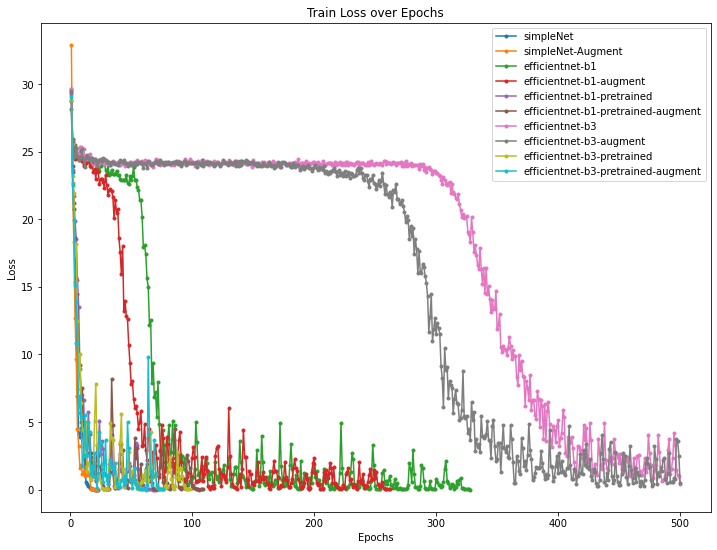

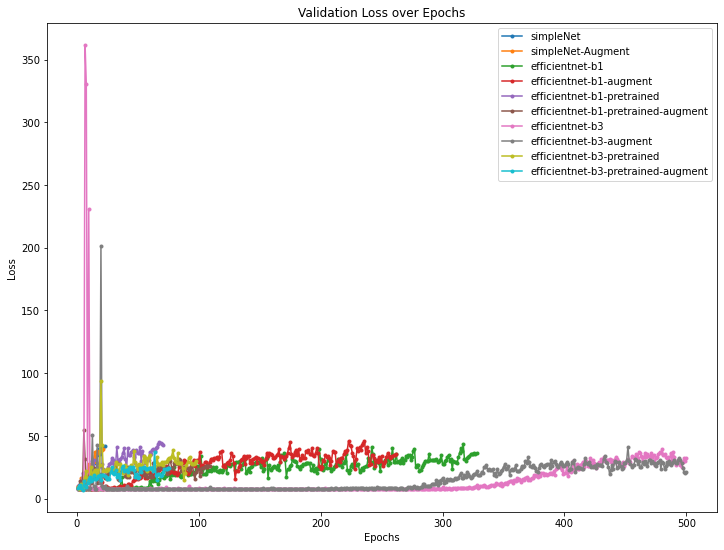

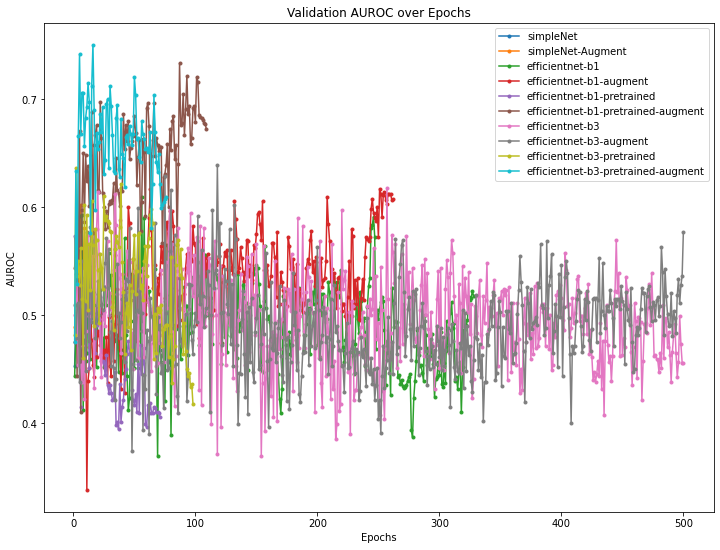

In [16]:
plt.figure(figsize=(12,9))
for i in range(len(models)):
    plt.plot(range(1, epochs[i]+1), train_losses[i], label=names[i], marker=".")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Train Loss over Epochs")
plt.show()

plt.figure(figsize=(12, 9))
for i in range(len(models)):
    plt.plot(range(1, epochs[i]+1), valid_losses[i], label=names[i], marker=".")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Validation Loss over Epochs")
plt.show()

plt.figure(figsize=(12, 9))
for i in range(len(models)):
    plt.plot(range(1, epochs[i]+1), aurocs[i], label=names[i], marker=".")
plt.xlabel("Epochs")
plt.ylabel("AUROC")
plt.legend()
plt.title("Validation AUROC over Epochs")
plt.show()